<a href="https://colab.research.google.com/github/cyankaet/orderml/blob/master/orderparams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/orderml

/content/drive/.shortcut-targets-by-id/1FKl2J9VPA88stIpA_grTLED-Fv9_B7CF/orderml


Any other drive folder is, hint, probably not the correct one! Navigate to where your orderml folder is in your drive. This code should work for a top-level folder.

Check you're in the right folder.



In [ ]:
ls

logs/  models/  orderparams.ipynb  OrderPresentation.gslides


Install non-default packages here.

In [ ]:
!pip install bumps
!pip install gym
%tensorflow_version 1.x
!pip install stable-baselines[mpi]==2.10.0

     |████████████████████████████████| 522kB 2.6MB/s 
  Created wheel for bumps: filename=bumps-0.7.16-cp36-none-any.whl size=546174 sha256=c03c16b583eb08d04404a178922a21634d6fd849a4488f5024d9c643f44ae501
  Stored in directory: /root/.cache/pip/wheels/41/f7/17/a898c85754ad1c6d7de087e28809af7989b81f14f200547de3
Successfully built bumps
TensorFlow 1.x selected.
     |████████████████████████████████| 256kB 2.8MB/s 
  Found existing installation: stable-baselines 2.2.1
    Uninstalling stable-baselines-2.2.1:
      Successfully uninstalled stable-baselines-2.2.1


"Compile" important methods.

In [ ]:
class OrderMethods():

  def bsol(temp,p):
    Tn,Jt,Nf,Bk=p
    t=4.0*(Jt/(Jt+1.0))*Tn/temp
    if (Tn<=0) or (Jt<=0) or temp>=Tn:
      xout=0.0
    else:
      xout=optimize.brentq(OrderMethods.bfun,0.0,t,args=(temp,p),xtol=1e-6)

    return xout


  def bfun(x,T,p):
    Tn,Jt,Nf,Bk=p
    if x==0.0:
      B=-1.0 # so that it wont find solution at zero
    else:
      B=(x-3*OrderMethods.brill(Jt,x)*(Jt/(Jt+1))*(Tn/T))
    return B

  def brill(j,x):
    temp=(2*j+1.0)/2/j
    if x==0:
      Br=0.0
    else:
      Br=temp/np.tanh(temp*x)-1.0/np.tanh(x/2/j)/2/j
    return Br

  def Intensity(T,p):
    Tn,Jt,Nf,Bk=p
    br=OrderMethods.brill(Jt,OrderMethods.bsol(T,p))
    bout=Bk+Nf*br**2
    return bout

  def orderparameter(T, Tn, Jt, Nf, Bk):
    p=[Tn, Jt, Nf, Bk]
    I=[]
    for t in T:
      I.append(OrderMethods.Intensity(t,p))
    return np.array(I)

  def fit(model):
    # nllfs = []
    # zin = []
    # for tns in np.arange(50,200, 5):
      # #print("zs", zs)
      # model.Tn.value = tns
      # model.update()
      # schi=model.nllf()
      # nllfs.append(schi)
      # zin.append(tns)
    # plt.scatter(zin, nllfs)
    # plt.xlabel("tn in")
    # plt.ylabel("chi") 
    # plt.show()
    # plt.close()

    # model.Tn.value = 200
    model.update()

    problem = FitProblem(model)
    result = fitters.fit(problem, method='lm')
    for p, v in zip(problem._parameters, result.dx):
      p.dx = v
    return result.x, result.dx, problem.chisq(), problem._parameters
        

Execute main class.

In [ ]:
import sys
import numpy as np
import pylab as plt
import scipy.optimize as optimize
from bumps.names import *
import bumps.fitters as fitters
import gym.spaces as spaces
import gym
import random 

class OrderEnv(gym.Env):

  def __init__(self):
    self.reward_scale = 100
    self.episodeNum = 0
    self.steps = 0
    self.T = np.array([])
    #self.Bk = .3
    self.error = []

    self.fixedTn = 160
    self.fixedNf = 330
    self.fixedJt = .885
    self.fixedBk = .3

    # self.observation_space = spaces.Box(low = np.array([3]), high = np.array([340]))
    # self.action_space = spaces.Box(low = np.array([3]), high = np.array([340]))
    self.action_space = spaces.Discrete(7)
    self.action_options = [1, 5, 10, 15, 20, 25, 30]
    self.curTemp = 3
    self.x = 150 #startTn value

    #logging arrays and vars
    self.rewards = [] #interepisodic
    self.chisqds = []
    self.convergsTn = []
    self.convergsNf = []
    self.convergsJt = []
    self.convergsBk = []
    self.transTemps = []
    self.Jts = []
    self.Nfs = []
    self.Bks = []
    self.totReward = 0 
    self.info = {}   
  

  def step(self, action): 
      
    print("stepping: ", self.episodeNum)

    self.curTemp += self.action_options[action]
    #self.curTemp = action
    self.curTemp = self.round_to(self.curTemp, 0.5)

    self.steps += 1
    reward = -self.reward_scale
    self.T = np.append(self.T, self.curTemp)
    print("Temperature: ", self.T)
    
    if self.steps > 4:
      self.I = self.getData(self.T)
      #self.I = OrderMethods.getData(self.T, self.Bk)
      #print("Intensity: ", self.I)
      self.error= np.sqrt(self.I)
      M = Curve(OrderMethods.orderparameter, self.T, self.I, self.error, Tn = self.startTn, Jt = self.startJt, Nf = self.startNf, Bk = self.startBk)
      M.Tn.range(40, 300)
      M.Jt.range(0.4, 2)
      M.Nf.range(100,500)
      M.Bk.range(.1, 8)
      # self.Jt = self.fixedJt #DELETE ME LATERRRRRRRRRR
      # self.Nf = self.fixedNf

      self.x, dx, chisq, params = OrderMethods.fit(M)
      self.Nf = self.x[2]
      self.Jt = self.x[1]
      self.Bk = self.x[0] 
      self.x = self.x[3]
      # self.x = self.x[0]
      print("ORDER PARAM RESULT (X2):", self.x)
      print("THE JT RESULT {X0}:", self.Jt)
      print("THE NF RESULT {X1}:", self.Nf)
      print("THE BK RESULT {X3}:", self.Bk)

      dx = params[0].dx

      print("chisqds: ", chisq)
      #print("BUT ARE WE SURE?:", dx)

      plt.plot(self.T, self.I, 'ro')
      plt.show()
      plt.close()

      # if(action > 0.5):
      #   reward += 1000

      if chisq < 300 and chisq >= 1:
        reward += 400*(1/chisq)
      elif chisq < 1:
        reward += 400

      self.chisqds.append(chisq)
      self.transTemps.append(self.x)
      self.Jts.append(self.Jt)
      self.Nfs.append(self.Nf)
      self.Bks.append(self.Bk)

      if not self.goodTn :
        if abs(self.x - self.fixedTn) < 0.1 :
          self.convergsTn.append(self.steps)
          self.goodTn = True
      if not self.goodNf : 
        if abs (self.Nf - self.fixedNf) < 0.1:
          self.convergsNf.append(self.steps)
          self.goodNf = True 
      if not self.goodJt : 
        if abs(self.Jt - self.fixedJt) < 0.1: 
          self.convergsJt.append(self.steps)
          self.goodNf = True 
      if not self.goodBk : 
        if abs(self.Bk - self.fixedBk) < 0.1: 
          self.convergsBk.append(self.steps)
          self.goodBk = True 

    print("rewaRD:: ", reward)

    self.totReward += reward
    self.state = np.array([self.curTemp])

    if (self.steps > 4 and chisq < 0.05): #less than or equal to?
      print("terminated: excellent conditions")
      terminal = True
      self.log()
    elif (self.curTemp >= 340):
      print("terminated: over max temp")
      terminal = True
      self.log()
    elif (self.steps > 100):
      print("terminated: too long")
      terminal = True
      self.log()
    else:
      terminal = False

    if terminal:
      if not self.goodTn :
        self.convergsTn.append(self.steps)
      if not self.goodNf : 
        self.convergsNf.append(self.steps)
      if not self.goodJt : 
        self.convergsJt.append(self.steps)
      if not self.goodBk : 
        self.convergsBk.append(self.steps)

    return self.state, reward, terminal, self.info


  def reset(self):
    print("reset")
    self.steps = 0
    self.T = np.array([])
    self.I = []
    self.chisqds = []
    self.transTemps = []
    self.Jts = []
    self.Nfs = []
    self.totReward = 0
    self.curTemp = 3
    self.state = np.array([self.curTemp])
    self.goodTn = False 
    self.goodNf = False 
    self.goodJt = False 
    self.goodBk = False 

    #basic multiple param set training
    # if (self.steps % 3 == 0):
    #   self.setVars(130, 1.2, 150)
    # elif (self.steps % 3 == 1):
    #   self.setVars(180, .9, 270)
    # else:
    #   self.setVars(160, .885, 330)
    newTn = random.randrange(60, 280, 10)
    newJt = random.randrange(7, 15, 1)/10.0
    newNf = random.randrange(120, 480, 10)
    newBk = random.randrange(30, 78, 2)/10.0

    self.setVars(newTn, newJt, newNf, newBk)

    self.startTn = random.randrange(newTn - 20, newTn + 20, 2)
    print("start Tn: ", self.startTn)
    rangea = int(newJt*100 - 30)
    rangeb  = int(newJt*100 + 30)
    self.startJt = random.randrange(rangea, rangeb, 2)/100.0
    print("start Jt: ", self.startJt)
    self.startNf = random.randrange(newNf - 20, newNf + 20, 2)
    print("start Nf: ", self.startNf)
    rangea = int(newBk*100 - 20)
    rangeb  = int(newBk*100 + 20)
    self.startBk = random.randrange(rangea, rangeb, 2)/100.0
    print("start Bk: ", self.startBk)

    return self.state #starting state

  def log(self):
    self.episodeNum += 1

    filename = "logs/chis/chiLog-" + str(self.episodeNum) + ".npy"
    np.savetxt(filename, self.chisqds)

    filename = "logs/temps/tnLog-" + str(self.episodeNum) + ".npy"
    np.savetxt(filename, self.transTemps)

    filename = "logs/jt/jtLog-" + str(self.episodeNum) + ".npy"
    np.savetxt(filename, self.Jts)

    filename = "logs/nf/nfLog-" + str(self.episodeNum) + ".npy"
    np.savetxt(filename, self.Nfs)

    filename = "logs/bk/bkLog-" + str(self.episodeNum) + ".npy"
    np.savetxt(filename, self.Bks)

    filename = "logs/convergsTn.npy"
    np.savetxt(filename, self.convergsTn)

    filename = "logs/convergsNf.npy"
    np.savetxt(filename, self.convergsNf)
    
    filename = "logs/convergsJt.npy"
    np.savetxt(filename, self.convergsJt)

    filename = "logs/convergsBk.npy"
    np.savetxt(filename, self.convergsBk)

    self.rewards.append(self.totReward)
    filename = "logs/runrewards.npy"
    np.savetxt(filename, self.rewards)

  # @property
  # def action_space(self):
  #     return spaces.Box(low = np.array([0.5]), high = np.array([340 - self.curTemp]))
  #     # return spaces.Box(low = np.array([self.curTemp + 0.5]), high = np.array([340]))

  @property 
  def observation_space(self):
    return spaces.Box(low=3.0, high=340.0, shape=(self.steps + 1,), dtype=np.float32)

  def round_to(self, n, precision):
    correction = 0.5 if n >= 0 else -0.5
    return int( n/precision+correction ) * precision

  def getData(self, T):
    return OrderMethods.orderparameter(T, self.fixedTn, self.fixedJt, self.fixedNf, self.fixedBk)

  def setVars(self, Tn, Jt, Nf, Bk):
    self.fixedTn = Tn
    print("fixed Tn: ", self.fixedTn)
    self.fixedJt = Jt
    print("fixed Jt: ", self.fixedJt)
    self.fixedNf = Nf
    print("fixed Nf: ", self.fixedNf)
    self.fixedBk = Bk
    print("fixed Bk: ", self.fixedBk)

  def getVars(self):
    return self.x, self.Jt, self.Nf, self.Bk

In [ ]:
from stable_baselines.common.env_checker import check_env
env = OrderEnv()
# If the environment don't follow the interface, an error will be thrown
check_env(env, warn=True)

In [ ]:
from stable_baselines import PPO2, A2C
from stable_baselines.common.cmd_util import make_vec_env

# Instantiate the env
env = OrderEnv()
# wrap it
env = make_vec_env(lambda: env, n_envs=1) #retrieve?

Train a new model.

reset
fixed Tn:  120
fixed Jt:  1.2
fixed Nf:  200
fixed Bk:  5.6
start Tn:  118
start Jt:  1.1
start Nf:  198
start Bk:  5.46
stepping:  0
Temperature:  [33.]
rewaRD::  -100
stepping:  0
Temperature:  [33. 34.]
rewaRD::  -100
stepping:  0
Temperature:  [33. 34. 35.]
rewaRD::  -100
stepping:  0
Temperature:  [33. 34. 35. 40.]
rewaRD::  -100
stepping:  0
Temperature:  [33. 34. 35. 40. 60.]
ORDER PARAM RESULT (X2): 119.99999999969039
THE JT RESULT {X0}: 1.199999999995548
THE NF RESULT {X1}: 199.99999999877627
THE BK RESULT {X3}: 5.600000001225034
chisqds:  5.984220207949033e-29


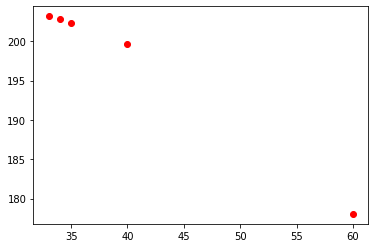

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  160
fixed Jt:  0.7
fixed Nf:  280
fixed Bk:  6.6
start Tn:  156
start Jt:  0.58
start Nf:  262
start Bk:  6.66
stepping:  1
Temperature:  [23.]
rewaRD::  -100
stepping:  1
Temperature:  [23. 53.]
rewaRD::  -100
stepping:  1
Temperature:  [23. 53. 78.]
rewaRD::  -100
stepping:  1
Temperature:  [23. 53. 78. 93.]
rewaRD::  -100
stepping:  1
Temperature:  [ 23.  53.  78.  93. 113.]
ORDER PARAM RESULT (X2): 156.77316264562836
THE JT RESULT {X0}: 0.530970952309294
THE NF RESULT {X1}: 263.5572533389211
THE BK RESULT {X3}: 7.9994299705829
chisqds:  3.1751031848370608


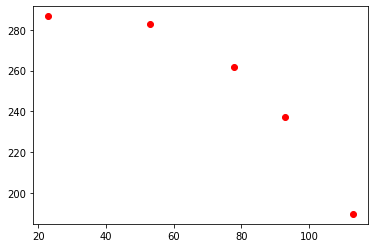

rewaRD::  25.980157719040278
stepping:  1
Temperature:  [ 23.  53.  78.  93. 113. 133.]
ORDER PARAM RESULT (X2): 156.50971348992917
THE JT RESULT {X0}: 0.5275551672729982
THE NF RESULT {X1}: 263.6901092150121
THE BK RESULT {X3}: 7.99923352604842
chisqds:  2.204878242508084


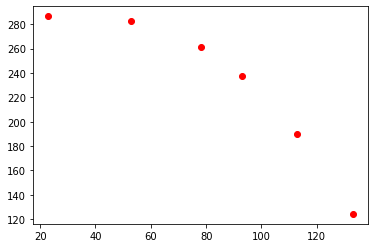

rewaRD::  81.41591326376084
stepping:  1
Temperature:  [ 23.  53.  78.  93. 113. 133. 158.]
ORDER PARAM RESULT (X2): 156.65000979289943
THE JT RESULT {X0}: 0.5130576916812859
THE NF RESULT {X1}: 264.1873902071166
THE BK RESULT {X3}: 7.999863429882245
chisqds:  2.7332572654552885


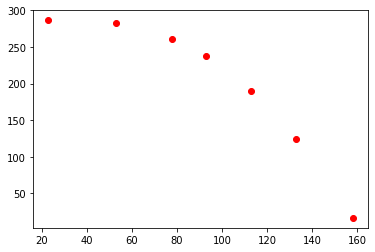

rewaRD::  46.34553616868209
stepping:  1
Temperature:  [ 23.  53.  78.  93. 113. 133. 158. 188.]
ORDER PARAM RESULT (X2): 157.5401176584622
THE JT RESULT {X0}: 0.4218901772400082
THE NF RESULT {X1}: 267.7959548745867
THE BK RESULT {X3}: 7.9999913437903665
chisqds:  1.4434081522363378


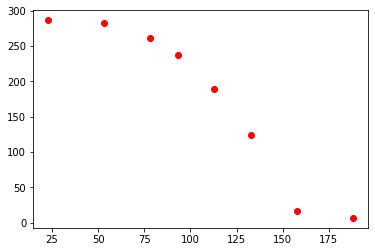

rewaRD::  177.12189333298545
stepping:  1
Temperature:  [ 23.  53.  78.  93. 113. 133. 158. 188. 203.]
ORDER PARAM RESULT (X2): 157.75309429861062
THE JT RESULT {X0}: 0.40000039530739684
THE NF RESULT {X1}: 268.84854028253864
THE BK RESULT {X3}: 7.604252724506943
chisqds:  1.1812764310803137


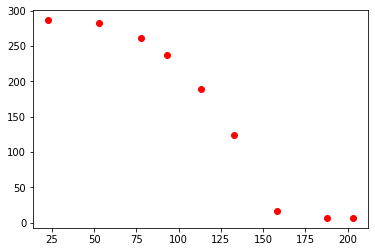

rewaRD::  238.61676189898049
stepping:  1
Temperature:  [ 23.  53.  78.  93. 113. 133. 158. 188. 203. 208.]
ORDER PARAM RESULT (X2): 160.00000000001006
THE JT RESULT {X0}: 0.7000000000000126
THE NF RESULT {X1}: 280.0000000000007
THE BK RESULT {X3}: 6.6
chisqds:  1.7593414313508376e-23


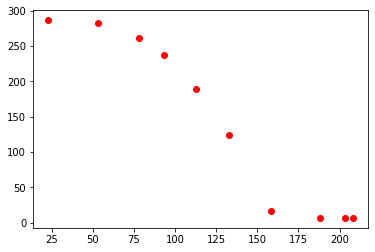

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  190
fixed Jt:  0.9
fixed Nf:  420
fixed Bk:  7.6
start Tn:  170
start Jt:  1.1
start Nf:  424
start Bk:  7.72
stepping:  2
Temperature:  [33.]
rewaRD::  -100
stepping:  2
Temperature:  [33. 34.]
rewaRD::  -100
stepping:  2
Temperature:  [33. 34. 54.]
rewaRD::  -100
stepping:  2
Temperature:  [33. 34. 54. 84.]
rewaRD::  -100
stepping:  2
Temperature:  [ 33.  34.  54.  84. 104.]
ORDER PARAM RESULT (X2): 170.48688573068736
THE JT RESULT {X0}: 1.0790349514178363
THE NF RESULT {X1}: 424.2518724233671
THE BK RESULT {X3}: 7.999246288603019
chisqds:  3.854232333966549


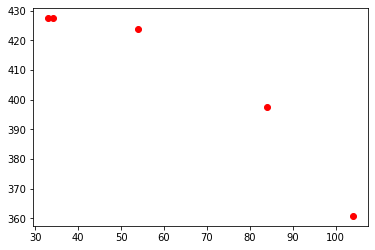

rewaRD::  3.782015545581686
stepping:  2
Temperature:  [ 33.  34.  54.  84. 104. 109.]
ORDER PARAM RESULT (X2): 170.32399181301068
THE JT RESULT {X0}: 1.0842527622956664
THE NF RESULT {X1}: 424.26849777543055
THE BK RESULT {X3}: 7.999515102091928
chisqds:  4.063688976095065


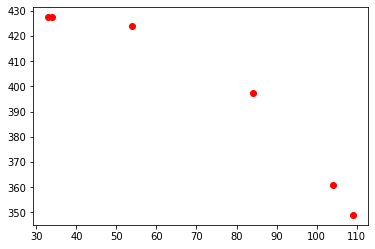

rewaRD::  -1.567269947816385
stepping:  2
Temperature:  [ 33.  34.  54.  84. 104. 109. 114.]
ORDER PARAM RESULT (X2): 170.24801595716852
THE JT RESULT {X0}: 1.0867926470661367
THE NF RESULT {X1}: 424.27602455359505
THE BK RESULT {X3}: 7.999804711014197
chisqds:  4.585336274125677


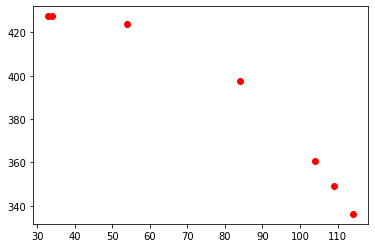

rewaRD::  -12.765394708969026
stepping:  2
Temperature:  [ 33.  34.  54.  84. 104. 109. 114. 129.]
ORDER PARAM RESULT (X2): 170.19916986642386
THE JT RESULT {X0}: 1.087494412036639
THE NF RESULT {X1}: 424.29180122974526
THE BK RESULT {X3}: 7.999639858471662
chisqds:  6.405650440885227


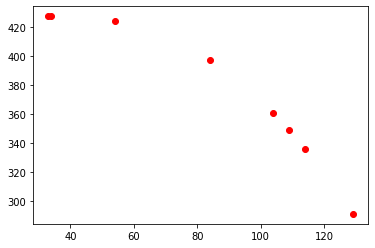

rewaRD::  -37.55513141227198
stepping:  2
Temperature:  [ 33.  34.  54.  84. 104. 109. 114. 129. 134.]
ORDER PARAM RESULT (X2): 170.1553980988757
THE JT RESULT {X0}: 1.0888804238460281
THE NF RESULT {X1}: 424.2812827134927
THE BK RESULT {X3}: 7.999335782694137
chisqds:  8.178606343655064


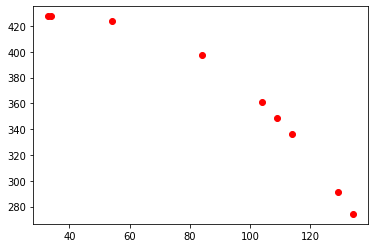

rewaRD::  -51.09191184995489
stepping:  2
Temperature:  [ 33.  34.  54.  84. 104. 109. 114. 129. 134. 139.]
ORDER PARAM RESULT (X2): 170.13374874838615
THE JT RESULT {X0}: 1.0892659213323261
THE NF RESULT {X1}: 424.28783618506714
THE BK RESULT {X3}: 7.9994304147576525
chisqds:  10.034832265066717


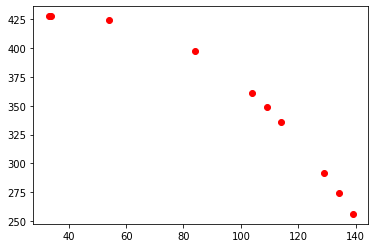

rewaRD::  -60.13884543018412
stepping:  2
Temperature:  [ 33.  34.  54.  84. 104. 109. 114. 129. 134. 139. 169.]
ORDER PARAM RESULT (X2): 170.09551929479204
THE JT RESULT {X0}: 1.0918802077175618
THE NF RESULT {X1}: 424.21615054030565
THE BK RESULT {X3}: 7.999972820995575
chisqds:  22.33810666584535


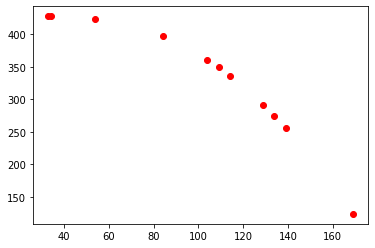

rewaRD::  -82.0933794442125
stepping:  2
Temperature:  [ 33.  34.  54.  84. 104. 109. 114. 129. 134. 139. 169. 199.]
ORDER PARAM RESULT (X2): 190.00000000000003
THE JT RESULT {X0}: 0.8999999999999981
THE NF RESULT {X1}: 419.9999999999997
THE BK RESULT {X3}: 7.6
chisqds:  7.579006112705144e-29


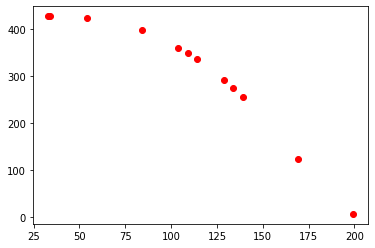

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  200
fixed Jt:  1.3
fixed Nf:  260
fixed Bk:  6.0
start Tn:  216
start Jt:  1.46
start Nf:  242
start Bk:  6.06
stepping:  3
Temperature:  [8.]
rewaRD::  -100
stepping:  3
Temperature:  [ 8. 33.]
rewaRD::  -100
stepping:  3
Temperature:  [ 8. 33. 43.]
rewaRD::  -100
stepping:  3
Temperature:  [ 8. 33. 43. 48.]
rewaRD::  -100
stepping:  3
Temperature:  [ 8. 33. 43. 48. 73.]
ORDER PARAM RESULT (X2): 225.7133444967781
THE JT RESULT {X0}: 1.2286951404592266
THE NF RESULT {X1}: 243.96041058977818
THE BK RESULT {X3}: 7.999438322225923
chisqds:  3.053931502854163


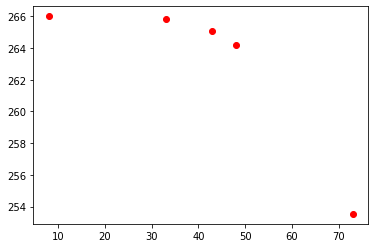

rewaRD::  30.978707160316276
stepping:  3
Temperature:  [ 8. 33. 43. 48. 73. 83.]
ORDER PARAM RESULT (X2): 222.7447744887685
THE JT RESULT {X0}: 1.2874931838535102
THE NF RESULT {X1}: 243.9843167242036
THE BK RESULT {X3}: 7.999725943842716
chisqds:  1.647334669099467


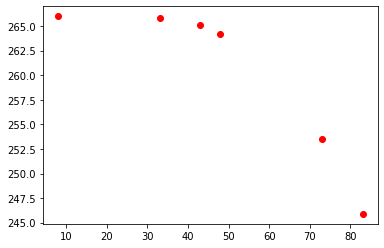

rewaRD::  142.81647652001658
stepping:  3
Temperature:  [ 8. 33. 43. 48. 73. 83. 98.]
ORDER PARAM RESULT (X2): 220.24797717907282
THE JT RESULT {X0}: 1.3299456591056735
THE NF RESULT {X1}: 244.06878587618837
THE BK RESULT {X3}: 7.999782675010822
chisqds:  1.1414231140938274


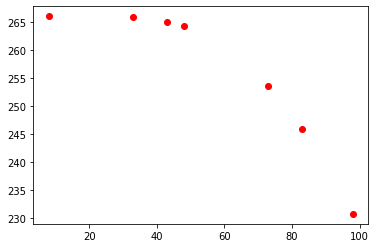

rewaRD::  250.43972306234474
stepping:  3
Temperature:  [ 8. 33. 43. 48. 73. 83. 98. 99.]
ORDER PARAM RESULT (X2): 219.63528034718394
THE JT RESULT {X0}: 1.346102040844669
THE NF RESULT {X1}: 244.06175975390207
THE BK RESULT {X3}: 7.999734516577285
chisqds:  0.8836126797357085


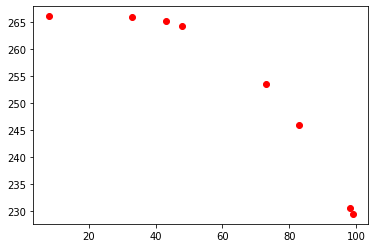

rewaRD::  300
stepping:  3
Temperature:  [  8.  33.  43.  48.  73.  83.  98.  99. 119.]
ORDER PARAM RESULT (X2): 199.99999999975898
THE JT RESULT {X0}: 1.2999999999986684
THE NF RESULT {X1}: 259.9999999993722
THE BK RESULT {X3}: 6.000000000627544
chisqds:  3.95281479372228e-24


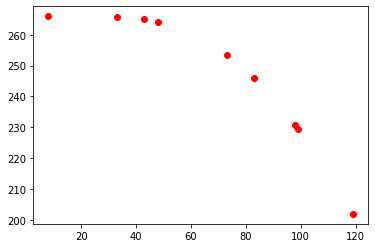

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  180
fixed Jt:  0.7
fixed Nf:  440
fixed Bk:  6.8
start Tn:  194
start Jt:  0.48
start Nf:  440
start Bk:  6.74
stepping:  4
Temperature:  [4.]
rewaRD::  -100
stepping:  4
Temperature:  [ 4. 19.]
rewaRD::  -100
stepping:  4
Temperature:  [ 4. 19. 24.]
rewaRD::  -100
stepping:  4
Temperature:  [ 4. 19. 24. 44.]
rewaRD::  -100
stepping:  4
Temperature:  [ 4. 19. 24. 44. 69.]
ORDER PARAM RESULT (X2): 180.0000000323362
THE JT RESULT {X0}: 0.7000000002946468
THE NF RESULT {X1}: 440.0000002068322
THE BK RESULT {X3}: 6.799999793167672
chisqds:  3.9886369685649537e-26


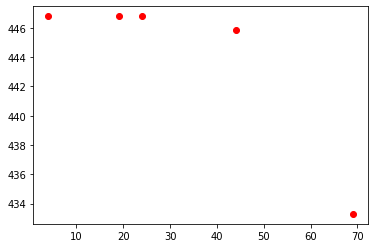

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  160
fixed Jt:  0.8
fixed Nf:  300
fixed Bk:  7.0
start Tn:  152
start Jt:  0.64
start Nf:  284
start Bk:  6.92
stepping:  5
Temperature:  [13.]
rewaRD::  -100
stepping:  5
Temperature:  [13. 43.]
rewaRD::  -100
stepping:  5
Temperature:  [13. 43. 44.]
rewaRD::  -100
stepping:  5
Temperature:  [13. 43. 44. 69.]
rewaRD::  -100
stepping:  5
Temperature:  [13. 43. 44. 69. 94.]
ORDER PARAM RESULT (X2): 152.95697764651607
THE JT RESULT {X0}: 0.593675442419456
THE NF RESULT {X1}: 285.1512052434146
THE BK RESULT {X3}: 7.999522728389567
chisqds:  3.1619268156369165


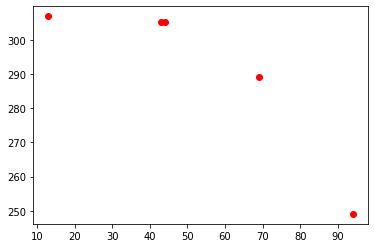

rewaRD::  26.50514174516934
stepping:  5
Temperature:  [ 13.  43.  44.  69.  94. 119.]
ORDER PARAM RESULT (X2): 152.5739378651343
THE JT RESULT {X0}: 0.5941426120129218
THE NF RESULT {X1}: 285.17819987544596
THE BK RESULT {X3}: 7.999632101741377
chisqds:  2.7934240871535883


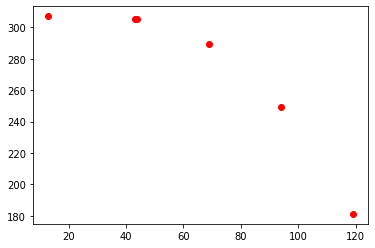

rewaRD::  43.19343841829169
stepping:  5
Temperature:  [ 13.  43.  44.  69.  94. 119. 124.]
ORDER PARAM RESULT (X2): 152.48731899284974
THE JT RESULT {X0}: 0.5943155447407166
THE NF RESULT {X1}: 285.2173225458128
THE BK RESULT {X3}: 7.999919506176021
chisqds:  2.9256941318746583


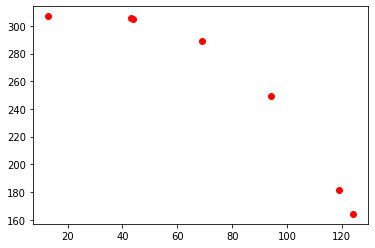

rewaRD::  36.71969179624983
stepping:  5
Temperature:  [ 13.  43.  44.  69.  94. 119. 124. 149.]
ORDER PARAM RESULT (X2): 152.31838041954654
THE JT RESULT {X0}: 0.5995733312500766
THE NF RESULT {X1}: 284.97467052142485
THE BK RESULT {X3}: 7.999266965344154
chisqds:  7.51476279111397


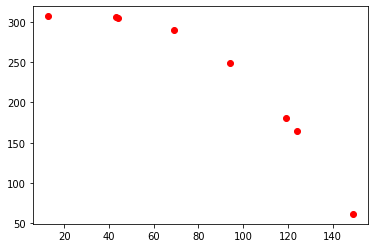

rewaRD::  -46.77144028112363
stepping:  5
Temperature:  [ 13.  43.  44.  69.  94. 119. 124. 149. 159.]
ORDER PARAM RESULT (X2): 152.67294637755816
THE JT RESULT {X0}: 0.5577448743025647
THE NF RESULT {X1}: 285.9939429935556
THE BK RESULT {X3}: 7.999575962977838
chisqds:  5.403347164921433


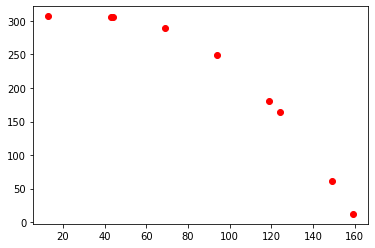

rewaRD::  -25.971811954485773
stepping:  5
Temperature:  [ 13.  43.  44.  69.  94. 119. 124. 149. 159. 179.]
ORDER PARAM RESULT (X2): 153.51137234088478
THE JT RESULT {X0}: 0.4649723903356662
THE NF RESULT {X1}: 288.3247463994448
THE BK RESULT {X3}: 7.9995719090573925
chisqds:  3.035857582753692


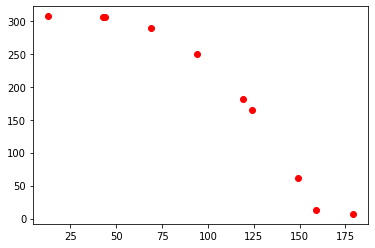

rewaRD::  31.758486390253438
stepping:  5
Temperature:  [ 13.  43.  44.  69.  94. 119. 124. 149. 159. 179. 180.]
ORDER PARAM RESULT (X2): 154.29398217585418
THE JT RESULT {X0}: 0.4000004143531053
THE NF RESULT {X1}: 290.0766245620709
THE BK RESULT {X3}: 7.925597023301337
chisqds:  1.784818642026224


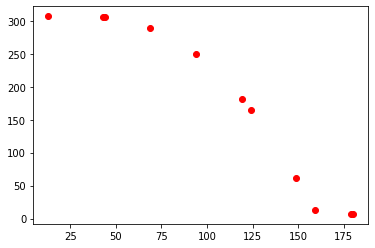

rewaRD::  124.1124059225973
stepping:  5
Temperature:  [ 13.  43.  44.  69.  94. 119. 124. 149. 159. 179. 180. 195.]
ORDER PARAM RESULT (X2): 159.99999999991135
THE JT RESULT {X0}: 0.8000000000006073
THE NF RESULT {X1}: 299.99999999999926
THE BK RESULT {X3}: 7.0
chisqds:  2.5096302685719573e-21


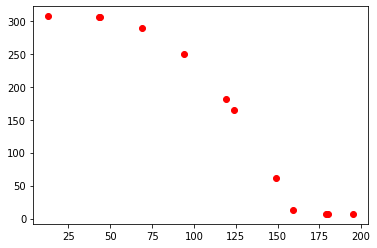

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  200
fixed Jt:  1.2
fixed Nf:  140
fixed Bk:  4.4
start Tn:  194
start Jt:  1.0
start Nf:  120
start Bk:  4.4
stepping:  6
Temperature:  [23.]
rewaRD::  -100
stepping:  6
Temperature:  [23. 28.]
rewaRD::  -100
stepping:  6
Temperature:  [23. 28. 29.]
rewaRD::  -100
stepping:  6
Temperature:  [23. 28. 29. 30.]
rewaRD::  -100
stepping:  6
Temperature:  [23. 28. 29. 30. 31.]
ORDER PARAM RESULT (X2): 232.40618303941065
THE JT RESULT {X0}: 0.40000003141859425
THE NF RESULT {X1}: 120.7094073280811
THE BK RESULT {X3}: 5.109405063636585
chisqds:  11.931877635285282


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


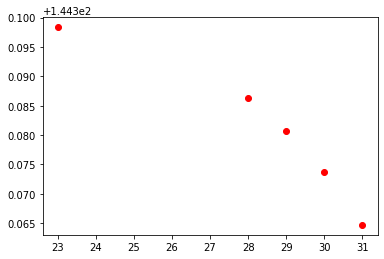

rewaRD::  -66.47635751668213
stepping:  6
Temperature:  [23. 28. 29. 30. 31. 32.]
ORDER PARAM RESULT (X2): 231.21293013803574
THE JT RESULT {X0}: 0.40000009938327685
THE NF RESULT {X1}: 120.65196703199916
THE BK RESULT {X3}: 5.051963668213395
chisqds:  7.244737261159402


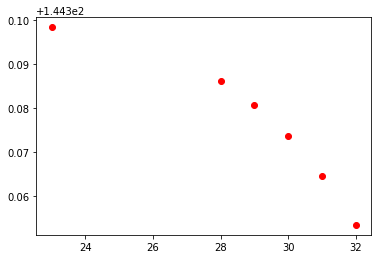

rewaRD::  -44.78750773413327
stepping:  6
Temperature:  [23. 28. 29. 30. 31. 32. 62.]
ORDER PARAM RESULT (X2): 225.61250898803146
THE JT RESULT {X0}: 0.40000044001004503
THE NF RESULT {X1}: 122.74132101750637
THE BK RESULT {X3}: 7.133667771738596
chisqds:  3.238421590912401


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


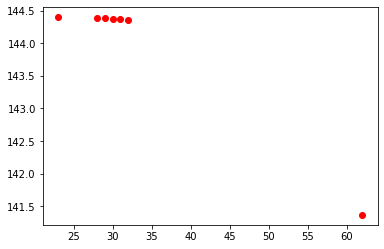

rewaRD::  23.51696305461668
stepping:  6
Temperature:  [23. 28. 29. 30. 31. 32. 62. 67.]
ORDER PARAM RESULT (X2): 220.38582650717498
THE JT RESULT {X0}: 0.4123940391583611
THE NF RESULT {X1}: 123.62291948879698
THE BK RESULT {X3}: 7.999294635673858
chisqds:  2.0153594589735384


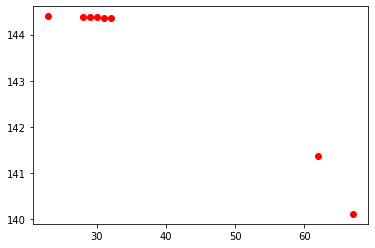

rewaRD::  98.47575985463544
stepping:  6
Temperature:  [23. 28. 29. 30. 31. 32. 62. 67. 72.]
ORDER PARAM RESULT (X2): 219.15975666176556
THE JT RESULT {X0}: 0.4572028828978331
THE NF RESULT {X1}: 123.63000991607554
THE BK RESULT {X3}: 7.999562748768074
chisqds:  1.7072362718237861


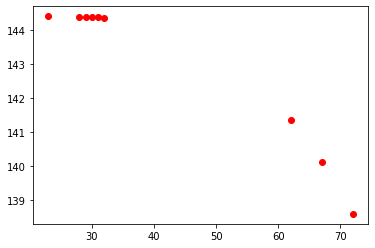

rewaRD::  134.29680273410122
stepping:  6
Temperature:  [23. 28. 29. 30. 31. 32. 62. 67. 72. 77.]
ORDER PARAM RESULT (X2): 214.67699229854873
THE JT RESULT {X0}: 0.5042400725505932
THE NF RESULT {X1}: 123.64315869961493
THE BK RESULT {X3}: 7.999594210007274
chisqds:  1.4937844997979794


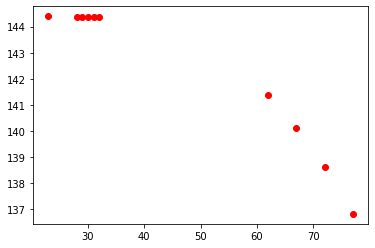

rewaRD::  167.77624219162556
stepping:  6
Temperature:  [23. 28. 29. 30. 31. 32. 62. 67. 72. 77. 97.]
ORDER PARAM RESULT (X2): 206.8063919077344
THE JT RESULT {X0}: 0.5985763258266212
THE NF RESULT {X1}: 123.69276398599793
THE BK RESULT {X3}: 7.99982146464158
chisqds:  1.326158415650949


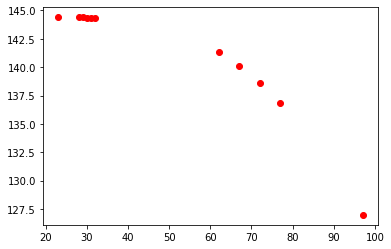

rewaRD::  201.62309063480836
stepping:  6
Temperature:  [ 23.  28.  29.  30.  31.  32.  62.  67.  72.  77.  97. 117.]
ORDER PARAM RESULT (X2): 201.3536868581097
THE JT RESULT {X0}: 0.672617807774859
THE NF RESULT {X1}: 123.79109238756969
THE BK RESULT {X3}: 7.999395256893257
chisqds:  1.198027079122483


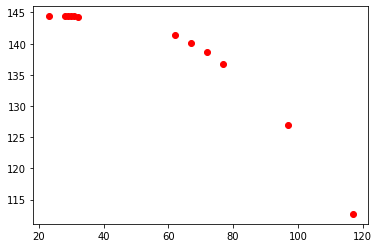

rewaRD::  233.88226941663737
stepping:  6
Temperature:  [ 23.  28.  29.  30.  31.  32.  62.  67.  72.  77.  97. 117. 147.]
ORDER PARAM RESULT (X2): 197.62798256954278
THE JT RESULT {X0}: 0.7114611623075783
THE NF RESULT {X1}: 124.02043383435367
THE BK RESULT {X3}: 7.999451662655538
chisqds:  1.0744988246637541


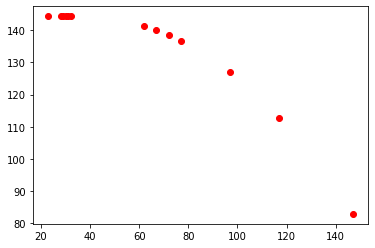

rewaRD::  272.2665775136358
stepping:  6
Temperature:  [ 23.  28.  29.  30.  31.  32.  62.  67.  72.  77.  97. 117. 147. 172.]
ORDER PARAM RESULT (X2): 196.12762915380137
THE JT RESULT {X0}: 0.6912703417788161
THE NF RESULT {X1}: 124.45962108770578
THE BK RESULT {X3}: 7.999682896180471
chisqds:  0.9125672322175843


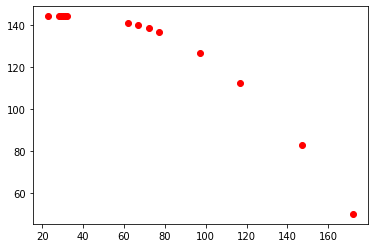

rewaRD::  300
stepping:  6
Temperature:  [ 23.  28.  29.  30.  31.  32.  62.  67.  72.  77.  97. 117. 147. 172.
 177.]
ORDER PARAM RESULT (X2): 195.88697023385583
THE JT RESULT {X0}: 0.6667594939287724
THE NF RESULT {X1}: 124.9023200390187
THE BK RESULT {X3}: 7.999363833800424
chisqds:  0.7681558356338463


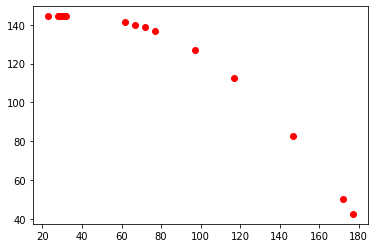

rewaRD::  300
stepping:  6
Temperature:  [ 23.  28.  29.  30.  31.  32.  62.  67.  72.  77.  97. 117. 147. 172.
 177. 202.]
ORDER PARAM RESULT (X2): 199.9999999999465
THE JT RESULT {X0}: 1.2000000000002427
THE NF RESULT {X1}: 139.9999999999999
THE BK RESULT {X3}: 4.4
chisqds:  2.1854593445689937e-23


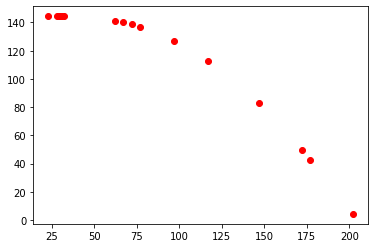

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  200
fixed Jt:  0.9
fixed Nf:  410
fixed Bk:  7.0
start Tn:  218
start Jt:  0.96
start Nf:  394
start Bk:  7.18
stepping:  7
Temperature:  [28.]
rewaRD::  -100
stepping:  7
Temperature:  [28. 29.]
rewaRD::  -100
stepping:  7
Temperature:  [28. 29. 59.]
rewaRD::  -100
stepping:  7
Temperature:  [28. 29. 59. 60.]
rewaRD::  -100
stepping:  7
Temperature:  [28. 29. 59. 60. 70.]
ORDER PARAM RESULT (X2): 223.31178670958658
THE JT RESULT {X0}: 0.8752355698024004
THE NF RESULT {X1}: 394.82714301580756
THE BK RESULT {X3}: 7.999832389628125
chisqds:  1.8435807688446906


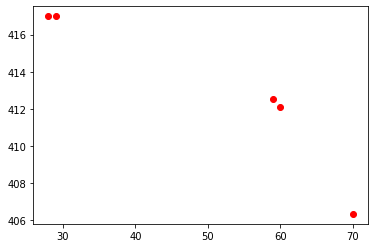

rewaRD::  116.9690673496591
stepping:  7
Temperature:  [28. 29. 59. 60. 70. 71.]
ORDER PARAM RESULT (X2): 222.8866899857952
THE JT RESULT {X0}: 0.8827624330114319
THE NF RESULT {X1}: 394.8286817757369
THE BK RESULT {X3}: 7.999449998188185
chisqds:  1.0290502299022997


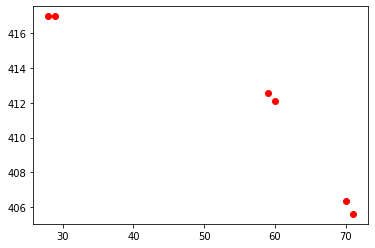

rewaRD::  288.7079448376168
stepping:  7
Temperature:  [28. 29. 59. 60. 70. 71. 86.]
ORDER PARAM RESULT (X2): 220.58290245866402
THE JT RESULT {X0}: 0.910583451359281
THE NF RESULT {X1}: 394.8411718071872
THE BK RESULT {X3}: 7.999326585365828
chisqds:  0.7350279780758809


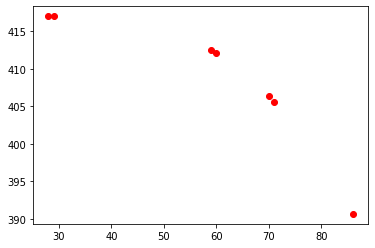

rewaRD::  300
stepping:  7
Temperature:  [ 28.  29.  59.  60.  70.  71.  86. 116.]
ORDER PARAM RESULT (X2): 218.09522852322644
THE JT RESULT {X0}: 0.9479739857058891
THE NF RESULT {X1}: 394.8799678056197
THE BK RESULT {X3}: 7.999284315829788
chisqds:  0.627655322463159


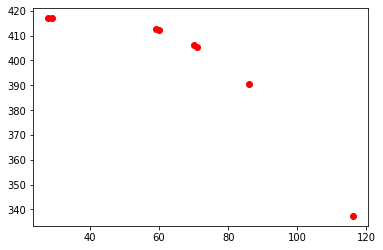

rewaRD::  300
stepping:  7
Temperature:  [ 28.  29.  59.  60.  70.  71.  86. 116. 146.]
ORDER PARAM RESULT (X2): 216.15302436442548
THE JT RESULT {X0}: 1.0044346412034668
THE NF RESULT {X1}: 395.22756090546346
THE BK RESULT {X3}: 7.9993059096609604
chisqds:  0.9009222800272116


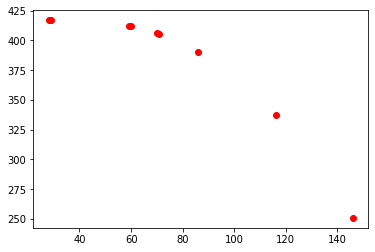

rewaRD::  300
stepping:  7
Temperature:  [ 28.  29.  59.  60.  70.  71.  86. 116. 146. 161.]
ORDER PARAM RESULT (X2): 211.9319101541719
THE JT RESULT {X0}: 1.155198622611747
THE NF RESULT {X1}: 397.4489256276886
THE BK RESULT {X3}: 7.999363114184326
chisqds:  0.8345777030456899


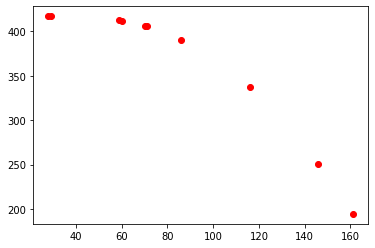

rewaRD::  300
stepping:  7
Temperature:  [ 28.  29.  59.  60.  70.  71.  86. 116. 146. 161. 191.]
ORDER PARAM RESULT (X2): 209.8042406879817
THE JT RESULT {X0}: 1.3174277941920027
THE NF RESULT {X1}: 399.4458623591623
THE BK RESULT {X3}: 0.10000002618288967
chisqds:  3.290272480522965


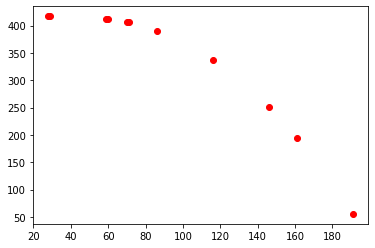

rewaRD::  21.570478544811237
stepping:  7
Temperature:  [ 28.  29.  59.  60.  70.  71.  86. 116. 146. 161. 191. 201.]
ORDER PARAM RESULT (X2): 215.78702098719054
THE JT RESULT {X0}: 1.3246483640895126
THE NF RESULT {X1}: 386.8687652744365
THE BK RESULT {X3}: 0.10001348772208699
chisqds:  64.98516495258231


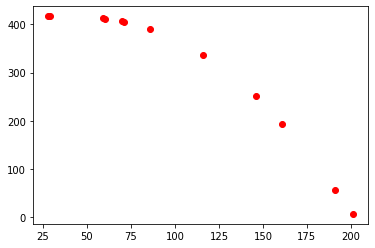

rewaRD::  -93.84474902399852
stepping:  7
Temperature:  [ 28.  29.  59.  60.  70.  71.  86. 116. 146. 161. 191. 201. 211.]
ORDER PARAM RESULT (X2): 216.20596801073776
THE JT RESULT {X0}: 1.393668210873898
THE NF RESULT {X1}: 383.49927551906524
THE BK RESULT {X3}: 0.10000548827415426
chisqds:  62.76559376898222


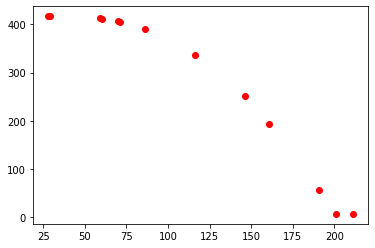

rewaRD::  -93.62708171817417
stepping:  7
Temperature:  [ 28.  29.  59.  60.  70.  71.  86. 116. 146. 161. 191. 201. 211. 236.]
ORDER PARAM RESULT (X2): 215.2135903936182
THE JT RESULT {X0}: 1.590173848946873
THE NF RESULT {X1}: 380.04864510738236
THE BK RESULT {X3}: 0.10000257357853429
chisqds:  46.043775532448294


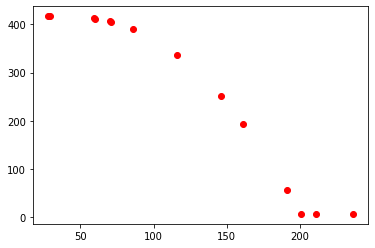

rewaRD::  -91.31261510650643
stepping:  7
Temperature:  [ 28.  29.  59.  60.  70.  71.  86. 116. 146. 161. 191. 201. 211. 236.
 251.]
ORDER PARAM RESULT (X2): 214.08826021946976
THE JT RESULT {X0}: 1.7360880299268597
THE NF RESULT {X1}: 377.357806280574
THE BK RESULT {X3}: 0.10000666010482757
chisqds:  34.53046921979227


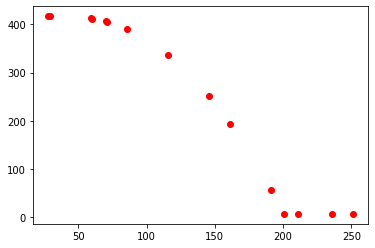

rewaRD::  -88.41602766953636
stepping:  7
Temperature:  [ 28.  29.  59.  60.  70.  71.  86. 116. 146. 161. 191. 201. 211. 236.
 251. 261.]
ORDER PARAM RESULT (X2): 211.76637750857753
THE JT RESULT {X0}: 1.9601291585710252
THE NF RESULT {X1}: 379.1186250156499
THE BK RESULT {X3}: 0.10000007718082254
chisqds:  22.33903209501841


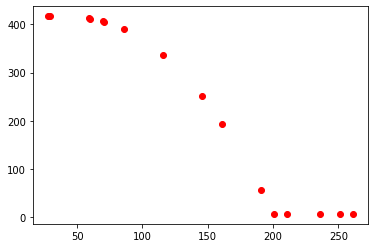

rewaRD::  -82.09412125383894
stepping:  7
Temperature:  [ 28.  29.  59.  60.  70.  71.  86. 116. 146. 161. 191. 201. 211. 236.
 251. 261. 276.]
ORDER PARAM RESULT (X2): 211.19012311867405
THE JT RESULT {X0}: 1.9999582686968176
THE NF RESULT {X1}: 379.6695027157919
THE BK RESULT {X3}: 1.2788925203694756
chisqds:  19.574363748827956


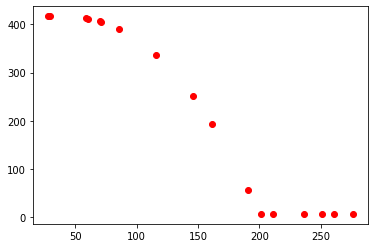

rewaRD::  -79.56510846877714
stepping:  7
Temperature:  [ 28.  29.  59.  60.  70.  71.  86. 116. 146. 161. 191. 201. 211. 236.
 251. 261. 276. 301.]
ORDER PARAM RESULT (X2): 211.14334856691272
THE JT RESULT {X0}: 1.9998741480977502
THE NF RESULT {X1}: 378.7238986444078
THE BK RESULT {X3}: 2.076841742180838
chisqds:  18.43384530526299


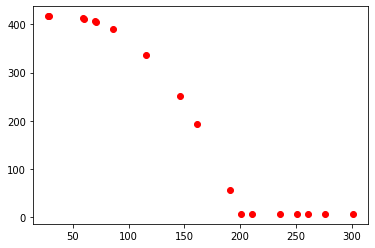

rewaRD::  -78.30078351119735
stepping:  7
Temperature:  [ 28.  29.  59.  60.  70.  71.  86. 116. 146. 161. 191. 201. 211. 236.
 251. 261. 276. 301. 326.]
ORDER PARAM RESULT (X2): 211.16362108239346
THE JT RESULT {X0}: 1.9998474161628672
THE NF RESULT {X1}: 377.99300236269306
THE BK RESULT {X3}: 2.7237964185256933
chisqds:  17.512170994578195


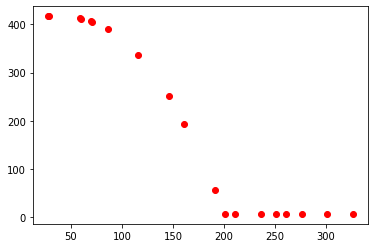

rewaRD::  -77.15874290378727
stepping:  7
Temperature:  [ 28.  29.  59.  60.  70.  71.  86. 116. 146. 161. 191. 201. 211. 236.
 251. 261. 276. 301. 326. 351.]
ORDER PARAM RESULT (X2): 211.16620607443508
THE JT RESULT {X0}: 1.999830834308642
THE NF RESULT {X1}: 377.4849164896633
THE BK RESULT {X3}: 3.2210876351827196
chisqds:  16.61089772288387


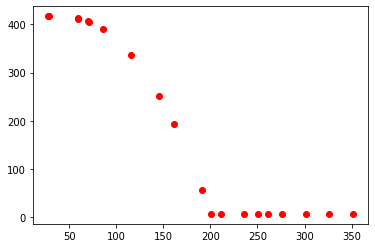

rewaRD::  -75.91942309963517
terminated: over max temp
reset
fixed Tn:  130
fixed Jt:  1.0
fixed Nf:  370
fixed Bk:  3.0
start Tn:  122
start Jt:  0.76
start Nf:  350
start Bk:  2.88
stepping:  8
Temperature:  [23.]
rewaRD::  -100
stepping:  8
Temperature:  [23. 24.]
rewaRD::  -100
stepping:  8
Temperature:  [23. 24. 54.]
rewaRD::  -100
stepping:  8
Temperature:  [23. 24. 54. 84.]
rewaRD::  -100
stepping:  8
Temperature:  [ 23.  24.  54.  84. 104.]
ORDER PARAM RESULT (X2): 123.49403401194411
THE JT RESULT {X0}: 0.5768335889245133
THE NF RESULT {X1}: 355.40030798559417
THE BK RESULT {X3}: 7.999438476694454
chisqds:  3.083651779196457


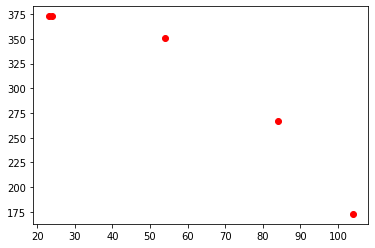

rewaRD::  29.71633266069773
stepping:  8
Temperature:  [ 23.  24.  54.  84. 104. 114.]
ORDER PARAM RESULT (X2): 123.14440042639565
THE JT RESULT {X0}: 0.5675045480961016
THE NF RESULT {X1}: 354.9500769019284
THE BK RESULT {X3}: 7.9992814337053515
chisqds:  6.547580651002826


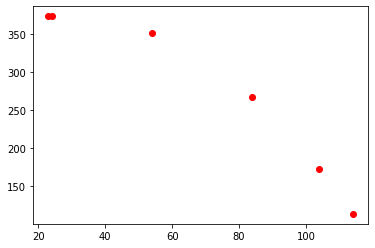

rewaRD::  -38.908732657040865
stepping:  8
Temperature:  [ 23.  24.  54.  84. 104. 114. 144.]
ORDER PARAM RESULT (X2): 130.00000000011764
THE JT RESULT {X0}: 1.0000000000016582
THE NF RESULT {X1}: 370.0000000000224
THE BK RESULT {X3}: 2.999999999999999
chisqds:  1.663857378181751e-21


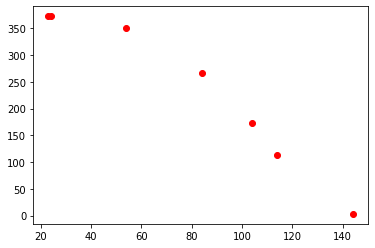

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  160
fixed Jt:  1.3
fixed Nf:  340
fixed Bk:  4.6
start Tn:  158
start Jt:  1.06
start Nf:  328
start Bk:  4.75
stepping:  9
Temperature:  [28.]
rewaRD::  -100
stepping:  9
Temperature:  [28. 29.]
rewaRD::  -100
stepping:  9
Temperature:  [28. 29. 34.]
rewaRD::  -100
stepping:  9
Temperature:  [28. 29. 34. 54.]
rewaRD::  -100
stepping:  9
Temperature:  [28. 29. 34. 54. 64.]
ORDER PARAM RESULT (X2): 160.95853008103987
THE JT RESULT {X0}: 0.9659001283916764
THE NF RESULT {X1}: 331.3424501822932
THE BK RESULT {X3}: 7.999596737601263
chisqds:  0.21828440989474554


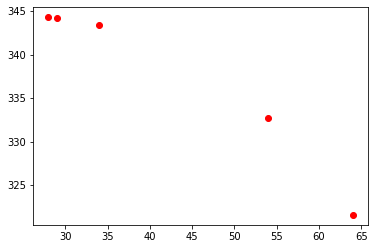

rewaRD::  300
stepping:  9
Temperature:  [28. 29. 34. 54. 64. 94.]
ORDER PARAM RESULT (X2): 158.23443237694934
THE JT RESULT {X0}: 1.022508264641701
THE NF RESULT {X1}: 331.64024212123815
THE BK RESULT {X3}: 7.999432439175474
chisqds:  0.11110864850674843


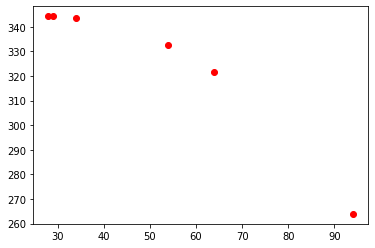

rewaRD::  300
stepping:  9
Temperature:  [28. 29. 34. 54. 64. 94. 95.]
ORDER PARAM RESULT (X2): 158.06480540234097
THE JT RESULT {X0}: 1.0364850184273096
THE NF RESULT {X1}: 331.873911268937
THE BK RESULT {X3}: 7.999285083527429
chisqds:  0.06952955015022323


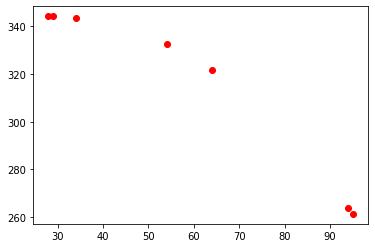

rewaRD::  300
stepping:  9
Temperature:  [ 28.  29.  34.  54.  64.  94.  95. 120.]
ORDER PARAM RESULT (X2): 158.00265767191914
THE JT RESULT {X0}: 1.0486074791516662
THE NF RESULT {X1}: 332.45475962121037
THE BK RESULT {X3}: 7.999204724071873
chisqds:  0.040490737696752266


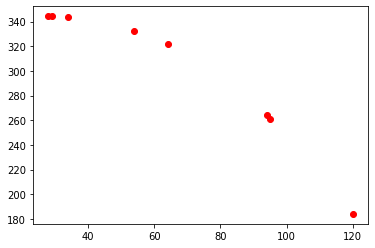

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  60
fixed Jt:  1.3
fixed Nf:  260
fixed Bk:  4.8
start Tn:  76
start Jt:  1.24
start Nf:  244
start Bk:  4.68
stepping:  10
Temperature:  [4.]
rewaRD::  -100
stepping:  10
Temperature:  [ 4. 24.]
rewaRD::  -100
stepping:  10
Temperature:  [ 4. 24. 49.]
rewaRD::  -100
stepping:  10
Temperature:  [ 4. 24. 49. 50.]
rewaRD::  -100
stepping:  10
Temperature:  [ 4. 24. 49. 50. 51.]
ORDER PARAM RESULT (X2): 73.93852170816724
THE JT RESULT {X0}: 1.5288778232110105
THE NF RESULT {X1}: 238.92647340604785
THE BK RESULT {X3}: 0.10000807915884902
chisqds:  72.64082482718362


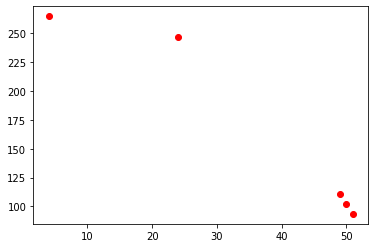

rewaRD::  -94.49345459730638
stepping:  10
Temperature:  [ 4. 24. 49. 50. 51. 66.]
ORDER PARAM RESULT (X2): 75.16416581114649
THE JT RESULT {X0}: 1.5559291344507595
THE NF RESULT {X1}: 234.9619256770522
THE BK RESULT {X3}: 0.10001473938945421
chisqds:  407.2456925506597


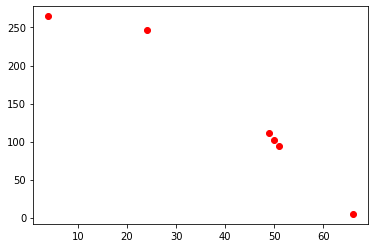

rewaRD::  -100
stepping:  10
Temperature:  [ 4. 24. 49. 50. 51. 66. 86.]
ORDER PARAM RESULT (X2): 74.38028033828738
THE JT RESULT {X0}: 1.7992438380780618
THE NF RESULT {X1}: 227.27644604785849
THE BK RESULT {X3}: 0.10000238442719463
chisqds:  202.87209359245915


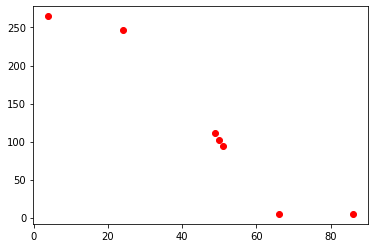

rewaRD::  -98.02831432891139
stepping:  10
Temperature:  [  4.  24.  49.  50.  51.  66.  86. 101.]
ORDER PARAM RESULT (X2): 73.76552161486227
THE JT RESULT {X0}: 1.9998493310130077
THE NF RESULT {X1}: 221.78608896566223
THE BK RESULT {X3}: 0.7106291600300596
chisqds:  123.7639651539638


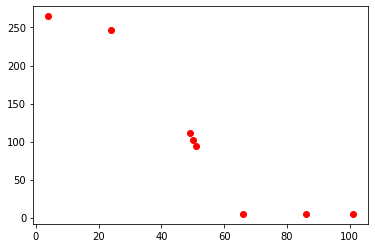

rewaRD::  -96.76804149331839
stepping:  10
Temperature:  [  4.  24.  49.  50.  51.  66.  86. 101. 102.]
ORDER PARAM RESULT (X2): 73.78335602452681
THE JT RESULT {X0}: 1.9998636645050456
THE NF RESULT {X1}: 221.84784589492926
THE BK RESULT {X3}: 1.7369745045393192
chisqds:  103.51904139451491


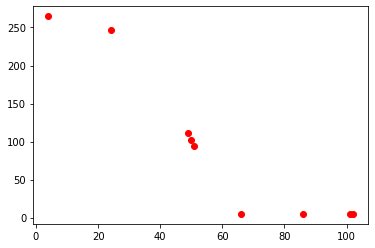

rewaRD::  -96.13597658351969
stepping:  10
Temperature:  [  4.  24.  49.  50.  51.  66.  86. 101. 102. 103.]
ORDER PARAM RESULT (X2): 73.79118736260016
THE JT RESULT {X0}: 1.9998373913243386
THE NF RESULT {X1}: 221.86212587401218
THE BK RESULT {X3}: 2.3406277890299525
chisqds:  88.42666056591996


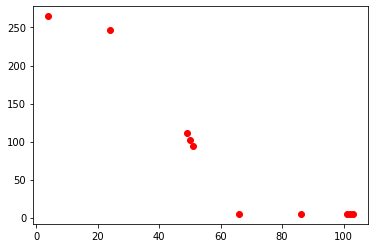

rewaRD::  -95.47647737186898
stepping:  10
Temperature:  [  4.  24.  49.  50.  51.  66.  86. 101. 102. 103. 113.]
ORDER PARAM RESULT (X2): 73.79426403862776
THE JT RESULT {X0}: 1.9998737345892963
THE NF RESULT {X1}: 221.854590759189
THE BK RESULT {X3}: 2.7379840990900792
chisqds:  76.97191259191959


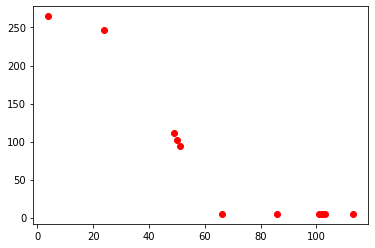

rewaRD::  -94.80329919667358
stepping:  10
Temperature:  [  4.  24.  49.  50.  51.  66.  86. 101. 102. 103. 113. 143.]
ORDER PARAM RESULT (X2): 73.79869072377377
THE JT RESULT {X0}: 1.9999786744785617
THE NF RESULT {X1}: 221.86767980366753
THE BK RESULT {X3}: 3.022734556455856
chisqds:  68.13290381733965


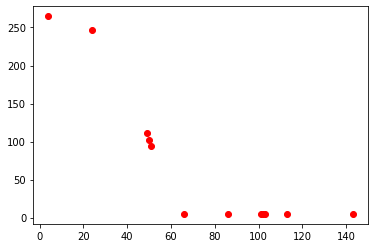

rewaRD::  -94.12912150240393
stepping:  10
Temperature:  [  4.  24.  49.  50.  51.  66.  86. 101. 102. 103. 113. 143. 173.]
ORDER PARAM RESULT (X2): 73.80517514074022
THE JT RESULT {X0}: 1.999868649129379
THE NF RESULT {X1}: 221.9040765268557
THE BK RESULT {X3}: 3.2375165354383952
chisqds:  61.14660777507012


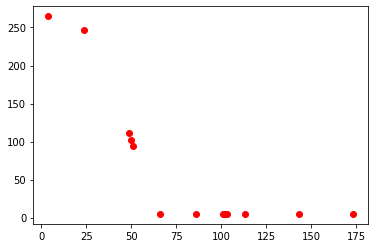

rewaRD::  -93.45834520417856
stepping:  10
Temperature:  [  4.  24.  49.  50.  51.  66.  86. 101. 102. 103. 113. 143. 173. 183.]
ORDER PARAM RESULT (X2): 73.79684480618748
THE JT RESULT {X0}: 1.9998982216976853
THE NF RESULT {X1}: 221.8203075142628
THE BK RESULT {X3}: 3.3959172773429116
chisqds:  55.209910943200285


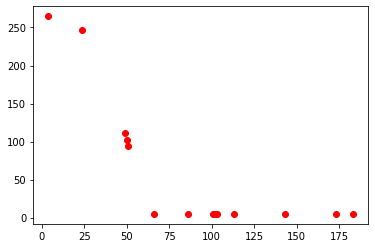

rewaRD::  -92.75492401334394
stepping:  10
Temperature:  [  4.  24.  49.  50.  51.  66.  86. 101. 102. 103. 113. 143. 173. 183.
 208.]
ORDER PARAM RESULT (X2): 73.80441212818168
THE JT RESULT {X0}: 1.999882697476358
THE NF RESULT {X1}: 221.87265983897086
THE BK RESULT {X3}: 3.5308619583165597
chisqds:  50.542044181117575


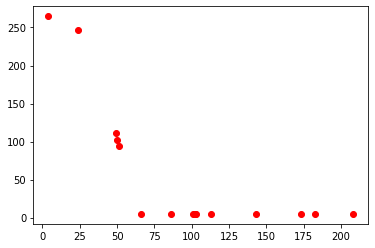

rewaRD::  -92.08579695418335
stepping:  10
Temperature:  [  4.  24.  49.  50.  51.  66.  86. 101. 102. 103. 113. 143. 173. 183.
 208. 228.]
ORDER PARAM RESULT (X2): 73.80960488422593
THE JT RESULT {X0}: 1.9999138681438025
THE NF RESULT {X1}: 221.9072477484871
THE BK RESULT {X3}: 3.6401029428890945
chisqds:  46.57867194700622


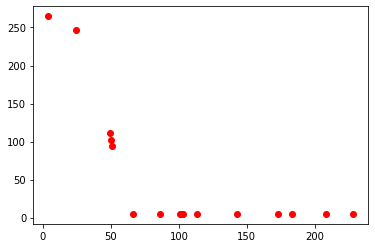

rewaRD::  -91.41237859990747
stepping:  10
Temperature:  [  4.  24.  49.  50.  51.  66.  86. 101. 102. 103. 113. 143. 173. 183.
 208. 228. 229.]
ORDER PARAM RESULT (X2): 73.81201013470843
THE JT RESULT {X0}: 1.9998665914140532
THE NF RESULT {X1}: 221.91994350593714
THE BK RESULT {X3}: 3.729912975476181
chisqds:  43.16218410799979


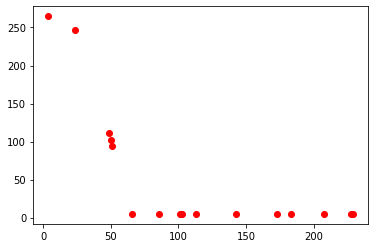

rewaRD::  -90.73262838138298
stepping:  10
Temperature:  [  4.  24.  49.  50.  51.  66.  86. 101. 102. 103. 113. 143. 173. 183.
 208. 228. 229. 230.]
ORDER PARAM RESULT (X2): 73.81129577987235
THE JT RESULT {X0}: 1.9999482983524954
THE NF RESULT {X1}: 221.90755032080295
THE BK RESULT {X3}: 3.804651671362163
chisqds:  40.17549235634159


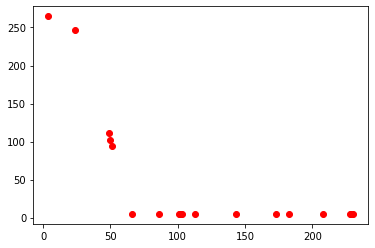

rewaRD::  -90.0436814450922
stepping:  10
Temperature:  [  4.  24.  49.  50.  51.  66.  86. 101. 102. 103. 113. 143. 173. 183.
 208. 228. 229. 230. 240.]
ORDER PARAM RESULT (X2): 73.81208554487617
THE JT RESULT {X0}: 1.9999711074682482
THE NF RESULT {X1}: 221.90873706683197
THE BK RESULT {X3}: 3.869258351604009
chisqds:  37.5904646768146


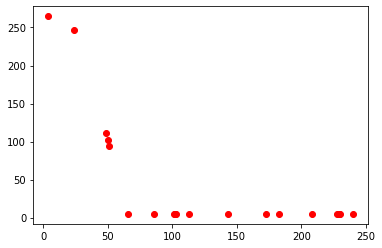

rewaRD::  -89.35900358138653
stepping:  10
Temperature:  [  4.  24.  49.  50.  51.  66.  86. 101. 102. 103. 113. 143. 173. 183.
 208. 228. 229. 230. 240. 265.]
ORDER PARAM RESULT (X2): 73.81526053803972
THE JT RESULT {X0}: 1.9998350041025017
THE NF RESULT {X1}: 221.9307676785829
THE BK RESULT {X3}: 3.9260598955322514
chisqds:  35.344472160174746


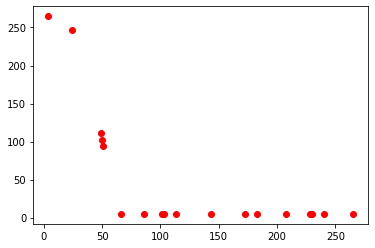

rewaRD::  -88.68281302413367
stepping:  10
Temperature:  [  4.  24.  49.  50.  51.  66.  86. 101. 102. 103. 113. 143. 173. 183.
 208. 228. 229. 230. 240. 265. 275.]
ORDER PARAM RESULT (X2): 73.81534930875071
THE JT RESULT {X0}: 1.999837782033069
THE NF RESULT {X1}: 221.92738864288478
THE BK RESULT {X3}: 3.9747620330661713
chisqds:  33.32284292425237


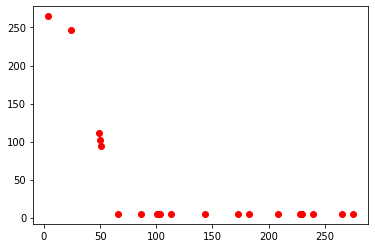

rewaRD::  -87.99622226383092
stepping:  10
Temperature:  [  4.  24.  49.  50.  51.  66.  86. 101. 102. 103. 113. 143. 173. 183.
 208. 228. 229. 230. 240. 265. 275. 290.]
ORDER PARAM RESULT (X2): 73.81445389349244
THE JT RESULT {X0}: 1.9999054407741326
THE NF RESULT {X1}: 221.9161881149885
THE BK RESULT {X3}: 4.017435653491319
chisqds:  31.50987230064762


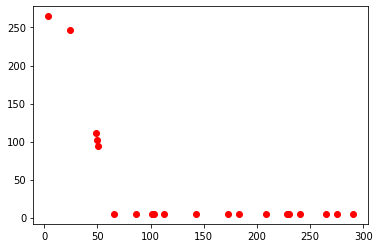

rewaRD::  -87.30556581812047
stepping:  10
Temperature:  [  4.  24.  49.  50.  51.  66.  86. 101. 102. 103. 113. 143. 173. 183.
 208. 228. 229. 230. 240. 265. 275. 290. 300.]
ORDER PARAM RESULT (X2): 73.8148363280976
THE JT RESULT {X0}: 1.9998190528106594
THE NF RESULT {X1}: 221.91617155288307
THE BK RESULT {X3}: 4.055728357562299
chisqds:  29.895167918082542


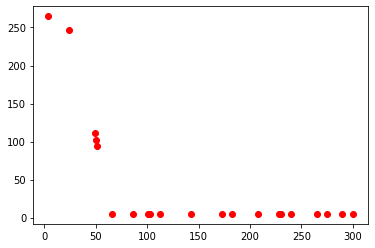

rewaRD::  -86.61991124799624
stepping:  10
Temperature:  [  4.  24.  49.  50.  51.  66.  86. 101. 102. 103. 113. 143. 173. 183.
 208. 228. 229. 230. 240. 265. 275. 290. 300. 301.]
ORDER PARAM RESULT (X2): 73.81678485802692
THE JT RESULT {X0}: 1.9998125465004581
THE NF RESULT {X1}: 221.92972060091554
THE BK RESULT {X3}: 4.090407334043948
chisqds:  28.450687125981993


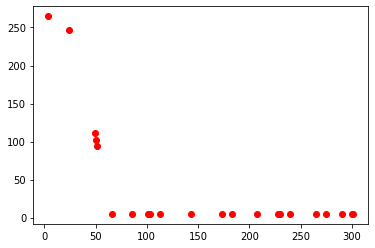

rewaRD::  -85.94058560945236
--------------------------------------
| approxkl           | 3.2740107e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 11            |
| ep_reward_mean     | 538           |
| explained_variance | -0.000104     |
| fps                | 6             |
| n_updates          | 1             |
| policy_entropy     | 1.945848      |
| policy_loss        | -0.0015495233 |
| serial_timesteps   | 128           |
| time_elapsed       | 1.91e-05      |
| total_timesteps    | 128           |
| value_loss         | 216795.52     |
--------------------------------------
stepping:  10
Temperature:  [  4.  24.  49.  50.  51.  66.  86. 101. 102. 103. 113. 143. 173. 183.
 208. 228. 229. 230. 240. 265. 275. 290. 300. 301. 321.]
ORDER PARAM RESULT (X2): 73.74634812846466
THE JT RESULT {X0}: 1.9999198138364778
THE NF RESULT {X1}: 221.33459928958956
THE BK RESULT {X3}: 4.10318615327824
chisqds:  26.56291049542011


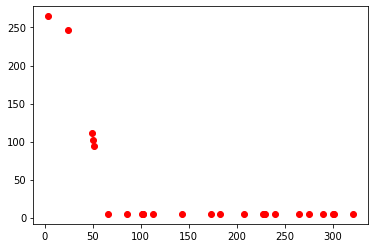

rewaRD::  -84.9414091852259
stepping:  10
Temperature:  [  4.  24.  49.  50.  51.  66.  86. 101. 102. 103. 113. 143. 173. 183.
 208. 228. 229. 230. 240. 265. 275. 290. 300. 301. 321. 336.]
ORDER PARAM RESULT (X2): 73.81593465384574
THE JT RESULT {X0}: 1.9999468594055643
THE NF RESULT {X1}: 221.91774163282057
THE BK RESULT {X3}: 4.148676138049805
chisqds:  25.90967929711487


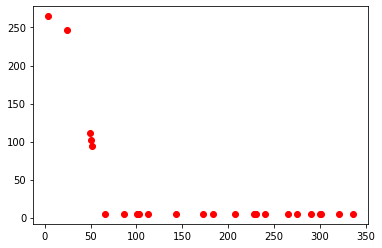

rewaRD::  -84.56175410690855
stepping:  10
Temperature:  [  4.  24.  49.  50.  51.  66.  86. 101. 102. 103. 113. 143. 173. 183.
 208. 228. 229. 230. 240. 265. 275. 290. 300. 301. 321. 336. 361.]
ORDER PARAM RESULT (X2): 73.80707785675125
THE JT RESULT {X0}: 1.9999233026299914
THE NF RESULT {X1}: 221.84082103533441
THE BK RESULT {X3}: 4.171909142983515
chisqds:  24.740276236536793


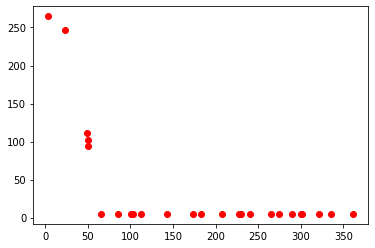

rewaRD::  -83.83203177783139
terminated: over max temp
reset
fixed Tn:  70
fixed Jt:  1.4
fixed Nf:  290
fixed Bk:  3.0
start Tn:  58
start Jt:  1.24
start Nf:  288
start Bk:  3.1
stepping:  11
Temperature:  [13.]
rewaRD::  -100
stepping:  11
Temperature:  [13. 38.]
rewaRD::  -100
stepping:  11
Temperature:  [13. 38. 58.]
rewaRD::  -100
stepping:  11
Temperature:  [13. 38. 58. 83.]
rewaRD::  -100
stepping:  11
Temperature:  [13. 38. 58. 83. 88.]
ORDER PARAM RESULT (X2): 69.9999999999644
THE JT RESULT {X0}: 1.4000000000002433
THE NF RESULT {X1}: 289.99999999999864
THE BK RESULT {X3}: 3.0
chisqds:  5.50074511376236e-22


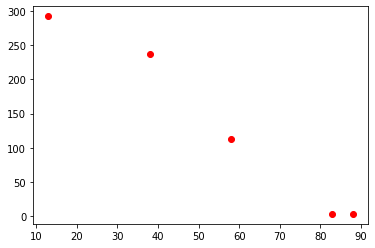

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  250
fixed Jt:  0.8
fixed Nf:  270
fixed Bk:  5.4
start Tn:  230
start Jt:  1.02
start Nf:  282
start Bk:  5.58
stepping:  12
Temperature:  [8.]
rewaRD::  -100
stepping:  12
Temperature:  [ 8. 28.]
rewaRD::  -100
stepping:  12
Temperature:  [ 8. 28. 43.]
rewaRD::  -100
stepping:  12
Temperature:  [ 8. 28. 43. 73.]
rewaRD::  -100
stepping:  12
Temperature:  [ 8. 28. 43. 73. 98.]
ORDER PARAM RESULT (X2): 249.99999999820034
THE JT RESULT {X0}: 0.799999999988366
THE NF RESULT {X1}: 269.99999999507133
THE BK RESULT {X3}: 5.400000004928617
chisqds:  1.2331267847353957e-25


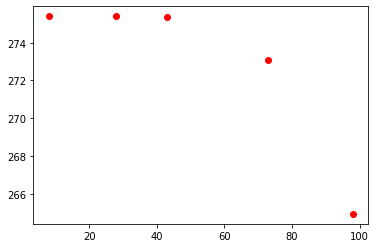

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  240
fixed Jt:  0.8
fixed Nf:  420
fixed Bk:  3.0
start Tn:  222
start Jt:  1.02
start Nf:  422
start Bk:  2.8
stepping:  13
Temperature:  [33.]
rewaRD::  -100
stepping:  13
Temperature:  [33. 34.]
rewaRD::  -100
stepping:  13
Temperature:  [33. 34. 54.]
rewaRD::  -100
stepping:  13
Temperature:  [33. 34. 54. 64.]
rewaRD::  -100
stepping:  13
Temperature:  [33. 34. 54. 64. 94.]
ORDER PARAM RESULT (X2): 239.99999999772402
THE JT RESULT {X0}: 0.799999999984476
THE NF RESULT {X1}: 419.99999998997777
THE BK RESULT {X3}: 3.0000000100224855
chisqds:  2.5353269395108815e-25


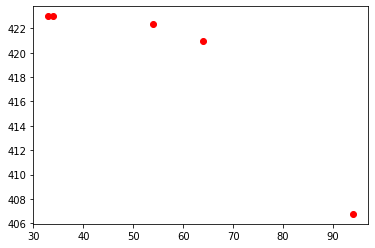

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  80
fixed Jt:  0.9
fixed Nf:  290
fixed Bk:  6.8
start Tn:  90
start Jt:  0.84
start Nf:  290
start Bk:  6.82
stepping:  14
Temperature:  [4.]
rewaRD::  -100
stepping:  14
Temperature:  [4. 5.]
rewaRD::  -100
stepping:  14
Temperature:  [ 4.  5. 20.]
rewaRD::  -100
stepping:  14
Temperature:  [ 4.  5. 20. 21.]
rewaRD::  -100
stepping:  14
Temperature:  [ 4.  5. 20. 21. 41.]
ORDER PARAM RESULT (X2): 80.00000000019637
THE JT RESULT {X0}: 0.9000000000042346
THE NF RESULT {X1}: 290.000000001796
THE BK RESULT {X3}: 6.799999998203995
chisqds:  3.054615304715098e-27


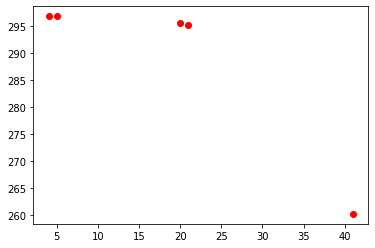

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  80
fixed Jt:  1.3
fixed Nf:  400
fixed Bk:  6.4
start Tn:  66
start Jt:  1.2
start Nf:  406
start Bk:  6.28
stepping:  15
Temperature:  [28.]
rewaRD::  -100
stepping:  15
Temperature:  [28. 33.]
rewaRD::  -100
stepping:  15
Temperature:  [28. 33. 63.]
rewaRD::  -100
stepping:  15
Temperature:  [28. 33. 63. 93.]
rewaRD::  -100
stepping:  15
Temperature:  [ 28.  33.  63.  93. 113.]
ORDER PARAM RESULT (X2): 79.99999999995174
THE JT RESULT {X0}: 1.3000000000001064
THE NF RESULT {X1}: 399.9999999999901
THE BK RESULT {X3}: 6.4
chisqds:  6.774942974660499e-22


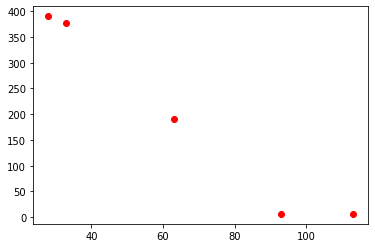

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  70
fixed Jt:  1.2
fixed Nf:  130
fixed Bk:  6.4
start Tn:  72
start Jt:  0.98
start Nf:  110
start Bk:  6.46
stepping:  16
Temperature:  [23.]
rewaRD::  -100
stepping:  16
Temperature:  [23. 38.]
rewaRD::  -100
stepping:  16
Temperature:  [23. 38. 39.]
rewaRD::  -100
stepping:  16
Temperature:  [23. 38. 39. 59.]
rewaRD::  -100
stepping:  16
Temperature:  [23. 38. 39. 59. 64.]
ORDER PARAM RESULT (X2): 69.47517091149206
THE JT RESULT {X0}: 0.9541110336526771
THE NF RESULT {X1}: 125.94812009575611
THE BK RESULT {X3}: 7.999255242584328
chisqds:  0.021807450564000873


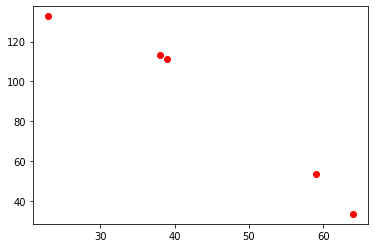

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  80
fixed Jt:  1.4
fixed Nf:  390
fixed Bk:  5.8
start Tn:  64
start Jt:  1.28
start Nf:  406
start Bk:  5.8
stepping:  17
Temperature:  [28.]
rewaRD::  -100
stepping:  17
Temperature:  [28. 53.]
rewaRD::  -100
stepping:  17
Temperature:  [28. 53. 58.]
rewaRD::  -100
stepping:  17
Temperature:  [28. 53. 58. 78.]
rewaRD::  -100
stepping:  17
Temperature:  [ 28.  53.  58.  78. 108.]
ORDER PARAM RESULT (X2): 66.89153377846696
THE JT RESULT {X0}: 0.42895141569890616
THE NF RESULT {X1}: 422.3160145198491
THE BK RESULT {X3}: 7.999692935318252
chisqds:  42.40019293733704


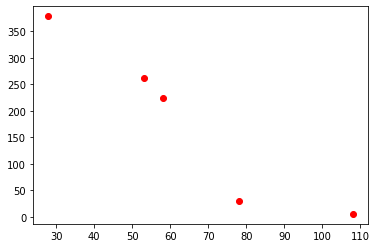

rewaRD::  -90.56608066403949
stepping:  17
Temperature:  [ 28.  53.  58.  78. 108. 128.]
ORDER PARAM RESULT (X2): 80.00000000002862
THE JT RESULT {X0}: 1.4000000000000699
THE NF RESULT {X1}: 390.00000000000693
THE BK RESULT {X3}: 5.8
chisqds:  1.8927625001347848e-21


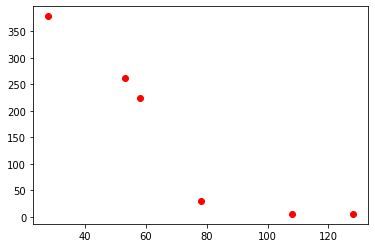

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  80
fixed Jt:  1.4
fixed Nf:  240
fixed Bk:  6.6
start Tn:  92
start Jt:  1.4
start Nf:  248
start Bk:  6.4
stepping:  18
Temperature:  [23.]
rewaRD::  -100
stepping:  18
Temperature:  [23. 33.]
rewaRD::  -100
stepping:  18
Temperature:  [23. 33. 48.]
rewaRD::  -100
stepping:  18
Temperature:  [23. 33. 48. 63.]
rewaRD::  -100
stepping:  18
Temperature:  [23. 33. 48. 63. 73.]
ORDER PARAM RESULT (X2): 89.49612406003585
THE JT RESULT {X0}: 1.804028297896415
THE NF RESULT {X1}: 241.28551124944664
THE BK RESULT {X3}: 0.10001088137499539
chisqds:  29.029240910619194


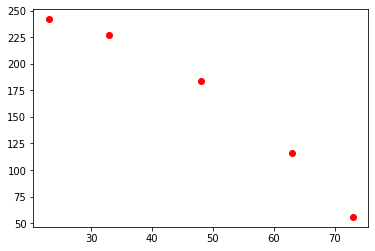

rewaRD::  -86.22079022901092
stepping:  18
Temperature:  [23. 33. 48. 63. 73. 83.]
ORDER PARAM RESULT (X2): 90.69992205788631
THE JT RESULT {X0}: 1.8946363325932325
THE NF RESULT {X1}: 236.5933710154954
THE BK RESULT {X3}: 0.10000986294185046
chisqds:  124.66160551814045


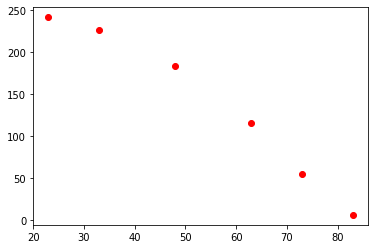

rewaRD::  -96.79131358578731
stepping:  18
Temperature:  [ 23.  33.  48.  63.  73.  83. 113.]
ORDER PARAM RESULT (X2): 90.33285164938685
THE JT RESULT {X0}: 1.9998609069026587
THE NF RESULT {X1}: 233.71659576284208
THE BK RESULT {X3}: 2.1319429894976607
chisqds:  80.38520922903244


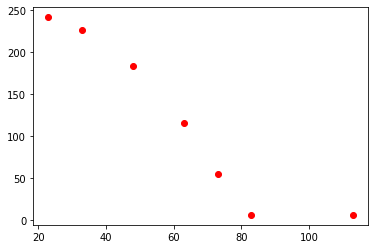

rewaRD::  -95.02396020566016
stepping:  18
Temperature:  [ 23.  33.  48.  63.  73.  83. 113. 138.]
ORDER PARAM RESULT (X2): 90.34260292971607
THE JT RESULT {X0}: 1.999863490399519
THE NF RESULT {X1}: 233.70176995250154
THE BK RESULT {X3}: 3.520026299435032
chisqds:  64.91809247595634


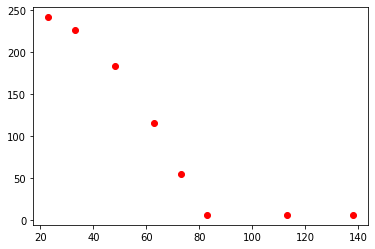

rewaRD::  -93.83838950369424
stepping:  18
Temperature:  [ 23.  33.  48.  63.  73.  83. 113. 138. 168.]
ORDER PARAM RESULT (X2): 90.34926080503894
THE JT RESULT {X0}: 1.9998382225414957
THE NF RESULT {X1}: 233.7093202815294
THE BK RESULT {X3}: 4.234083661465497
chisqds:  53.879995547025814


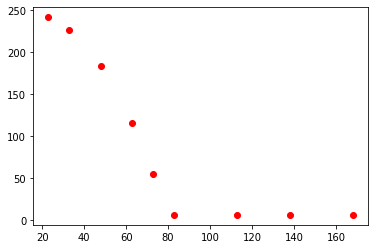

rewaRD::  -92.5760944124265
stepping:  18
Temperature:  [ 23.  33.  48.  63.  73.  83. 113. 138. 168. 198.]
ORDER PARAM RESULT (X2): 90.35210814847595
THE JT RESULT {X0}: 1.999842562027235
THE NF RESULT {X1}: 233.7051485928493
THE BK RESULT {X3}: 4.665370252611117
chisqds:  45.86651938814156


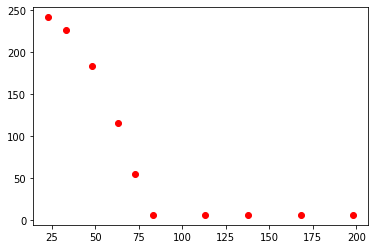

rewaRD::  -91.27904176431977
stepping:  18
Temperature:  [ 23.  33.  48.  63.  73.  83. 113. 138. 168. 198. 223.]
ORDER PARAM RESULT (X2): 90.34526019002453
THE JT RESULT {X0}: 1.9998451292167565
THE NF RESULT {X1}: 233.63741515290613
THE BK RESULT {X3}: 4.948190126721413
chisqds:  39.75143827303941


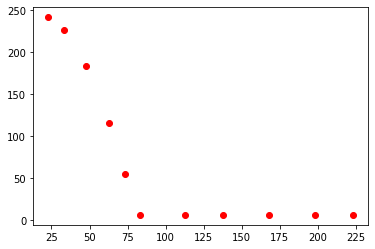

rewaRD::  -89.93747101041897
stepping:  18
Temperature:  [ 23.  33.  48.  63.  73.  83. 113. 138. 168. 198. 223. 243.]
ORDER PARAM RESULT (X2): 90.35568863352461
THE JT RESULT {X0}: 1.9998128353754774
THE NF RESULT {X1}: 233.70298070771088
THE BK RESULT {X3}: 5.163998767122518
chisqds:  35.24400904963166


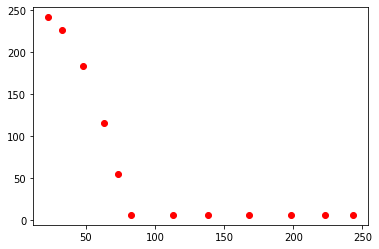

rewaRD::  -88.65055336251027
stepping:  18
Temperature:  [ 23.  33.  48.  63.  73.  83. 113. 138. 168. 198. 223. 243. 263.]
ORDER PARAM RESULT (X2): 90.35712304659423
THE JT RESULT {X0}: 1.9998157856834589
THE NF RESULT {X1}: 233.70464087193315
THE BK RESULT {X3}: 5.3210869704320105
chisqds:  31.567905399784213


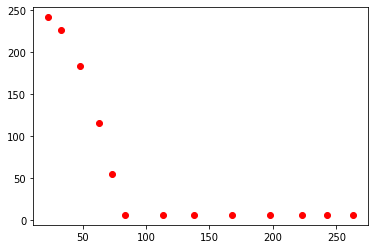

rewaRD::  -87.32890272780867
stepping:  18
Temperature:  [ 23.  33.  48.  63.  73.  83. 113. 138. 168. 198. 223. 243. 263. 273.]
ORDER PARAM RESULT (X2): 90.35940325266868
THE JT RESULT {X0}: 1.9998016110322254
THE NF RESULT {X1}: 233.7146471846915
THE BK RESULT {X3}: 5.444225391219122
chisqds:  28.590892776531014


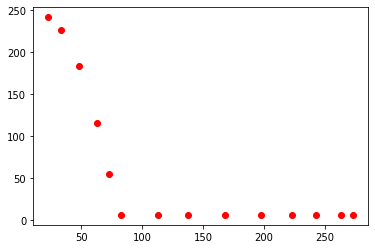

rewaRD::  -86.00953096755543
stepping:  18
Temperature:  [ 23.  33.  48.  63.  73.  83. 113. 138. 168. 198. 223. 243. 263. 273.
 293.]
ORDER PARAM RESULT (X2): 90.35958329757821
THE JT RESULT {X0}: 1.9999224784564615
THE NF RESULT {X1}: 233.71034576574738
THE BK RESULT {X3}: 5.542010741743777
chisqds:  26.107828265813307


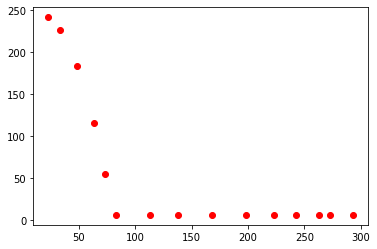

rewaRD::  -84.67892480648125
stepping:  18
Temperature:  [ 23.  33.  48.  63.  73.  83. 113. 138. 168. 198. 223. 243. 263. 273.
 293. 298.]
ORDER PARAM RESULT (X2): 90.3602482883249
THE JT RESULT {X0}: 1.9999468031089382
THE NF RESULT {X1}: 233.71069747574379
THE BK RESULT {X3}: 5.6224353446682205
chisqds:  24.024038738722364


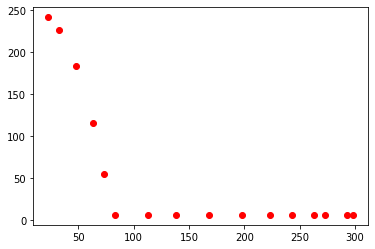

rewaRD::  -83.35001019810741
stepping:  18
Temperature:  [ 23.  33.  48.  63.  73.  83. 113. 138. 168. 198. 223. 243. 263. 273.
 293. 298. 328.]
ORDER PARAM RESULT (X2): 90.358992247905
THE JT RESULT {X0}: 1.9999037565920803
THE NF RESULT {X1}: 233.6974033174545
THE BK RESULT {X3}: 5.688818684871877
chisqds:  22.23411114612221


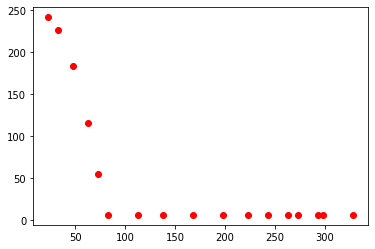

rewaRD::  -82.00962487903354
stepping:  18
Temperature:  [ 23.  33.  48.  63.  73.  83. 113. 138. 168. 198. 223. 243. 263. 273.
 293. 298. 328. 348.]
ORDER PARAM RESULT (X2): 90.36047507745317
THE JT RESULT {X0}: 1.9998011021421709
THE NF RESULT {X1}: 233.70524697966113
THE BK RESULT {X3}: 5.746059145040833
chisqds:  20.70911997468301


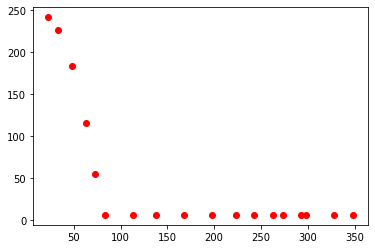

rewaRD::  -80.6848383471146
terminated: over max temp
reset
fixed Tn:  210
fixed Jt:  0.8
fixed Nf:  300
fixed Bk:  3.0
start Tn:  200
start Jt:  0.52
start Nf:  318
start Bk:  2.86
stepping:  19
Temperature:  [8.]
rewaRD::  -100
stepping:  19
Temperature:  [ 8. 23.]
rewaRD::  -100
stepping:  19
Temperature:  [ 8. 23. 33.]
rewaRD::  -100
stepping:  19
Temperature:  [ 8. 23. 33. 43.]
rewaRD::  -100
stepping:  19
Temperature:  [ 8. 23. 33. 43. 44.]
ORDER PARAM RESULT (X2): 145.5194426397799
THE JT RESULT {X0}: 1.3404709842282616
THE NF RESULT {X1}: 315.2473781122173
THE BK RESULT {X3}: 0.10001481233701222
chisqds:  1.591257401837419


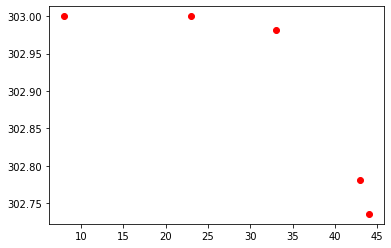

rewaRD::  151.37353613445663
stepping:  19
Temperature:  [ 8. 23. 33. 43. 44. 54.]
ORDER PARAM RESULT (X2): 125.60333307475521
THE JT RESULT {X0}: 1.4068437510020708
THE NF RESULT {X1}: 315.1606057588851
THE BK RESULT {X3}: 0.10001058578666212
chisqds:  1.0206338566739324


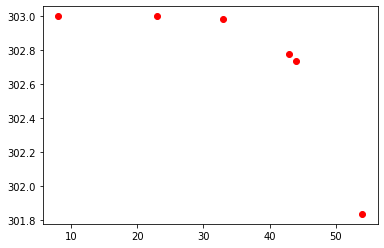

rewaRD::  291.9133167926941
stepping:  19
Temperature:  [ 8. 23. 33. 43. 44. 54. 64.]
ORDER PARAM RESULT (X2): 174.8344759896802
THE JT RESULT {X0}: 0.9279040708310334
THE NF RESULT {X1}: 315.2376003617271
THE BK RESULT {X3}: 0.10001010227584843
chisqds:  0.8939481001564563


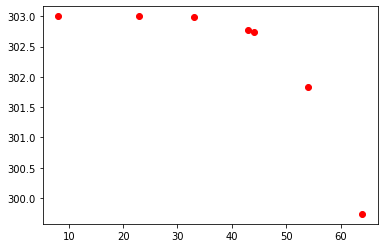

rewaRD::  300
stepping:  19
Temperature:  [ 8. 23. 33. 43. 44. 54. 64. 65.]
ORDER PARAM RESULT (X2): 177.92807814092106
THE JT RESULT {X0}: 0.8799904750305659
THE NF RESULT {X1}: 315.2372231067455
THE BK RESULT {X3}: 0.10001158742934932
chisqds:  0.7371968529264306


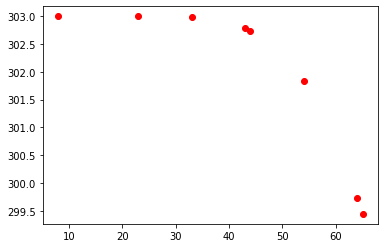

rewaRD::  300
stepping:  19
Temperature:  [ 8. 23. 33. 43. 44. 54. 64. 65. 90.]
ORDER PARAM RESULT (X2): 192.49241480983855
THE JT RESULT {X0}: 0.6940722486051876
THE NF RESULT {X1}: 315.216864434833
THE BK RESULT {X3}: 0.10000292386471375
chisqds:  0.7735783535748856


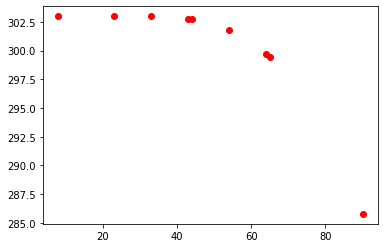

rewaRD::  300
stepping:  19
Temperature:  [  8.  23.  33.  43.  44.  54.  64.  65.  90. 115.]
ORDER PARAM RESULT (X2): 210.00000000003226
THE JT RESULT {X0}: 0.8000000000002399
THE NF RESULT {X1}: 300.00000000012443
THE BK RESULT {X3}: 2.9999999998755786
chisqds:  5.764887217353827e-29


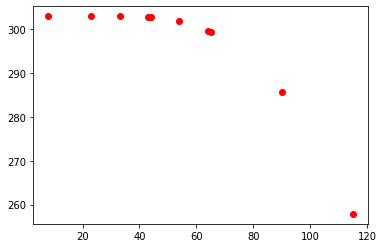

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  250
fixed Jt:  1.2
fixed Nf:  360
fixed Bk:  4.2
start Tn:  242
start Jt:  1.36
start Nf:  360
start Bk:  4.18
stepping:  20
Temperature:  [13.]
rewaRD::  -100
stepping:  20
Temperature:  [13. 43.]
rewaRD::  -100
stepping:  20
Temperature:  [13. 43. 68.]
rewaRD::  -100
stepping:  20
Temperature:  [13. 43. 68. 83.]
rewaRD::  -100
stepping:  20
Temperature:  [13. 43. 68. 83. 98.]
ORDER PARAM RESULT (X2): 250.00000000099826
THE JT RESULT {X0}: 1.2000000000060498
THE NF RESULT {X1}: 360.00000000311604
THE BK RESULT {X3}: 4.199999996884078
chisqds:  5.1700390127471275e-24


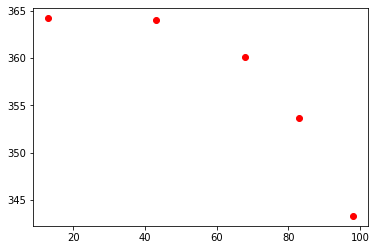

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  140
fixed Jt:  1.3
fixed Nf:  450
fixed Bk:  5.2
start Tn:  120
start Jt:  1.54
start Nf:  466
start Bk:  5.14
stepping:  21
Temperature:  [23.]
rewaRD::  -100
stepping:  21
Temperature:  [23. 53.]
rewaRD::  -100
stepping:  21
Temperature:  [23. 53. 78.]
rewaRD::  -100
stepping:  21
Temperature:  [23. 53. 78. 93.]
rewaRD::  -100
stepping:  21
Temperature:  [23. 53. 78. 93. 94.]
ORDER PARAM RESULT (X2): 120.94199898539546
THE JT RESULT {X0}: 1.409894036727193
THE NF RESULT {X1}: 468.81652570572845
THE BK RESULT {X3}: 7.999983703920409
chisqds:  35.0031567786375


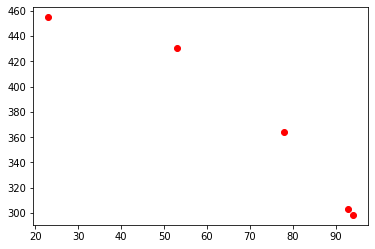

rewaRD::  -88.5724592633279
stepping:  21
Temperature:  [23. 53. 78. 93. 94. 99.]
ORDER PARAM RESULT (X2): 120.77909292374737
THE JT RESULT {X0}: 1.4157077218062464
THE NF RESULT {X1}: 469.0512518482047
THE BK RESULT {X3}: 7.999331251334385
chisqds:  29.935082875103355


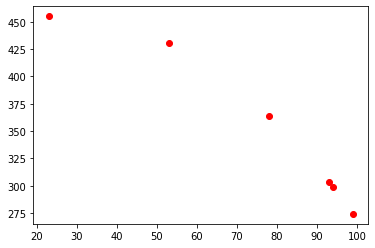

rewaRD::  -86.63775204268183
stepping:  21
Temperature:  [ 23.  53.  78.  93.  94.  99. 109.]
ORDER PARAM RESULT (X2): 120.64208061172127
THE JT RESULT {X0}: 1.4212493782475775
THE NF RESULT {X1}: 469.0389035664372
THE BK RESULT {X3}: 7.999413965637347
chisqds:  37.82240403418851


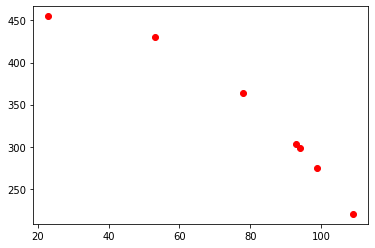

rewaRD::  -89.42425765325676
stepping:  21
Temperature:  [ 23.  53.  78.  93.  94.  99. 109. 139.]
ORDER PARAM RESULT (X2): 122.08357821958607
THE JT RESULT {X0}: 1.1888337734940608
THE NF RESULT {X1}: 474.9299441948502
THE BK RESULT {X3}: 7.999463929717434
chisqds:  18.846456354134794


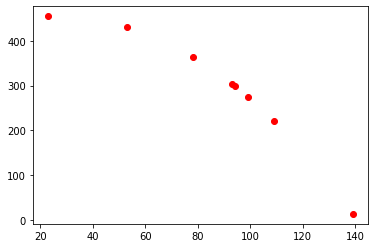

rewaRD::  -78.77585088232024
stepping:  21
Temperature:  [ 23.  53.  78.  93.  94.  99. 109. 139. 164.]
ORDER PARAM RESULT (X2): 139.99999999999957
THE JT RESULT {X0}: 1.2999999999998717
THE NF RESULT {X1}: 449.999999999999
THE BK RESULT {X3}: 5.2
chisqds:  1.7380042868552796e-24


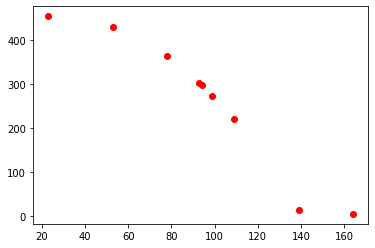

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  140
fixed Jt:  1.4
fixed Nf:  350
fixed Bk:  4.2
start Tn:  122
start Jt:  1.56
start Nf:  368
start Bk:  4.36
stepping:  22
Temperature:  [4.]
rewaRD::  -100
stepping:  22
Temperature:  [ 4. 19.]
rewaRD::  -100
stepping:  22
Temperature:  [ 4. 19. 34.]
rewaRD::  -100
stepping:  22
Temperature:  [ 4. 19. 34. 59.]
rewaRD::  -100
stepping:  22
Temperature:  [ 4. 19. 34. 59. 74.]
ORDER PARAM RESULT (X2): 127.69751838422229
THE JT RESULT {X0}: 1.1910377625745536
THE NF RESULT {X1}: 361.6492975954286
THE BK RESULT {X3}: 0.10000072141123638
chisqds:  0.7255500511844701


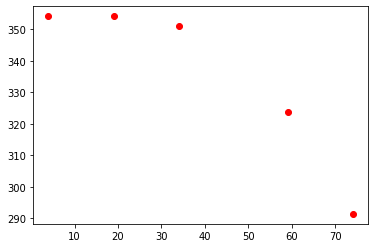

rewaRD::  300
stepping:  22
Temperature:  [  4.  19.  34.  59.  74. 104.]
ORDER PARAM RESULT (X2): 140.00000000020526
THE JT RESULT {X0}: 1.4000000000014827
THE NF RESULT {X1}: 350.00000000096327
THE BK RESULT {X3}: 4.199999999036995
chisqds:  7.053627067059534e-23


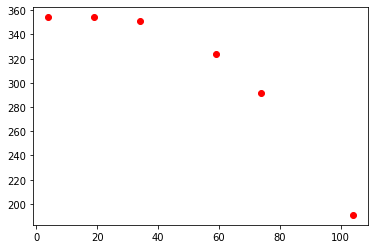

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  220
fixed Jt:  1.4
fixed Nf:  360
fixed Bk:  3.0
start Tn:  200
start Jt:  1.3
start Nf:  378
start Bk:  2.82
stepping:  23
Temperature:  [18.]
rewaRD::  -100
stepping:  23
Temperature:  [18. 38.]
rewaRD::  -100
stepping:  23
Temperature:  [18. 38. 68.]
rewaRD::  -100
stepping:  23
Temperature:  [18. 38. 68. 69.]
rewaRD::  -100
stepping:  23
Temperature:  [18. 38. 68. 69. 99.]
ORDER PARAM RESULT (X2): 198.63775227689675
THE JT RESULT {X0}: 1.3639569186471598
THE NF RESULT {X1}: 375.0568837917682
THE BK RESULT {X3}: 0.10001458822603236
chisqds:  1.1134179144399297


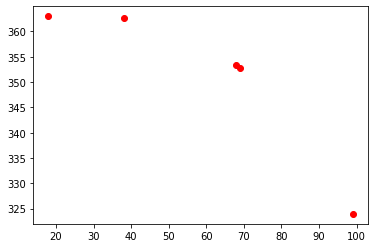

rewaRD::  259.2541442098204
stepping:  23
Temperature:  [ 18.  38.  68.  69.  99. 119.]
ORDER PARAM RESULT (X2): 201.40977882724678
THE JT RESULT {X0}: 1.2893704804904924
THE NF RESULT {X1}: 374.608844874004
THE BK RESULT {X3}: 0.10000402040260273
chisqds:  0.7055502839718606


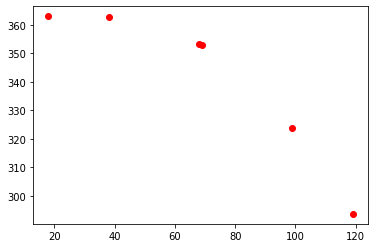

rewaRD::  300
stepping:  23
Temperature:  [ 18.  38.  68.  69.  99. 119. 149.]
ORDER PARAM RESULT (X2): 205.7548674931383
THE JT RESULT {X0}: 1.147411058330544
THE NF RESULT {X1}: 371.96941249618754
THE BK RESULT {X3}: 0.10000302418544316
chisqds:  0.6394336946833862


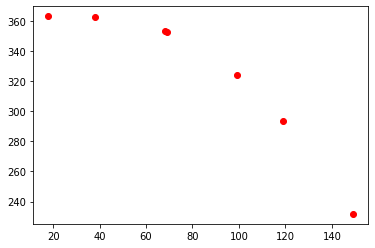

rewaRD::  300
stepping:  23
Temperature:  [ 18.  38.  68.  69.  99. 119. 149. 179.]
ORDER PARAM RESULT (X2): 219.99999999994498
THE JT RESULT {X0}: 1.399999999999812
THE NF RESULT {X1}: 359.99999999985107
THE BK RESULT {X3}: 3.000000000148869
chisqds:  5.0814672954896664e-24


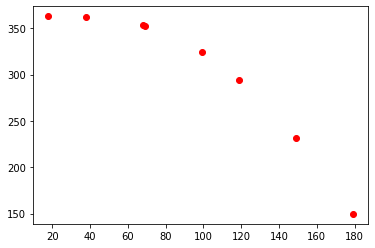

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  80
fixed Jt:  1.4
fixed Nf:  340
fixed Bk:  6.8
start Tn:  86
start Jt:  1.64
start Nf:  328
start Bk:  6.98
stepping:  24
Temperature:  [28.]
rewaRD::  -100
stepping:  24
Temperature:  [28. 33.]
rewaRD::  -100
stepping:  24
Temperature:  [28. 33. 63.]
rewaRD::  -100
stepping:  24
Temperature:  [28. 33. 63. 78.]
rewaRD::  -100
stepping:  24
Temperature:  [28. 33. 63. 78. 98.]
ORDER PARAM RESULT (X2): 79.99999999999888
THE JT RESULT {X0}: 1.4000000000000064
THE NF RESULT {X1}: 339.9999999999998
THE BK RESULT {X3}: 6.8
chisqds:  2.9901558560118238e-24


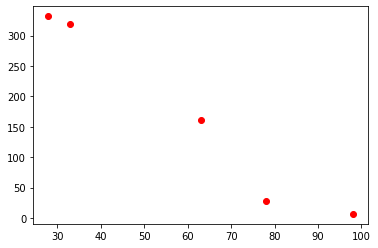

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  190
fixed Jt:  0.7
fixed Nf:  210
fixed Bk:  7.4
start Tn:  204
start Jt:  0.94
start Nf:  226
start Bk:  7.24
stepping:  25
Temperature:  [8.]
rewaRD::  -100
stepping:  25
Temperature:  [ 8. 38.]
rewaRD::  -100
stepping:  25
Temperature:  [ 8. 38. 43.]
rewaRD::  -100
stepping:  25
Temperature:  [ 8. 38. 43. 63.]
rewaRD::  -100
stepping:  25
Temperature:  [ 8. 38. 43. 63. 83.]
ORDER PARAM RESULT (X2): 190.00000000114255
THE JT RESULT {X0}: 0.7000000000078956
THE NF RESULT {X1}: 210.00000000335461
THE BK RESULT {X3}: 7.399999996645447
chisqds:  3.2150569994525417e-24


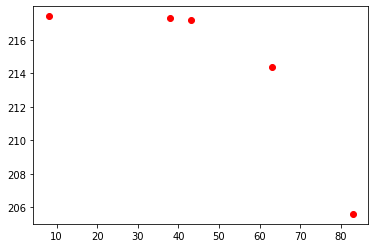

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  60
fixed Jt:  1.1
fixed Nf:  230
fixed Bk:  6.6
start Tn:  70
start Jt:  0.92
start Nf:  230
start Bk:  6.68
stepping:  26
Temperature:  [8.]
rewaRD::  -100
stepping:  26
Temperature:  [ 8. 28.]
rewaRD::  -100
stepping:  26
Temperature:  [ 8. 28. 53.]
rewaRD::  -100
stepping:  26
Temperature:  [ 8. 28. 53. 73.]
rewaRD::  -100
stepping:  26
Temperature:  [  8.  28.  53.  73. 103.]
ORDER PARAM RESULT (X2): 60.000000000003624
THE JT RESULT {X0}: 1.0999999999999475
THE NF RESULT {X1}: 230.00000000000006
THE BK RESULT {X3}: 6.6
chisqds:  1.0842665650653872e-23


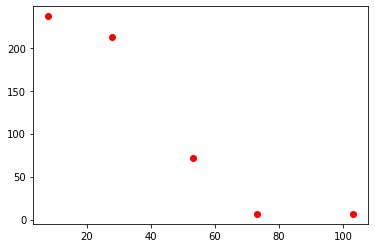

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  270
fixed Jt:  0.9
fixed Nf:  340
fixed Bk:  4.2
start Tn:  270
start Jt:  0.6
start Nf:  322
start Bk:  4.0
stepping:  27
Temperature:  [18.]
rewaRD::  -100
stepping:  27
Temperature:  [18. 48.]
rewaRD::  -100
stepping:  27
Temperature:  [18. 48. 53.]
rewaRD::  -100
stepping:  27
Temperature:  [18. 48. 53. 78.]
rewaRD::  -100
stepping:  27
Temperature:  [18. 48. 53. 78. 79.]
ORDER PARAM RESULT (X2): 289.20438922681006
THE JT RESULT {X0}: 0.4000002899745156
THE NF RESULT {X1}: 323.03242714905144
THE BK RESULT {X3}: 5.03033786923367
chisqds:  3.283074545870214


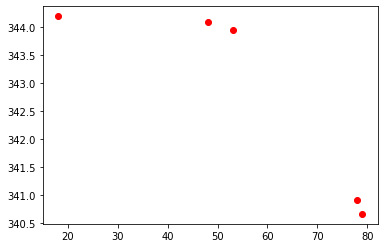

rewaRD::  21.837014180247834
stepping:  27
Temperature:  [18. 48. 53. 78. 79. 84.]
ORDER PARAM RESULT (X2): 288.2288833388424
THE JT RESULT {X0}: 0.4000005082303681
THE NF RESULT {X1}: 323.3397750133633
THE BK RESULT {X3}: 5.336424539516375
chisqds:  1.7120447984941813


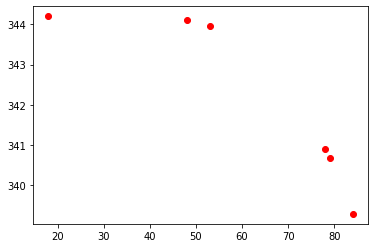

rewaRD::  133.63874610747195
stepping:  27
Temperature:  [ 18.  48.  53.  78.  79.  84. 104.]
ORDER PARAM RESULT (X2): 284.64559498906084
THE JT RESULT {X0}: 0.400000654987851
THE NF RESULT {X1}: 324.7348334174907
THE BK RESULT {X3}: 6.709813202066534
chisqds:  0.7556808634796868


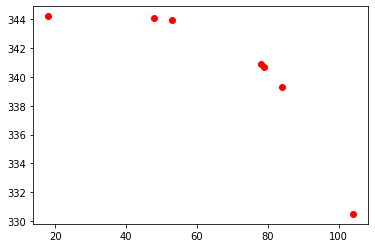

rewaRD::  300
stepping:  27
Temperature:  [ 18.  48.  53.  78.  79.  84. 104. 119.]
ORDER PARAM RESULT (X2): 278.7733435908178
THE JT RESULT {X0}: 0.45027836965584894
THE NF RESULT {X1}: 326.0698998736927
THE BK RESULT {X3}: 7.999869644106119
chisqds:  0.3455346903431885


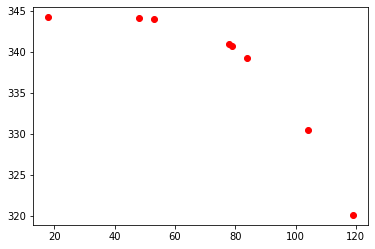

rewaRD::  300
stepping:  27
Temperature:  [ 18.  48.  53.  78.  79.  84. 104. 119. 134.]
ORDER PARAM RESULT (X2): 273.7992954662236
THE JT RESULT {X0}: 0.513731192544408
THE NF RESULT {X1}: 326.143898691156
THE BK RESULT {X3}: 7.999577838592788
chisqds:  0.2907469545576699


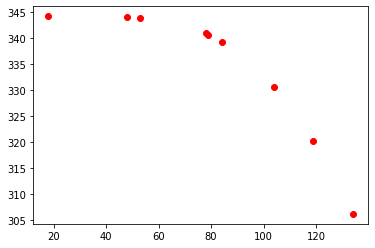

rewaRD::  300
stepping:  27
Temperature:  [ 18.  48.  53.  78.  79.  84. 104. 119. 134. 135.]
ORDER PARAM RESULT (X2): 272.7468863549868
THE JT RESULT {X0}: 0.5336730449695429
THE NF RESULT {X1}: 326.2041275503489
THE BK RESULT {X3}: 7.999698947880877
chisqds:  0.24418294859170686


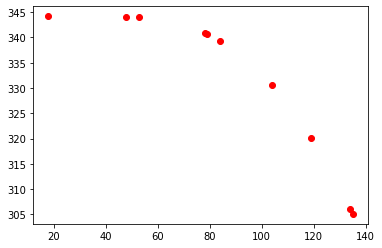

rewaRD::  300
stepping:  27
Temperature:  [ 18.  48.  53.  78.  79.  84. 104. 119. 134. 135. 150.]
ORDER PARAM RESULT (X2): 271.6240814548102
THE JT RESULT {X0}: 0.5487636898560839
THE NF RESULT {X1}: 326.3020553509915
THE BK RESULT {X3}: 7.999353544622711
chisqds:  0.21467519730086645


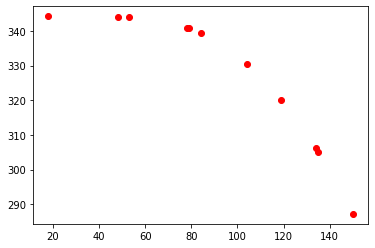

rewaRD::  300
stepping:  27
Temperature:  [ 18.  48.  53.  78.  79.  84. 104. 119. 134. 135. 150. 175.]
ORDER PARAM RESULT (X2): 269.8735172001284
THE JT RESULT {X0}: 0.5721838529014265
THE NF RESULT {X1}: 326.53871617791367
THE BK RESULT {X3}: 7.999309539932303
chisqds:  0.1919014991481404


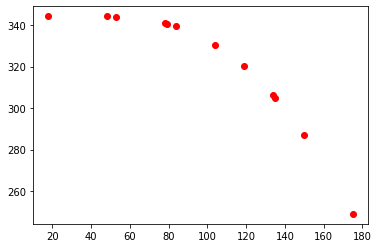

rewaRD::  300
stepping:  27
Temperature:  [ 18.  48.  53.  78.  79.  84. 104. 119. 134. 135. 150. 175. 200.]
ORDER PARAM RESULT (X2): 268.89915093871394
THE JT RESULT {X0}: 0.5932784976570309
THE NF RESULT {X1}: 327.03615458283303
THE BK RESULT {X3}: 7.999844763177491
chisqds:  0.16235891396515442


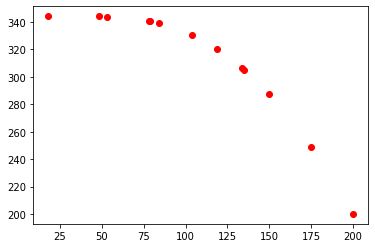

rewaRD::  300
stepping:  27
Temperature:  [ 18.  48.  53.  78.  79.  84. 104. 119. 134. 135. 150. 175. 200. 210.]
ORDER PARAM RESULT (X2): 268.4601759879131
THE JT RESULT {X0}: 0.6126753793139852
THE NF RESULT {X1}: 327.6966425491975
THE BK RESULT {X3}: 7.999282735540685
chisqds:  0.12957859275349942


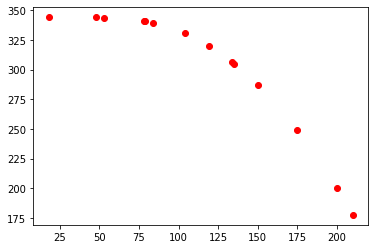

rewaRD::  300
stepping:  27
Temperature:  [ 18.  48.  53.  78.  79.  84. 104. 119. 134. 135. 150. 175. 200. 210.
 235.]
ORDER PARAM RESULT (X2): 268.1448761080369
THE JT RESULT {X0}: 0.6476145990671843
THE NF RESULT {X1}: 329.2889946161846
THE BK RESULT {X3}: 7.999900260040899
chisqds:  0.07712465854852067


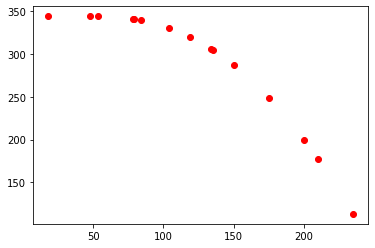

rewaRD::  300
stepping:  27
Temperature:  [ 18.  48.  53.  78.  79.  84. 104. 119. 134. 135. 150. 175. 200. 210.
 235. 250.]
ORDER PARAM RESULT (X2): 268.14021407690745
THE JT RESULT {X0}: 0.7203307934502109
THE NF RESULT {X1}: 332.2504358548194
THE BK RESULT {X3}: 7.999694760583908
chisqds:  0.025010774639380732


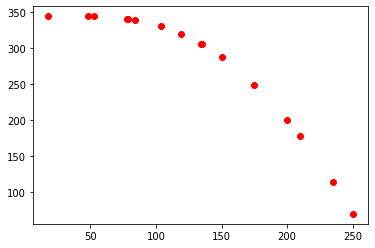

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  160
fixed Jt:  1.2
fixed Nf:  440
fixed Bk:  5.6
start Tn:  148
start Jt:  0.9
start Nf:  436
start Bk:  5.56
stepping:  28
Temperature:  [28.]
rewaRD::  -100
stepping:  28
Temperature:  [28. 53.]
rewaRD::  -100
--------------------------------------
| approxkl           | 4.799294e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 7.53          |
| ep_reward_mean     | -71           |
| explained_variance | -3.09e-05     |
| fps                | 8             |
| n_updates          | 2             |
| policy_entropy     | 1.945623      |
| policy_loss        | -0.0007222885 |
| serial_timesteps   | 256           |
| time_elapsed       | 20            |
| total_timesteps    | 256           |
| value_loss         | 274208.28     |
--------------------------------------
stepping:  28
Temperature:  [28. 53. 73.]
rewaRD::  -100
stepping:  28
Temperature:  [28. 53. 73. 98.]
rewaRD::  -100
stepping:  28
Tempera

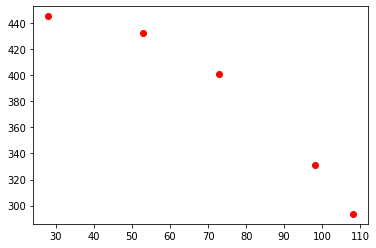

rewaRD::  293.4665818273078
stepping:  28
Temperature:  [ 28.  53.  73.  98. 108. 123.]
ORDER PARAM RESULT (X2): 149.04231035718269
THE JT RESULT {X0}: 0.8187762466765083
THE NF RESULT {X1}: 438.1721590945037
THE BK RESULT {X3}: 7.9993432045480315
chisqds:  3.125321845106828


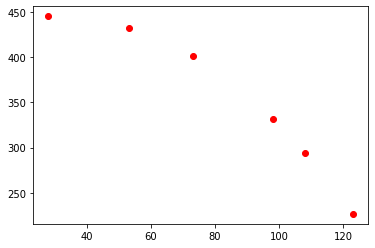

rewaRD::  27.98681858198428
stepping:  28
Temperature:  [ 28.  53.  73.  98. 108. 123. 143.]
ORDER PARAM RESULT (X2): 148.62220353618474
THE JT RESULT {X0}: 0.8422439353905337
THE NF RESULT {X1}: 437.58566644240744
THE BK RESULT {X3}: 7.999875416574921
chisqds:  14.513421133491214


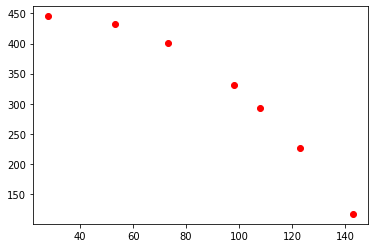

rewaRD::  -72.43930315802945
stepping:  28
Temperature:  [ 28.  53.  73.  98. 108. 123. 143. 163.]
ORDER PARAM RESULT (X2): 159.99999999999892
THE JT RESULT {X0}: 1.2000000000000095
THE NF RESULT {X1}: 440.0000000000001
THE BK RESULT {X3}: 5.6
chisqds:  1.2230725558157667e-25


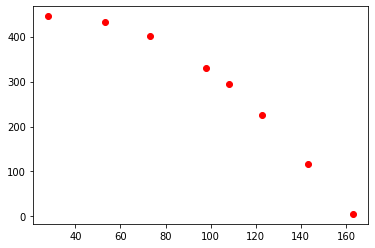

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  210
fixed Jt:  1.1
fixed Nf:  260
fixed Bk:  4.0
start Tn:  204
start Jt:  1.3
start Nf:  252
start Bk:  4.06
stepping:  29
Temperature:  [18.]
rewaRD::  -100
stepping:  29
Temperature:  [18. 28.]
rewaRD::  -100
stepping:  29
Temperature:  [18. 28. 48.]
rewaRD::  -100
stepping:  29
Temperature:  [18. 28. 48. 58.]
rewaRD::  -100
stepping:  29
Temperature:  [18. 28. 48. 58. 59.]
ORDER PARAM RESULT (X2): 209.99999999204306
THE JT RESULT {X0}: 1.099999999920602
THE NF RESULT {X1}: 259.9999999799888
THE BK RESULT {X3}: 4.000000020011347
chisqds:  4.34446336582527e-25


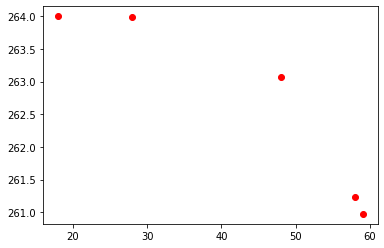

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  230
fixed Jt:  0.8
fixed Nf:  240
fixed Bk:  4.6
start Tn:  216
start Jt:  1.0
start Nf:  234
start Bk:  4.51
stepping:  30
Temperature:  [4.]
rewaRD::  -100
stepping:  30
Temperature:  [4. 5.]
rewaRD::  -100
stepping:  30
Temperature:  [ 4.  5. 15.]
rewaRD::  -100
stepping:  30
Temperature:  [ 4.  5. 15. 16.]
rewaRD::  -100
stepping:  30
Temperature:  [ 4.  5. 15. 16. 21.]
ORDER PARAM RESULT (X2): 260.8672702703985
THE JT RESULT {X0}: 0.4000007924086632
THE NF RESULT {X1}: 234.3288656035696
THE BK RESULT {X3}: 4.838865603527528
chisqds:  0.6032201339482948


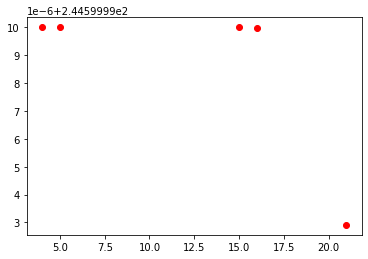

rewaRD::  300
stepping:  30
Temperature:  [ 4.  5. 15. 16. 21. 36.]
ORDER PARAM RESULT (X2): 260.4202084646859
THE JT RESULT {X0}: 0.4000004662077269
THE NF RESULT {X1}: 235.605480892035
THE BK RESULT {X3}: 6.115476617385227
chisqds:  0.10149865942310826


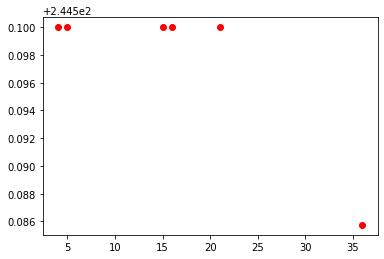

rewaRD::  300
stepping:  30
Temperature:  [ 4.  5. 15. 16. 21. 36. 37.]
ORDER PARAM RESULT (X2): 258.01083417481664
THE JT RESULT {X0}: 0.40000018025025874
THE NF RESULT {X1}: 235.669591671945
THE BK RESULT {X3}: 6.179583106227402
chisqds:  0.07194237218116652


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


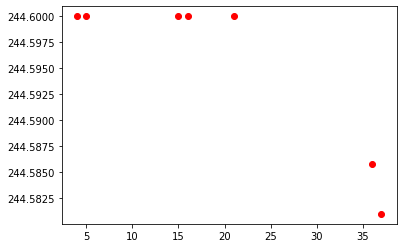

rewaRD::  300
stepping:  30
Temperature:  [ 4.  5. 15. 16. 21. 36. 37. 38.]
ORDER PARAM RESULT (X2): 255.97362133206326


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


THE JT RESULT {X0}: 0.40000032025303567
THE NF RESULT {X1}: 235.72169751629409
THE BK RESULT {X3}: 6.231684227284126
chisqds:  0.05696892237619382


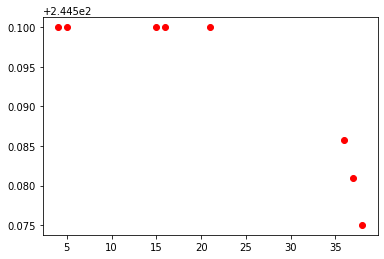

rewaRD::  300
stepping:  30
Temperature:  [ 4.  5. 15. 16. 21. 36. 37. 38. 68.]
ORDER PARAM RESULT (X2): 229.12634670745004
THE JT RESULT {X0}: 0.7932340575017695
THE NF RESULT {X1}: 237.8722288287852
THE BK RESULT {X3}: 6.727771187463114
chisqds:  5.640434264339143e-17


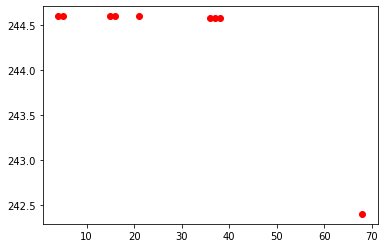

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  260
fixed Jt:  1.3
fixed Nf:  350
fixed Bk:  5.0
start Tn:  256
start Jt:  1.08
start Nf:  356
start Bk:  5.16
stepping:  31
Temperature:  [18.]
rewaRD::  -100
stepping:  31
Temperature:  [18. 48.]
rewaRD::  -100
stepping:  31
Temperature:  [18. 48. 78.]
rewaRD::  -100
stepping:  31
Temperature:  [18. 48. 78. 79.]
rewaRD::  -100
stepping:  31
Temperature:  [18. 48. 78. 79. 80.]
ORDER PARAM RESULT (X2): 259.99999999881175
THE JT RESULT {X0}: 1.2999999999899312
THE NF RESULT {X1}: 349.9999999968729
THE BK RESULT {X3}: 5.000000003127115
chisqds:  3.9067029424460102e-28


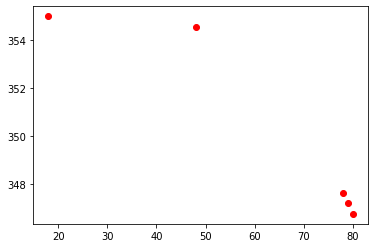

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  190
fixed Jt:  1.2
fixed Nf:  410
fixed Bk:  4.0
start Tn:  170
start Jt:  1.12
start Nf:  390
start Bk:  4.16
stepping:  32
Temperature:  [18.]
rewaRD::  -100
stepping:  32
Temperature:  [18. 38.]
rewaRD::  -100
stepping:  32
Temperature:  [18. 38. 63.]
rewaRD::  -100
stepping:  32
Temperature:  [18. 38. 63. 78.]
rewaRD::  -100
stepping:  32
Temperature:  [18. 38. 63. 78. 93.]
ORDER PARAM RESULT (X2): 174.35486165883668
THE JT RESULT {X0}: 0.9503653857219779
THE NF RESULT {X1}: 394.0293554444513
THE BK RESULT {X3}: 7.999778690732427
chisqds:  2.5643897786790966


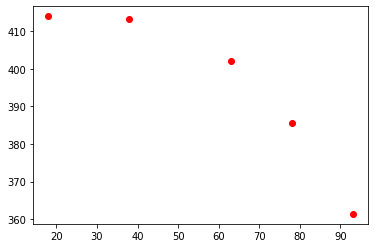

rewaRD::  55.982527822286755
stepping:  32
Temperature:  [18. 38. 63. 78. 93. 98.]
ORDER PARAM RESULT (X2): 173.71918673053358
THE JT RESULT {X0}: 0.9634123036110194
THE NF RESULT {X1}: 394.09670814323226
THE BK RESULT {X3}: 7.9994382914006215
chisqds:  2.021341212130735


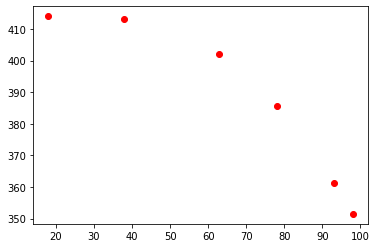

rewaRD::  97.88841072425981
stepping:  32
Temperature:  [ 18.  38.  63.  78.  93.  98. 103.]
ORDER PARAM RESULT (X2): 173.28439551278987
THE JT RESULT {X0}: 0.9720855905798172
THE NF RESULT {X1}: 394.1658356087931
THE BK RESULT {X3}: 7.9998505750385185
chisqds:  2.0046430239056274


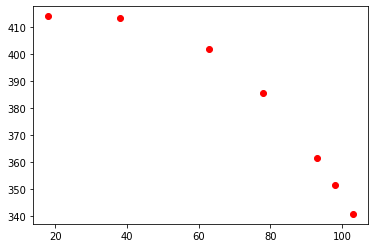

rewaRD::  99.53677299646284
stepping:  32
Temperature:  [ 18.  38.  63.  78.  93.  98. 103. 118.]
ORDER PARAM RESULT (X2): 172.73309455897063
THE JT RESULT {X0}: 0.9764079012698836
THE NF RESULT {X1}: 394.21265945969
THE BK RESULT {X3}: 7.999265689021272
chisqds:  2.5519093685303798


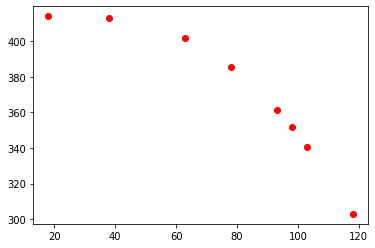

rewaRD::  56.74537855172974
stepping:  32
Temperature:  [ 18.  38.  63.  78.  93.  98. 103. 118. 123.]
ORDER PARAM RESULT (X2): 172.43559929131425
THE JT RESULT {X0}: 0.9769117135408717
THE NF RESULT {X1}: 394.35299498671685
THE BK RESULT {X3}: 7.99981272336858
chisqds:  3.0959391852679126


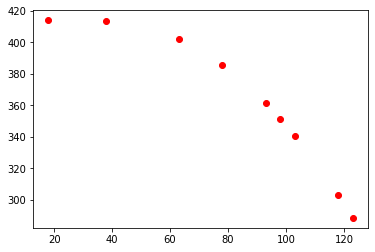

rewaRD::  29.201504313588543
stepping:  32
Temperature:  [ 18.  38.  63.  78.  93.  98. 103. 118. 123. 133.]
ORDER PARAM RESULT (X2): 172.06626691367148
THE JT RESULT {X0}: 0.9810485040536306
THE NF RESULT {X1}: 394.3042097781005
THE BK RESULT {X3}: 7.999310619533425
chisqds:  4.173441720433541


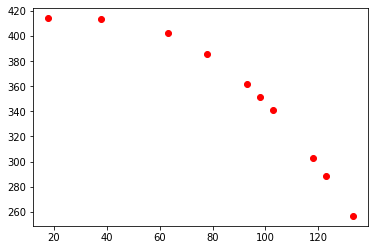

rewaRD::  -4.155843834702537
stepping:  32
Temperature:  [ 18.  38.  63.  78.  93.  98. 103. 118. 123. 133. 148.]
ORDER PARAM RESULT (X2): 171.7236972743314
THE JT RESULT {X0}: 0.9815155443399584
THE NF RESULT {X1}: 394.18456275078415
THE BK RESULT {X3}: 7.999645604804373
chisqds:  6.5343074450436225


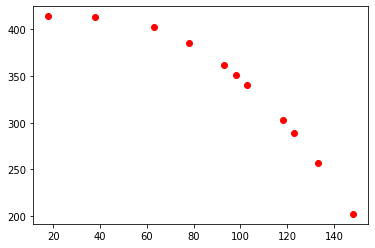

rewaRD::  -38.7846373369826
stepping:  32
Temperature:  [ 18.  38.  63.  78.  93.  98. 103. 118. 123. 133. 148. 178.]
ORDER PARAM RESULT (X2): 171.45729942498014
THE JT RESULT {X0}: 1.0022189367569898
THE NF RESULT {X1}: 393.57342731083077
THE BK RESULT {X3}: 7.999836371758513
chisqds:  12.771764201906986


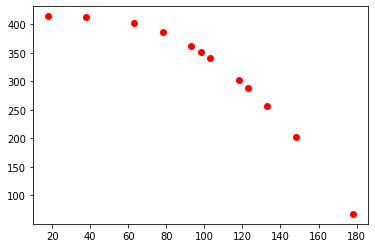

rewaRD::  -68.68091254454299
stepping:  32
Temperature:  [ 18.  38.  63.  78.  93.  98. 103. 118. 123. 133. 148. 178. 208.]
ORDER PARAM RESULT (X2): 189.9999999999992
THE JT RESULT {X0}: 1.20000000000002
THE NF RESULT {X1}: 410.0000000000002
THE BK RESULT {X3}: 4.0
chisqds:  4.7066201177761435e-26


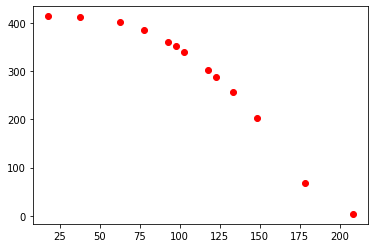

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  150
fixed Jt:  1.3
fixed Nf:  400
fixed Bk:  4.2
start Tn:  136
start Jt:  1.18
start Nf:  382
start Bk:  4.04
stepping:  33
Temperature:  [13.]
rewaRD::  -100
stepping:  33
Temperature:  [13. 38.]
rewaRD::  -100
stepping:  33
Temperature:  [13. 38. 43.]
rewaRD::  -100
stepping:  33
Temperature:  [13. 38. 43. 48.]
rewaRD::  -100
stepping:  33
Temperature:  [13. 38. 43. 48. 53.]
ORDER PARAM RESULT (X2): 143.2895081154395
THE JT RESULT {X0}: 0.9275050372049705
THE NF RESULT {X1}: 386.0499557089591
THE BK RESULT {X3}: 7.999647495757295
chisqds:  0.8746165290524632


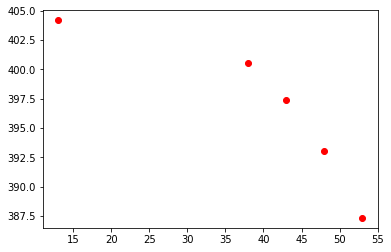

rewaRD::  300
stepping:  33
Temperature:  [13. 38. 43. 48. 53. 83.]
ORDER PARAM RESULT (X2): 139.19599218075695
THE JT RESULT {X0}: 0.975171134018389
THE NF RESULT {X1}: 386.11568865714383
THE BK RESULT {X3}: 7.9995054515590756
chisqds:  0.9498422657289057


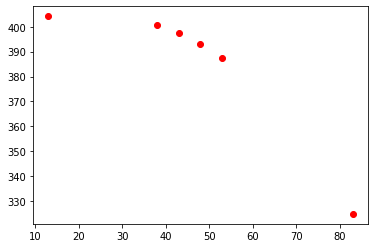

rewaRD::  300
stepping:  33
Temperature:  [13. 38. 43. 48. 53. 83. 88.]
ORDER PARAM RESULT (X2): 138.62839849709843
THE JT RESULT {X0}: 0.9960505842899475
THE NF RESULT {X1}: 386.1645920132192
THE BK RESULT {X3}: 7.9993420828579
chisqds:  1.155653422308277


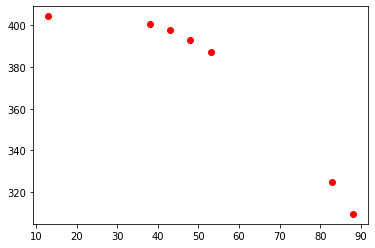

rewaRD::  246.12453204270247
stepping:  33
Temperature:  [13. 38. 43. 48. 53. 83. 88. 98.]
ORDER PARAM RESULT (X2): 138.1982387177967
THE JT RESULT {X0}: 1.0020198947306878
THE NF RESULT {X1}: 386.1834212581184
THE BK RESULT {X3}: 7.9995135498828915
chisqds:  1.6602405042107071


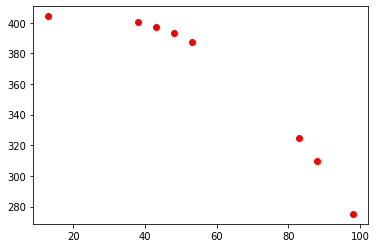

rewaRD::  140.92894914051234
stepping:  33
Temperature:  [ 13.  38.  43.  48.  53.  83.  88.  98. 113.]
ORDER PARAM RESULT (X2): 149.99999999999864
THE JT RESULT {X0}: 1.2999999999999965
THE NF RESULT {X1}: 399.9999999999975
THE BK RESULT {X3}: 4.200000000002351
chisqds:  2.0628697292761617e-26


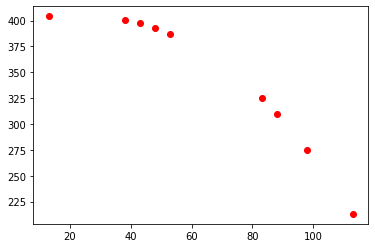

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  150
fixed Jt:  0.8
fixed Nf:  460
fixed Bk:  7.2
start Tn:  158
start Jt:  0.88
start Nf:  458
start Bk:  7.24
stepping:  34
Temperature:  [18.]
rewaRD::  -100
stepping:  34
Temperature:  [18. 38.]
rewaRD::  -100
stepping:  34
Temperature:  [18. 38. 63.]
rewaRD::  -100
stepping:  34
Temperature:  [18. 38. 63. 83.]
rewaRD::  -100
stepping:  34
Temperature:  [ 18.  38.  63.  83. 103.]
ORDER PARAM RESULT (X2): 149.9999999999924
THE JT RESULT {X0}: 0.7999999999998957
THE NF RESULT {X1}: 459.9999999999239
THE BK RESULT {X3}: 7.200000000076298
chisqds:  1.3284590373108176e-25


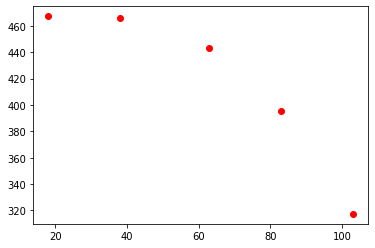

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  260
fixed Jt:  0.8
fixed Nf:  450
fixed Bk:  6.0
start Tn:  250
start Jt:  0.74
start Nf:  450
start Bk:  6.16
stepping:  35
Temperature:  [28.]
rewaRD::  -100
stepping:  35
Temperature:  [28. 38.]
rewaRD::  -100
stepping:  35
Temperature:  [28. 38. 43.]
rewaRD::  -100
stepping:  35
Temperature:  [28. 38. 43. 53.]
rewaRD::  -100
stepping:  35
Temperature:  [28. 38. 43. 53. 54.]
ORDER PARAM RESULT (X2): 259.99999972877094
THE JT RESULT {X0}: 0.7999999981281557
THE NF RESULT {X1}: 449.999998931419
THE BK RESULT {X3}: 6.000001068581149
chisqds:  2.1982116290166218e-27


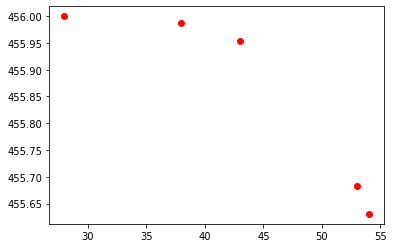

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  270
fixed Jt:  1.3
fixed Nf:  310
fixed Bk:  6.8
start Tn:  256
start Jt:  1.42
start Nf:  298
start Bk:  6.64
stepping:  36
Temperature:  [23.]
rewaRD::  -100
stepping:  36
Temperature:  [23. 38.]
rewaRD::  -100
stepping:  36
Temperature:  [23. 38. 53.]
rewaRD::  -100
stepping:  36
Temperature:  [23. 38. 53. 78.]
rewaRD::  -100
stepping:  36
Temperature:  [23. 38. 53. 78. 79.]
ORDER PARAM RESULT (X2): 266.82432753448273
THE JT RESULT {X0}: 1.2398015504068023
THE NF RESULT {X1}: 299.3778299219307
THE BK RESULT {X3}: 7.999939268848229
chisqds:  1.3727476592372374


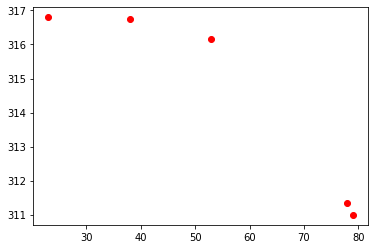

rewaRD::  191.38640106824778
stepping:  36
Temperature:  [ 23.  38.  53.  78.  79. 109.]
ORDER PARAM RESULT (X2): 261.608414632212
THE JT RESULT {X0}: 1.294505975898524
THE NF RESULT {X1}: 299.38953768000664
THE BK RESULT {X3}: 7.999873362456289
chisqds:  0.9551944870058922


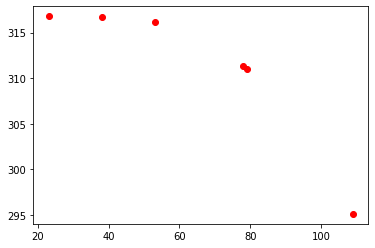

rewaRD::  300
stepping:  36
Temperature:  [ 23.  38.  53.  78.  79. 109. 139.]
ORDER PARAM RESULT (X2): 259.35993402409395
THE JT RESULT {X0}: 1.3184830713281648
THE NF RESULT {X1}: 299.40915264270984
THE BK RESULT {X3}: 7.999902157467426
chisqds:  0.9444984764236694


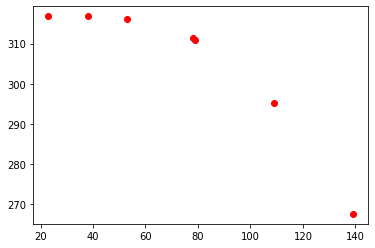

rewaRD::  300
stepping:  36
Temperature:  [ 23.  38.  53.  78.  79. 109. 139. 169.]
ORDER PARAM RESULT (X2): 258.24993270942593
THE JT RESULT {X0}: 1.3270137093285281
THE NF RESULT {X1}: 299.4296067091829
THE BK RESULT {X3}: 7.9997110442790005
chisqds:  1.1253868071729125


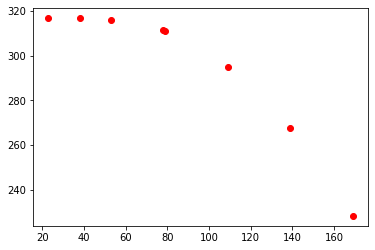

rewaRD::  255.43334740598317
stepping:  36
Temperature:  [ 23.  38.  53.  78.  79. 109. 139. 169. 184.]
ORDER PARAM RESULT (X2): 257.77939565462
THE JT RESULT {X0}: 1.331064080266291
THE NF RESULT {X1}: 299.44682871786165
THE BK RESULT {X3}: 7.999791308563807
chisqds:  1.3680334479091574


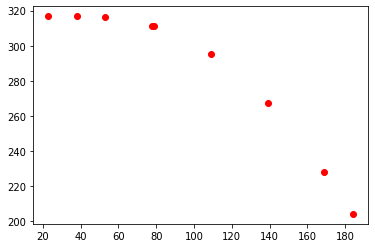

rewaRD::  192.39051180462184
stepping:  36
Temperature:  [ 23.  38.  53.  78.  79. 109. 139. 169. 184. 199.]
ORDER PARAM RESULT (X2): 257.4699268969068
THE JT RESULT {X0}: 1.3321506539667747
THE NF RESULT {X1}: 299.4714141955706
THE BK RESULT {X3}: 7.999761618151089
chisqds:  1.6969278655376525


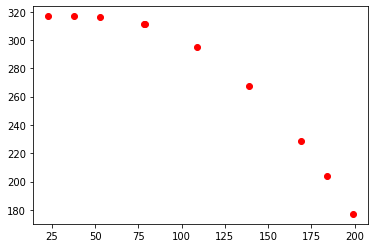

rewaRD::  135.72009637148867
stepping:  36
Temperature:  [ 23.  38.  53.  78.  79. 109. 139. 169. 184. 199. 219.]
ORDER PARAM RESULT (X2): 257.1819297965905
THE JT RESULT {X0}: 1.3317935415608182
THE NF RESULT {X1}: 299.4650812819343
THE BK RESULT {X3}: 7.999232409457036
chisqds:  2.287426472280916


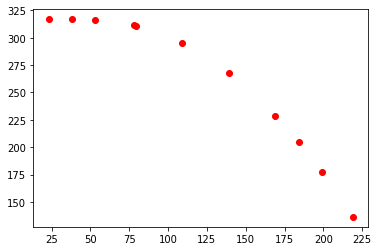

rewaRD::  74.86900883906378
stepping:  36
Temperature:  [ 23.  38.  53.  78.  79. 109. 139. 169. 184. 199. 219. 229.]
ORDER PARAM RESULT (X2): 257.00261778770897
THE JT RESULT {X0}: 1.3305222584353864
THE NF RESULT {X1}: 299.46358407693265
THE BK RESULT {X3}: 7.999899978280551
chisqds:  3.0051263277418117


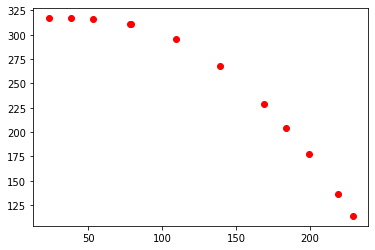

rewaRD::  33.105885202695674
stepping:  36
Temperature:  [ 23.  38.  53.  78.  79. 109. 139. 169. 184. 199. 219. 229. 259.]
ORDER PARAM RESULT (X2): 256.8828288977511
THE JT RESULT {X0}: 1.3409597272350189
THE NF RESULT {X1}: 299.293935353377
THE BK RESULT {X3}: 7.999389648388442
chisqds:  5.384862942841458


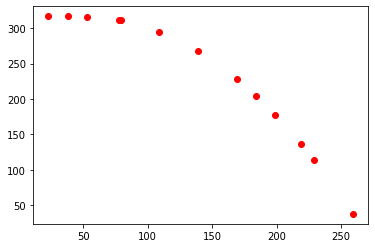

rewaRD::  -25.71770085035257
stepping:  36
Temperature:  [ 23.  38.  53.  78.  79. 109. 139. 169. 184. 199. 219. 229. 259. 289.]
ORDER PARAM RESULT (X2): 258.5254781852919
THE JT RESULT {X0}: 1.206099820299037
THE NF RESULT {X1}: 301.6012084103807
THE BK RESULT {X3}: 7.99957512791649
chisqds:  3.7984109435534457


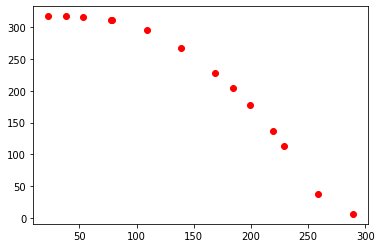

rewaRD::  5.307194493757578
stepping:  36
Temperature:  [ 23.  38.  53.  78.  79. 109. 139. 169. 184. 199. 219. 229. 259. 289.
 309.]
ORDER PARAM RESULT (X2): 260.25441226658495
THE JT RESULT {X0}: 1.0827719962293156
THE NF RESULT {X1}: 303.7655884935064
THE BK RESULT {X3}: 7.99954712593743
chisqds:  2.259544047293536


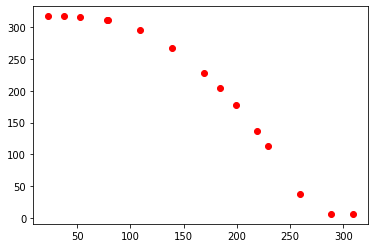

rewaRD::  77.0268654329252
stepping:  36
Temperature:  [ 23.  38.  53.  78.  79. 109. 139. 169. 184. 199. 219. 229. 259. 289.
 309. 334.]
ORDER PARAM RESULT (X2): 269.9999999999992
THE JT RESULT {X0}: 1.2999999999999543
THE NF RESULT {X1}: 309.9999999999997
THE BK RESULT {X3}: 6.8
chisqds:  5.9364677084067636e-27


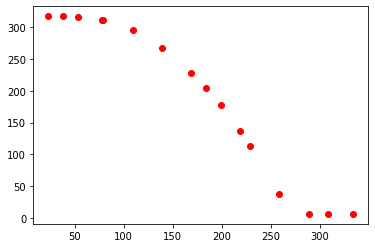

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  130
fixed Jt:  1.1
fixed Nf:  260
fixed Bk:  6.6
start Tn:  112
start Jt:  0.98
start Nf:  248
start Bk:  6.58
stepping:  37
Temperature:  [28.]
rewaRD::  -100
stepping:  37
Temperature:  [28. 43.]
rewaRD::  -100
stepping:  37
Temperature:  [28. 43. 68.]
rewaRD::  -100
stepping:  37
Temperature:  [28. 43. 68. 78.]
rewaRD::  -100
stepping:  37
Temperature:  [ 28.  43.  68.  78. 108.]
ORDER PARAM RESULT (X2): 112.4832898020916
THE JT RESULT {X0}: 0.9150119085560189
THE NF RESULT {X1}: 249.04844676795048
THE BK RESULT {X3}: 7.999754336095588
chisqds:  60.70268685544041


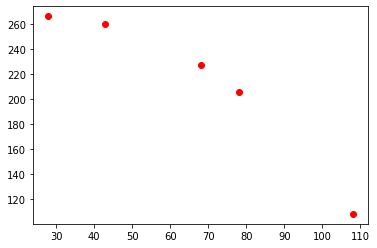

rewaRD::  -93.41050584873493
stepping:  37
Temperature:  [ 28.  43.  68.  78. 108. 133.]
ORDER PARAM RESULT (X2): 129.99999999999054
THE JT RESULT {X0}: 1.1000000000000605
THE NF RESULT {X1}: 259.9999999999998
THE BK RESULT {X3}: 6.6
chisqds:  5.854644595147735e-24


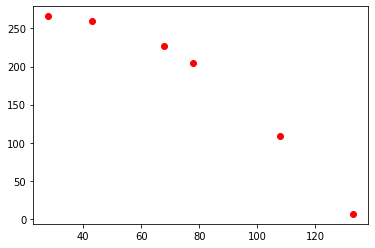

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  110
fixed Jt:  0.7
fixed Nf:  460
fixed Bk:  5.4
start Tn:  128
start Jt:  0.72
start Nf:  448
start Bk:  5.5
stepping:  38
Temperature:  [23.]
rewaRD::  -100
stepping:  38
Temperature:  [23. 28.]
rewaRD::  -100
stepping:  38
Temperature:  [23. 28. 53.]
rewaRD::  -100
stepping:  38
Temperature:  [23. 28. 53. 58.]
rewaRD::  -100
stepping:  38
Temperature:  [23. 28. 53. 58. 78.]
ORDER PARAM RESULT (X2): 116.84031769983632
THE JT RESULT {X0}: 1.1244754484824537
THE NF RESULT {X1}: 453.92096700536416
THE BK RESULT {X3}: 7.999431801712296
chisqds:  0.5240645593692482


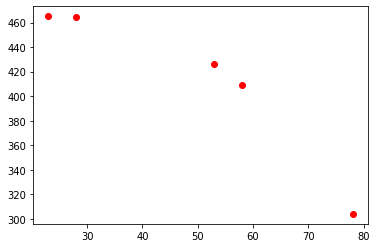

rewaRD::  300
stepping:  38
Temperature:  [23. 28. 53. 58. 78. 88.]
ORDER PARAM RESULT (X2): 110.00000000015841
THE JT RESULT {X0}: 0.7000000000017701
THE NF RESULT {X1}: 460.00000000175373
THE BK RESULT {X3}: 5.3999999982464715
chisqds:  2.1437149411484092e-23


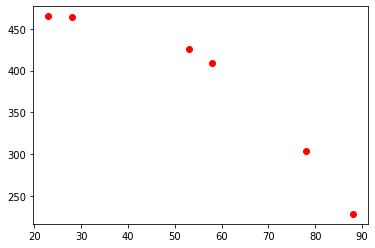

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  60
fixed Jt:  1.0
fixed Nf:  140
fixed Bk:  4.0
start Tn:  58
start Jt:  1.12
start Nf:  140
start Bk:  3.82
stepping:  39
Temperature:  [28.]
rewaRD::  -100
stepping:  39
Temperature:  [28. 58.]
rewaRD::  -100
stepping:  39
Temperature:  [28. 58. 78.]
rewaRD::  -100
stepping:  39
Temperature:  [ 28.  58.  78. 103.]
rewaRD::  -100
stepping:  39
Temperature:  [ 28.  58.  78. 103. 104.]
ORDER PARAM RESULT (X2): 60.006039857215576
THE JT RESULT {X0}: 1.0239010132642388
THE NF RESULT {X1}: 140.24999998509884
THE BK RESULT {X3}: 4.0
chisqds:  5.550770951578325e-23


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


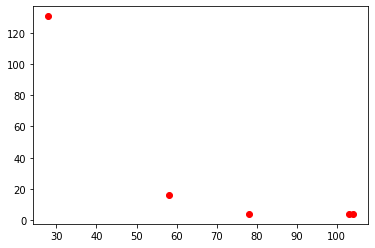

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  250
fixed Jt:  1.4
fixed Nf:  300
fixed Bk:  7.4
start Tn:  240
start Jt:  1.4
start Nf:  316
start Bk:  7.58
stepping:  40
Temperature:  [33.]
rewaRD::  -100
stepping:  40
Temperature:  [33. 38.]
rewaRD::  -100
stepping:  40
Temperature:  [33. 38. 53.]
rewaRD::  -100
stepping:  40
Temperature:  [33. 38. 53. 83.]
rewaRD::  -100
stepping:  40
Temperature:  [ 33.  38.  53.  83. 113.]
ORDER PARAM RESULT (X2): 245.74041852648233
THE JT RESULT {X0}: 1.3206260891233261
THE NF RESULT {X1}: 307.8126817900921
THE BK RESULT {X3}: 0.10000291315286121
chisqds:  0.0051887815655273645


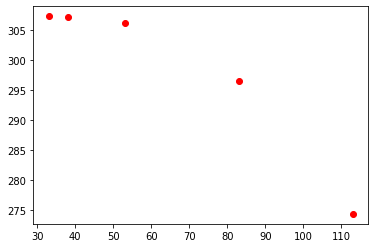

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  170
fixed Jt:  1.0
fixed Nf:  430
fixed Bk:  3.4
start Tn:  150
start Jt:  1.0
start Nf:  432
start Bk:  3.22
stepping:  41
Temperature:  [18.]
rewaRD::  -100
stepping:  41
Temperature:  [18. 33.]
rewaRD::  -100
stepping:  41
Temperature:  [18. 33. 58.]
rewaRD::  -100
stepping:  41
Temperature:  [18. 33. 58. 73.]
rewaRD::  -100
stepping:  41
Temperature:  [18. 33. 58. 73. 93.]
ORDER PARAM RESULT (X2): 170.00000000007847
THE JT RESULT {X0}: 1.0000000000004823
THE NF RESULT {X1}: 430.0000000004399
THE BK RESULT {X3}: 3.399999999560307
chisqds:  1.6039683914525626e-24


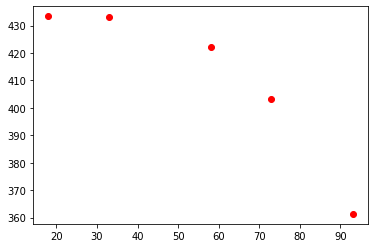

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  250
fixed Jt:  1.2
fixed Nf:  180
fixed Bk:  6.4
start Tn:  248
start Jt:  1.18
start Nf:  166
start Bk:  6.44
stepping:  42
Temperature:  [8.]
rewaRD::  -100
stepping:  42
Temperature:  [ 8. 13.]
rewaRD::  -100
stepping:  42
Temperature:  [ 8. 13. 43.]
rewaRD::  -100
stepping:  42
Temperature:  [ 8. 13. 43. 58.]
rewaRD::  -100
stepping:  42
Temperature:  [ 8. 13. 43. 58. 63.]
ORDER PARAM RESULT (X2): 250.0000000020262
THE JT RESULT {X0}: 1.2000000000150834
THE NF RESULT {X1}: 180.0000000031645
THE BK RESULT {X3}: 6.399999996835531
chisqds:  7.472470216908027e-26


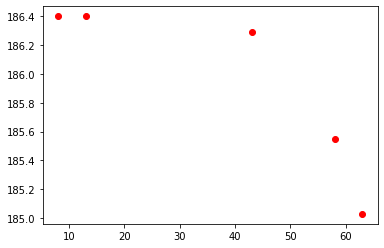

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  120
fixed Jt:  1.0
fixed Nf:  270
fixed Bk:  4.2
start Tn:  114
start Jt:  1.06
start Nf:  250
start Bk:  4.08
stepping:  43
Temperature:  [33.]
rewaRD::  -100
stepping:  43
Temperature:  [33. 58.]
rewaRD::  -100
stepping:  43
Temperature:  [33. 58. 88.]
rewaRD::  -100
stepping:  43
Temperature:  [33. 58. 88. 98.]
rewaRD::  -100
stepping:  43
Temperature:  [ 33.  58.  88.  98. 103.]
ORDER PARAM RESULT (X2): 115.07360820497219
THE JT RESULT {X0}: 0.8229197269562978
THE NF RESULT {X1}: 255.5937052886695
THE BK RESULT {X3}: 7.999373562820505
chisqds:  8.682362391680066


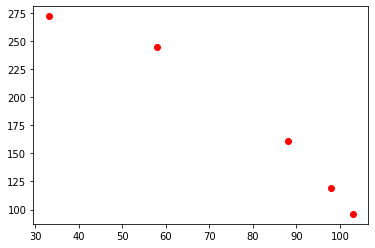

rewaRD::  -53.92958944177419
stepping:  43
Temperature:  [ 33.  58.  88.  98. 103. 104.]
ORDER PARAM RESULT (X2): 114.99967617879173
THE JT RESULT {X0}: 0.8087704121771373
THE NF RESULT {X1}: 256.07032540625494
THE BK RESULT {X3}: 7.999218580688595
chisqds:  6.435329470652809


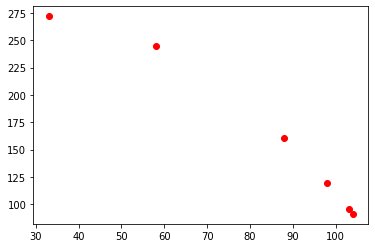

rewaRD::  -37.8431202591678
stepping:  43
Temperature:  [ 33.  58.  88.  98. 103. 104. 109.]
ORDER PARAM RESULT (X2): 114.91075575207083
THE JT RESULT {X0}: 0.7955392089399786
THE NF RESULT {X1}: 256.35720483525284
THE BK RESULT {X3}: 7.999854895663867
chisqds:  6.89388726109964


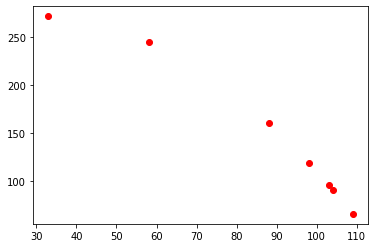

rewaRD::  -41.9775832051834
stepping:  43
Temperature:  [ 33.  58.  88.  98. 103. 104. 109. 124.]
ORDER PARAM RESULT (X2): 119.9999999999997
THE JT RESULT {X0}: 1.0000000000000293
THE NF RESULT {X1}: 270.0000000000002
THE BK RESULT {X3}: 4.2
chisqds:  3.4048118075845957e-26


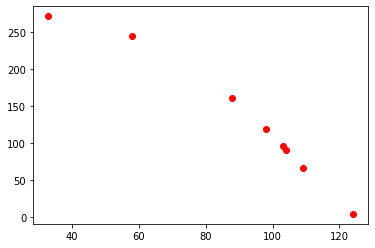

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  140
fixed Jt:  1.1
fixed Nf:  290
fixed Bk:  4.2
start Tn:  132
start Jt:  1.26
start Nf:  308
start Bk:  4.0
stepping:  44
Temperature:  [23.]
rewaRD::  -100
stepping:  44
Temperature:  [23. 28.]
rewaRD::  -100
stepping:  44
Temperature:  [23. 28. 58.]
rewaRD::  -100
stepping:  44
Temperature:  [23. 28. 58. 73.]
rewaRD::  -100
stepping:  44
Temperature:  [ 23.  28.  58.  73. 103.]
ORDER PARAM RESULT (X2): 140.00000000002518
THE JT RESULT {X0}: 1.1000000000001835
THE NF RESULT {X1}: 290.0000000001112
THE BK RESULT {X3}: 4.1999999998888535
chisqds:  1.021190165934179e-24


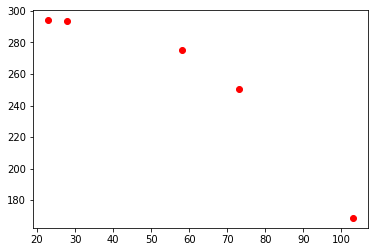

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  130
fixed Jt:  1.1
fixed Nf:  190
fixed Bk:  6.6
start Tn:  142
start Jt:  1.2
start Nf:  176
start Bk:  6.48
stepping:  45
Temperature:  [13.]
rewaRD::  -100
stepping:  45
Temperature:  [13. 28.]
rewaRD::  -100
stepping:  45
Temperature:  [13. 28. 43.]
rewaRD::  -100
stepping:  45
Temperature:  [13. 28. 43. 73.]
rewaRD::  -100
stepping:  45
Temperature:  [ 13.  28.  43.  73. 103.]
ORDER PARAM RESULT (X2): 138.89254444798826
THE JT RESULT {X0}: 1.350905354562201
THE NF RESULT {X1}: 179.18489244239748
THE BK RESULT {X3}: 7.999630319202725
chisqds:  2.3423959153540026


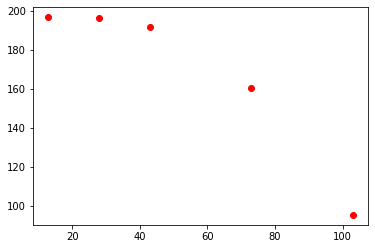

rewaRD::  70.76532510070939
stepping:  45
Temperature:  [ 13.  28.  43.  73. 103. 133.]
ORDER PARAM RESULT (X2): 138.43409022428477
THE JT RESULT {X0}: 1.8724212964784754
THE NF RESULT {X1}: 180.54005037965177
THE BK RESULT {X3}: 0.10002400249484594
chisqds:  10.324070916068973


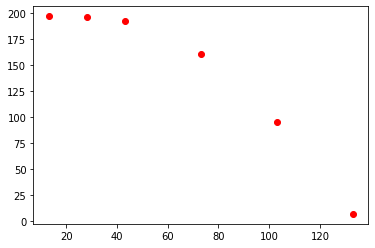

rewaRD::  -61.255593529736686
stepping:  45
Temperature:  [ 13.  28.  43.  73. 103. 133. 158.]
ORDER PARAM RESULT (X2): 130.00000000012915
THE JT RESULT {X0}: 1.09999999999894
THE NF RESULT {X1}: 190.00000000000037
THE BK RESULT {X3}: 6.6
chisqds:  3.443224844228957e-22


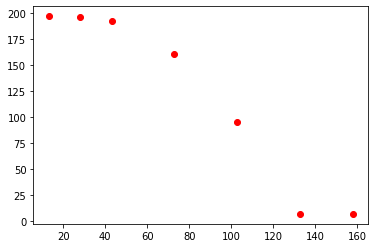

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  140
fixed Jt:  1.0
fixed Nf:  210
fixed Bk:  6.6
start Tn:  140
start Jt:  1.0
start Nf:  212
start Bk:  6.6
stepping:  46
Temperature:  [28.]
rewaRD::  -100
stepping:  46
Temperature:  [28. 29.]
rewaRD::  -100
stepping:  46
Temperature:  [28. 29. 59.]
rewaRD::  -100
--------------------------------------
| approxkl           | 9.125677e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 6.92          |
| ep_reward_mean     | 65.3          |
| explained_variance | -3.4e-05      |
| fps                | 8             |
| n_updates          | 3             |
| policy_entropy     | 1.9451325     |
| policy_loss        | -0.0018454843 |
| serial_timesteps   | 384           |
| time_elapsed       | 34.7          |
| total_timesteps    | 384           |
| value_loss         | 112351.49     |
--------------------------------------
stepping:  46
Temperature:  [28. 29. 59. 74.]
rewaRD::  -100
stepping:  46
Temperat

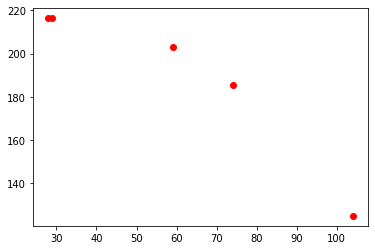

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  80
fixed Jt:  1.0
fixed Nf:  470
fixed Bk:  5.6
start Tn:  78
start Jt:  0.92
start Nf:  450
start Bk:  5.44
stepping:  47
Temperature:  [18.]
rewaRD::  -100
stepping:  47
Temperature:  [18. 38.]
rewaRD::  -100
stepping:  47
Temperature:  [18. 38. 43.]
rewaRD::  -100
stepping:  47
Temperature:  [18. 38. 43. 44.]
rewaRD::  -100
stepping:  47
Temperature:  [18. 38. 43. 44. 69.]
ORDER PARAM RESULT (X2): 79.99999999995393
THE JT RESULT {X0}: 0.9999999999994804
THE NF RESULT {X1}: 469.99999999943947
THE BK RESULT {X3}: 5.600000000560194
chisqds:  9.118716712004968e-23


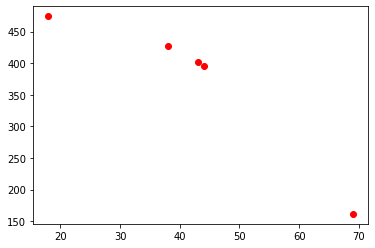

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  270
fixed Jt:  1.3
fixed Nf:  270
fixed Bk:  3.6
start Tn:  270
start Jt:  1.04
start Nf:  266
start Bk:  3.62
stepping:  48
Temperature:  [18.]
rewaRD::  -100
stepping:  48
Temperature:  [18. 33.]
rewaRD::  -100
stepping:  48
Temperature:  [18. 33. 48.]
rewaRD::  -100
stepping:  48
Temperature:  [18. 33. 48. 78.]
rewaRD::  -100
stepping:  48
Temperature:  [18. 33. 48. 78. 93.]
ORDER PARAM RESULT (X2): 270.0000000003958
THE JT RESULT {X0}: 1.3000000000031315
THE NF RESULT {X1}: 270.0000000008243
THE BK RESULT {X3}: 3.5999999991756564
chisqds:  1.3180325409076396e-27


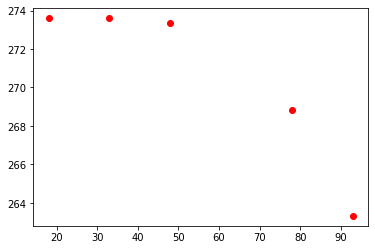

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  210
fixed Jt:  1.2
fixed Nf:  190
fixed Bk:  5.8
start Tn:  212
start Jt:  1.48
start Nf:  192
start Bk:  5.84
stepping:  49
Temperature:  [28.]
rewaRD::  -100
stepping:  49
Temperature:  [28. 38.]
rewaRD::  -100
stepping:  49
Temperature:  [28. 38. 43.]
rewaRD::  -100
stepping:  49
Temperature:  [28. 38. 43. 48.]
rewaRD::  -100
stepping:  49
Temperature:  [28. 38. 43. 48. 68.]
ORDER PARAM RESULT (X2): 210.00000000058537
THE JT RESULT {X0}: 1.2000000000058941
THE NF RESULT {X1}: 190.00000000107875
THE BK RESULT {X3}: 5.799999998921295
chisqds:  8.013245029631255e-29


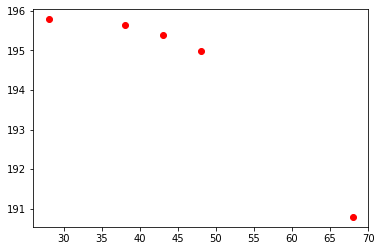

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  100
fixed Jt:  0.7
fixed Nf:  230
fixed Bk:  5.2
start Tn:  88
start Jt:  0.9
start Nf:  216
start Bk:  5.16
stepping:  50
Temperature:  [18.]
rewaRD::  -100
stepping:  50
Temperature:  [18. 48.]
rewaRD::  -100
stepping:  50
Temperature:  [18. 48. 78.]
rewaRD::  -100
stepping:  50
Temperature:  [18. 48. 78. 83.]
rewaRD::  -100
stepping:  50
Temperature:  [18. 48. 78. 83. 93.]
ORDER PARAM RESULT (X2): 88.69598521585867
THE JT RESULT {X0}: 0.6837768146789461
THE NF RESULT {X1}: 218.72473505173747
THE BK RESULT {X3}: 7.999440313452852
chisqds:  85.89072962718232


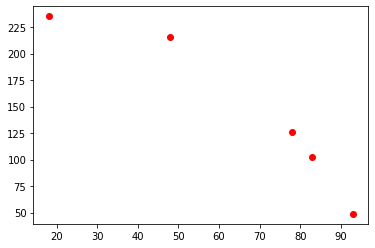

rewaRD::  -95.34291998989598
stepping:  50
Temperature:  [ 18.  48.  78.  83.  93. 118.]
ORDER PARAM RESULT (X2): 89.68937326358409
THE JT RESULT {X0}: 0.400002110048659
THE NF RESULT {X1}: 222.40440995463325
THE BK RESULT {X3}: 6.481566430354545
chisqds:  36.21620334183322


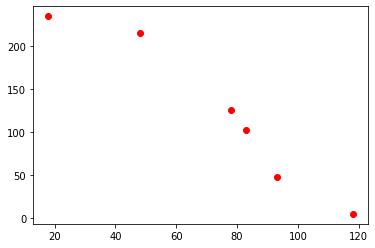

rewaRD::  -88.95521995432466
stepping:  50
Temperature:  [ 18.  48.  78.  83.  93. 118. 148.]
ORDER PARAM RESULT (X2): 99.9999999999999
THE JT RESULT {X0}: 0.6999999999999799
THE NF RESULT {X1}: 229.99999999999997
THE BK RESULT {X3}: 5.2
chisqds:  8.045850418231293e-27


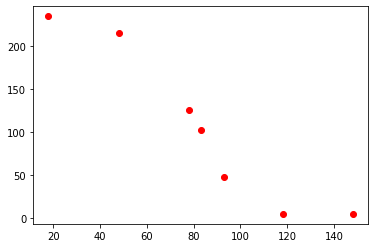

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  200
fixed Jt:  0.8
fixed Nf:  230
fixed Bk:  6.0
start Tn:  194
start Jt:  0.88
start Nf:  244
start Bk:  5.98
stepping:  51
Temperature:  [13.]
rewaRD::  -100
stepping:  51
Temperature:  [13. 14.]
rewaRD::  -100
stepping:  51
Temperature:  [13. 14. 44.]
rewaRD::  -100
stepping:  51
Temperature:  [13. 14. 44. 69.]
rewaRD::  -100
stepping:  51
Temperature:  [13. 14. 44. 69. 84.]
ORDER PARAM RESULT (X2): 200.0000000002255
THE JT RESULT {X0}: 0.8000000000009347
THE NF RESULT {X1}: 230.000000000655
THE BK RESULT {X3}: 5.999999999344932
chisqds:  8.962858161338944e-25


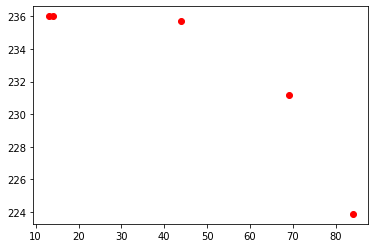

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  260
fixed Jt:  1.1
fixed Nf:  400
fixed Bk:  3.6
start Tn:  268
start Jt:  1.18
start Nf:  406
start Bk:  3.74
stepping:  52
Temperature:  [8.]
rewaRD::  -100
stepping:  52
Temperature:  [ 8. 33.]
rewaRD::  -100
stepping:  52
Temperature:  [ 8. 33. 38.]
rewaRD::  -100
stepping:  52
Temperature:  [ 8. 33. 38. 43.]
rewaRD::  -100
stepping:  52
Temperature:  [ 8. 33. 38. 43. 63.]
ORDER PARAM RESULT (X2): 260.00000006809785
THE JT RESULT {X0}: 1.1000000005429882
THE NF RESULT {X1}: 400.0000002074343
THE BK RESULT {X3}: 3.599999792565709
chisqds:  3.902984162940759e-26


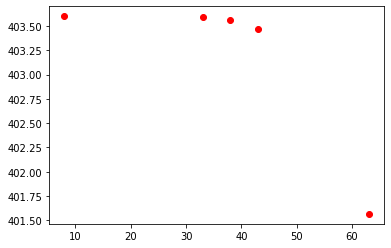

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  250
fixed Jt:  0.8
fixed Nf:  370
fixed Bk:  6.4
start Tn:  268
start Jt:  0.8
start Nf:  370
start Bk:  6.2
stepping:  53
Temperature:  [4.]
rewaRD::  -100
stepping:  53
Temperature:  [ 4. 19.]
rewaRD::  -100
stepping:  53
Temperature:  [ 4. 19. 24.]
rewaRD::  -100
stepping:  53
Temperature:  [ 4. 19. 24. 54.]
rewaRD::  -100
stepping:  53
Temperature:  [ 4. 19. 24. 54. 69.]
ORDER PARAM RESULT (X2): 249.99999565572517
THE JT RESULT {X0}: 0.7999999692165074
THE NF RESULT {X1}: 369.99998491028634
THE BK RESULT {X3}: 6.4000150897135875
chisqds:  2.4123793411695085e-24


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


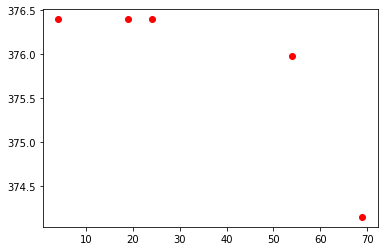

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  120
fixed Jt:  1.3
fixed Nf:  200
fixed Bk:  7.6
start Tn:  114
start Jt:  1.2
start Nf:  196
start Bk:  7.48
stepping:  54
Temperature:  [18.]
rewaRD::  -100
stepping:  54
Temperature:  [18. 19.]
rewaRD::  -100
stepping:  54
Temperature:  [18. 19. 49.]
rewaRD::  -100
stepping:  54
Temperature:  [18. 19. 49. 64.]
rewaRD::  -100
stepping:  54
Temperature:  [18. 19. 49. 64. 69.]
ORDER PARAM RESULT (X2): 120.00000000001992
THE JT RESULT {X0}: 1.3000000000002836
THE NF RESULT {X1}: 200.00000000007782
THE BK RESULT {X3}: 7.59999999992218
chisqds:  1.2019542491641998e-27


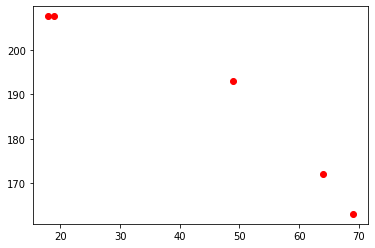

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  200
fixed Jt:  1.4
fixed Nf:  390
fixed Bk:  5.4
start Tn:  180
start Jt:  1.22
start Nf:  406
start Bk:  5.36
stepping:  55
Temperature:  [28.]
rewaRD::  -100
stepping:  55
Temperature:  [28. 38.]
rewaRD::  -100
stepping:  55
Temperature:  [28. 38. 39.]
rewaRD::  -100
stepping:  55
Temperature:  [28. 38. 39. 44.]
rewaRD::  -100
stepping:  55
Temperature:  [28. 38. 39. 44. 74.]
ORDER PARAM RESULT (X2): 179.26388895184752
THE JT RESULT {X0}: 1.2850043193388054
THE NF RESULT {X1}: 400.55003027212643
THE BK RESULT {X3}: 0.10000349064757705
chisqds:  0.25577575963679083


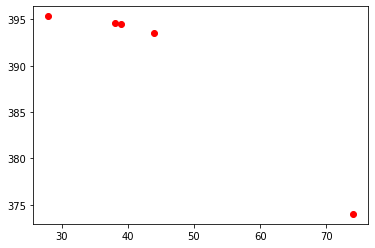

rewaRD::  300
stepping:  55
Temperature:  [28. 38. 39. 44. 74. 84.]
ORDER PARAM RESULT (X2): 181.5297856649132
THE JT RESULT {X0}: 1.2088840976856945
THE NF RESULT {X1}: 400.31563219630254
THE BK RESULT {X3}: 0.10000551861498444
chisqds:  0.13815472234004847


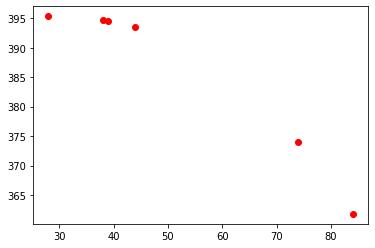

rewaRD::  300
stepping:  55
Temperature:  [28. 38. 39. 44. 74. 84. 85.]
ORDER PARAM RESULT (X2): 182.24426622726418
THE JT RESULT {X0}: 1.1794719517484884
THE NF RESULT {X1}: 400.1236037589194
THE BK RESULT {X3}: 0.10000367443759385
chisqds:  0.09092754967760185


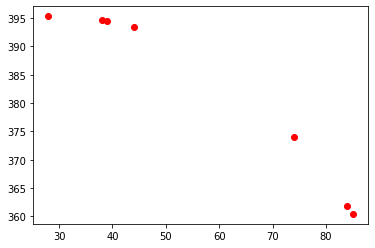

rewaRD::  300
stepping:  55
Temperature:  [28. 38. 39. 44. 74. 84. 85. 90.]
ORDER PARAM RESULT (X2): 182.9963853422243
THE JT RESULT {X0}: 1.1519520293907994
THE NF RESULT {X1}: 399.8978310518712
THE BK RESULT {X3}: 0.1000102590412821
chisqds:  0.06816100493578628


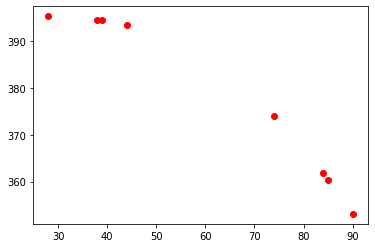

rewaRD::  300
stepping:  55
Temperature:  [ 28.  38.  39.  44.  74.  84.  85.  90. 100.]
ORDER PARAM RESULT (X2): 184.4328588984941
THE JT RESULT {X0}: 1.1134710691546255
THE NF RESULT {X1}: 399.45518340808053
THE BK RESULT {X3}: 0.1000112106506171
chisqds:  0.057033704073325905


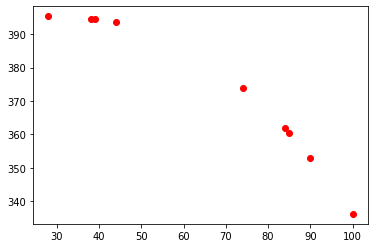

rewaRD::  300
stepping:  55
Temperature:  [ 28.  38.  39.  44.  74.  84.  85.  90. 100. 130.]
ORDER PARAM RESULT (X2): 199.99999999988765
THE JT RESULT {X0}: 1.3999999999994264
THE NF RESULT {X1}: 389.99999999959704
THE BK RESULT {X3}: 5.400000000402668
chisqds:  2.5093329469273105e-24


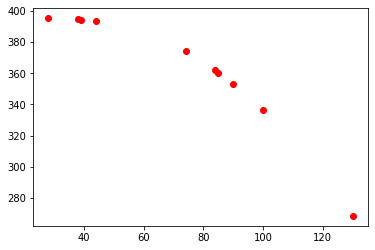

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  130
fixed Jt:  1.4
fixed Nf:  380
fixed Bk:  7.2
start Tn:  114
start Jt:  1.44
start Nf:  380
start Bk:  7.18
stepping:  56
Temperature:  [8.]
rewaRD::  -100
stepping:  56
Temperature:  [8. 9.]
rewaRD::  -100
stepping:  56
Temperature:  [ 8.  9. 24.]
rewaRD::  -100
stepping:  56
Temperature:  [ 8.  9. 24. 54.]
rewaRD::  -100
stepping:  56
Temperature:  [ 8.  9. 24. 54. 59.]
ORDER PARAM RESULT (X2): 115.3567253628935
THE JT RESULT {X0}: 1.3549332052181522
THE NF RESULT {X1}: 380.77789048566524
THE BK RESULT {X3}: 7.999511716583614
chisqds:  1.2882613145477526


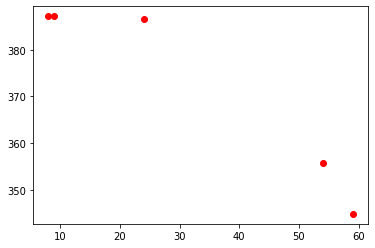

rewaRD::  210.49601154903968
stepping:  56
Temperature:  [ 8.  9. 24. 54. 59. 60.]
ORDER PARAM RESULT (X2): 115.0075718487809
THE JT RESULT {X0}: 1.3747837162571417
THE NF RESULT {X1}: 380.8044972189163
THE BK RESULT {X3}: 7.999292706668337
chisqds:  1.2435990760901219


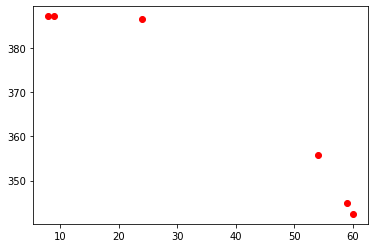

rewaRD::  221.6470707405162
stepping:  56
Temperature:  [ 8.  9. 24. 54. 59. 60. 61.]
ORDER PARAM RESULT (X2): 114.84461353324754
THE JT RESULT {X0}: 1.3840013683540164
THE NF RESULT {X1}: 380.8289396364459
THE BK RESULT {X3}: 7.999902766539055
chisqds:  1.2738895946780244


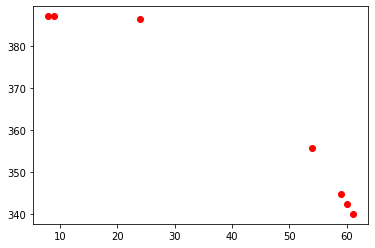

rewaRD::  213.99895381129943
stepping:  56
Temperature:  [ 8.  9. 24. 54. 59. 60. 61. 86.]
ORDER PARAM RESULT (X2): 114.54070063779332
THE JT RESULT {X0}: 1.3910095537821672
THE NF RESULT {X1}: 380.7705442398944
THE BK RESULT {X3}: 7.999763625480918
chisqds:  3.5891272395633647


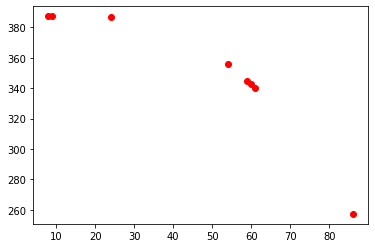

rewaRD::  11.447706726792447
stepping:  56
Temperature:  [ 8.  9. 24. 54. 59. 60. 61. 86. 87.]
ORDER PARAM RESULT (X2): 114.4246911597807
THE JT RESULT {X0}: 1.3942334014921827
THE NF RESULT {X1}: 380.77615609323846
THE BK RESULT {X3}: 7.999365555013425
chisqds:  5.190556163988154


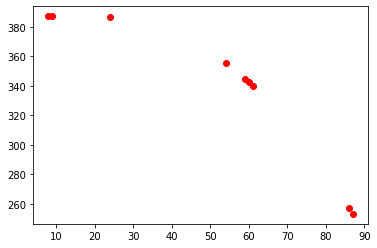

rewaRD::  -22.936967183751506
stepping:  56
Temperature:  [  8.   9.  24.  54.  59.  60.  61.  86.  87. 112.]
ORDER PARAM RESULT (X2): 114.24958409783439
THE JT RESULT {X0}: 1.4100627733656539
THE NF RESULT {X1}: 380.49544610825853
THE BK RESULT {X3}: 7.999582858977088
chisqds:  17.74171958809657


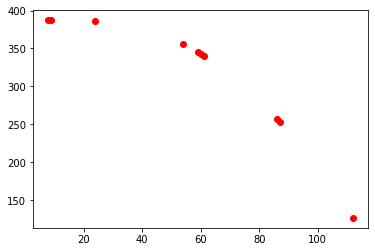

rewaRD::  -77.45427110298985
stepping:  56
Temperature:  [  8.   9.  24.  54.  59.  60.  61.  86.  87. 112. 122.]
ORDER PARAM RESULT (X2): 114.22692893770808
THE JT RESULT {X0}: 1.4127798576955677
THE NF RESULT {X1}: 380.44993245038626
THE BK RESULT {X3}: 7.999436580802865
chisqds:  22.14321715639463


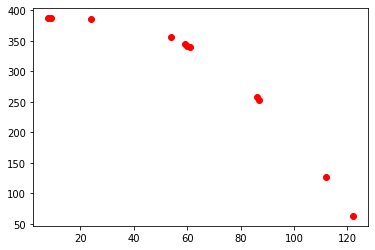

rewaRD::  -81.93577757130535
stepping:  56
Temperature:  [  8.   9.  24.  54.  59.  60.  61.  86.  87. 112. 122. 142.]
ORDER PARAM RESULT (X2): 114.8664978097043
THE JT RESULT {X0}: 1.3395150052239002
THE NF RESULT {X1}: 381.6416164373738
THE BK RESULT {X3}: 7.999278773619821
chisqds:  17.62921551633368


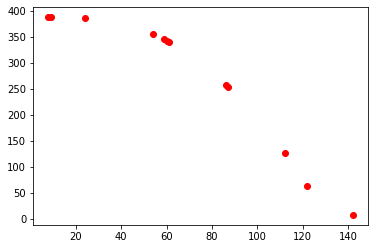

rewaRD::  -77.31039139947009
stepping:  56
Temperature:  [  8.   9.  24.  54.  59.  60.  61.  86.  87. 112. 122. 142. 143.]
ORDER PARAM RESULT (X2): 115.56109276794483
THE JT RESULT {X0}: 1.2686976015442686
THE NF RESULT {X1}: 382.6878993847172
THE BK RESULT {X3}: 7.999444018536688
chisqds:  14.169723846316593


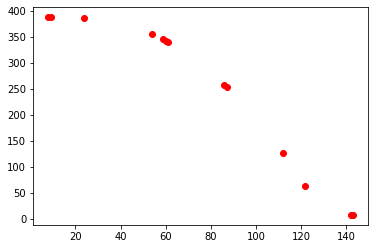

rewaRD::  -71.77079777006524
stepping:  56
Temperature:  [  8.   9.  24.  54.  59.  60.  61.  86.  87. 112. 122. 142. 143. 148.]
ORDER PARAM RESULT (X2): 116.25516600829951
THE JT RESULT {X0}: 1.1981445169136158
THE NF RESULT {X1}: 383.76720220031496
THE BK RESULT {X3}: 7.999317502407603
chisqds:  11.523147796345214


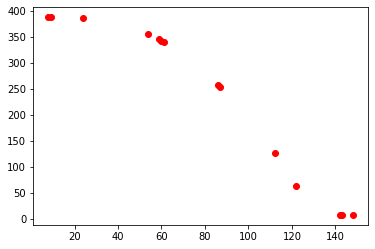

rewaRD::  -65.28726290164676
stepping:  56
Temperature:  [  8.   9.  24.  54.  59.  60.  61.  86.  87. 112. 122. 142. 143. 148.
 163.]
ORDER PARAM RESULT (X2): 117.03360245316937
THE JT RESULT {X0}: 1.1278661944626296
THE NF RESULT {X1}: 384.7094145696228
THE BK RESULT {X3}: 7.999353136461952
chisqds:  9.388169983495574


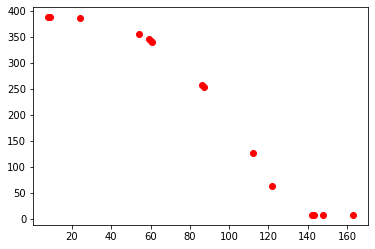

rewaRD::  -57.393187308793834
stepping:  56
Temperature:  [  8.   9.  24.  54.  59.  60.  61.  86.  87. 112. 122. 142. 143. 148.
 163. 164.]
ORDER PARAM RESULT (X2): 118.02510734497928
THE JT RESULT {X0}: 1.0680334141800285
THE NF RESULT {X1}: 385.02736872599434
THE BK RESULT {X3}: 7.9992208165410315
chisqds:  7.590790030815403


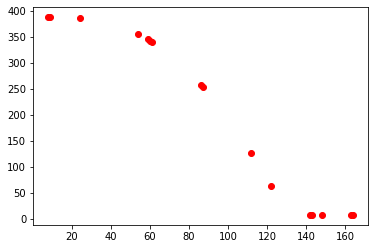

rewaRD::  -47.304562716638344
stepping:  56
Temperature:  [  8.   9.  24.  54.  59.  60.  61.  86.  87. 112. 122. 142. 143. 148.
 163. 164. 189.]
ORDER PARAM RESULT (X2): 119.00060653132475
THE JT RESULT {X0}: 0.9957271617574005
THE NF RESULT {X1}: 385.62994463071647
THE BK RESULT {X3}: 7.999225704241622
chisqds:  6.204442782107145


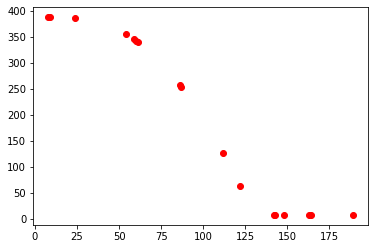

rewaRD::  -35.530068686659305
stepping:  56
Temperature:  [  8.   9.  24.  54.  59.  60.  61.  86.  87. 112. 122. 142. 143. 148.
 163. 164. 189. 204.]
ORDER PARAM RESULT (X2): 120.00454164305997
THE JT RESULT {X0}: 0.9261307113720787
THE NF RESULT {X1}: 385.96242156521527
THE BK RESULT {X3}: 7.9994130262777245
chisqds:  5.151534202307533


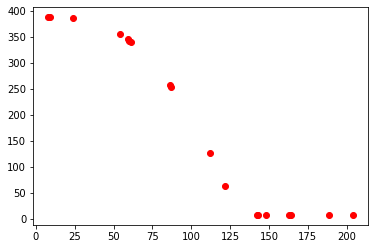

rewaRD::  -22.353228321608057
stepping:  56
Temperature:  [  8.   9.  24.  54.  59.  60.  61.  86.  87. 112. 122. 142. 143. 148.
 163. 164. 189. 204. 209.]
ORDER PARAM RESULT (X2): 129.99999999999713
THE JT RESULT {X0}: 1.400000000000024
THE NF RESULT {X1}: 380.00000000000006
THE BK RESULT {X3}: 7.2
chisqds:  4.903734377848286e-25


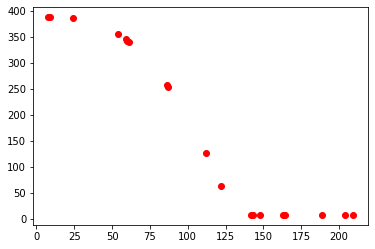

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  270
fixed Jt:  1.0
fixed Nf:  150
fixed Bk:  7.6
start Tn:  282
start Jt:  1.28
start Nf:  146
start Bk:  7.66
stepping:  57
Temperature:  [28.]
rewaRD::  -100
stepping:  57
Temperature:  [28. 33.]
rewaRD::  -100
stepping:  57
Temperature:  [28. 33. 53.]
rewaRD::  -100
stepping:  57
Temperature:  [28. 33. 53. 63.]
rewaRD::  -100
stepping:  57
Temperature:  [28. 33. 53. 63. 88.]
ORDER PARAM RESULT (X2): 288.8720461562385
THE JT RESULT {X0}: 1.1785074662099329
THE NF RESULT {X1}: 146.34366316736757
THE BK RESULT {X3}: 7.999775567746747
chisqds:  0.3230555282764671


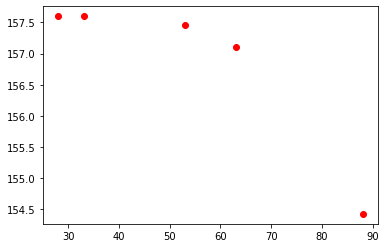

rewaRD::  300
stepping:  57
Temperature:  [ 28.  33.  53.  63.  88. 103.]
ORDER PARAM RESULT (X2): 286.41106363268705
THE JT RESULT {X0}: 1.2082348639319678
THE NF RESULT {X1}: 146.3501846666578
THE BK RESULT {X3}: 7.999848749808923
chisqds:  0.19411564203176615


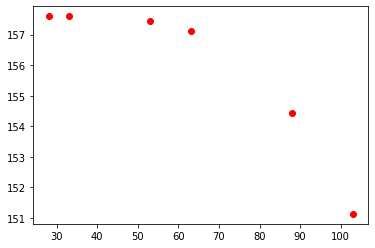

rewaRD::  300
stepping:  57
Temperature:  [ 28.  33.  53.  63.  88. 103. 133.]
ORDER PARAM RESULT (X2): 284.0775366075468
THE JT RESULT {X0}: 1.2344423605500219
THE NF RESULT {X1}: 146.35277048156286
THE BK RESULT {X3}: 7.999764237029256
chisqds:  0.15051454527721406


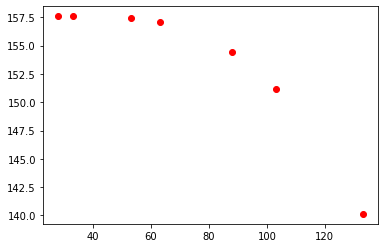

rewaRD::  300
stepping:  57
Temperature:  [ 28.  33.  53.  63.  88. 103. 133. 163.]
ORDER PARAM RESULT (X2): 282.93005726916607
THE JT RESULT {X0}: 1.2489896988310834
THE NF RESULT {X1}: 146.36710375412542
THE BK RESULT {X3}: 7.999425500025595
chisqds:  0.11999760964634068


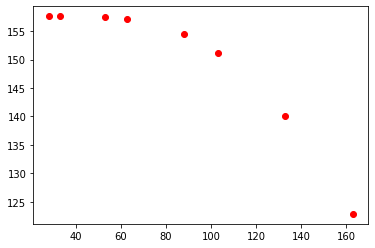

rewaRD::  300
stepping:  57
Temperature:  [ 28.  33.  53.  63.  88. 103. 133. 163. 193.]
ORDER PARAM RESULT (X2): 282.1313658356548
THE JT RESULT {X0}: 1.2613329557184385
THE NF RESULT {X1}: 146.42464887090952
THE BK RESULT {X3}: 7.999250166492227
chisqds:  0.10644269788554539


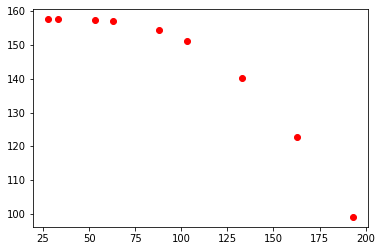

rewaRD::  300
stepping:  57
Temperature:  [ 28.  33.  53.  63.  88. 103. 133. 163. 193. 203.]
ORDER PARAM RESULT (X2): 281.63212292239757
THE JT RESULT {X0}: 1.2748510242456976
THE NF RESULT {X1}: 146.50333509896305
THE BK RESULT {X3}: 7.999905897179202
chisqds:  0.1026339231656872


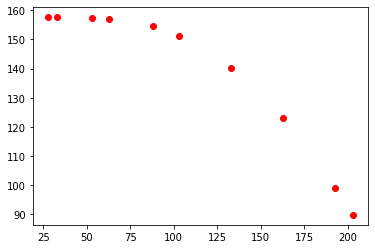

rewaRD::  300
stepping:  57
Temperature:  [ 28.  33.  53.  63.  88. 103. 133. 163. 193. 203. 233.]
ORDER PARAM RESULT (X2): 278.84135874759545
THE JT RESULT {X0}: 1.3251869083261512
THE NF RESULT {X1}: 147.39738967841728
THE BK RESULT {X3}: 7.999341670295322
chisqds:  0.12416596549856


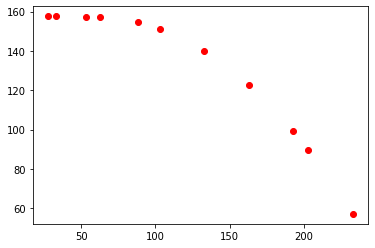

rewaRD::  300
stepping:  57
Temperature:  [ 28.  33.  53.  63.  88. 103. 133. 163. 193. 203. 233. 238.]
ORDER PARAM RESULT (X2): 269.9999999992075
THE JT RESULT {X0}: 0.9999999999971128
THE NF RESULT {X1}: 149.99999999904037
THE BK RESULT {X3}: 7.600000000959471
chisqds:  1.4840337899755573e-22


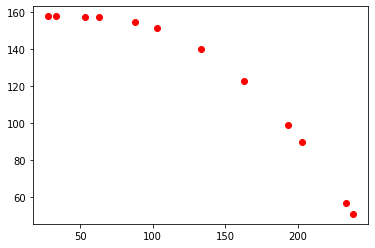

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  170
fixed Jt:  1.1
fixed Nf:  190
fixed Bk:  4.0
start Tn:  178
start Jt:  0.84
start Nf:  204
start Bk:  4.02
stepping:  58
Temperature:  [8.]
rewaRD::  -100
stepping:  58
Temperature:  [8. 9.]
rewaRD::  -100
stepping:  58
Temperature:  [ 8.  9. 24.]
rewaRD::  -100
stepping:  58
Temperature:  [ 8.  9. 24. 39.]
rewaRD::  -100
stepping:  58
Temperature:  [ 8.  9. 24. 39. 64.]
ORDER PARAM RESULT (X2): 160.72979945307452
THE JT RESULT {X0}: 1.2533956817046108
THE NF RESULT {X1}: 200.0619737610714
THE BK RESULT {X3}: 0.10000153585431332
chisqds:  0.7609895989018761


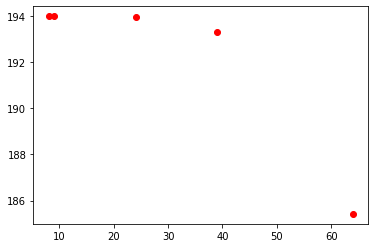

rewaRD::  300
stepping:  58
Temperature:  [ 8.  9. 24. 39. 64. 74.]
ORDER PARAM RESULT (X2): 169.99999999998147
THE JT RESULT {X0}: 1.0999999999998071
THE NF RESULT {X1}: 189.9999999999512
THE BK RESULT {X3}: 4.0000000000488
chisqds:  2.610282726174927e-29


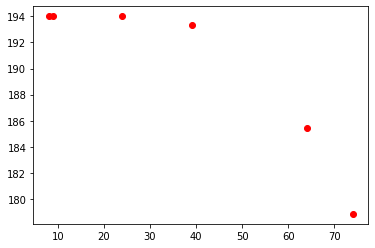

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  80
fixed Jt:  1.4
fixed Nf:  300
fixed Bk:  3.2
start Tn:  98
start Jt:  1.5
start Nf:  288
start Bk:  3.3
stepping:  59
Temperature:  [8.]
rewaRD::  -100
stepping:  59
Temperature:  [8. 9.]
rewaRD::  -100
stepping:  59
Temperature:  [ 8.  9. 10.]
rewaRD::  -100
stepping:  59
Temperature:  [ 8.  9. 10. 11.]
rewaRD::  -100
stepping:  59
Temperature:  [ 8.  9. 10. 11. 41.]
ORDER PARAM RESULT (X2): 90.392785355014
THE JT RESULT {X0}: 1.999849964066223
THE NF RESULT {X1}: 292.31541477337345
THE BK RESULT {X3}: 7.261294668240094
chisqds:  0.22130653134306608


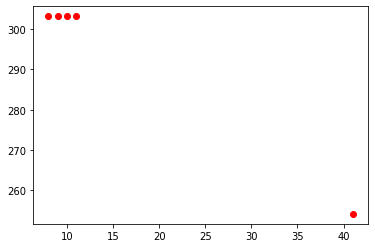

rewaRD::  300
stepping:  59
Temperature:  [ 8.  9. 10. 11. 41. 71.]
ORDER PARAM RESULT (X2): 95.05588995480903
THE JT RESULT {X0}: 1.936371392092972
THE NF RESULT {X1}: 286.23213472434463
THE BK RESULT {X3}: 0.10001097234283829
chisqds:  25.12419313362178


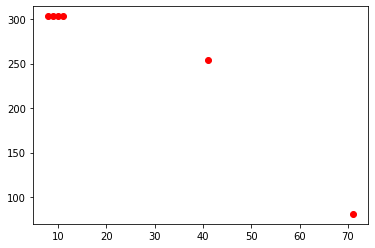

rewaRD::  -84.07909070462006
stepping:  59
Temperature:  [ 8.  9. 10. 11. 41. 71. 81.]
ORDER PARAM RESULT (X2): 97.26616182695876
THE JT RESULT {X0}: 1.7206510818877563
THE NF RESULT {X1}: 281.7551700164861
THE BK RESULT {X3}: 0.10000950222498954
chisqds:  1008.031803441086


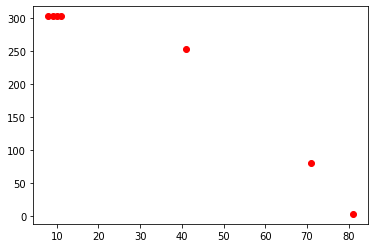

rewaRD::  -100
stepping:  59
Temperature:  [ 8.  9. 10. 11. 41. 71. 81. 96.]
ORDER PARAM RESULT (X2): 97.54178407450799
THE JT RESULT {X0}: 1.8706443163796866
THE NF RESULT {X1}: 277.12034181134123
THE BK RESULT {X3}: 0.10000478162144527
chisqds:  728.9310047731608


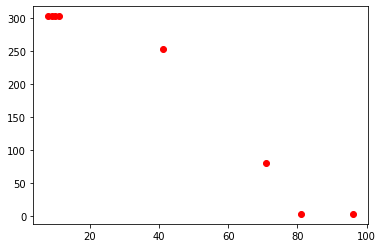

rewaRD::  -100
stepping:  59
Temperature:  [  8.   9.  10.  11.  41.  71.  81.  96. 106.]
ORDER PARAM RESULT (X2): 97.3481156562322
THE JT RESULT {X0}: 1.9998049458529512
THE NF RESULT {X1}: 272.53035762779814
THE BK RESULT {X3}: 0.22904032130018595
chisqds:  540.4947391562944


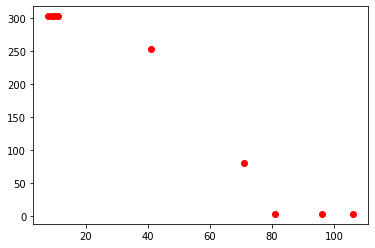

rewaRD::  -100
stepping:  59
Temperature:  [  8.   9.  10.  11.  41.  71.  81.  96. 106. 121.]
ORDER PARAM RESULT (X2): 97.34486929231394
THE JT RESULT {X0}: 1.9999531697727482
THE NF RESULT {X1}: 272.51650298748166
THE BK RESULT {X3}: 0.988534368323469
chisqds:  458.0987020954797


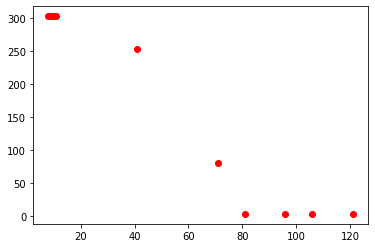

rewaRD::  -100
stepping:  59
Temperature:  [  8.   9.  10.  11.  41.  71.  81.  96. 106. 121. 146.]
ORDER PARAM RESULT (X2): 97.34533307497252
THE JT RESULT {X0}: 1.9999234936832815
THE NF RESULT {X1}: 272.5641719914883
THE BK RESULT {X3}: 1.453583755718196
chisqds:  396.95639818738437


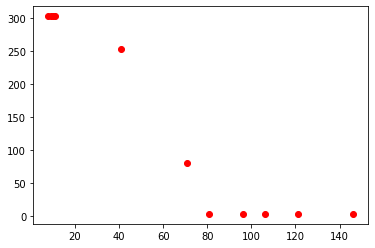

rewaRD::  -100
stepping:  59
Temperature:  [  8.   9.  10.  11.  41.  71.  81.  96. 106. 121. 146. 147.]
ORDER PARAM RESULT (X2): 97.33516068389794
THE JT RESULT {X0}: 1.9998586492786212
THE NF RESULT {X1}: 272.34630266196746
THE BK RESULT {X3}: 1.7372673374415784
chisqds:  348.6496050987015


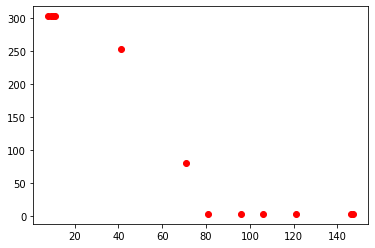

rewaRD::  -100
stepping:  59
Temperature:  [  8.   9.  10.  11.  41.  71.  81.  96. 106. 121. 146. 147. 162.]
ORDER PARAM RESULT (X2): 97.34279853927617
THE JT RESULT {X0}: 1.9999681233235485
THE NF RESULT {X1}: 272.54505240315973
THE BK RESULT {X3}: 1.9762179684863024
chisqds:  312.2433127752724


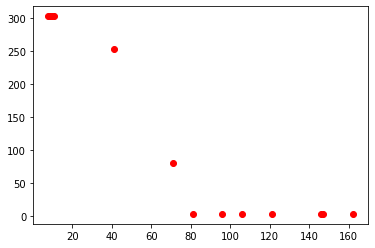

rewaRD::  -100
stepping:  59
Temperature:  [  8.   9.  10.  11.  41.  71.  81.  96. 106. 121. 146. 147. 162. 177.]
ORDER PARAM RESULT (X2): 97.34461694749238
THE JT RESULT {X0}: 1.99980895997221
THE NF RESULT {X1}: 272.6010026249171
THE BK RESULT {X3}: 2.1446888997460873
chisqds:  282.2445871094248


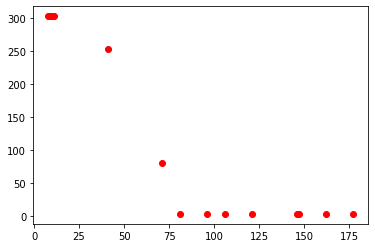

rewaRD::  -98.5827894731426
stepping:  59
Temperature:  [  8.   9.  10.  11.  41.  71.  81.  96. 106. 121. 146. 147. 162. 177.
 187.]
ORDER PARAM RESULT (X2): 97.34445635143905
THE JT RESULT {X0}: 1.9998171722865332
THE NF RESULT {X1}: 272.6071014311086
THE BK RESULT {X3}: 2.272408298104021
chisqds:  257.3180513528781


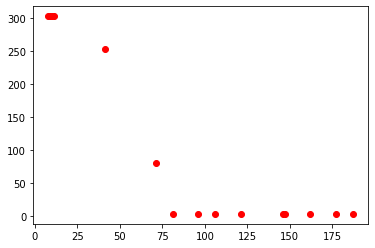

rewaRD::  -98.44550353969744
stepping:  59
Temperature:  [  8.   9.  10.  11.  41.  71.  81.  96. 106. 121. 146. 147. 162. 177.
 187. 202.]
ORDER PARAM RESULT (X2): 97.3442676178636
THE JT RESULT {X0}: 1.9998085508752934
THE NF RESULT {X1}: 272.6105604424784
THE BK RESULT {X3}: 2.3744525679319186
chisqds:  236.40800653840552


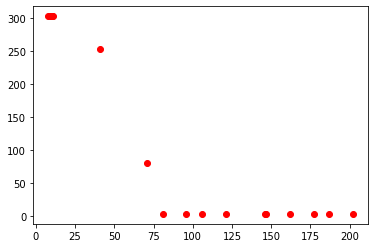

rewaRD::  -98.30800992801817
stepping:  59
Temperature:  [  8.   9.  10.  11.  41.  71.  81.  96. 106. 121. 146. 147. 162. 177.
 187. 202. 227.]
ORDER PARAM RESULT (X2): 97.34401369346115
THE JT RESULT {X0}: 1.999828654659948
THE NF RESULT {X1}: 272.6114151690324
THE BK RESULT {X3}: 2.4577876675069152
chisqds:  218.61829651321068


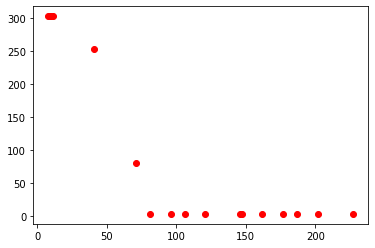

rewaRD::  -98.17032697455024
stepping:  59
Temperature:  [  8.   9.  10.  11.  41.  71.  81.  96. 106. 121. 146. 147. 162. 177.
 187. 202. 227. 247.]
ORDER PARAM RESULT (X2): 97.34274714583842
THE JT RESULT {X0}: 1.999902389756551
THE NF RESULT {X1}: 272.5869544592661
THE BK RESULT {X3}: 2.5259871286777478
chisqds:  203.24253369330972


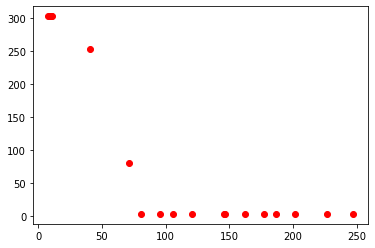

rewaRD::  -98.031908022739
stepping:  59
Temperature:  [  8.   9.  10.  11.  41.  71.  81.  96. 106. 121. 146. 147. 162. 177.
 187. 202. 227. 247. 277.]
ORDER PARAM RESULT (X2): 97.34319540418545
THE JT RESULT {X0}: 1.9999024760687183
THE NF RESULT {X1}: 272.6020944918999
THE BK RESULT {X3}: 2.5855618285523363
chisqds:  189.97052261364755


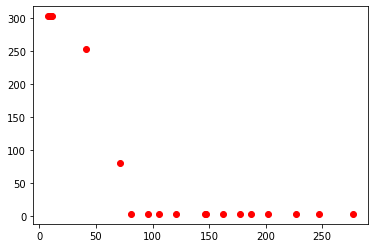

rewaRD::  -97.89441017218498
stepping:  59
Temperature:  [  8.   9.  10.  11.  41.  71.  81.  96. 106. 121. 146. 147. 162. 177.
 187. 202. 227. 247. 277. 302.]
ORDER PARAM RESULT (X2): 97.34326368712367
THE JT RESULT {X0}: 1.9998675676362767
THE NF RESULT {X1}: 272.6075314347877
THE BK RESULT {X3}: 2.636205088901077
chisqds:  178.30464228968998


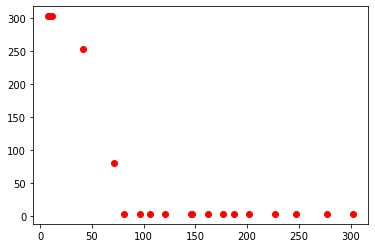

rewaRD::  -97.75664842561909
stepping:  59
Temperature:  [  8.   9.  10.  11.  41.  71.  81.  96. 106. 121. 146. 147. 162. 177.
 187. 202. 227. 247. 277. 302. 303.]
ORDER PARAM RESULT (X2): 97.3436475403272
THE JT RESULT {X0}: 1.999804010923427
THE NF RESULT {X1}: 272.6199603995887
THE BK RESULT {X3}: 2.680389603924375
chisqds:  168.00224357370027


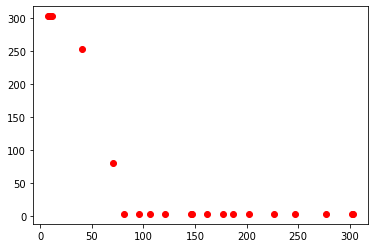

rewaRD::  -97.61907941530242
stepping:  59
Temperature:  [  8.   9.  10.  11.  41.  71.  81.  96. 106. 121. 146. 147. 162. 177.
 187. 202. 227. 247. 277. 302. 303. 323.]
ORDER PARAM RESULT (X2): 97.34308521191704
THE JT RESULT {X0}: 1.9998806450071684
THE NF RESULT {X1}: 272.60969253474104
THE BK RESULT {X3}: 2.7181873874086895
chisqds:  158.77703774501157


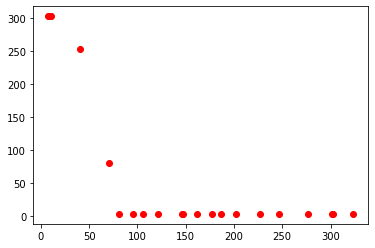

rewaRD::  -97.48074403149919
stepping:  59
Temperature:  [  8.   9.  10.  11.  41.  71.  81.  96. 106. 121. 146. 147. 162. 177.
 187. 202. 227. 247. 277. 302. 303. 323. 333.]
ORDER PARAM RESULT (X2): 97.34070203958768
THE JT RESULT {X0}: 1.9998080676606917
THE NF RESULT {X1}: 272.5562437179195
THE BK RESULT {X3}: 2.749984389458456
chisqds:  150.4330438477419


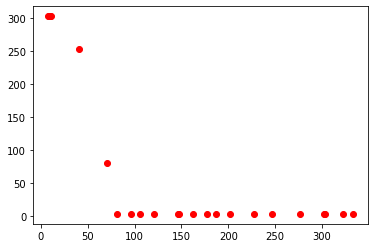

rewaRD::  -97.34100972918654
stepping:  59
Temperature:  [  8.   9.  10.  11.  41.  71.  81.  96. 106. 121. 146. 147. 162. 177.
 187. 202. 227. 247. 277. 302. 303. 323. 333. 358.]
ORDER PARAM RESULT (X2): 97.34342139867844
THE JT RESULT {X0}: 1.9998131441637554
THE NF RESULT {X1}: 272.6225429205815
THE BK RESULT {X3}: 2.7823261546838407
chisqds:  143.11989795382172


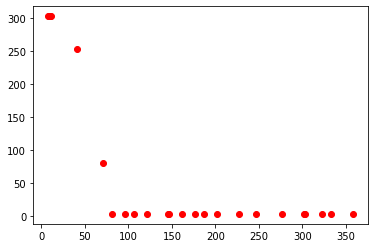

rewaRD::  -97.20514054496418
terminated: over max temp
reset
fixed Tn:  80
fixed Jt:  1.3
fixed Nf:  320
fixed Bk:  4.4
start Tn:  96
start Jt:  1.12
start Nf:  330
start Bk:  4.32
stepping:  60
Temperature:  [4.]
rewaRD::  -100
stepping:  60
Temperature:  [ 4. 29.]
rewaRD::  -100
stepping:  60
Temperature:  [ 4. 29. 49.]
rewaRD::  -100
stepping:  60
Temperature:  [ 4. 29. 49. 79.]
rewaRD::  -100
stepping:  60
Temperature:  [ 4. 29. 49. 79. 84.]
ORDER PARAM RESULT (X2): 95.3246687599734
THE JT RESULT {X0}: 1.3448068920879157
THE NF RESULT {X1}: 319.7180438508449
THE BK RESULT {X3}: 0.10001979937099328
chisqds:  2391.7450589216674


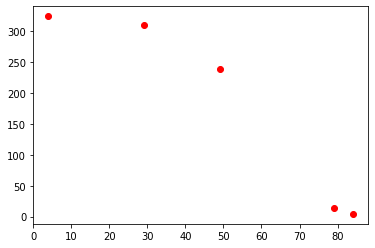

rewaRD::  -100
stepping:  60
Temperature:  [  4.  29.  49.  79.  84. 104.]
ORDER PARAM RESULT (X2): 94.79897279098299
THE JT RESULT {X0}: 1.5045236515839113
THE NF RESULT {X1}: 311.9664787941728
THE BK RESULT {X3}: 0.10000547398205205
chisqds:  1007.8875623079014


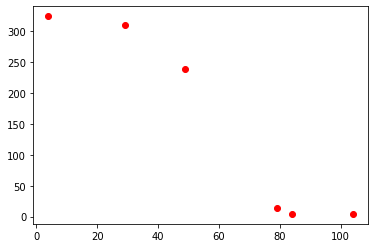

rewaRD::  -100
stepping:  60
Temperature:  [  4.  29.  49.  79.  84. 104. 134.]
ORDER PARAM RESULT (X2): 94.27170702777038
THE JT RESULT {X0}: 1.629756618988546
THE NF RESULT {X1}: 304.58216960932265
THE BK RESULT {X3}: 0.10000127368211756
chisqds:  572.4486737615842


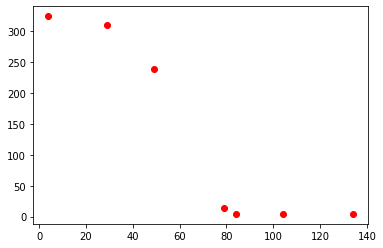

rewaRD::  -100
stepping:  60
Temperature:  [  4.  29.  49.  79.  84. 104. 134. 144.]
ORDER PARAM RESULT (X2): 93.56167019202981
THE JT RESULT {X0}: 1.8483394885169633
THE NF RESULT {X1}: 294.6327485995572
THE BK RESULT {X3}: 0.10000308956188979
chisqds:  340.38796263652887


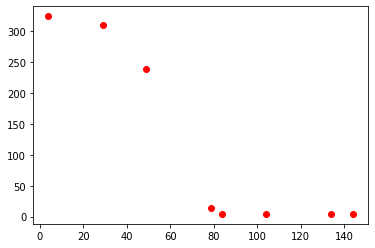

rewaRD::  -100
stepping:  60
Temperature:  [  4.  29.  49.  79.  84. 104. 134. 144. 154.]
ORDER PARAM RESULT (X2): 92.9634966132042
THE JT RESULT {X0}: 1.9508406402526162
THE NF RESULT {X1}: 287.15412698524847
THE BK RESULT {X3}: 0.10000051762123906
chisqds:  229.07061178743461


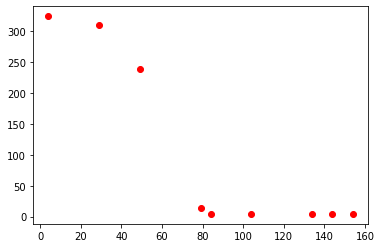

rewaRD::  -98.25381354299967
stepping:  60
Temperature:  [  4.  29.  49.  79.  84. 104. 134. 144. 154. 155.]
ORDER PARAM RESULT (X2): 92.63769479143339
THE JT RESULT {X0}: 1.9999246134310957
THE NF RESULT {X1}: 283.27279800506653
THE BK RESULT {X3}: 0.43522113327824297
chisqds:  175.57953096461617


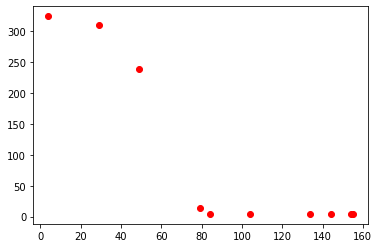

rewaRD::  -97.7218301142369
stepping:  60
Temperature:  [  4.  29.  49.  79.  84. 104. 134. 144. 154. 155. 180.]
ORDER PARAM RESULT (X2): 92.6498939526584
THE JT RESULT {X0}: 1.999898875724991
THE NF RESULT {X1}: 283.3762440649597
THE BK RESULT {X3}: 0.9958793155073612
chisqds:  153.37146754937132


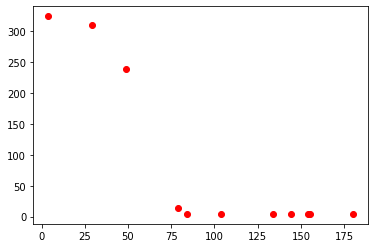

rewaRD::  -97.39195297279635
stepping:  60
Temperature:  [  4.  29.  49.  79.  84. 104. 134. 144. 154. 155. 180. 190.]
ORDER PARAM RESULT (X2): 92.64796660171834
THE JT RESULT {X0}: 1.9999718874769838
THE NF RESULT {X1}: 283.32567573670684
THE BK RESULT {X3}: 1.406786024306931
chisqds:  135.676440248413


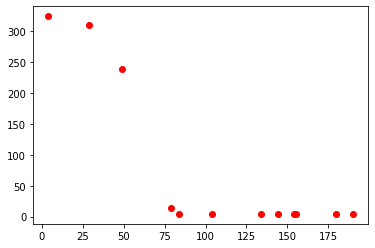

rewaRD::  -97.05180944261487
stepping:  60
Temperature:  [  4.  29.  49.  79.  84. 104. 134. 144. 154. 155. 180. 190. 195.]
ORDER PARAM RESULT (X2): 92.65070321447004
THE JT RESULT {X0}: 1.9998258330280205
THE NF RESULT {X1}: 283.33523277971193
THE BK RESULT {X3}: 1.7308553643824414
chisqds:  121.77293176698726


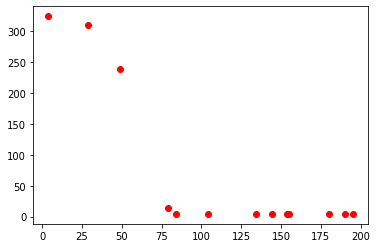

rewaRD::  -96.71519775211291
---------------------------------------
| approxkl           | 0.00027403198  |
| clipfrac           | 0.0            |
| ep_len_mean        | 10.9           |
| ep_reward_mean     | 134            |
| explained_variance | -9.06e-06      |
| fps                | 7              |
| n_updates          | 4              |
| policy_entropy     | 1.9430876      |
| policy_loss        | -0.00089608703 |
| serial_timesteps   | 512            |
| time_elapsed       | 49.3           |
| total_timesteps    | 512            |
| value_loss         | 220588.05      |
---------------------------------------
stepping:  60
Temperature:  [  4.  29.  49.  79.  84. 104. 134. 144. 154. 155. 180. 190. 195. 205.]
ORDER PARAM RESULT (X2): 92.66245664105514
THE JT RESULT {X0}: 1.9998248802449825
THE NF RESULT {X1}: 283.4539699305094
THE BK RESULT {X3}: 1.996656669482029
chisqds:  110.72561299592003


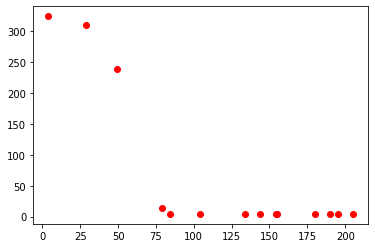

rewaRD::  -96.38746637587151
stepping:  60
Temperature:  [  4.  29.  49.  79.  84. 104. 134. 144. 154. 155. 180. 190. 195. 205.
 215.]
ORDER PARAM RESULT (X2): 92.66363847721799
THE JT RESULT {X0}: 1.9998374554387741
THE NF RESULT {X1}: 283.4532620588862
THE BK RESULT {X3}: 2.208342825373046
chisqds:  101.2715729413348


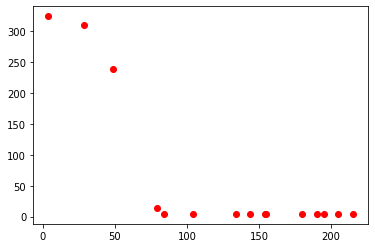

rewaRD::  -96.05022427930774
stepping:  60
Temperature:  [  4.  29.  49.  79.  84. 104. 134. 144. 154. 155. 180. 190. 195. 205.
 215. 235.]
ORDER PARAM RESULT (X2): 92.79901632764458
THE JT RESULT {X0}: 1.9998466242851038
THE NF RESULT {X1}: 284.8661249058714
THE BK RESULT {X3}: 2.4971874507978264
chisqds:  96.68064934788153


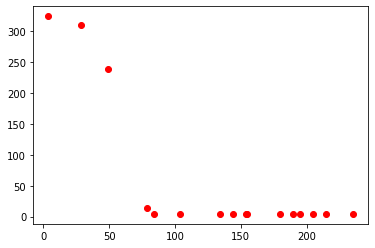

rewaRD::  -95.86266742416366
stepping:  60
Temperature:  [  4.  29.  49.  79.  84. 104. 134. 144. 154. 155. 180. 190. 195. 205.
 215. 235. 260.]
ORDER PARAM RESULT (X2): 92.78205360499513
THE JT RESULT {X0}: 1.9999864361828688
THE NF RESULT {X1}: 284.659858808522
THE BK RESULT {X3}: 2.628138527314958
chisqds:  89.1776854116643


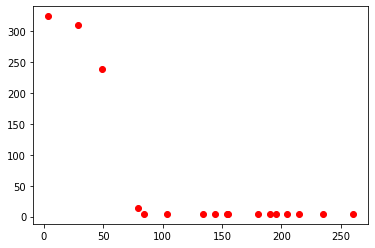

rewaRD::  -95.51457297693352
stepping:  60
Temperature:  [  4.  29.  49.  79.  84. 104. 134. 144. 154. 155. 180. 190. 195. 205.
 215. 235. 260. 270.]
ORDER PARAM RESULT (X2): 92.79595777327135
THE JT RESULT {X0}: 1.9999336161005654
THE NF RESULT {X1}: 284.818860843597
THE BK RESULT {X3}: 2.7554372245595045
chisqds:  83.38462942398635


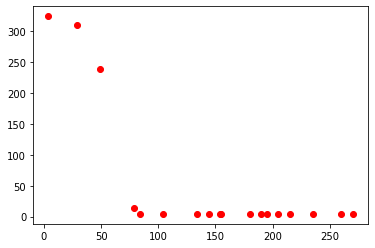

rewaRD::  -95.20295283719356
stepping:  60
Temperature:  [  4.  29.  49.  79.  84. 104. 134. 144. 154. 155. 180. 190. 195. 205.
 215. 235. 260. 270. 300.]
ORDER PARAM RESULT (X2): 92.79553619345488
THE JT RESULT {X0}: 1.9998035910737915
THE NF RESULT {X1}: 284.8094941915266
THE BK RESULT {X3}: 2.8595451194176444
chisqds:  78.03805132199331


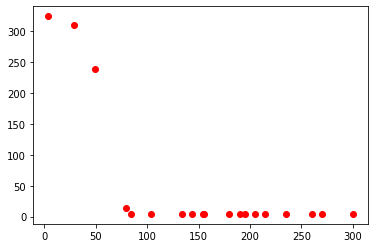

rewaRD::  -94.87429538252361
stepping:  60
Temperature:  [  4.  29.  49.  79.  84. 104. 134. 144. 154. 155. 180. 190. 195. 205.
 215. 235. 260. 270. 300. 325.]
ORDER PARAM RESULT (X2): 92.79401613645868
THE JT RESULT {X0}: 1.999939732946997
THE NF RESULT {X1}: 284.7877377558994
THE BK RESULT {X3}: 2.950330136776335
chisqds:  73.3094643681475


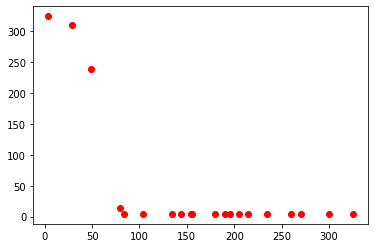

rewaRD::  -94.54367858983025
stepping:  60
Temperature:  [  4.  29.  49.  79.  84. 104. 134. 144. 154. 155. 180. 190. 195. 205.
 215. 235. 260. 270. 300. 325. 350.]
ORDER PARAM RESULT (X2): 92.794669980151
THE JT RESULT {X0}: 1.9998599068900489
THE NF RESULT {X1}: 284.79212126863786
THE BK RESULT {X3}: 3.031408600794406
chisqds:  69.15983217301921


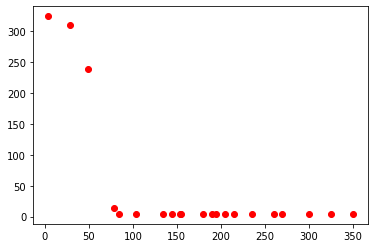

rewaRD::  -94.21629597076945
terminated: over max temp
reset
fixed Tn:  150
fixed Jt:  1.3
fixed Nf:  270
fixed Bk:  5.8
start Tn:  142
start Jt:  1.36
start Nf:  270
start Bk:  5.9
stepping:  61
Temperature:  [4.]
rewaRD::  -100
stepping:  61
Temperature:  [ 4. 24.]
rewaRD::  -100
stepping:  61
Temperature:  [ 4. 24. 39.]
rewaRD::  -100
stepping:  61
Temperature:  [ 4. 24. 39. 59.]
rewaRD::  -100
stepping:  61
Temperature:  [ 4. 24. 39. 59. 64.]
ORDER PARAM RESULT (X2): 150.0000000000561
THE JT RESULT {X0}: 1.3000000000007863
THE NF RESULT {X1}: 270.0000000002133
THE BK RESULT {X3}: 5.799999999786669
chisqds:  4.806793081757622e-28


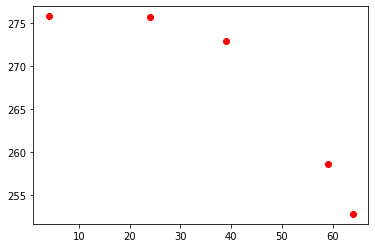

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  210
fixed Jt:  1.0
fixed Nf:  230
fixed Bk:  4.4
start Tn:  196
start Jt:  1.1
start Nf:  222
start Bk:  4.42
stepping:  62
Temperature:  [13.]
rewaRD::  -100
stepping:  62
Temperature:  [13. 23.]
rewaRD::  -100
stepping:  62
Temperature:  [13. 23. 43.]
rewaRD::  -100
stepping:  62
Temperature:  [13. 23. 43. 73.]
rewaRD::  -100
stepping:  62
Temperature:  [13. 23. 43. 73. 78.]
ORDER PARAM RESULT (X2): 206.48839136952014
THE JT RESULT {X0}: 0.8472340701247115
THE NF RESULT {X1}: 225.65736431472797
THE BK RESULT {X3}: 7.999633792848894
chisqds:  0.006938112812621433


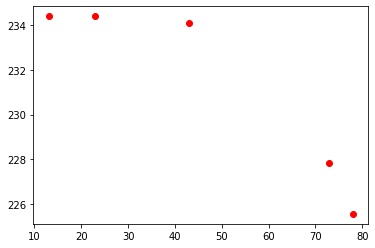

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  270
fixed Jt:  0.7
fixed Nf:  400
fixed Bk:  3.6
start Tn:  268
start Jt:  0.86
start Nf:  388
start Bk:  3.7
stepping:  63
Temperature:  [28.]
rewaRD::  -100
stepping:  63
Temperature:  [28. 43.]
rewaRD::  -100
stepping:  63
Temperature:  [28. 43. 73.]
rewaRD::  -100
stepping:  63
Temperature:  [28. 43. 73. 78.]
rewaRD::  -100
stepping:  63
Temperature:  [28. 43. 73. 78. 98.]
ORDER PARAM RESULT (X2): 285.12606438204614
THE JT RESULT {X0}: 0.6065648876844301
THE NF RESULT {X1}: 392.33551264855424
THE BK RESULT {X3}: 7.9995326929912425
chisqds:  0.07867433499732943


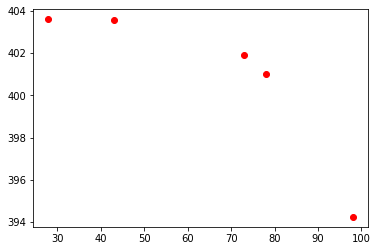

rewaRD::  300
stepping:  63
Temperature:  [ 28.  43.  73.  78.  98. 103.]
ORDER PARAM RESULT (X2): 281.5295031793044
THE JT RESULT {X0}: 0.6538076757433583
THE NF RESULT {X1}: 392.3711731649545
THE BK RESULT {X3}: 7.99968196554677
chisqds:  0.04221142857643769


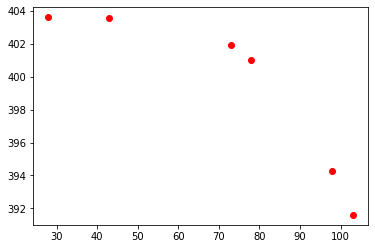

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  150
fixed Jt:  1.1
fixed Nf:  270
fixed Bk:  6.4
start Tn:  130
start Jt:  0.94
start Nf:  270
start Bk:  6.48
stepping:  64
Temperature:  [4.]
rewaRD::  -100
stepping:  64
Temperature:  [4. 5.]
rewaRD::  -100
stepping:  64
Temperature:  [ 4.  5. 15.]
rewaRD::  -100
stepping:  64
Temperature:  [ 4.  5. 15. 16.]
rewaRD::  -100
stepping:  64
Temperature:  [ 4.  5. 15. 16. 26.]
ORDER PARAM RESULT (X2): 149.77664352562198
THE JT RESULT {X0}: 1.0968751297531867
THE NF RESULT {X1}: 269.22931059470733
THE BK RESULT {X3}: 7.170689405344237
chisqds:  1.949932444139546e-22


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


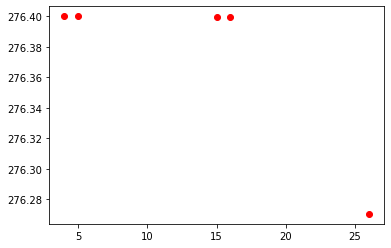

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  90
fixed Jt:  0.9
fixed Nf:  300
fixed Bk:  7.4
start Tn:  84
start Jt:  1.06
start Nf:  318
start Bk:  7.26
stepping:  65
Temperature:  [23.]
rewaRD::  -100
stepping:  65
Temperature:  [23. 38.]
rewaRD::  -100
stepping:  65
Temperature:  [23. 38. 39.]
rewaRD::  -100
stepping:  65
Temperature:  [23. 38. 39. 44.]
rewaRD::  -100
stepping:  65
Temperature:  [23. 38. 39. 44. 59.]
ORDER PARAM RESULT (X2): 90.00000000012523
THE JT RESULT {X0}: 0.900000000001318
THE NF RESULT {X1}: 300.00000000092086
THE BK RESULT {X3}: 7.399999999079871
chisqds:  3.957031585865897e-23


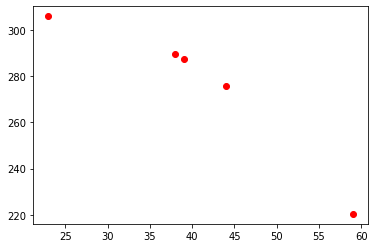

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  80
fixed Jt:  0.7
fixed Nf:  460
fixed Bk:  3.8
start Tn:  80
start Jt:  0.9
start Nf:  460
start Bk:  3.94
stepping:  66
Temperature:  [13.]
rewaRD::  -100
stepping:  66
Temperature:  [13. 33.]
rewaRD::  -100
stepping:  66
Temperature:  [13. 33. 48.]
rewaRD::  -100
stepping:  66
Temperature:  [13. 33. 48. 68.]
rewaRD::  -100
stepping:  66
Temperature:  [13. 33. 48. 68. 73.]
ORDER PARAM RESULT (X2): 80.00000000000067
THE JT RESULT {X0}: 0.7000000000000154
THE NF RESULT {X1}: 460.00000000001563
THE BK RESULT {X3}: 3.799999999984452
chisqds:  2.214864643657906e-25


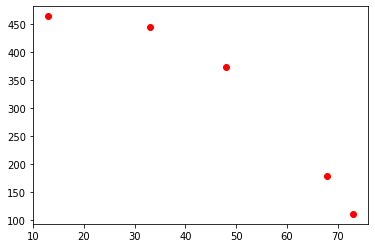

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  120
fixed Jt:  1.2
fixed Nf:  390
fixed Bk:  4.6
start Tn:  110
start Jt:  0.96
start Nf:  394
start Bk:  4.45
stepping:  67
Temperature:  [23.]
rewaRD::  -100
stepping:  67
Temperature:  [23. 28.]
rewaRD::  -100
stepping:  67
Temperature:  [23. 28. 53.]
rewaRD::  -100
stepping:  67
Temperature:  [23. 28. 53. 68.]
rewaRD::  -100
stepping:  67
Temperature:  [23. 28. 53. 68. 83.]
ORDER PARAM RESULT (X2): 120.00000000004864
THE JT RESULT {X0}: 1.200000000000384
THE NF RESULT {X1}: 390.00000000030883
THE BK RESULT {X3}: 4.59999999969157
chisqds:  9.094124568364724e-24


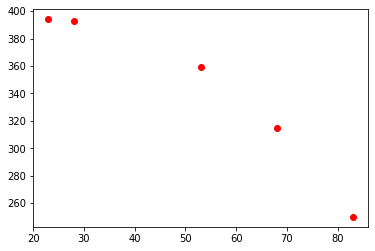

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  110
fixed Jt:  0.9
fixed Nf:  340
fixed Bk:  5.6
start Tn:  98
start Jt:  1.1
start Nf:  338
start Bk:  5.54
stepping:  68
Temperature:  [33.]
rewaRD::  -100
stepping:  68
Temperature:  [33. 34.]
rewaRD::  -100
stepping:  68
Temperature:  [33. 34. 59.]
rewaRD::  -100
stepping:  68
Temperature:  [33. 34. 59. 64.]
rewaRD::  -100
stepping:  68
Temperature:  [33. 34. 59. 64. 69.]
ORDER PARAM RESULT (X2): 99.10785223587952
THE JT RESULT {X0}: 0.9872680872789543
THE NF RESULT {X1}: 340.66516418110683
THE BK RESULT {X3}: 7.999344922829195
chisqds:  8.58852780048813


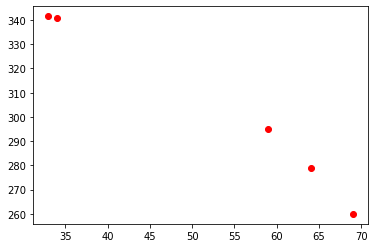

rewaRD::  -53.42624378799054
stepping:  68
Temperature:  [33. 34. 59. 64. 69. 74.]
ORDER PARAM RESULT (X2): 98.9133527376439
THE JT RESULT {X0}: 0.9937214730184316
THE NF RESULT {X1}: 340.76235366464033
THE BK RESULT {X3}: 7.999243660261315
chisqds:  8.12139002309943


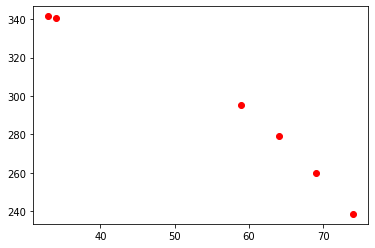

rewaRD::  -50.74734757691826
stepping:  68
Temperature:  [33. 34. 59. 64. 69. 74. 94.]
ORDER PARAM RESULT (X2): 98.5902347745345
THE JT RESULT {X0}: 1.0140136211500255
THE NF RESULT {X1}: 340.0703649092758
THE BK RESULT {X3}: 7.999277171092347
chisqds:  22.049775048857708


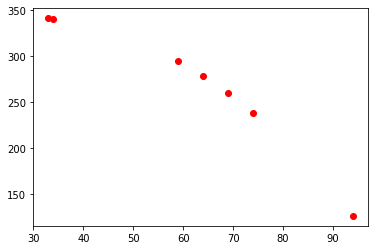

rewaRD::  -81.85922536108947
stepping:  68
Temperature:  [33. 34. 59. 64. 69. 74. 94. 99.]
ORDER PARAM RESULT (X2): 98.45758223378411
THE JT RESULT {X0}: 1.0315257217789593
THE NF RESULT {X1}: 339.70273773173636
THE BK RESULT {X3}: 7.999953168608001
chisqds:  36.327873618272605


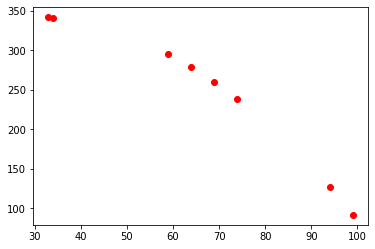

rewaRD::  -88.98917111958892
stepping:  68
Temperature:  [ 33.  34.  59.  64.  69.  74.  94.  99. 114.]
ORDER PARAM RESULT (X2): 100.93167686841832
THE JT RESULT {X0}: 0.741781187626654
THE NF RESULT {X1}: 346.03215723768517
THE BK RESULT {X3}: 7.999559422556909
chisqds:  14.902072296772582


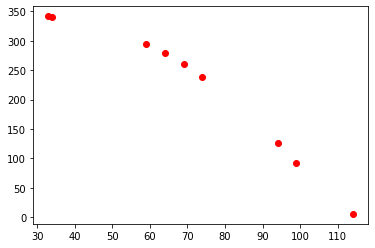

rewaRD::  -73.15809559676944
stepping:  68
Temperature:  [ 33.  34.  59.  64.  69.  74.  94.  99. 114. 119.]
ORDER PARAM RESULT (X2): 109.9999999999992
THE JT RESULT {X0}: 0.8999999999999977
THE NF RESULT {X1}: 339.99999999999983
THE BK RESULT {X3}: 5.6
chisqds:  8.497651824904021e-26


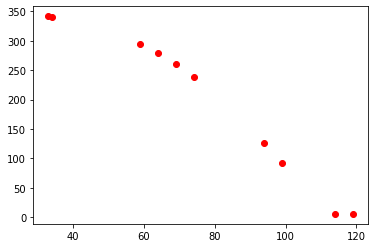

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  230
fixed Jt:  1.0
fixed Nf:  450
fixed Bk:  4.6
start Tn:  248
start Jt:  1.14
start Nf:  434
start Bk:  4.43
stepping:  69
Temperature:  [28.]
rewaRD::  -100
stepping:  69
Temperature:  [28. 48.]
rewaRD::  -100
stepping:  69
Temperature:  [28. 48. 58.]
rewaRD::  -100
stepping:  69
Temperature:  [28. 48. 58. 59.]
rewaRD::  -100
stepping:  69
Temperature:  [28. 48. 58. 59. 84.]
ORDER PARAM RESULT (X2): 259.39311106322975
THE JT RESULT {X0}: 0.9351986372485378
THE NF RESULT {X1}: 437.6060150397572
THE BK RESULT {X3}: 7.999873736462759
chisqds:  0.5864952117946703


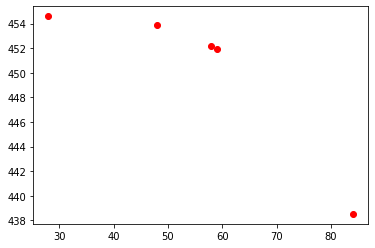

rewaRD::  300
stepping:  69
Temperature:  [ 28.  48.  58.  59.  84. 109.]
ORDER PARAM RESULT (X2): 250.78030486538307
THE JT RESULT {X0}: 1.0631431595045775
THE NF RESULT {X1}: 437.703808460922
THE BK RESULT {X3}: 7.999824755950486
chisqds:  0.34268448217877645


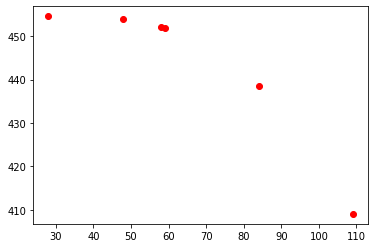

rewaRD::  300
stepping:  69
Temperature:  [ 28.  48.  58.  59.  84. 109. 110.]
ORDER PARAM RESULT (X2): 249.86545779159914
THE JT RESULT {X0}: 1.086276706178841
THE NF RESULT {X1}: 437.7774475769929
THE BK RESULT {X3}: 7.999584785759379
chisqds:  0.23156036446465922


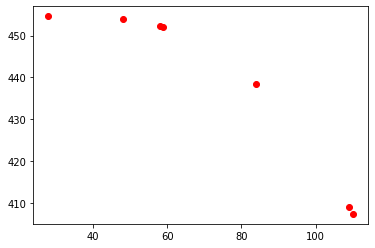

rewaRD::  300
stepping:  69
Temperature:  [ 28.  48.  58.  59.  84. 109. 110. 111.]
ORDER PARAM RESULT (X2): 249.36195301550424
THE JT RESULT {X0}: 1.098687585777286
THE NF RESULT {X1}: 437.8379530686291
THE BK RESULT {X3}: 7.999720649913966
chisqds:  0.1743407664789949


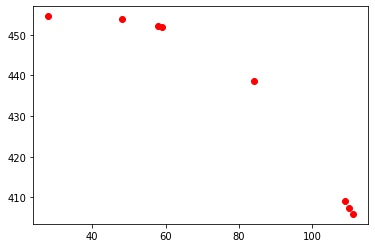

rewaRD::  300
stepping:  69
Temperature:  [ 28.  48.  58.  59.  84. 109. 110. 111. 136.]
ORDER PARAM RESULT (X2): 229.9999999999743
THE JT RESULT {X0}: 0.9999999999998211
THE NF RESULT {X1}: 449.9999999998714
THE BK RESULT {X3}: 4.600000000128616
chisqds:  1.41742700524397e-28


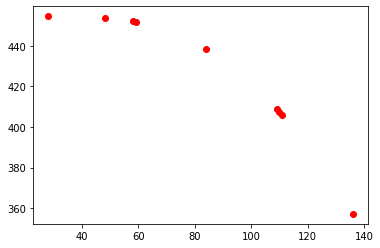

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  80
fixed Jt:  1.4
fixed Nf:  270
fixed Bk:  7.6
start Tn:  78
start Jt:  1.64
start Nf:  260
start Bk:  7.62
stepping:  70
Temperature:  [33.]
rewaRD::  -100
stepping:  70
Temperature:  [33. 38.]
rewaRD::  -100
stepping:  70
Temperature:  [33. 38. 39.]
rewaRD::  -100
stepping:  70
Temperature:  [33. 38. 39. 64.]
rewaRD::  -100
stepping:  70
Temperature:  [33. 38. 39. 64. 74.]
ORDER PARAM RESULT (X2): 78.06392250962995
THE JT RESULT {X0}: 1.6083495129079624
THE NF RESULT {X1}: 260.5480695124475
THE BK RESULT {X3}: 7.9999582700854015
chisqds:  8.868363317997687


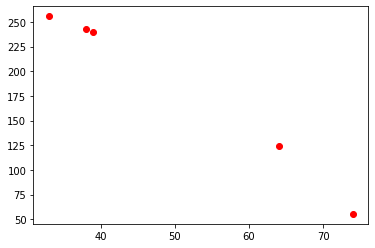

rewaRD::  -54.895848799041694
stepping:  70
Temperature:  [ 33.  38.  39.  64.  74. 104.]
ORDER PARAM RESULT (X2): 79.99999999999986
THE JT RESULT {X0}: 1.3999999999999215
THE NF RESULT {X1}: 269.9999999999988
THE BK RESULT {X3}: 7.6
chisqds:  3.0478867037996444e-27


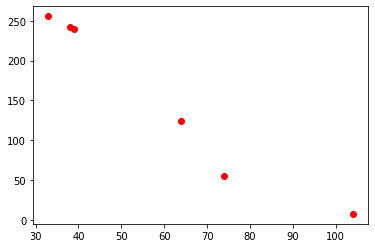

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  260
fixed Jt:  1.4
fixed Nf:  300
fixed Bk:  3.0
start Tn:  268
start Jt:  1.56
start Nf:  306
start Bk:  2.82
stepping:  71
Temperature:  [18.]
rewaRD::  -100
stepping:  71
Temperature:  [18. 19.]
rewaRD::  -100
stepping:  71
Temperature:  [18. 19. 44.]
rewaRD::  -100
stepping:  71
Temperature:  [18. 19. 44. 59.]
rewaRD::  -100
stepping:  71
Temperature:  [18. 19. 44. 59. 89.]
ORDER PARAM RESULT (X2): 259.99999999985084
THE JT RESULT {X0}: 1.399999999998691
THE NF RESULT {X1}: 299.99999999966946
THE BK RESULT {X3}: 3.0000000003305227
chisqds:  2.0984699822763435e-28


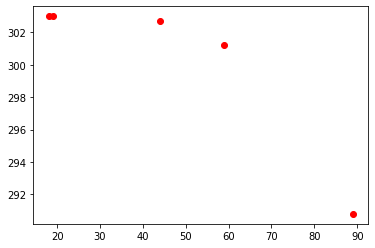

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  130
fixed Jt:  1.3
fixed Nf:  390
fixed Bk:  5.6
start Tn:  132
start Jt:  1.4
start Nf:  386
start Bk:  5.56
stepping:  72
Temperature:  [4.]
rewaRD::  -100
stepping:  72
Temperature:  [ 4. 19.]
rewaRD::  -100
stepping:  72
Temperature:  [ 4. 19. 39.]
rewaRD::  -100
stepping:  72
Temperature:  [ 4. 19. 39. 49.]
rewaRD::  -100
stepping:  72
Temperature:  [ 4. 19. 39. 49. 50.]
ORDER PARAM RESULT (X2): 130.0000000005138
THE JT RESULT {X0}: 1.3000000000060727
THE NF RESULT {X1}: 390.0000000032547
THE BK RESULT {X3}: 5.599999996745394
chisqds:  8.813365467021111e-24


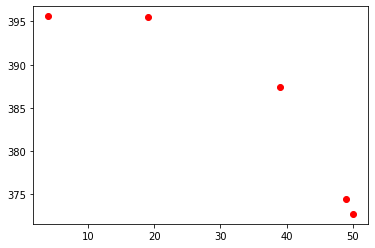

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  180
fixed Jt:  1.2
fixed Nf:  120
fixed Bk:  7.6
start Tn:  174
start Jt:  1.16
start Nf:  122
start Bk:  7.52
stepping:  73
Temperature:  [28.]
rewaRD::  -100
stepping:  73
Temperature:  [28. 43.]
rewaRD::  -100
stepping:  73
Temperature:  [28. 43. 68.]
rewaRD::  -100
stepping:  73
Temperature:  [28. 43. 68. 73.]
rewaRD::  -100
stepping:  73
Temperature:  [28. 43. 68. 73. 83.]
ORDER PARAM RESULT (X2): 180.00000000002726
THE JT RESULT {X0}: 1.200000000000282
THE NF RESULT {X1}: 120.00000000004161
THE BK RESULT {X3}: 7.599999999958408
chisqds:  7.799007099565721e-29


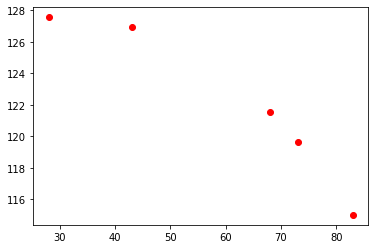

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  270
fixed Jt:  1.3
fixed Nf:  220
fixed Bk:  3.0
start Tn:  254
start Jt:  1.18
start Nf:  234
start Bk:  3.08
stepping:  74
Temperature:  [13.]
rewaRD::  -100
stepping:  74
Temperature:  [13. 18.]
rewaRD::  -100
stepping:  74
Temperature:  [13. 18. 19.]
rewaRD::  -100
stepping:  74
Temperature:  [13. 18. 19. 49.]
rewaRD::  -100
stepping:  74
Temperature:  [13. 18. 19. 49. 59.]
ORDER PARAM RESULT (X2): 207.5822681617858
THE JT RESULT {X0}: 1.9195721812119846
THE NF RESULT {X1}: 231.02097009491087
THE BK RESULT {X3}: 0.1000051113848383
chisqds:  1.0242369524086996


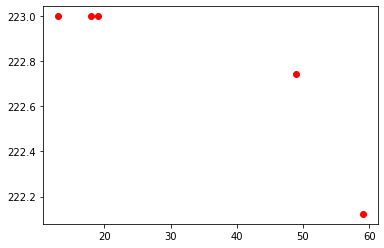

rewaRD::  290.5346307407865
stepping:  74
Temperature:  [13. 18. 19. 49. 59. 69.]
ORDER PARAM RESULT (X2): 269.99999999559816
THE JT RESULT {X0}: 1.2999999999648832
THE NF RESULT {X1}: 219.99999999308508
THE BK RESULT {X3}: 3.000000006914943
chisqds:  3.494588815774977e-26


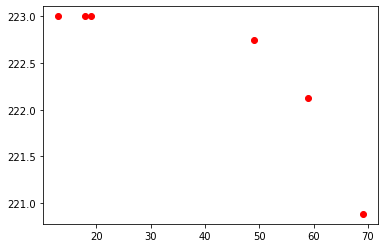

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  210
fixed Jt:  0.7
fixed Nf:  390
fixed Bk:  5.2
start Tn:  204
start Jt:  0.68
start Nf:  388
start Bk:  5.16
stepping:  75
Temperature:  [8.]
rewaRD::  -100
stepping:  75
Temperature:  [ 8. 33.]
rewaRD::  -100
stepping:  75
Temperature:  [ 8. 33. 48.]
rewaRD::  -100
stepping:  75
Temperature:  [ 8. 33. 48. 63.]
rewaRD::  -100
stepping:  75
Temperature:  [ 8. 33. 48. 63. 68.]
ORDER PARAM RESULT (X2): 209.99999999841958
THE JT RESULT {X0}: 0.6999999999876632
THE NF RESULT {X1}: 389.9999999924598
THE BK RESULT {X3}: 5.200000007540297
chisqds:  3.3562970929060886e-27


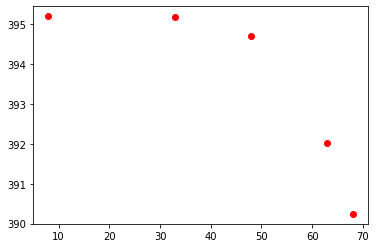

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  110
fixed Jt:  1.1
fixed Nf:  380
fixed Bk:  6.2
start Tn:  92
start Jt:  1.02
start Nf:  368
start Bk:  6.34
stepping:  76
Temperature:  [8.]
rewaRD::  -100
stepping:  76
Temperature:  [ 8. 13.]
rewaRD::  -100
stepping:  76
Temperature:  [ 8. 13. 14.]
rewaRD::  -100
stepping:  76
Temperature:  [ 8. 13. 14. 34.]
rewaRD::  -100
stepping:  76
Temperature:  [ 8. 13. 14. 34. 59.]
ORDER PARAM RESULT (X2): 93.17652688188804
THE JT RESULT {X0}: 0.9068155493433235
THE NF RESULT {X1}: 369.59838503355905
THE BK RESULT {X3}: 7.999258889141847
chisqds:  6.525913497177612


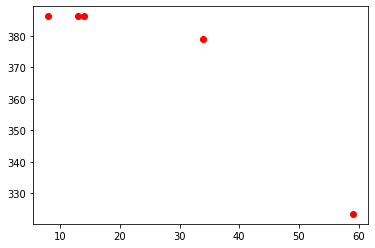

rewaRD::  -38.70589915526834
stepping:  76
Temperature:  [ 8. 13. 14. 34. 59. 89.]
ORDER PARAM RESULT (X2): 92.41542093128847
THE JT RESULT {X0}: 0.946384627197369
THE NF RESULT {X1}: 368.7785705118693
THE BK RESULT {X3}: 7.99960484771835
chisqds:  51.463264504947425


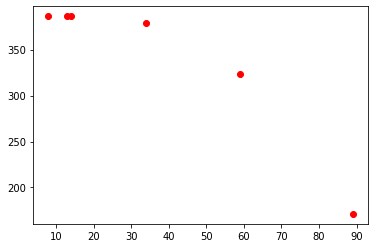

rewaRD::  -92.22746547760207
stepping:  76
Temperature:  [ 8. 13. 14. 34. 59. 89. 94.]
ORDER PARAM RESULT (X2): 92.29835664743726
THE JT RESULT {X0}: 0.9669762559370354
THE NF RESULT {X1}: 368.5610792364362
THE BK RESULT {X3}: 7.999584349517832
chisqds:  75.41045416563547


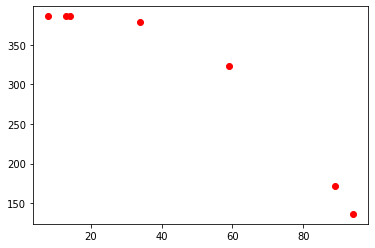

rewaRD::  -94.6956956508786
stepping:  76
Temperature:  [ 8. 13. 14. 34. 59. 89. 94. 99.]
ORDER PARAM RESULT (X2): 92.28164920995555
THE JT RESULT {X0}: 0.9698443184023994
THE NF RESULT {X1}: 368.5317136533253
THE BK RESULT {X3}: 7.999244043012325
chisqds:  77.50467823524228


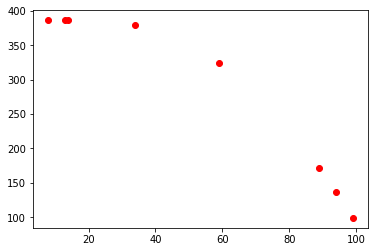

rewaRD::  -94.83902121642362
stepping:  76
Temperature:  [  8.  13.  14.  34.  59.  89.  94.  99. 124.]
ORDER PARAM RESULT (X2): 93.56566923845658
THE JT RESULT {X0}: 0.7556746309825262
THE NF RESULT {X1}: 370.7322392832455
THE BK RESULT {X3}: 7.999925144045998
chisqds:  57.0691340738875


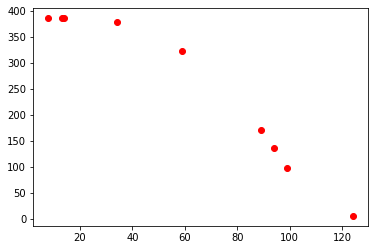

rewaRD::  -92.99095725752349
stepping:  76
Temperature:  [  8.  13.  14.  34.  59.  89.  94.  99. 124. 154.]
ORDER PARAM RESULT (X2): 94.91612659389877
THE JT RESULT {X0}: 0.5255838989581318
THE NF RESULT {X1}: 372.98732414310524
THE BK RESULT {X3}: 7.999336144836949
chisqds:  40.49003061622586


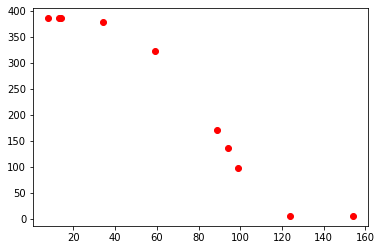

rewaRD::  -90.12102500511064
stepping:  76
Temperature:  [  8.  13.  14.  34.  59.  89.  94.  99. 124. 154. 179.]
ORDER PARAM RESULT (X2): 95.92285511613026
THE JT RESULT {X0}: 0.40000084867576774
THE NF RESULT {X1}: 373.9708747602699
THE BK RESULT {X3}: 7.815444001176642
chisqds:  30.018868513830203


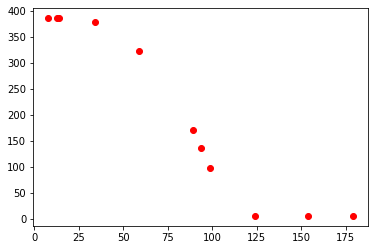

rewaRD::  -86.67504740174623
stepping:  76
Temperature:  [  8.  13.  14.  34.  59.  89.  94.  99. 124. 154. 179. 184.]
ORDER PARAM RESULT (X2): 95.93174661563869
THE JT RESULT {X0}: 0.4000004489715396
THE NF RESULT {X1}: 374.03532765857204
THE BK RESULT {X3}: 7.456276580740225
chisqds:  26.405636645018426


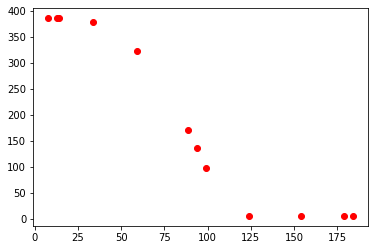

rewaRD::  -84.85171914703817
stepping:  76
Temperature:  [  8.  13.  14.  34.  59.  89.  94.  99. 124. 154. 179. 184. 209.]
ORDER PARAM RESULT (X2): 95.93724950040698
THE JT RESULT {X0}: 0.40000032037921834
THE NF RESULT {X1}: 374.0756121987146
THE BK RESULT {X3}: 7.234574490731033
chisqds:  23.547856734602167


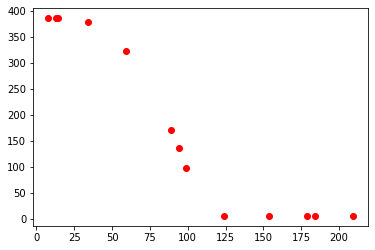

rewaRD::  -83.01331605214737
stepping:  76
Temperature:  [  8.  13.  14.  34.  59.  89.  94.  99. 124. 154. 179. 184. 209. 214.]
ORDER PARAM RESULT (X2): 95.94147380892343
THE JT RESULT {X0}: 0.40000042932959334
THE NF RESULT {X1}: 374.1030036494428
THE BK RESULT {X3}: 7.08412446204139
chisqds:  21.23822718931099


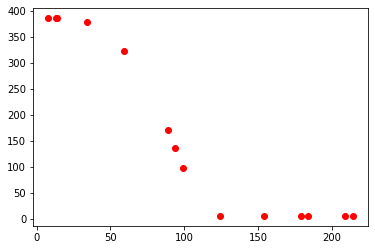

rewaRD::  -81.16603629697886
stepping:  76
Temperature:  [  8.  13.  14.  34.  59.  89.  94.  99. 124. 154. 179. 184. 209. 214.
 215.]
ORDER PARAM RESULT (X2): 109.99999999997218
THE JT RESULT {X0}: 1.1000000000002306
THE NF RESULT {X1}: 379.9999999999996
THE BK RESULT {X3}: 6.2
chisqds:  7.17153892722145e-23


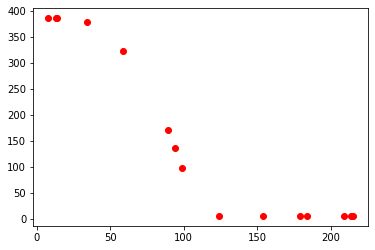

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  60
fixed Jt:  1.3
fixed Nf:  200
fixed Bk:  5.4
start Tn:  42
start Jt:  1.24
start Nf:  180
start Bk:  5.54
stepping:  77
Temperature:  [18.]
rewaRD::  -100
stepping:  77
Temperature:  [18. 19.]
rewaRD::  -100
stepping:  77
Temperature:  [18. 19. 29.]
rewaRD::  -100
stepping:  77
Temperature:  [18. 19. 29. 34.]
rewaRD::  -100
stepping:  77
Temperature:  [18. 19. 29. 34. 39.]
ORDER PARAM RESULT (X2): 42.46039606084023
THE JT RESULT {X0}: 1.0449288790754585
THE NF RESULT {X1}: 182.60563897501459
THE BK RESULT {X3}: 7.999571068057882
chisqds:  118.2496370618962


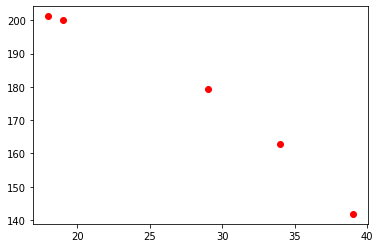

rewaRD::  -96.61732576996727
stepping:  77
Temperature:  [18. 19. 29. 34. 39. 40.]
ORDER PARAM RESULT (X2): 42.39118748815072
THE JT RESULT {X0}: 1.0469753147216991
THE NF RESULT {X1}: 182.5378035357842
THE BK RESULT {X3}: 7.999784886490791
chisqds:  98.63620831889318


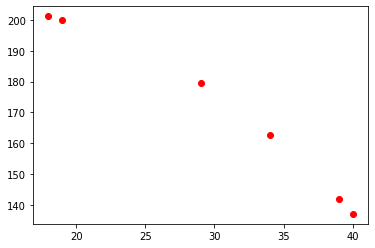

rewaRD::  -95.9446940751535
stepping:  77
Temperature:  [18. 19. 29. 34. 39. 40. 41.]
ORDER PARAM RESULT (X2): 42.35043997795802
THE JT RESULT {X0}: 1.0508586936278022
THE NF RESULT {X1}: 182.43820164490722
THE BK RESULT {X3}: 7.999295829056758
chisqds:  96.44325271212413


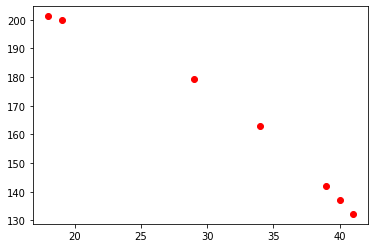

rewaRD::  -95.85248331271063
stepping:  77
Temperature:  [18. 19. 29. 34. 39. 40. 41. 42.]
ORDER PARAM RESULT (X2): 42.32281371467958
THE JT RESULT {X0}: 1.062934796444665
THE NF RESULT {X1}: 182.2557946961651
THE BK RESULT {X3}: 7.999573504359851
chisqds:  99.17917202515663


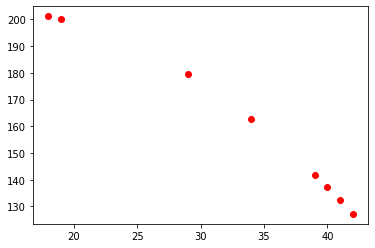

rewaRD::  -95.96689514711274
stepping:  77
Temperature:  [18. 19. 29. 34. 39. 40. 41. 42. 72.]
ORDER PARAM RESULT (X2): 59.99999999999919
THE JT RESULT {X0}: 1.3000000000000185
THE NF RESULT {X1}: 200.00000000000003
THE BK RESULT {X3}: 5.4
chisqds:  5.650294323421517e-26


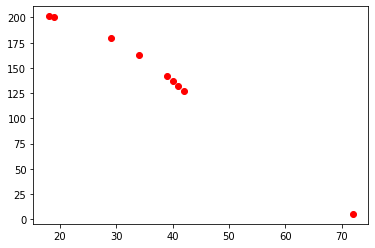

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  100
fixed Jt:  0.9
fixed Nf:  220
fixed Bk:  3.2
start Tn:  86
start Jt:  0.94
start Nf:  204
start Bk:  3.12
stepping:  78
Temperature:  [28.]
rewaRD::  -100
stepping:  78
Temperature:  [28. 43.]
rewaRD::  -100
stepping:  78
Temperature:  [28. 43. 63.]
rewaRD::  -100
stepping:  78
Temperature:  [28. 43. 63. 93.]
rewaRD::  -100
stepping:  78
Temperature:  [ 28.  43.  63.  93. 103.]
ORDER PARAM RESULT (X2): 99.99999999999915
THE JT RESULT {X0}: 0.9000000000000042
THE NF RESULT {X1}: 219.99999999999991
THE BK RESULT {X3}: 3.2
chisqds:  4.514419896418947e-25


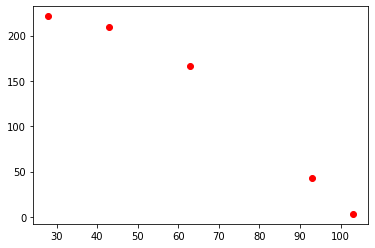

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  240
fixed Jt:  1.3
fixed Nf:  230
fixed Bk:  6.6
start Tn:  224
start Jt:  1.2
start Nf:  230
start Bk:  6.62
stepping:  79
Temperature:  [28.]
rewaRD::  -100
stepping:  79
Temperature:  [28. 43.]
rewaRD::  -100
stepping:  79
Temperature:  [28. 43. 68.]
rewaRD::  -100
stepping:  79
Temperature:  [28. 43. 68. 73.]
rewaRD::  -100
--------------------------------------
| approxkl           | 3.7182388e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 6.89          |
| ep_reward_mean     | -142          |
| explained_variance | 0.000154      |
| fps                | 8             |
| n_updates          | 5             |
| policy_entropy     | 1.9416975     |
| policy_loss        | 0.00019151508 |
| serial_timesteps   | 640           |
| time_elapsed       | 67            |
| total_timesteps    | 640           |
| value_loss         | 63855.055     |
--------------------------------------
stepping:  79
Tempera

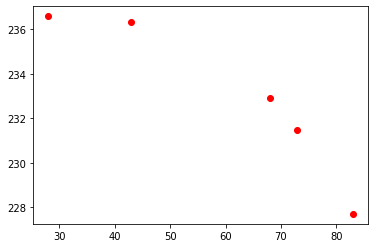

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  130
fixed Jt:  1.3
fixed Nf:  390
fixed Bk:  5.8
start Tn:  138
start Jt:  1.54
start Nf:  408
start Bk:  5.6
stepping:  80
Temperature:  [13.]
rewaRD::  -100
stepping:  80
Temperature:  [13. 18.]
rewaRD::  -100
stepping:  80
Temperature:  [13. 18. 28.]
rewaRD::  -100
stepping:  80
Temperature:  [13. 18. 28. 29.]
rewaRD::  -100
stepping:  80
Temperature:  [13. 18. 28. 29. 39.]
ORDER PARAM RESULT (X2): 129.99999999979016
THE JT RESULT {X0}: 1.2999999999972298
THE NF RESULT {X1}: 389.99999999862234
THE BK RESULT {X3}: 5.800000001377733
chisqds:  7.054691526125394e-26


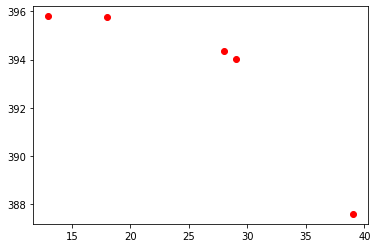

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  200
fixed Jt:  1.3
fixed Nf:  300
fixed Bk:  6.6
start Tn:  214
start Jt:  1.48
start Nf:  300
start Bk:  6.64
stepping:  81
Temperature:  [33.]
rewaRD::  -100
stepping:  81
Temperature:  [33. 43.]
rewaRD::  -100
stepping:  81
Temperature:  [33. 43. 63.]
rewaRD::  -100
stepping:  81
Temperature:  [33. 43. 63. 68.]
rewaRD::  -100
stepping:  81
Temperature:  [33. 43. 63. 68. 98.]
ORDER PARAM RESULT (X2): 200.00000000010922
THE JT RESULT {X0}: 1.300000000000992
THE NF RESULT {X1}: 300.00000000036397
THE BK RESULT {X3}: 6.599999999636034
chisqds:  1.7088075374419368e-26


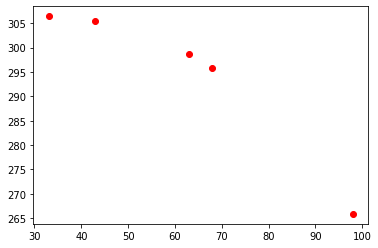

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  230
fixed Jt:  0.9
fixed Nf:  170
fixed Bk:  3.8
start Tn:  232
start Jt:  1.14
start Nf:  174
start Bk:  3.8
stepping:  82
Temperature:  [8.]
rewaRD::  -100
stepping:  82
Temperature:  [ 8. 23.]
rewaRD::  -100
stepping:  82
Temperature:  [ 8. 23. 33.]
rewaRD::  -100
stepping:  82
Temperature:  [ 8. 23. 33. 43.]
rewaRD::  -100
stepping:  82
Temperature:  [ 8. 23. 33. 43. 63.]
ORDER PARAM RESULT (X2): 230.0000000018251
THE JT RESULT {X0}: 0.900000000010883
THE NF RESULT {X1}: 170.00000000354862
THE BK RESULT {X3}: 3.799999996451307
chisqds:  1.6686082560180925e-25


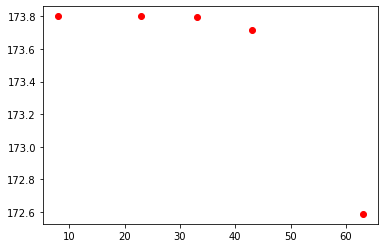

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  160
fixed Jt:  0.8
fixed Nf:  380
fixed Bk:  3.6
start Tn:  170
start Jt:  0.58
start Nf:  374
start Bk:  3.58
stepping:  83
Temperature:  [33.]
rewaRD::  -100
stepping:  83
Temperature:  [33. 53.]
rewaRD::  -100
stepping:  83
Temperature:  [33. 53. 78.]
rewaRD::  -100
stepping:  83
Temperature:  [33. 53. 78. 88.]
rewaRD::  -100
stepping:  83
Temperature:  [ 33.  53.  78.  88. 113.]
ORDER PARAM RESULT (X2): 160.00000000000625
THE JT RESULT {X0}: 0.8000000000000893
THE NF RESULT {X1}: 380.0000000000536
THE BK RESULT {X3}: 3.599999999946227
chisqds:  1.8841732243615241e-25


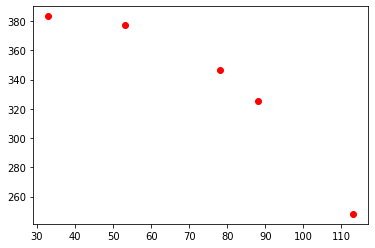

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  80
fixed Jt:  1.4
fixed Nf:  430
fixed Bk:  5.2
start Tn:  70
start Jt:  1.14
start Nf:  442
start Bk:  5.34
stepping:  84
Temperature:  [28.]
rewaRD::  -100
stepping:  84
Temperature:  [28. 29.]
rewaRD::  -100
stepping:  84
Temperature:  [28. 29. 39.]
rewaRD::  -100
stepping:  84
Temperature:  [28. 29. 39. 49.]
rewaRD::  -100
stepping:  84
Temperature:  [28. 29. 39. 49. 50.]
ORDER PARAM RESULT (X2): 78.55134351028777
THE JT RESULT {X0}: 1.1791224562625946
THE NF RESULT {X1}: 424.2915217161016
THE BK RESULT {X3}: 7.999308542371516
chisqds:  0.002806718676094775


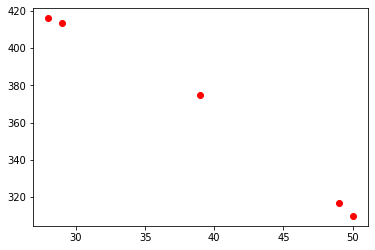

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  190
fixed Jt:  1.3
fixed Nf:  130
fixed Bk:  5.6
start Tn:  182
start Jt:  1.22
start Nf:  128
start Bk:  5.56
stepping:  85
Temperature:  [23.]
rewaRD::  -100
stepping:  85
Temperature:  [23. 28.]
rewaRD::  -100
stepping:  85
Temperature:  [23. 28. 48.]
rewaRD::  -100
stepping:  85
Temperature:  [23. 28. 48. 78.]
rewaRD::  -100
stepping:  85
Temperature:  [23. 28. 48. 78. 98.]
ORDER PARAM RESULT (X2): 190.00000000005758
THE JT RESULT {X0}: 1.3000000000005192
THE NF RESULT {X1}: 130.00000000008944
THE BK RESULT {X3}: 5.599999999910572
chisqds:  4.1068405686899805e-27


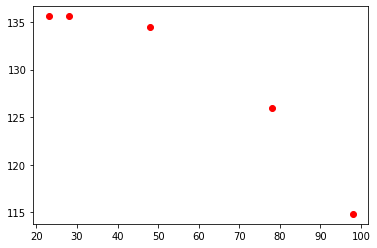

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  190
fixed Jt:  1.2
fixed Nf:  140
fixed Bk:  4.4
start Tn:  206
start Jt:  1.46
start Nf:  130
start Bk:  4.22
stepping:  86
Temperature:  [28.]
rewaRD::  -100
stepping:  86
Temperature:  [28. 53.]
rewaRD::  -100
stepping:  86
Temperature:  [28. 53. 83.]
rewaRD::  -100
stepping:  86
Temperature:  [ 28.  53.  83. 108.]
rewaRD::  -100
stepping:  86
Temperature:  [ 28.  53.  83. 108. 138.]
ORDER PARAM RESULT (X2): 189.99999999999906
THE JT RESULT {X0}: 1.1999999999999869
THE NF RESULT {X1}: 139.99999999999812
THE BK RESULT {X3}: 4.400000000001916
chisqds:  3.2171680194356417e-28


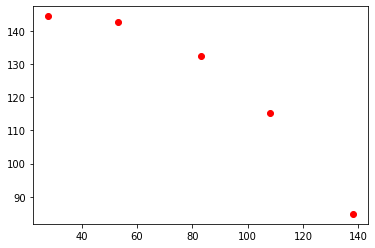

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  90
fixed Jt:  1.3
fixed Nf:  320
fixed Bk:  6.8
start Tn:  78
start Jt:  1.3
start Nf:  338
start Bk:  6.62
stepping:  87
Temperature:  [8.]
rewaRD::  -100
stepping:  87
Temperature:  [8. 9.]
rewaRD::  -100
stepping:  87
Temperature:  [ 8.  9. 24.]
rewaRD::  -100
stepping:  87
Temperature:  [ 8.  9. 24. 54.]
rewaRD::  -100
stepping:  87
Temperature:  [ 8.  9. 24. 54. 74.]
ORDER PARAM RESULT (X2): 78.42445241630159
THE JT RESULT {X0}: 1.1985136295199759
THE NF RESULT {X1}: 337.91730061337853
THE BK RESULT {X3}: 7.999780998359283
chisqds:  51.44481168124916


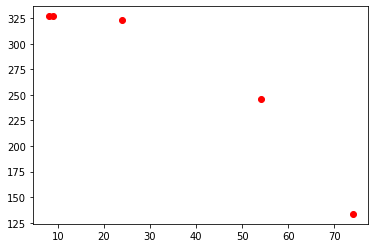

rewaRD::  -92.22467753447344
stepping:  87
Temperature:  [ 8.  9. 24. 54. 74. 84.]
ORDER PARAM RESULT (X2): 78.3030109219942
THE JT RESULT {X0}: 1.227264595361207
THE NF RESULT {X1}: 337.9386377841907
THE BK RESULT {X3}: 7.999711250415574
chisqds:  48.36899059266523


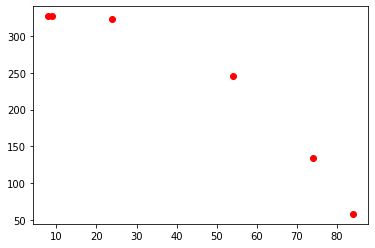

rewaRD::  -91.73023883486506
stepping:  87
Temperature:  [  8.   9.  24.  54.  74.  84. 114.]
ORDER PARAM RESULT (X2): 79.48359406403084
THE JT RESULT {X0}: 0.9720190566316799
THE NF RESULT {X1}: 337.26835649354365
THE BK RESULT {X3}: 7.999253798377102
chisqds:  26.72717529544701


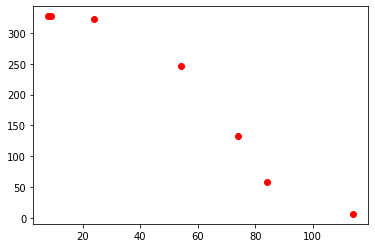

rewaRD::  -85.0339590481101
stepping:  87
Temperature:  [  8.   9.  24.  54.  74.  84. 114. 119.]
ORDER PARAM RESULT (X2): 80.76947477144552
THE JT RESULT {X0}: 0.7624455301944526
THE NF RESULT {X1}: 335.1199170362849
THE BK RESULT {X3}: 7.999641630897876
chisqds:  16.588769583373402


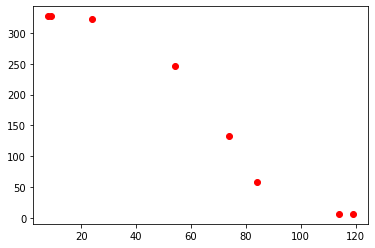

rewaRD::  -75.8873014668362
stepping:  87
Temperature:  [  8.   9.  24.  54.  74.  84. 114. 119. 149.]
ORDER PARAM RESULT (X2): 82.0567528389428
THE JT RESULT {X0}: 0.5555447963334434
THE NF RESULT {X1}: 332.67813166776534
THE BK RESULT {X3}: 7.999363658470467
chisqds:  11.266409451410246


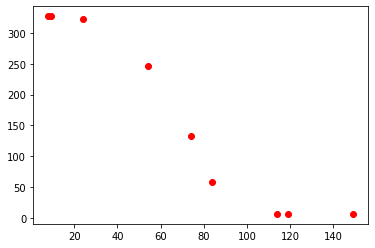

rewaRD::  -64.49623087771491
stepping:  87
Temperature:  [  8.   9.  24.  54.  74.  84. 114. 119. 149. 174.]
ORDER PARAM RESULT (X2): 83.6149395319428
THE JT RESULT {X0}: 0.4110677405037997
THE NF RESULT {X1}: 326.5825629700148
THE BK RESULT {X3}: 7.999605648203466
chisqds:  8.215720341955917


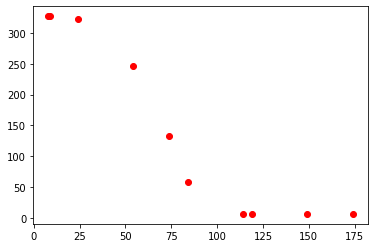

rewaRD::  -51.312851052477285
stepping:  87
Temperature:  [  8.   9.  24.  54.  74.  84. 114. 119. 149. 174. 204.]
ORDER PARAM RESULT (X2): 89.999999999989
THE JT RESULT {X0}: 1.300000000000055
THE NF RESULT {X1}: 319.9999999999997
THE BK RESULT {X3}: 6.8
chisqds:  2.2261930958137953e-23


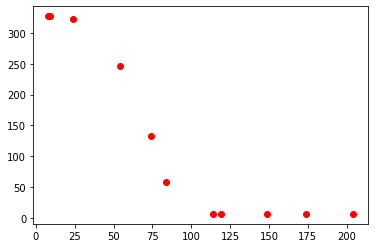

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  80
fixed Jt:  0.9
fixed Nf:  160
fixed Bk:  5.6
start Tn:  76
start Jt:  0.86
start Nf:  174
start Bk:  5.66
stepping:  88
Temperature:  [33.]
rewaRD::  -100
stepping:  88
Temperature:  [33. 43.]
rewaRD::  -100
stepping:  88
Temperature:  [33. 43. 44.]
rewaRD::  -100
stepping:  88
Temperature:  [33. 43. 44. 54.]
rewaRD::  -100
stepping:  88
Temperature:  [33. 43. 44. 54. 64.]
ORDER PARAM RESULT (X2): 80.00000000022474
THE JT RESULT {X0}: 0.9000000000038192
THE NF RESULT {X1}: 160.0000000012258
THE BK RESULT {X3}: 5.599999998771779
chisqds:  3.304351501764609e-25


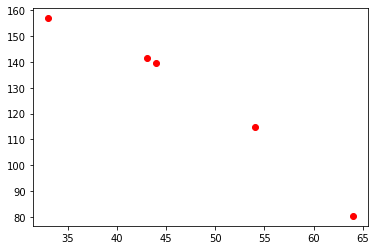

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  210
fixed Jt:  1.3
fixed Nf:  390
fixed Bk:  6.6
start Tn:  206
start Jt:  1.4
start Nf:  392
start Bk:  6.74
stepping:  89
Temperature:  [18.]
rewaRD::  -100
stepping:  89
Temperature:  [18. 43.]
rewaRD::  -100
stepping:  89
Temperature:  [18. 43. 68.]
rewaRD::  -100
stepping:  89
Temperature:  [18. 43. 68. 83.]
rewaRD::  -100
stepping:  89
Temperature:  [18. 43. 68. 83. 88.]
ORDER PARAM RESULT (X2): 209.9999999999496
THE JT RESULT {X0}: 1.299999999999501
THE NF RESULT {X1}: 389.999999999789
THE BK RESULT {X3}: 6.600000000211042
chisqds:  5.116629467564119e-27


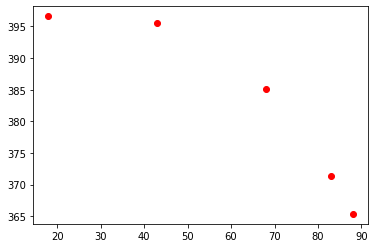

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  100
fixed Jt:  1.0
fixed Nf:  410
fixed Bk:  3.2
start Tn:  112
start Jt:  0.8
start Nf:  416
start Bk:  3.16
stepping:  90
Temperature:  [18.]
rewaRD::  -100
stepping:  90
Temperature:  [18. 38.]
rewaRD::  -100
stepping:  90
Temperature:  [18. 38. 43.]
rewaRD::  -100
stepping:  90
Temperature:  [18. 38. 43. 58.]
rewaRD::  -100
stepping:  90
Temperature:  [18. 38. 43. 58. 63.]
ORDER PARAM RESULT (X2): 109.46235298102563
THE JT RESULT {X0}: 0.9348076638664132
THE NF RESULT {X1}: 412.8825101298339
THE BK RESULT {X3}: 0.10001378151143789
chisqds:  4.757814021998142


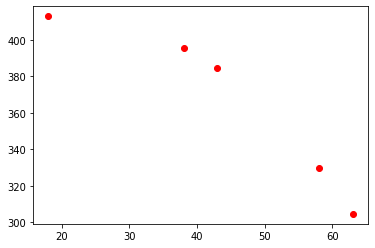

rewaRD::  -15.927777304752283
stepping:  90
Temperature:  [18. 38. 43. 58. 63. 93.]
ORDER PARAM RESULT (X2): 111.20999238479767
THE JT RESULT {X0}: 0.9070488565475912
THE NF RESULT {X1}: 413.08667042495375
THE BK RESULT {X3}: 0.10001081889079634
chisqds:  52.703452166563316


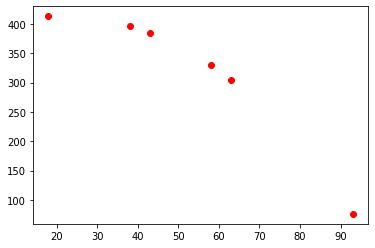

rewaRD::  -92.41036433940143
stepping:  90
Temperature:  [ 18.  38.  43.  58.  63.  93. 123.]
ORDER PARAM RESULT (X2): 100.00000000000003
THE JT RESULT {X0}: 0.9999999999999936
THE NF RESULT {X1}: 409.99999999999994
THE BK RESULT {X3}: 3.2
chisqds:  4.7319046670620284e-27


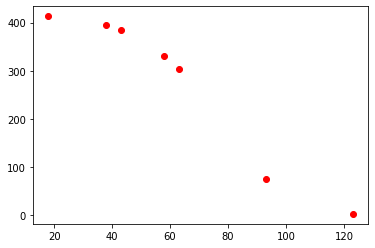

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  120
fixed Jt:  0.7
fixed Nf:  280
fixed Bk:  7.4
start Tn:  116
start Jt:  0.98
start Nf:  284
start Bk:  7.34
stepping:  91
Temperature:  [18.]
rewaRD::  -100
stepping:  91
Temperature:  [18. 23.]
rewaRD::  -100
stepping:  91
Temperature:  [18. 23. 28.]
rewaRD::  -100
stepping:  91
Temperature:  [18. 23. 28. 29.]
rewaRD::  -100
stepping:  91
Temperature:  [18. 23. 28. 29. 34.]
ORDER PARAM RESULT (X2): 119.99999999929953
THE JT RESULT {X0}: 0.6999999999913913
THE NF RESULT {X1}: 279.9999999954907
THE BK RESULT {X3}: 7.400000004509291
chisqds:  2.3037684248789004e-26


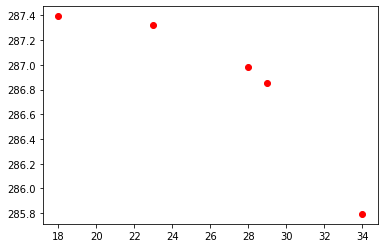

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  70
fixed Jt:  1.0
fixed Nf:  310
fixed Bk:  5.6
start Tn:  86
start Jt:  1.28
start Nf:  294
start Bk:  5.74
stepping:  92
Temperature:  [23.]
rewaRD::  -100
stepping:  92
Temperature:  [23. 24.]
rewaRD::  -100
stepping:  92
Temperature:  [23. 24. 39.]
rewaRD::  -100
stepping:  92
Temperature:  [23. 24. 39. 54.]
rewaRD::  -100
stepping:  92
Temperature:  [23. 24. 39. 54. 59.]
ORDER PARAM RESULT (X2): 70.00000000002358
THE JT RESULT {X0}: 1.0000000000004483
THE NF RESULT {X1}: 310.0000000002773
THE BK RESULT {X3}: 5.599999999721929
chisqds:  3.6220432695378364e-27


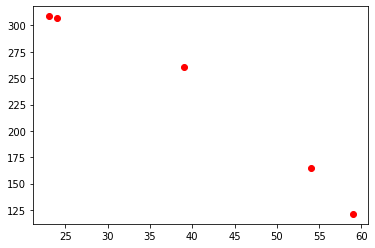

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  180
fixed Jt:  0.8
fixed Nf:  240
fixed Bk:  6.4
start Tn:  172
start Jt:  0.8
start Nf:  248
start Bk:  6.28
stepping:  93
Temperature:  [18.]
rewaRD::  -100
stepping:  93
Temperature:  [18. 48.]
rewaRD::  -100
stepping:  93
Temperature:  [18. 48. 68.]
rewaRD::  -100
stepping:  93
Temperature:  [18. 48. 68. 78.]
rewaRD::  -100
stepping:  93
Temperature:  [18. 48. 68. 78. 98.]
ORDER PARAM RESULT (X2): 180.00000000038727
THE JT RESULT {X0}: 0.8000000000026393
THE NF RESULT {X1}: 240.0000000013043
THE BK RESULT {X3}: 6.399999998695819
chisqds:  5.031010708474941e-24


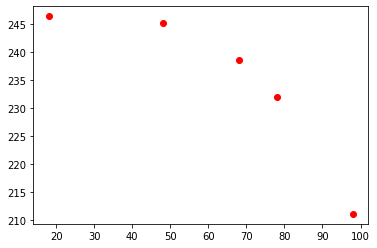

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  110
fixed Jt:  1.0
fixed Nf:  410
fixed Bk:  5.0
start Tn:  92
start Jt:  1.14
start Nf:  394
start Bk:  4.82
stepping:  94
Temperature:  [8.]
rewaRD::  -100
stepping:  94
Temperature:  [ 8. 33.]
rewaRD::  -100
stepping:  94
Temperature:  [ 8. 33. 48.]
rewaRD::  -100
stepping:  94
Temperature:  [ 8. 33. 48. 49.]
rewaRD::  -100
stepping:  94
Temperature:  [ 8. 33. 48. 49. 50.]
ORDER PARAM RESULT (X2): 93.77954413973423
THE JT RESULT {X0}: 1.0084970748182822
THE NF RESULT {X1}: 397.4281363884969
THE BK RESULT {X3}: 7.999924351860399
chisqds:  9.851251408330503


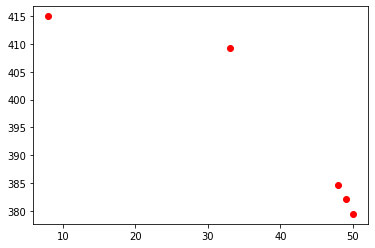

rewaRD::  -59.396021538771365
stepping:  94
Temperature:  [ 8. 33. 48. 49. 50. 60.]
ORDER PARAM RESULT (X2): 93.42485744725663
THE JT RESULT {X0}: 1.0166908751687485
THE NF RESULT {X1}: 397.47192438869394
THE BK RESULT {X3}: 7.999272489743758
chisqds:  9.396819357164716


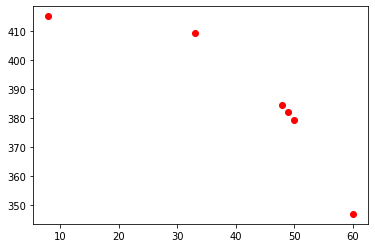

rewaRD::  -57.43240507278505
stepping:  94
Temperature:  [ 8. 33. 48. 49. 50. 60. 70.]
ORDER PARAM RESULT (X2): 93.09057663542416
THE JT RESULT {X0}: 1.0203190017386754
THE NF RESULT {X1}: 397.45027004743577
THE BK RESULT {X3}: 7.999348202751721
chisqds:  13.255985447111113


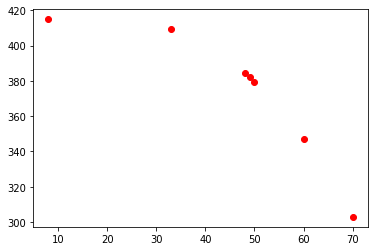

rewaRD::  -69.82495178529543
stepping:  94
Temperature:  [ 8. 33. 48. 49. 50. 60. 70. 71.]
ORDER PARAM RESULT (X2): 92.93797774961278
THE JT RESULT {X0}: 1.0226925178196602
THE NF RESULT {X1}: 397.5195978749535
THE BK RESULT {X3}: 7.999506906425935
chisqds:  15.710407291829847


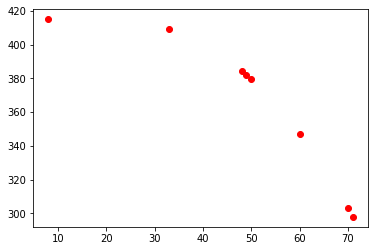

rewaRD::  -74.53917059120302
stepping:  94
Temperature:  [ 8. 33. 48. 49. 50. 60. 70. 71. 91.]
ORDER PARAM RESULT (X2): 92.62699182138844
THE JT RESULT {X0}: 1.0497272399747304
THE NF RESULT {X1}: 396.6407612975289
THE BK RESULT {X3}: 7.999642313672414
chisqds:  38.3027002972922


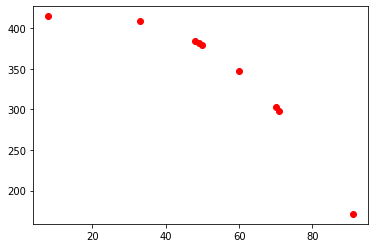

rewaRD::  -89.55687205091705
stepping:  94
Temperature:  [  8.  33.  48.  49.  50.  60.  70.  71.  91. 111.]
ORDER PARAM RESULT (X2): 109.99999999999696
THE JT RESULT {X0}: 1.0000000000000318
THE NF RESULT {X1}: 409.9999999999998
THE BK RESULT {X3}: 5.0
chisqds:  5.552384796695057e-25


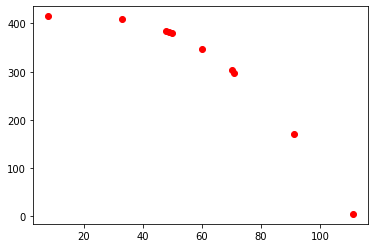

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  70
fixed Jt:  1.3
fixed Nf:  460
fixed Bk:  7.6
start Tn:  82
start Jt:  1.4
start Nf:  458
start Bk:  7.54
stepping:  95
Temperature:  [23.]
rewaRD::  -100
stepping:  95
Temperature:  [23. 24.]
rewaRD::  -100
stepping:  95
Temperature:  [23. 24. 49.]
rewaRD::  -100
stepping:  95
Temperature:  [23. 24. 49. 59.]
rewaRD::  -100
stepping:  95
Temperature:  [23. 24. 49. 59. 60.]
ORDER PARAM RESULT (X2): 80.3488660015555
THE JT RESULT {X0}: 1.6783553789513515
THE NF RESULT {X1}: 449.71774276614764
THE BK RESULT {X3}: 0.10000228269654828
chisqds:  63.08992202988777


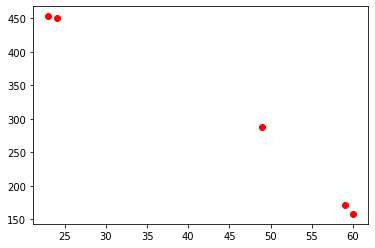

rewaRD::  -93.6598431709821
stepping:  95
Temperature:  [23. 24. 49. 59. 60. 65.]
ORDER PARAM RESULT (X2): 80.70780398116348
THE JT RESULT {X0}: 1.6653285962083182
THE NF RESULT {X1}: 448.5920204683779
THE BK RESULT {X3}: 0.1000085397871946
chisqds:  87.88116106175251


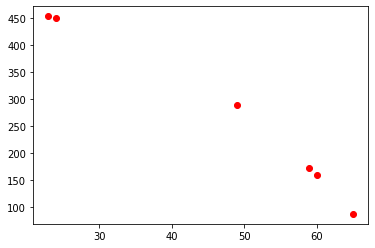

rewaRD::  -95.44839877890408
stepping:  95
Temperature:  [23. 24. 49. 59. 60. 65. 70.]
ORDER PARAM RESULT (X2): 81.15532499625971
THE JT RESULT {X0}: 1.7205489057541046
THE NF RESULT {X1}: 442.2546081068268
THE BK RESULT {X3}: 0.10001956368799898
chisqds:  739.5164484176797


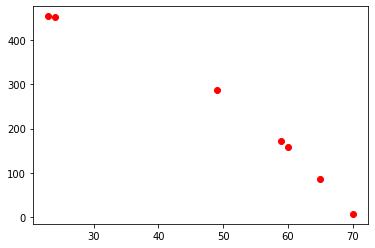

rewaRD::  -100
stepping:  95
Temperature:  [23. 24. 49. 59. 60. 65. 70. 95.]
ORDER PARAM RESULT (X2): 69.99998659433936
THE JT RESULT {X0}: 1.2999910900007219
THE NF RESULT {X1}: 459.9998527343227
THE BK RESULT {X3}: 7.599999988088472
chisqds:  4.483223572653519e-11


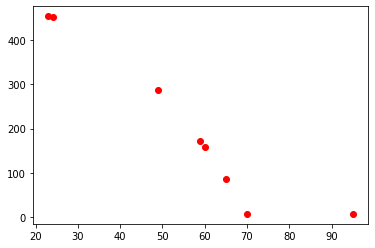

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  60
fixed Jt:  1.4
fixed Nf:  160
fixed Bk:  6.2
start Tn:  78
start Jt:  1.2
start Nf:  142
start Bk:  6.0
stepping:  96
Temperature:  [8.]
rewaRD::  -100
stepping:  96
Temperature:  [ 8. 23.]
rewaRD::  -100
stepping:  96
Temperature:  [ 8. 23. 38.]
rewaRD::  -100
stepping:  96
Temperature:  [ 8. 23. 38. 43.]
rewaRD::  -100
stepping:  96
Temperature:  [ 8. 23. 38. 43. 68.]
ORDER PARAM RESULT (X2): 75.86261527005952
THE JT RESULT {X0}: 1.8561935888842862
THE NF RESULT {X1}: 135.4118916685601
THE BK RESULT {X3}: 0.1000126779312811
chisqds:  108.45026276998419


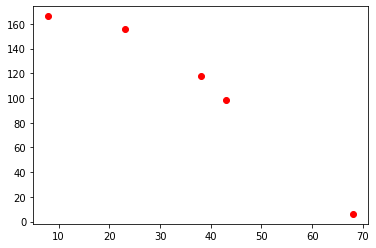

rewaRD::  -96.311673298124
stepping:  96
Temperature:  [ 8. 23. 38. 43. 68. 98.]
ORDER PARAM RESULT (X2): 75.40963810622219
THE JT RESULT {X0}: 1.9998071975151053
THE NF RESULT {X1}: 134.2912964403516
THE BK RESULT {X3}: 2.5865906260044147
chisqds:  56.20785262871371


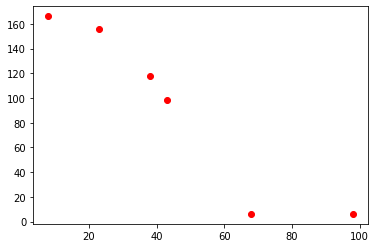

rewaRD::  -92.88355663322992
stepping:  96
Temperature:  [ 8. 23. 38. 43. 68. 98. 99.]
ORDER PARAM RESULT (X2): 75.46740179649028
THE JT RESULT {X0}: 1.999973417812403
THE NF RESULT {X1}: 134.1856040343875
THE BK RESULT {X3}: 3.7956828733764483
chisqds:  40.93280697778905


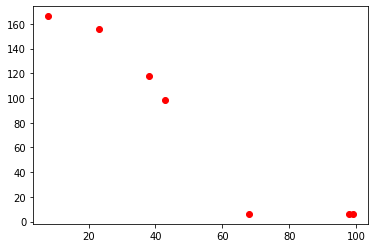

rewaRD::  -90.2278873711972
stepping:  96
Temperature:  [  8.  23.  38.  43.  68.  98.  99. 119.]
ORDER PARAM RESULT (X2): 75.50163935861337
THE JT RESULT {X0}: 1.9998143291755934
THE NF RESULT {X1}: 134.15106465322242
THE BK RESULT {X3}: 4.382284109246893
chisqds:  32.03402440484334


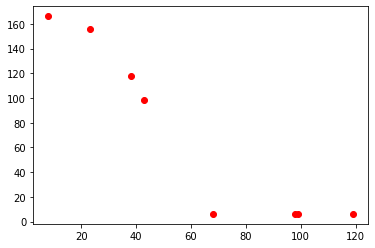

rewaRD::  -87.51327666655824
stepping:  96
Temperature:  [  8.  23.  38.  43.  68.  98.  99. 119. 124.]
ORDER PARAM RESULT (X2): 75.07389723395617
THE JT RESULT {X0}: 1.999911841111265
THE NF RESULT {X1}: 133.11248503843737
THE BK RESULT {X3}: 4.427098168429072
chisqds:  23.1880988157882


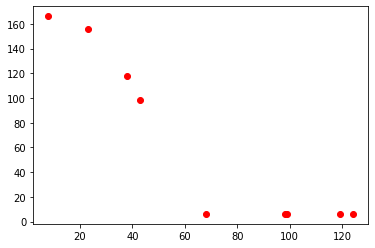

rewaRD::  -82.74977163165917
stepping:  96
Temperature:  [  8.  23.  38.  43.  68.  98.  99. 119. 124. 134.]
ORDER PARAM RESULT (X2): 75.0821256876595
THE JT RESULT {X0}: 1.9998669423001925
THE NF RESULT {X1}: 133.08207965361674
THE BK RESULT {X3}: 4.699983983053084
chisqds:  19.66541160932381


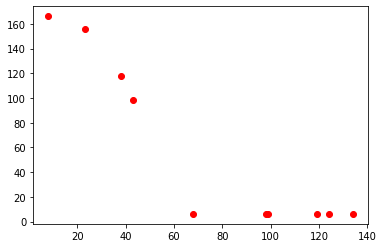

rewaRD::  -79.65971890411126
stepping:  96
Temperature:  [  8.  23.  38.  43.  68.  98.  99. 119. 124. 134. 135.]
ORDER PARAM RESULT (X2): 75.07893572866654
THE JT RESULT {X0}: 1.9998044281386949
THE NF RESULT {X1}: 133.04264099787832
THE BK RESULT {X3}: 4.889606622515956
chisqds:  17.02425093484827


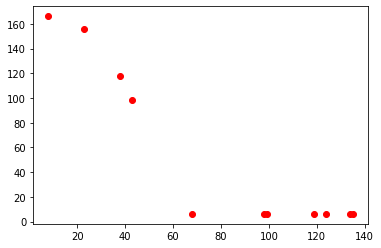

rewaRD::  -76.50410572947978
stepping:  96
Temperature:  [  8.  23.  38.  43.  68.  98.  99. 119. 124. 134. 135. 145.]
ORDER PARAM RESULT (X2): 75.08853822326259
THE JT RESULT {X0}: 1.99985129257765
THE NF RESULT {X1}: 133.03651947939957
THE BK RESULT {X3}: 5.037082971579582
chisqds:  15.054237731655537


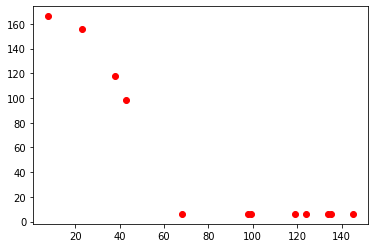

rewaRD::  -73.4294085738467
stepping:  96
Temperature:  [  8.  23.  38.  43.  68.  98.  99. 119. 124. 134. 135. 145. 146.]
ORDER PARAM RESULT (X2): 75.09084747733574
THE JT RESULT {X0}: 1.9998450755946375
THE NF RESULT {X1}: 133.0224733552714
THE BK RESULT {X3}: 5.15017412163316
chisqds:  13.47338819271852


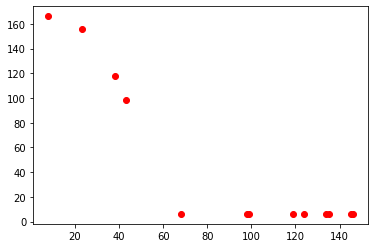

rewaRD::  -70.31184774916723
stepping:  96
Temperature:  [  8.  23.  38.  43.  68.  98.  99. 119. 124. 134. 135. 145. 146. 151.]
ORDER PARAM RESULT (X2): 75.09596957712962
THE JT RESULT {X0}: 1.9998208246444436
THE NF RESULT {X1}: 133.01742504259423
THE BK RESULT {X3}: 5.241283000428841
chisqds:  12.202458262249433


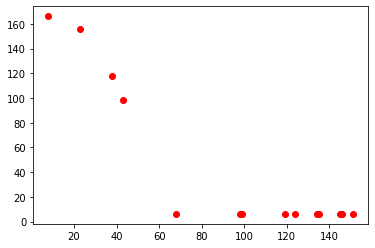

rewaRD::  -67.21971987911041
stepping:  96
Temperature:  [  8.  23.  38.  43.  68.  98.  99. 119. 124. 134. 135. 145. 146. 151.
 181.]
ORDER PARAM RESULT (X2): 75.09515151875496
THE JT RESULT {X0}: 1.9999912208212778
THE NF RESULT {X1}: 133.00396842553832
THE BK RESULT {X3}: 5.314733241653704
chisqds:  11.135618639610472


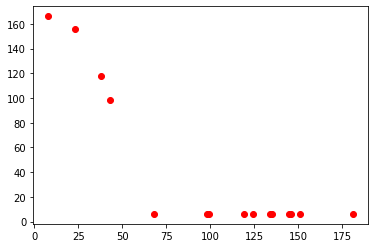

rewaRD::  -64.07922963730445
stepping:  96
Temperature:  [  8.  23.  38.  43.  68.  98.  99. 119. 124. 134. 135. 145. 146. 151.
 181. 211.]
ORDER PARAM RESULT (X2): 75.09729818665896
THE JT RESULT {X0}: 1.999966769742611
THE NF RESULT {X1}: 132.9980903458719
THE BK RESULT {X3}: 5.376479163316935
chisqds:  10.247750256486059


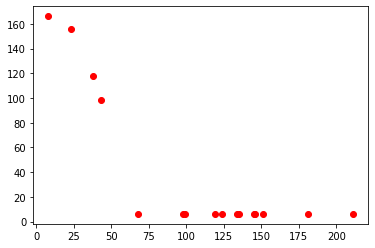

rewaRD::  -60.96704252264248
stepping:  96
Temperature:  [  8.  23.  38.  43.  68.  98.  99. 119. 124. 134. 135. 145. 146. 151.
 181. 211. 212.]
ORDER PARAM RESULT (X2): 75.09817441705762
THE JT RESULT {X0}: 1.999984946864747
THE NF RESULT {X1}: 132.99136467930384
THE BK RESULT {X3}: 5.428542914367225
chisqds:  9.488538279428


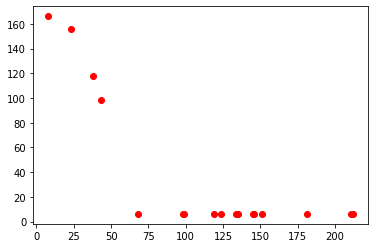

rewaRD::  -57.84387560861342
stepping:  96
Temperature:  [  8.  23.  38.  43.  68.  98.  99. 119. 124. 134. 135. 145. 146. 151.
 181. 211. 212. 217.]
ORDER PARAM RESULT (X2): 75.09994577091135
THE JT RESULT {X0}: 1.9999336774358571
THE NF RESULT {X1}: 132.98755023227307
THE BK RESULT {X3}: 5.473306604360994
chisqds:  8.836327676865842


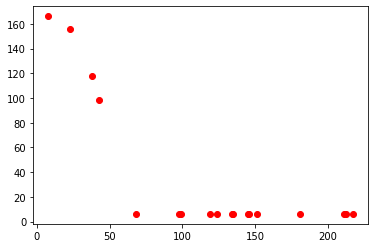

rewaRD::  -54.73232607169724
stepping:  96
Temperature:  [  8.  23.  38.  43.  68.  98.  99. 119. 124. 134. 135. 145. 146. 151.
 181. 211. 212. 217. 242.]
ORDER PARAM RESULT (X2): 75.10379593545822
THE JT RESULT {X0}: 1.9998014929516086
THE NF RESULT {X1}: 132.9886790884137
THE BK RESULT {X3}: 5.512382814269177
chisqds:  8.272834644467446


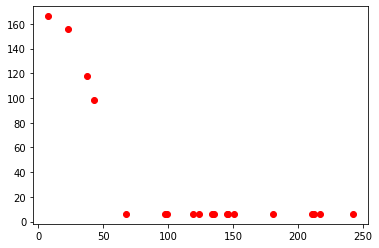

rewaRD::  -51.64897919632606
stepping:  96
Temperature:  [  8.  23.  38.  43.  68.  98.  99. 119. 124. 134. 135. 145. 146. 151.
 181. 211. 212. 217. 242. 247.]
ORDER PARAM RESULT (X2): 75.1037595079607
THE JT RESULT {X0}: 1.9999088176341984
THE NF RESULT {X1}: 132.98318878784815
THE BK RESULT {X3}: 5.546098673140176
chisqds:  7.7699279151322305


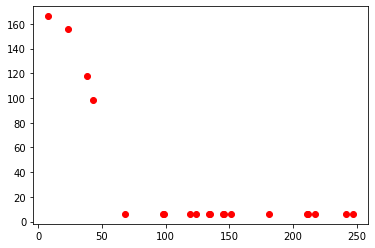

rewaRD::  -48.51947091800108
stepping:  96
Temperature:  [  8.  23.  38.  43.  68.  98.  99. 119. 124. 134. 135. 145. 146. 151.
 181. 211. 212. 217. 242. 247. 252.]
ORDER PARAM RESULT (X2): 75.07812125162064
THE JT RESULT {X0}: 1.9998360292793915
THE NF RESULT {X1}: 132.92827605793684
THE BK RESULT {X3}: 5.5700110118465425
chisqds:  7.277556234133301


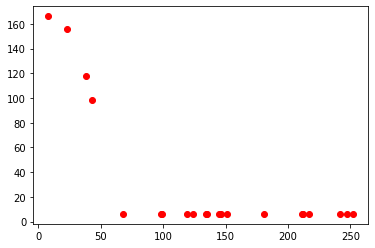

rewaRD::  -45.03649478874321
stepping:  96
Temperature:  [  8.  23.  38.  43.  68.  98.  99. 119. 124. 134. 135. 145. 146. 151.
 181. 211. 212. 217. 242. 247. 252. 253.]
ORDER PARAM RESULT (X2): 75.08113739320102
THE JT RESULT {X0}: 1.9999156396731161
THE NF RESULT {X1}: 132.92981149849317
THE BK RESULT {X3}: 5.597124815928194
chisqds:  6.888421893056031


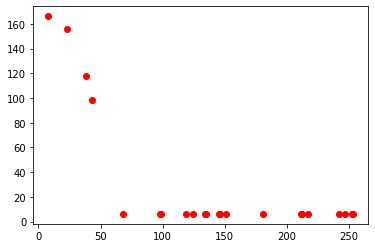

rewaRD::  -41.93154742696211
stepping:  96
Temperature:  [  8.  23.  38.  43.  68.  98.  99. 119. 124. 134. 135. 145. 146. 151.
 181. 211. 212. 217. 242. 247. 252. 253. 283.]
ORDER PARAM RESULT (X2): 75.07963753788036
THE JT RESULT {X0}: 1.999838659033448
THE NF RESULT {X1}: 132.92320952845537
THE BK RESULT {X3}: 5.620936021381111
chisqds:  6.53213704578923


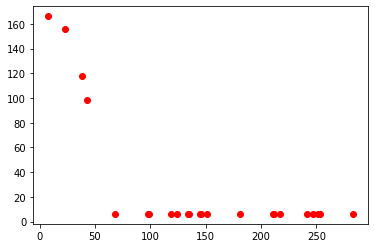

rewaRD::  -38.764297626325906
stepping:  96
Temperature:  [  8.  23.  38.  43.  68.  98.  99. 119. 124. 134. 135. 145. 146. 151.
 181. 211. 212. 217. 242. 247. 252. 253. 283. 293.]
ORDER PARAM RESULT (X2): 75.08314075617159
THE JT RESULT {X0}: 1.9998211096884535
THE NF RESULT {X1}: 132.92651533766207
THE BK RESULT {X3}: 5.642838948970838
chisqds:  6.218307352856048


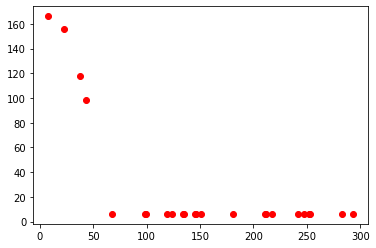

rewaRD::  -35.673813257834325
stepping:  96
Temperature:  [  8.  23.  38.  43.  68.  98.  99. 119. 124. 134. 135. 145. 146. 151.
 181. 211. 212. 217. 242. 247. 252. 253. 283. 293. 318.]
ORDER PARAM RESULT (X2): 75.07931157863827
THE JT RESULT {X0}: 1.9998697623163078
THE NF RESULT {X1}: 132.91616101723224
THE BK RESULT {X3}: 5.662009784260987
chisqds:  5.922911246177877


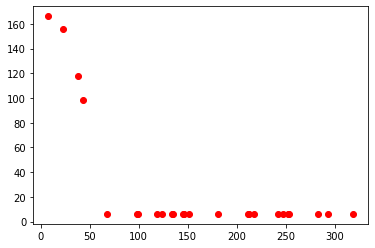

rewaRD::  -32.465643435375696
stepping:  96
Temperature:  [  8.  23.  38.  43.  68.  98.  99. 119. 124. 134. 135. 145. 146. 151.
 181. 211. 212. 217. 242. 247. 252. 253. 283. 293. 318. 319.]
ORDER PARAM RESULT (X2): 75.08556892621095
THE JT RESULT {X0}: 1.9998331086631185
THE NF RESULT {X1}: 132.92534875141985
THE BK RESULT {X3}: 5.68028273531037
chisqds:  5.668012594195642


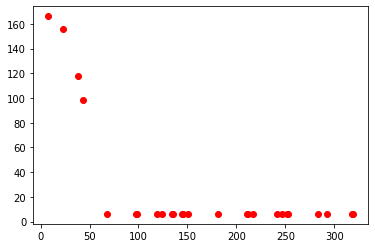

rewaRD::  -29.42852660390662
stepping:  96
Temperature:  [  8.  23.  38.  43.  68.  98.  99. 119. 124. 134. 135. 145. 146. 151.
 181. 211. 212. 217. 242. 247. 252. 253. 283. 293. 318. 319. 329.]
ORDER PARAM RESULT (X2): 75.0523568128483
THE JT RESULT {X0}: 1.9999772599761736
THE NF RESULT {X1}: 132.85954250908213
THE BK RESULT {X3}: 5.693856830593296
chisqds:  5.382002740609233


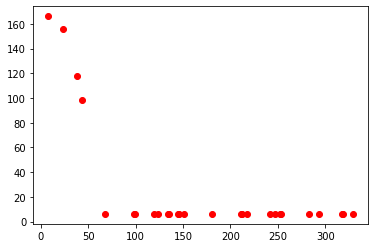

rewaRD::  -25.678224393709485
stepping:  96
Temperature:  [  8.  23.  38.  43.  68.  98.  99. 119. 124. 134. 135. 145. 146. 151.
 181. 211. 212. 217. 242. 247. 252. 253. 283. 293. 318. 319. 329. 354.]
ORDER PARAM RESULT (X2): 75.08697044287062
THE JT RESULT {X0}: 1.9998026122816852
THE NF RESULT {X1}: 132.92320456344763
THE BK RESULT {X3}: 5.711408135681072
chisqds:  5.206432937202778


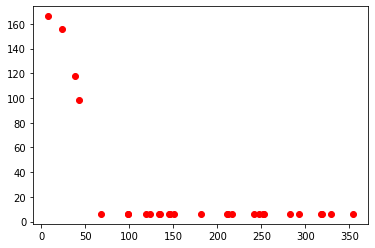

rewaRD::  -23.17196729035271
terminated: over max temp
reset
fixed Tn:  120
fixed Jt:  1.2
fixed Nf:  250
fixed Bk:  4.8
start Tn:  112
start Jt:  1.42
start Nf:  246
start Bk:  4.92
stepping:  97
Temperature:  [23.]
rewaRD::  -100
stepping:  97
Temperature:  [23. 28.]
rewaRD::  -100
stepping:  97
Temperature:  [23. 28. 29.]
rewaRD::  -100
--------------------------------------
| approxkl           | 0.00015546335 |
| clipfrac           | 0.0           |
| ep_len_mean        | 7.56          |
| ep_reward_mean     | -307          |
| explained_variance | 0.000279      |
| fps                | 4             |
| n_updates          | 6             |
| policy_entropy     | 1.9415258     |
| policy_loss        | -0.0021006    |
| serial_timesteps   | 768           |
| time_elapsed       | 82            |
| total_timesteps    | 768           |
| value_loss         | 54302.453     |
--------------------------------------
stepping:  97
Temperature:  [23. 28. 29. 39.]
rewaRD::  -100
stepping:  9

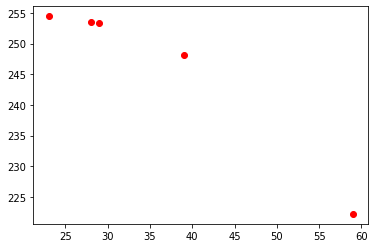

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  90
fixed Jt:  0.7
fixed Nf:  270
fixed Bk:  4.8
start Tn:  102
start Jt:  0.46
start Nf:  258
start Bk:  4.74
stepping:  98
Temperature:  [13.]
rewaRD::  -100
stepping:  98
Temperature:  [13. 23.]
rewaRD::  -100
stepping:  98
Temperature:  [13. 23. 43.]
rewaRD::  -100
stepping:  98
Temperature:  [13. 23. 43. 48.]
rewaRD::  -100
stepping:  98
Temperature:  [13. 23. 43. 48. 68.]
ORDER PARAM RESULT (X2): 89.99999999999005
THE JT RESULT {X0}: 0.6999999999998431
THE NF RESULT {X1}: 269.999999999916
THE BK RESULT {X3}: 4.800000000084025
chisqds:  2.1177999339651056e-27


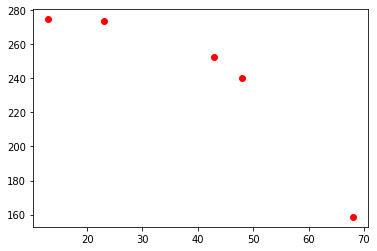

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  270
fixed Jt:  1.1
fixed Nf:  350
fixed Bk:  5.2
start Tn:  272
start Jt:  1.3
start Nf:  342
start Bk:  5.22
stepping:  99
Temperature:  [23.]
rewaRD::  -100
stepping:  99
Temperature:  [23. 38.]
rewaRD::  -100
stepping:  99
Temperature:  [23. 38. 58.]
rewaRD::  -100
stepping:  99
Temperature:  [23. 38. 58. 63.]
rewaRD::  -100
stepping:  99
Temperature:  [23. 38. 58. 63. 64.]
ORDER PARAM RESULT (X2): 299.988157148079
THE JT RESULT {X0}: 0.9133417012803027
THE NF RESULT {X1}: 343.86543292908664
THE BK RESULT {X3}: 7.081977922447626
chisqds:  0.19774124748510008


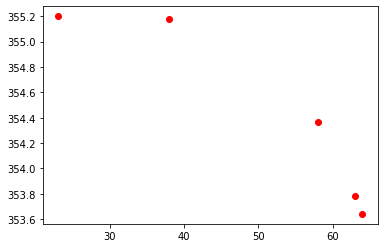

rewaRD::  300
stepping:  99
Temperature:  [23. 38. 58. 63. 64. 84.]
ORDER PARAM RESULT (X2): 290.0134012179005
THE JT RESULT {X0}: 1.0140844179622328
THE NF RESULT {X1}: 344.79932187804087
THE BK RESULT {X3}: 7.99944766027242
chisqds:  0.029645845148878452


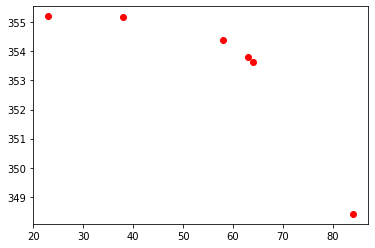

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  80
fixed Jt:  1.0
fixed Nf:  120
fixed Bk:  6.2
start Tn:  72
start Jt:  1.24
start Nf:  120
start Bk:  6.14
stepping:  100
Temperature:  [33.]
rewaRD::  -100
stepping:  100
Temperature:  [33. 48.]
rewaRD::  -100
stepping:  100
Temperature:  [33. 48. 53.]
rewaRD::  -100
stepping:  100
Temperature:  [33. 48. 53. 58.]
rewaRD::  -100
stepping:  100
Temperature:  [33. 48. 53. 58. 88.]
ORDER PARAM RESULT (X2): 79.99999999999983
THE JT RESULT {X0}: 0.999999999999976
THE NF RESULT {X1}: 119.99999999999989
THE BK RESULT {X3}: 6.2
chisqds:  2.120553869592146e-28


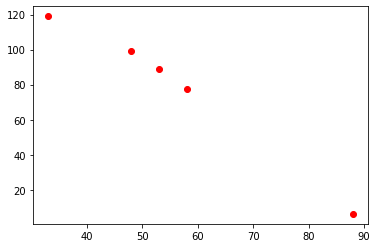

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  270
fixed Jt:  1.1
fixed Nf:  320
fixed Bk:  3.0
start Tn:  266
start Jt:  0.86
start Nf:  322
start Bk:  3.08
stepping:  101
Temperature:  [8.]
rewaRD::  -100
stepping:  101
Temperature:  [ 8. 23.]
rewaRD::  -100
stepping:  101
Temperature:  [ 8. 23. 33.]
rewaRD::  -100
stepping:  101
Temperature:  [ 8. 23. 33. 63.]
rewaRD::  -100
stepping:  101
Temperature:  [ 8. 23. 33. 63. 93.]
ORDER PARAM RESULT (X2): 269.9999999788333
THE JT RESULT {X0}: 1.0999999998433116
THE NF RESULT {X1}: 319.9999999464387
THE BK RESULT {X3}: 3.0000000535613225
chisqds:  8.95966247443869e-28


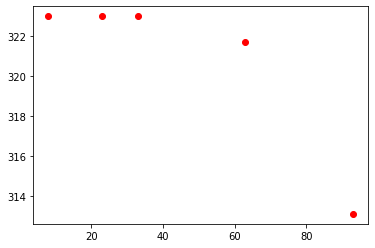

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  150
fixed Jt:  1.2
fixed Nf:  340
fixed Bk:  4.2
start Tn:  154
start Jt:  1.46
start Nf:  346
start Bk:  4.28
stepping:  102
Temperature:  [4.]
rewaRD::  -100
stepping:  102
Temperature:  [4. 5.]
rewaRD::  -100
stepping:  102
Temperature:  [ 4.  5. 20.]
rewaRD::  -100
stepping:  102
Temperature:  [ 4.  5. 20. 50.]
rewaRD::  -100
stepping:  102
Temperature:  [ 4.  5. 20. 50. 70.]
ORDER PARAM RESULT (X2): 150.00000000104447
THE JT RESULT {X0}: 1.200000000012935
THE NF RESULT {X1}: 340.0000000054494
THE BK RESULT {X3}: 4.199999994550544
chisqds:  6.562149621946118e-27


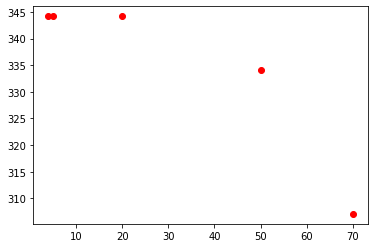

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  150
fixed Jt:  1.4
fixed Nf:  220
fixed Bk:  7.4
start Tn:  156
start Jt:  1.58
start Nf:  236
start Bk:  7.42
stepping:  103
Temperature:  [4.]
rewaRD::  -100
stepping:  103
Temperature:  [4. 9.]
rewaRD::  -100
stepping:  103
Temperature:  [ 4.  9. 19.]
rewaRD::  -100
stepping:  103
Temperature:  [ 4.  9. 19. 39.]
rewaRD::  -100
stepping:  103
Temperature:  [ 4.  9. 19. 39. 44.]
ORDER PARAM RESULT (X2): 150.00000000136103
THE JT RESULT {X0}: 1.4000000000208845
THE NF RESULT {X1}: 220.00000000379185
THE BK RESULT {X3}: 7.399999996208131
chisqds:  7.079777497734107e-28


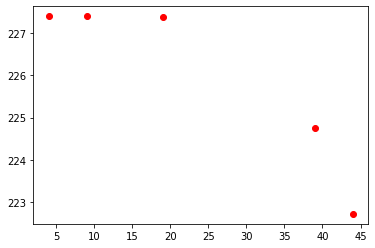

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  140
fixed Jt:  1.3
fixed Nf:  450
fixed Bk:  6.8
start Tn:  148
start Jt:  1.06
start Nf:  430
start Bk:  6.7
stepping:  104
Temperature:  [23.]
rewaRD::  -100
stepping:  104
Temperature:  [23. 43.]
rewaRD::  -100
stepping:  104
Temperature:  [23. 43. 73.]
rewaRD::  -100
stepping:  104
Temperature:  [23. 43. 73. 93.]
rewaRD::  -100
stepping:  104
Temperature:  [ 23.  43.  73.  93. 123.]
ORDER PARAM RESULT (X2): 139.99999999995381
THE JT RESULT {X0}: 1.2999999999997476
THE NF RESULT {X1}: 449.99999999974483
THE BK RESULT {X3}: 6.800000000254719
chisqds:  7.003066405320159e-23


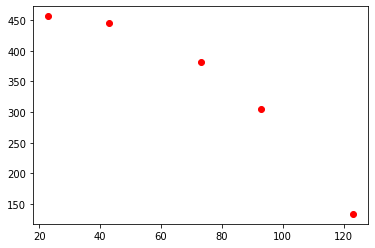

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  140
fixed Jt:  1.4
fixed Nf:  450
fixed Bk:  5.2
start Tn:  154
start Jt:  1.18
start Nf:  448
start Bk:  5.0
stepping:  105
Temperature:  [4.]
rewaRD::  -100
stepping:  105
Temperature:  [4. 9.]
rewaRD::  -100
stepping:  105
Temperature:  [ 4.  9. 39.]
rewaRD::  -100
stepping:  105
Temperature:  [ 4.  9. 39. 54.]
rewaRD::  -100
stepping:  105
Temperature:  [ 4.  9. 39. 54. 79.]
ORDER PARAM RESULT (X2): 140.00000000012432
THE JT RESULT {X0}: 1.4000000000012198
THE NF RESULT {X1}: 450.0000000008268
THE BK RESULT {X3}: 5.199999999173235
chisqds:  3.6943672575792235e-24


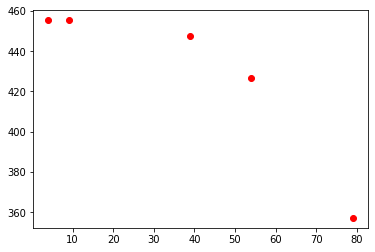

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  180
fixed Jt:  1.2
fixed Nf:  290
fixed Bk:  3.6
start Tn:  192
start Jt:  1.24
start Nf:  282
start Bk:  3.74
stepping:  106
Temperature:  [13.]
rewaRD::  -100
stepping:  106
Temperature:  [13. 28.]
rewaRD::  -100
stepping:  106
Temperature:  [13. 28. 58.]
rewaRD::  -100
stepping:  106
Temperature:  [13. 28. 58. 73.]
rewaRD::  -100
stepping:  106
Temperature:  [ 13.  28.  58.  73. 103.]
ORDER PARAM RESULT (X2): 180.0000000004341
THE JT RESULT {X0}: 1.2000000000030056
THE NF RESULT {X1}: 290.00000000150726
THE BK RESULT {X3}: 3.5999999984928763
chisqds:  2.2494284412614973e-23


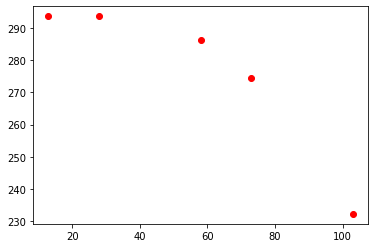

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  90
fixed Jt:  0.8
fixed Nf:  160
fixed Bk:  6.4
start Tn:  70
start Jt:  0.64
start Nf:  158
start Bk:  6.36
stepping:  107
Temperature:  [13.]
rewaRD::  -100
stepping:  107
Temperature:  [13. 18.]
rewaRD::  -100
stepping:  107
Temperature:  [13. 18. 19.]
rewaRD::  -100
stepping:  107
Temperature:  [13. 18. 19. 49.]
rewaRD::  -100
stepping:  107
Temperature:  [13. 18. 19. 49. 50.]
ORDER PARAM RESULT (X2): 71.41752214585954
THE JT RESULT {X0}: 0.4320231307600562
THE NF RESULT {X1}: 159.45893531598404
THE BK RESULT {X3}: 7.999863691390375
chisqds:  6.538803382278427


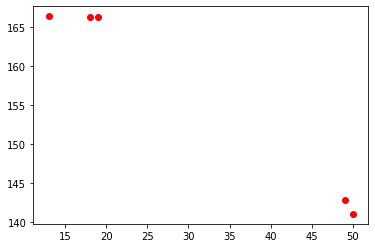

rewaRD::  -38.82672767251473
stepping:  107
Temperature:  [13. 18. 19. 49. 50. 80.]
ORDER PARAM RESULT (X2): 70.70875189525452
THE JT RESULT {X0}: 0.5362529162363521
THE NF RESULT {X1}: 158.74814179214704
THE BK RESULT {X3}: 7.999246881108304
chisqds:  23.19202410804795


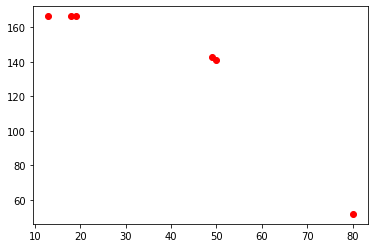

rewaRD::  -82.7526912641836
stepping:  107
Temperature:  [13. 18. 19. 49. 50. 80. 85.]
ORDER PARAM RESULT (X2): 70.74470056030135
THE JT RESULT {X0}: 0.5310043247954551
THE NF RESULT {X1}: 158.79120229950382
THE BK RESULT {X3}: 7.9998870984662105
chisqds:  20.829948557993017


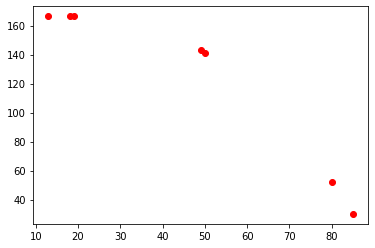

rewaRD::  -80.79688008415609
stepping:  107
Temperature:  [13. 18. 19. 49. 50. 80. 85. 90.]
ORDER PARAM RESULT (X2): 71.62731251949769
THE JT RESULT {X0}: 0.40000087283599933
THE NF RESULT {X1}: 159.68762673170568
THE BK RESULT {X3}: 7.7227015420608796
chisqds:  15.12086730702857


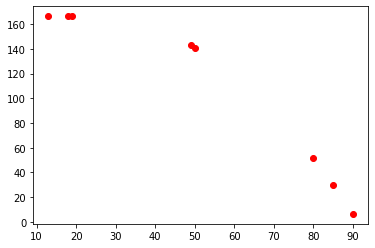

rewaRD::  -73.54649095994185
stepping:  107
Temperature:  [ 13.  18.  19.  49.  50.  80.  85.  90. 100.]
ORDER PARAM RESULT (X2): 71.62627064944613
THE JT RESULT {X0}: 0.40000001841722177
THE NF RESULT {X1}: 159.73677587276703
THE BK RESULT {X3}: 7.176503831669225
chisqds:  12.4889111446046


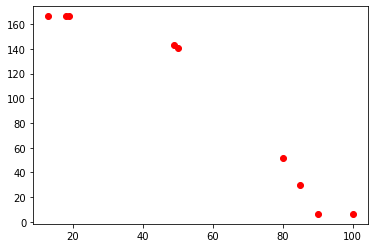

rewaRD::  -67.97158732506428
stepping:  107
Temperature:  [ 13.  18.  19.  49.  50.  80.  85.  90. 100. 125.]
ORDER PARAM RESULT (X2): 71.62600719423317
THE JT RESULT {X0}: 0.4000003359722653
THE NF RESULT {X1}: 159.7557890169675
THE BK RESULT {X3}: 6.944197510163239
chisqds:  10.54669036990763


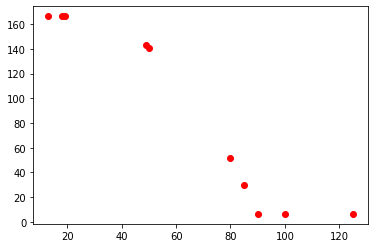

rewaRD::  -62.07341014378302
stepping:  107
Temperature:  [ 13.  18.  19.  49.  50.  80.  85.  90. 100. 125. 130.]
ORDER PARAM RESULT (X2): 71.62586765360166
THE JT RESULT {X0}: 0.40000003553457986
THE NF RESULT {X1}: 159.76591283956515
THE BK RESULT {X3}: 6.8154472838694105
chisqds:  9.106240087444784


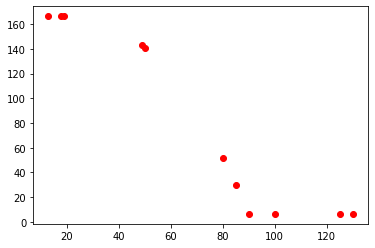

rewaRD::  -56.074077098900624
stepping:  107
Temperature:  [ 13.  18.  19.  49.  50.  80.  85.  90. 100. 125. 130. 155.]
ORDER PARAM RESULT (X2): 71.62578063298226
THE JT RESULT {X0}: 0.40000003453237076
THE NF RESULT {X1}: 159.77217061808503
THE BK RESULT {X3}: 6.733617548083117
chisqds:  8.00481284676045


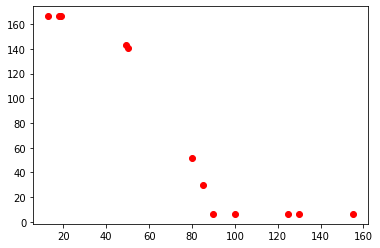

rewaRD::  -50.03006220665357
stepping:  107
Temperature:  [ 13.  18.  19.  49.  50.  80.  85.  90. 100. 125. 130. 155. 170.]
ORDER PARAM RESULT (X2): 71.62572137493159
THE JT RESULT {X0}: 0.40000008922389274
THE NF RESULT {X1}: 159.77641986871416
THE BK RESULT {X3}: 6.677009097069535
chisqds:  7.138064054008662


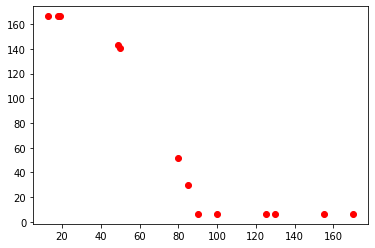

rewaRD::  -43.962396950561946
stepping:  107
Temperature:  [ 13.  18.  19.  49.  50.  80.  85.  90. 100. 125. 130. 155. 170. 171.]
ORDER PARAM RESULT (X2): 90.00000014435429
THE JT RESULT {X0}: 0.8000000484810712
THE NF RESULT {X1}: 160.0000001568552
THE BK RESULT {X3}: 6.399999999998561
chisqds:  8.744205135692773e-16


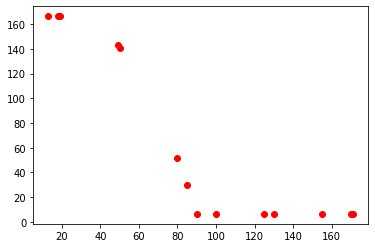

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  150
fixed Jt:  0.7
fixed Nf:  250
fixed Bk:  5.0
start Tn:  140
start Jt:  0.7
start Nf:  234
start Bk:  5.04
stepping:  108
Temperature:  [13.]
rewaRD::  -100
stepping:  108
Temperature:  [13. 23.]
rewaRD::  -100
stepping:  108
Temperature:  [13. 23. 24.]
rewaRD::  -100
stepping:  108
Temperature:  [13. 23. 24. 49.]
rewaRD::  -100
stepping:  108
Temperature:  [13. 23. 24. 49. 59.]
ORDER PARAM RESULT (X2): 147.77867205649187
THE JT RESULT {X0}: 0.47010362058493677
THE NF RESULT {X1}: 236.99357317310532
THE BK RESULT {X3}: 7.999330496244768
chisqds:  1.7311580251546848


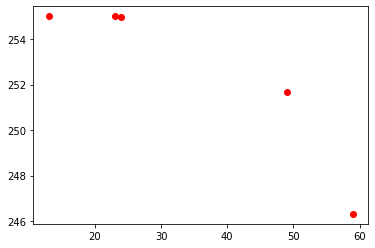

rewaRD::  131.05920672046025
stepping:  108
Temperature:  [13. 23. 24. 49. 59. 74.]
ORDER PARAM RESULT (X2): 144.5770708820135
THE JT RESULT {X0}: 0.5196411378828588
THE NF RESULT {X1}: 237.04744968390958
THE BK RESULT {X3}: 7.999932063638851
chisqds:  1.0848927959427055


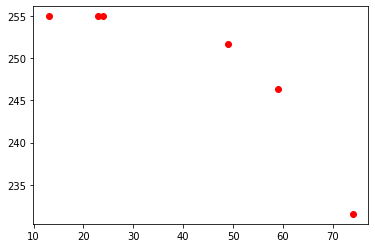

rewaRD::  268.70002409078995
stepping:  108
Temperature:  [13. 23. 24. 49. 59. 74. 75.]
ORDER PARAM RESULT (X2): 144.1368366136819
THE JT RESULT {X0}: 0.5321401400920476
THE NF RESULT {X1}: 237.08545052000156
THE BK RESULT {X3}: 7.999309426225281
chisqds:  0.8643443289214119


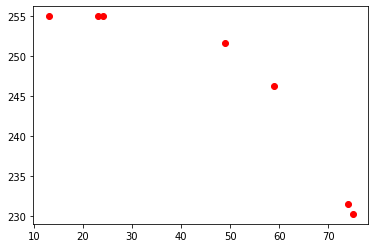

rewaRD::  300
stepping:  108
Temperature:  [13. 23. 24. 49. 59. 74. 75. 90.]
ORDER PARAM RESULT (X2): 143.08834677781184
THE JT RESULT {X0}: 0.540896270850783
THE NF RESULT {X1}: 237.13458984820187
THE BK RESULT {X3}: 7.999927972682661
chisqds:  0.8582793111588554


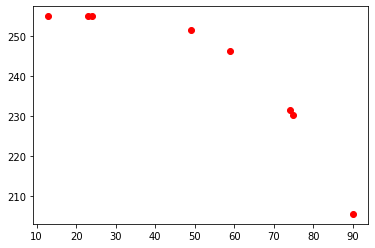

rewaRD::  300
stepping:  108
Temperature:  [13. 23. 24. 49. 59. 74. 75. 90. 91.]
ORDER PARAM RESULT (X2): 149.9999999997214
THE JT RESULT {X0}: 0.6999999999976483
THE NF RESULT {X1}: 249.99999999876138
THE BK RESULT {X3}: 5.000000001238652
chisqds:  1.5338311586594588e-24


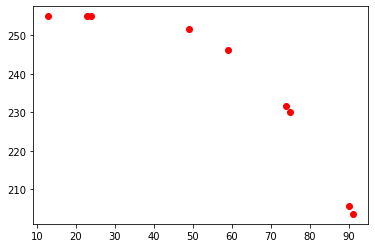

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  190
fixed Jt:  1.1
fixed Nf:  150
fixed Bk:  5.6
start Tn:  178
start Jt:  1.08
start Nf:  132
start Bk:  5.76
stepping:  109
Temperature:  [4.]
rewaRD::  -100
stepping:  109
Temperature:  [4. 9.]
rewaRD::  -100
stepping:  109
Temperature:  [ 4.  9. 29.]
rewaRD::  -100
stepping:  109
Temperature:  [ 4.  9. 29. 30.]
rewaRD::  -100
stepping:  109
Temperature:  [ 4.  9. 29. 30. 55.]
ORDER PARAM RESULT (X2): 198.7874992359731
THE JT RESULT {X0}: 0.6027002536865973
THE NF RESULT {X1}: 134.25669241661723
THE BK RESULT {X3}: 7.999356768800281
chisqds:  5.479848786218642


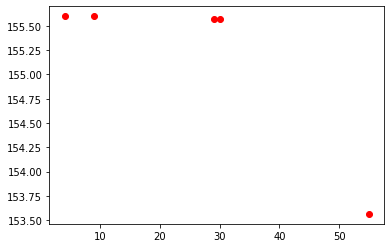

rewaRD::  -27.005285071740246
stepping:  109
Temperature:  [ 4.  9. 29. 30. 55. 70.]
ORDER PARAM RESULT (X2): 191.9919550812175
THE JT RESULT {X0}: 0.7263758884427327
THE NF RESULT {X1}: 134.27206540658997
THE BK RESULT {X3}: 7.999235947794326
chisqds:  3.1291881373274366


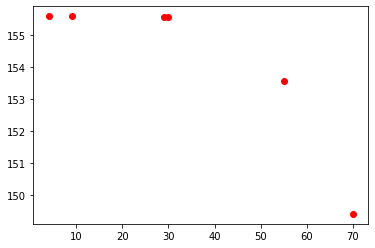

rewaRD::  27.828683494125173
stepping:  109
Temperature:  [  4.   9.  29.  30.  55.  70. 100.]
ORDER PARAM RESULT (X2): 183.5725574925813
THE JT RESULT {X0}: 0.8379533079648571
THE NF RESULT {X1}: 134.32579672020196
THE BK RESULT {X3}: 7.999750031254815
chisqds:  2.4396988605138756


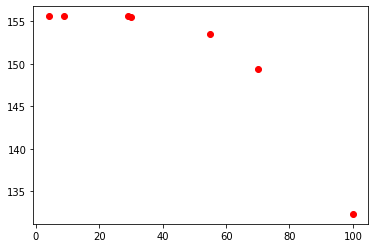

rewaRD::  63.95466115672477
stepping:  109
Temperature:  [  4.   9.  29.  30.  55.  70. 100. 130.]
ORDER PARAM RESULT (X2): 181.12074504076534
THE JT RESULT {X0}: 0.860850176011709
THE NF RESULT {X1}: 134.4249490038098
THE BK RESULT {X3}: 7.9999325141636035
chisqds:  2.2188311382926917


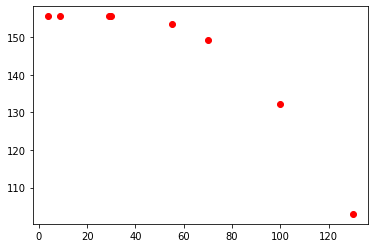

rewaRD::  80.27509759385526
stepping:  109
Temperature:  [  4.   9.  29.  30.  55.  70. 100. 130. 135.]
ORDER PARAM RESULT (X2): 180.7299919189447
THE JT RESULT {X0}: 0.8655856161622276
THE NF RESULT {X1}: 134.5178950276563
THE BK RESULT {X3}: 7.999576256528509
chisqds:  2.0986033996439524


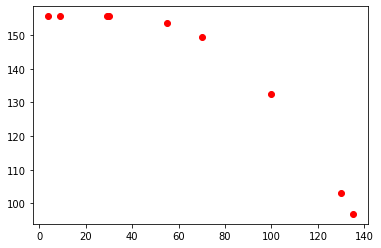

rewaRD::  90.60295054695123
stepping:  109
Temperature:  [  4.   9.  29.  30.  55.  70. 100. 130. 135. 165.]
ORDER PARAM RESULT (X2): 179.88874802431883
THE JT RESULT {X0}: 0.8417247039196851
THE NF RESULT {X1}: 134.55454065001493
THE BK RESULT {X3}: 7.999528657221794
chisqds:  2.562851120429642


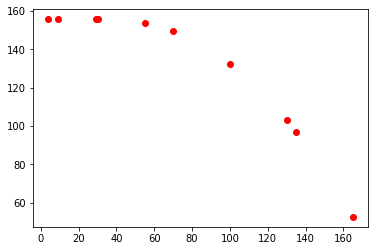

rewaRD::  56.076175011267594
stepping:  109
Temperature:  [  4.   9.  29.  30.  55.  70. 100. 130. 135. 165. 170.]
ORDER PARAM RESULT (X2): 179.6417012172731
THE JT RESULT {X0}: 0.8237970142788219
THE NF RESULT {X1}: 134.5676916036355
THE BK RESULT {X3}: 7.999783426795574
chisqds:  3.1223956740709857


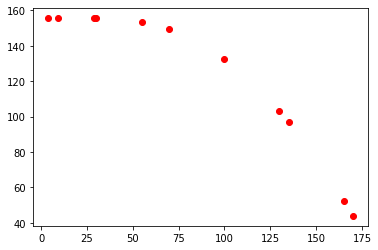

rewaRD::  28.106762163963424
stepping:  109
Temperature:  [  4.   9.  29.  30.  55.  70. 100. 130. 135. 165. 170. 185.]
ORDER PARAM RESULT (X2): 179.96911607636247
THE JT RESULT {X0}: 0.7780956310735505
THE NF RESULT {X1}: 135.09796563596288
THE BK RESULT {X3}: 7.999251410269992
chisqds:  2.8850756515933806


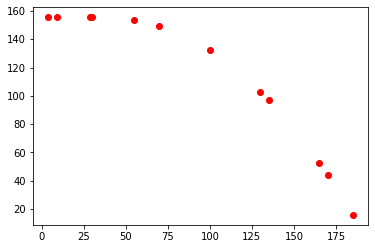

rewaRD::  38.64454465139812
stepping:  109
Temperature:  [  4.   9.  29.  30.  55.  70. 100. 130. 135. 165. 170. 185. 215.]
ORDER PARAM RESULT (X2): 182.3204603479763
THE JT RESULT {X0}: 0.4964949297182913
THE NF RESULT {X1}: 139.01673898728353
THE BK RESULT {X3}: 7.999968209455766
chisqds:  1.177754494815887


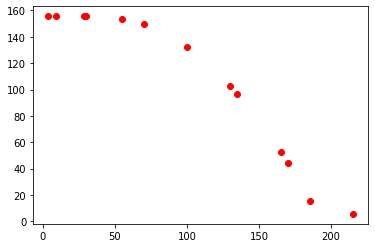

rewaRD::  239.6293554901951
stepping:  109
Temperature:  [  4.   9.  29.  30.  55.  70. 100. 130. 135. 165. 170. 185. 215. 240.]
ORDER PARAM RESULT (X2): 190.00000000009894
THE JT RESULT {X0}: 1.0999999999996277
THE NF RESULT {X1}: 150.00000000000057
THE BK RESULT {X3}: 5.6
chisqds:  3.511542851748312e-22


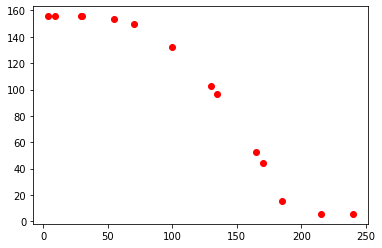

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  210
fixed Jt:  1.0
fixed Nf:  410
fixed Bk:  6.4
start Tn:  212
start Jt:  0.9
start Nf:  422
start Bk:  6.36
stepping:  110
Temperature:  [13.]
rewaRD::  -100
stepping:  110
Temperature:  [13. 23.]
rewaRD::  -100
stepping:  110
Temperature:  [13. 23. 33.]
rewaRD::  -100
stepping:  110
Temperature:  [13. 23. 33. 63.]
rewaRD::  -100
stepping:  110
Temperature:  [13. 23. 33. 63. 88.]
ORDER PARAM RESULT (X2): 210.00000000055837
THE JT RESULT {X0}: 1.0000000000041616
THE NF RESULT {X1}: 410.00000000255795
THE BK RESULT {X3}: 6.399999997441924
chisqds:  7.310921507155428e-25


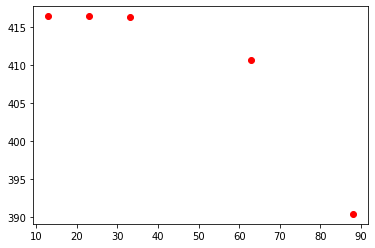

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  80
fixed Jt:  1.3
fixed Nf:  450
fixed Bk:  5.2
start Tn:  64
start Jt:  1.4
start Nf:  468
start Bk:  5.02
stepping:  111
Temperature:  [8.]
rewaRD::  -100
stepping:  111
Temperature:  [ 8. 38.]
rewaRD::  -100
stepping:  111
Temperature:  [ 8. 38. 48.]
rewaRD::  -100
stepping:  111
Temperature:  [ 8. 38. 48. 63.]
rewaRD::  -100
stepping:  111
Temperature:  [ 8. 38. 48. 63. 73.]
ORDER PARAM RESULT (X2): 64.32504123774504
THE JT RESULT {X0}: 1.3253321718235331
THE NF RESULT {X1}: 469.4274276912883
THE BK RESULT {X3}: 7.999887201302134
chisqds:  262.25109518882846


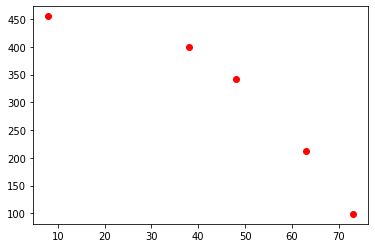

rewaRD::  -98.4747442152263
stepping:  111
Temperature:  [  8.  38.  48.  63.  73. 103.]
ORDER PARAM RESULT (X2): 67.57395988692187
THE JT RESULT {X0}: 0.765708525324501
THE NF RESULT {X1}: 476.9021592981075
THE BK RESULT {X3}: 7.999837744445405
chisqds:  77.91978490640008


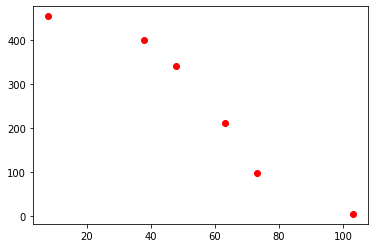

rewaRD::  -94.86651560344406
stepping:  111
Temperature:  [  8.  38.  48.  63.  73. 103. 128.]
ORDER PARAM RESULT (X2): 79.99999999993022
THE JT RESULT {X0}: 1.3000000000003993
THE NF RESULT {X1}: 449.9999999999984
THE BK RESULT {X3}: 5.2
chisqds:  2.8221344213837716e-21


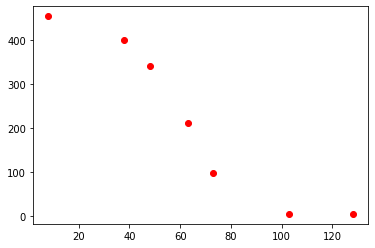

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  250
fixed Jt:  1.2
fixed Nf:  350
fixed Bk:  7.6
start Tn:  230
start Jt:  0.92
start Nf:  346
start Bk:  7.76
stepping:  112
Temperature:  [8.]
rewaRD::  -100
stepping:  112
Temperature:  [ 8. 13.]
rewaRD::  -100
stepping:  112
Temperature:  [ 8. 13. 28.]
rewaRD::  -100
stepping:  112
Temperature:  [ 8. 13. 28. 43.]
rewaRD::  -100
stepping:  112
Temperature:  [ 8. 13. 28. 43. 58.]
ORDER PARAM RESULT (X2): 235.2882036155666
THE JT RESULT {X0}: 0.8508786137005674
THE NF RESULT {X1}: 346.24011380218263
THE BK RESULT {X3}: 7.9992685651369895
chisqds:  0.14732789615148545


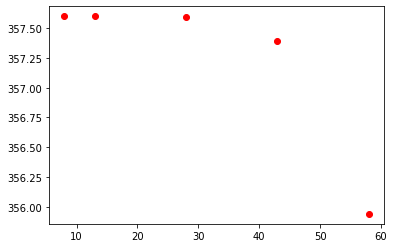

rewaRD::  300
stepping:  112
Temperature:  [ 8. 13. 28. 43. 58. 78.]
ORDER PARAM RESULT (X2): 231.64269822301713
THE JT RESULT {X0}: 0.8942094256860404
THE NF RESULT {X1}: 346.24222502249546
THE BK RESULT {X3}: 7.999461915846753
chisqds:  0.08861602846851813


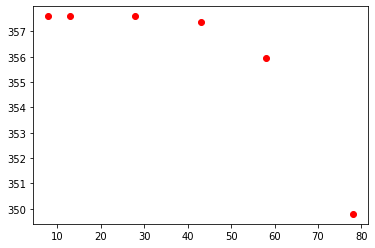

rewaRD::  300
stepping:  112
Temperature:  [ 8. 13. 28. 43. 58. 78. 83.]
ORDER PARAM RESULT (X2): 231.357879396115
THE JT RESULT {X0}: 0.8981093748103623
THE NF RESULT {X1}: 346.2464749482365
THE BK RESULT {X3}: 7.999549727703654
chisqds:  0.06904376455358117


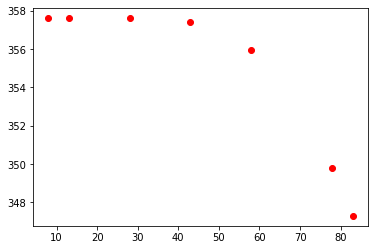

rewaRD::  300
stepping:  112
Temperature:  [ 8. 13. 28. 43. 58. 78. 83. 88.]
ORDER PARAM RESULT (X2): 231.16248607973205
THE JT RESULT {X0}: 0.9006097284642522
THE NF RESULT {X1}: 346.2447956996663
THE BK RESULT {X3}: 7.999320683949003
chisqds:  0.0608964450859241


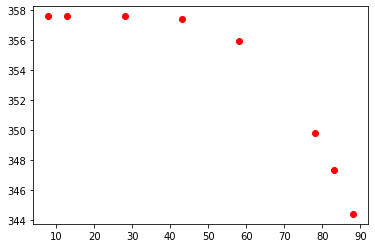

rewaRD::  300
stepping:  112
Temperature:  [  8.  13.  28.  43.  58.  78.  83.  88. 108.]
ORDER PARAM RESULT (X2): 230.82836639173775
THE JT RESULT {X0}: 0.9034167100406201
THE NF RESULT {X1}: 346.2469378679724
THE BK RESULT {X3}: 7.9998001665213145
chisqds:  0.06716130861785756


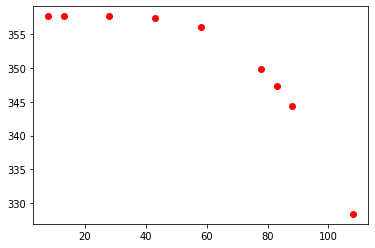

rewaRD::  300
stepping:  112
Temperature:  [  8.  13.  28.  43.  58.  78.  83.  88. 108. 113.]
ORDER PARAM RESULT (X2): 230.69995894952515
THE JT RESULT {X0}: 0.9050464097984692
THE NF RESULT {X1}: 346.2449774303445
THE BK RESULT {X3}: 7.999200834737539
chisqds:  0.07674648243784907


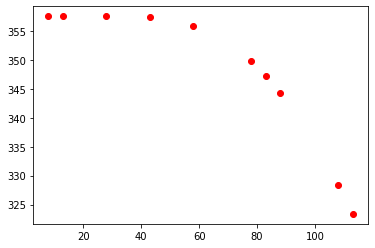

rewaRD::  300
stepping:  112
Temperature:  [  8.  13.  28.  43.  58.  78.  83.  88. 108. 113. 114.]
ORDER PARAM RESULT (X2): 230.63901236511325
THE JT RESULT {X0}: 0.9059296407771753
THE NF RESULT {X1}: 346.2462523159987
THE BK RESULT {X3}: 7.999465911590402
chisqds:  0.084649730873852


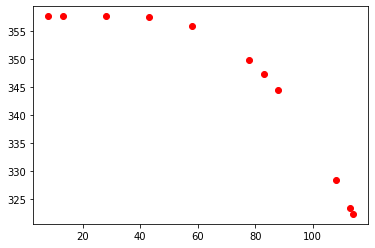

rewaRD::  300
stepping:  112
Temperature:  [  8.  13.  28.  43.  58.  78.  83.  88. 108. 113. 114. 144.]
ORDER PARAM RESULT (X2): 231.21028647350744
THE JT RESULT {X0}: 0.8876457235023718
THE NF RESULT {X1}: 346.5478113820748
THE BK RESULT {X3}: 7.999207250497618
chisqds:  0.12001655152180199


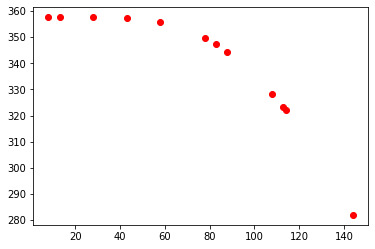

rewaRD::  300
stepping:  112
Temperature:  [  8.  13.  28.  43.  58.  78.  83.  88. 108. 113. 114. 144. 145.]
ORDER PARAM RESULT (X2): 230.45467227679046
THE JT RESULT {X0}: 0.9065436168648214
THE NF RESULT {X1}: 346.242829975982
THE BK RESULT {X3}: 7.999762691887754
chisqds:  0.22924740696740942


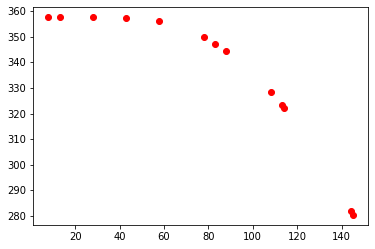

rewaRD::  300
stepping:  112
Temperature:  [  8.  13.  28.  43.  58.  78.  83.  88. 108. 113. 114. 144. 145. 150.]
ORDER PARAM RESULT (X2): 230.4050340729499
THE JT RESULT {X0}: 0.9071035130333516
THE NF RESULT {X1}: 346.2449921405427
THE BK RESULT {X3}: 7.999762848256811
chisqds:  0.30672942968197886


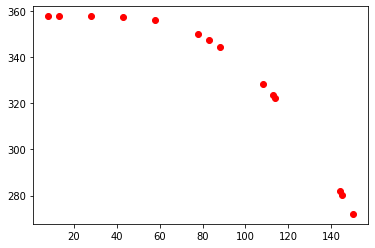

rewaRD::  300
stepping:  112
Temperature:  [  8.  13.  28.  43.  58.  78.  83.  88. 108. 113. 114. 144. 145. 150.
 175.]
ORDER PARAM RESULT (X2): 230.3357200121502
THE JT RESULT {X0}: 0.9075323713249177
THE NF RESULT {X1}: 346.23194620461015
THE BK RESULT {X3}: 7.999499620580361
chisqds:  0.5979759210009812


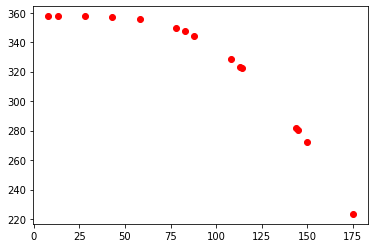

rewaRD::  300
stepping:  112
Temperature:  [  8.  13.  28.  43.  58.  78.  83.  88. 108. 113. 114. 144. 145. 150.
 175. 190.]
ORDER PARAM RESULT (X2): 230.28348285057106
THE JT RESULT {X0}: 0.9075371619449245
THE NF RESULT {X1}: 346.22605943980153
THE BK RESULT {X3}: 7.99966963268998
chisqds:  1.144228956599325


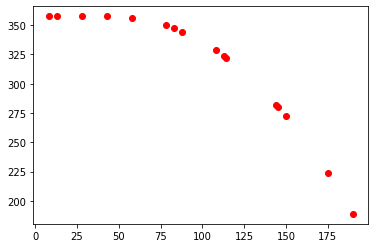

rewaRD::  249.58038572001288
stepping:  112
Temperature:  [  8.  13.  28.  43.  58.  78.  83.  88. 108. 113. 114. 144. 145. 150.
 175. 190. 191.]
ORDER PARAM RESULT (X2): 230.23538295029368
THE JT RESULT {X0}: 0.9082359707307125
THE NF RESULT {X1}: 346.2154217716463
THE BK RESULT {X3}: 7.999689000486578
chisqds:  1.642766390613615


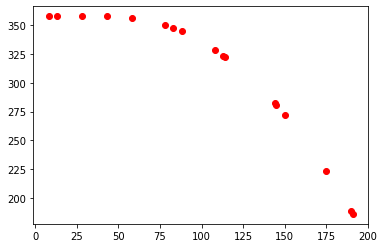

rewaRD::  143.4917114724936
stepping:  112
Temperature:  [  8.  13.  28.  43.  58.  78.  83.  88. 108. 113. 114. 144. 145. 150.
 175. 190. 191. 206.]
ORDER PARAM RESULT (X2): 230.19565772248075
THE JT RESULT {X0}: 0.9088545711838074
THE NF RESULT {X1}: 346.20009297393347
THE BK RESULT {X3}: 7.999490586621515
chisqds:  2.6407132681337657


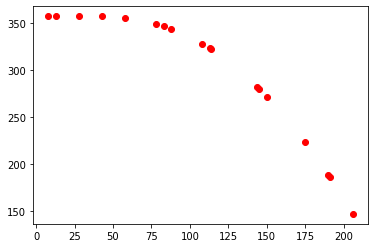

rewaRD::  51.47422661404144
stepping:  112
Temperature:  [  8.  13.  28.  43.  58.  78.  83.  88. 108. 113. 114. 144. 145. 150.
 175. 190. 191. 206. 236.]
ORDER PARAM RESULT (X2): 230.143182734222
THE JT RESULT {X0}: 0.9118260586670464
THE NF RESULT {X1}: 346.1470880733554
THE BK RESULT {X3}: 7.999565745950084
chisqds:  5.243684876802531


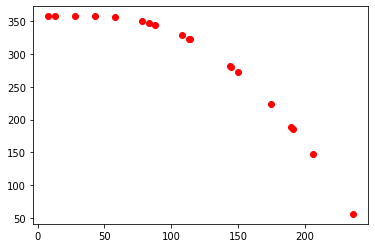

rewaRD::  -23.717765388695497
stepping:  112
Temperature:  [  8.  13.  28.  43.  58.  78.  83.  88. 108. 113. 114. 144. 145. 150.
 175. 190. 191. 206. 236. 246.]
ORDER PARAM RESULT (X2): 230.16887674523514
THE JT RESULT {X0}: 0.9103854240405571
THE NF RESULT {X1}: 346.172116224891
THE BK RESULT {X3}: 7.99929635789078
chisqds:  5.448760367966521


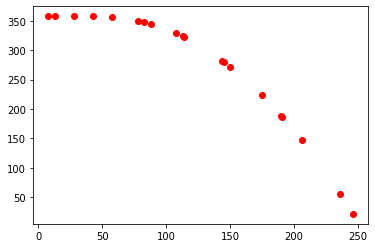

rewaRD::  -26.588806813451384
stepping:  112
Temperature:  [  8.  13.  28.  43.  58.  78.  83.  88. 108. 113. 114. 144. 145. 150.
 175. 190. 191. 206. 236. 246. 251.]
ORDER PARAM RESULT (X2): 230.3507824403175
THE JT RESULT {X0}: 0.9001398433926949
THE NF RESULT {X1}: 346.3544367940919
THE BK RESULT {X3}: 7.999496781049305
chisqds:  5.030563725246886


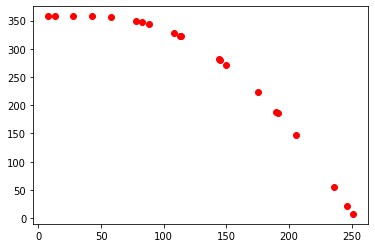

rewaRD::  -20.486048513306713
stepping:  112
Temperature:  [  8.  13.  28.  43.  58.  78.  83.  88. 108. 113. 114. 144. 145. 150.
 175. 190. 191. 206. 236. 246. 251. 261.]
ORDER PARAM RESULT (X2): 230.52878044509896
THE JT RESULT {X0}: 0.8901818526727812
THE NF RESULT {X1}: 346.5322416044297
THE BK RESULT {X3}: 7.999624273678824
chisqds:  4.663392481188456


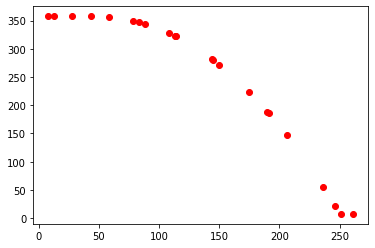

rewaRD::  -14.22553396190645
stepping:  112
Temperature:  [  8.  13.  28.  43.  58.  78.  83.  88. 108. 113. 114. 144. 145. 150.
 175. 190. 191. 206. 236. 246. 251. 261. 286.]
ORDER PARAM RESULT (X2): 230.7104116395493
THE JT RESULT {X0}: 0.8801469230444153
THE NF RESULT {X1}: 346.70963465759786
THE BK RESULT {X3}: 7.9997991946577445
chisqds:  4.335926622632482


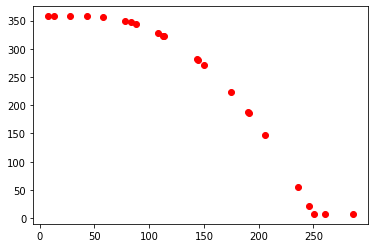

rewaRD::  -7.747516318173524
stepping:  112
Temperature:  [  8.  13.  28.  43.  58.  78.  83.  88. 108. 113. 114. 144. 145. 150.
 175. 190. 191. 206. 236. 246. 251. 261. 286. 291.]
ORDER PARAM RESULT (X2): 230.89367803010646
THE JT RESULT {X0}: 0.8702569805598527
THE NF RESULT {X1}: 346.8785125310135
THE BK RESULT {X3}: 7.999232791294561
chisqds:  4.0439029476402


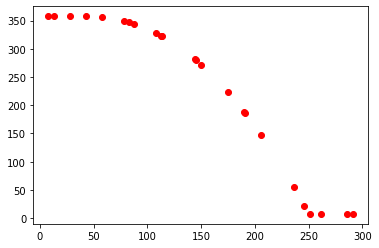

rewaRD::  -1.085657796654587
stepping:  112
Temperature:  [  8.  13.  28.  43.  58.  78.  83.  88. 108. 113. 114. 144. 145. 150.
 175. 190. 191. 206. 236. 246. 251. 261. 286. 291. 301.]
ORDER PARAM RESULT (X2): 231.10717896614244
THE JT RESULT {X0}: 0.8587173548778025
THE NF RESULT {X1}: 347.08002394644
THE BK RESULT {X3}: 7.999715378269206
chisqds:  3.769720887161352


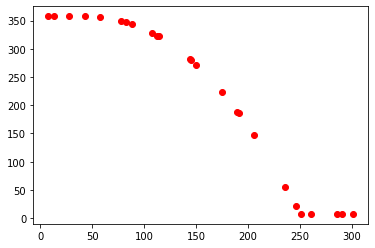

rewaRD::  6.108651534996042
stepping:  112
Temperature:  [  8.  13.  28.  43.  58.  78.  83.  88. 108. 113. 114. 144. 145. 150.
 175. 190. 191. 206. 236. 246. 251. 261. 286. 291. 301. 331.]
ORDER PARAM RESULT (X2): 231.3079755282918
THE JT RESULT {X0}: 0.8494348237463576
THE NF RESULT {X1}: 347.19022011843475
THE BK RESULT {X3}: 7.999325343093662
chisqds:  3.534340518571803


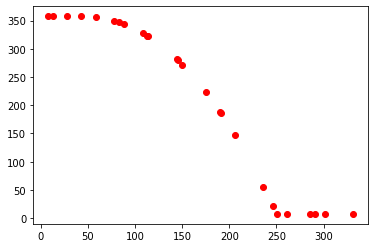

rewaRD::  13.175286279896042
stepping:  112
Temperature:  [  8.  13.  28.  43.  58.  78.  83.  88. 108. 113. 114. 144. 145. 150.
 175. 190. 191. 206. 236. 246. 251. 261. 286. 291. 301. 331. 332.]
ORDER PARAM RESULT (X2): 231.49133754558815
THE JT RESULT {X0}: 0.8397177061702501
THE NF RESULT {X1}: 347.3583719263129
THE BK RESULT {X3}: 7.999313386498127
chisqds:  3.3212782242703898


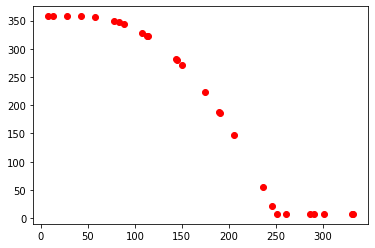

rewaRD::  20.43555914014732
stepping:  112
Temperature:  [  8.  13.  28.  43.  58.  78.  83.  88. 108. 113. 114. 144. 145. 150.
 175. 190. 191. 206. 236. 246. 251. 261. 286. 291. 301. 331. 332. 352.]
ORDER PARAM RESULT (X2): 231.8665227838047
THE JT RESULT {X0}: 0.8203324670890526
THE NF RESULT {X1}: 347.6829779506814
THE BK RESULT {X3}: 7.999392454501415
chisqds:  3.0725291155805685


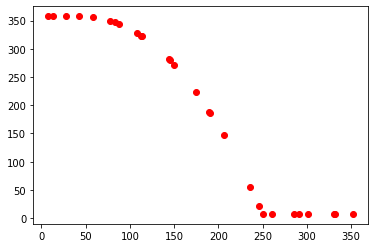

rewaRD::  30.185910353665832
terminated: over max temp
reset
fixed Tn:  190
fixed Jt:  1.4
fixed Nf:  190
fixed Bk:  5.0
start Tn:  206
start Jt:  1.68
start Nf:  190
start Bk:  4.92
stepping:  113
Temperature:  [28.]
rewaRD::  -100
stepping:  113
Temperature:  [28. 48.]
rewaRD::  -100
stepping:  113
Temperature:  [28. 48. 63.]
rewaRD::  -100
--------------------------------------
| approxkl           | 7.1472314e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 8.3           |
| ep_reward_mean     | 103           |
| explained_variance | 0.000167      |
| fps                | 4             |
| n_updates          | 7             |
| policy_entropy     | 1.942791      |
| policy_loss        | 0.00064867304 |
| serial_timesteps   | 896           |
| time_elapsed       | 109           |
| total_timesteps    | 896           |
| value_loss         | 272005.25     |
--------------------------------------
stepping:  113
Temperature:  [28. 48. 63. 73.]
rewaRD::  -100
stepping

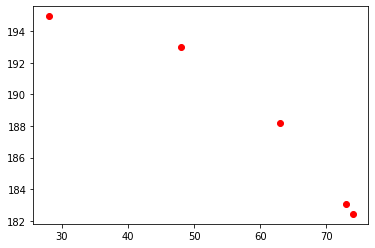

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  180
fixed Jt:  1.4
fixed Nf:  270
fixed Bk:  5.0
start Tn:  170
start Jt:  1.46
start Nf:  266
start Bk:  5.1
stepping:  114
Temperature:  [23.]
rewaRD::  -100
stepping:  114
Temperature:  [23. 43.]
rewaRD::  -100
stepping:  114
Temperature:  [23. 43. 68.]
rewaRD::  -100
stepping:  114
Temperature:  [23. 43. 68. 88.]
rewaRD::  -100
stepping:  114
Temperature:  [23. 43. 68. 88. 89.]
ORDER PARAM RESULT (X2): 180.00000000003638
THE JT RESULT {X0}: 1.4000000000003614
THE NF RESULT {X1}: 270.0000000001169
THE BK RESULT {X3}: 4.999999999883103
chisqds:  1.5160345151176124e-26


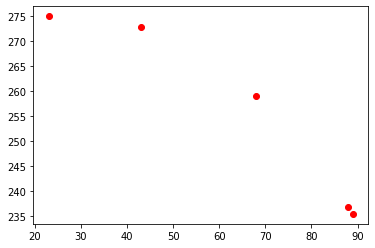

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  70
fixed Jt:  1.3
fixed Nf:  250
fixed Bk:  6.2
start Tn:  88
start Jt:  1.32
start Nf:  266
start Bk:  6.16
stepping:  115
Temperature:  [8.]
rewaRD::  -100
stepping:  115
Temperature:  [ 8. 28.]
rewaRD::  -100
stepping:  115
Temperature:  [ 8. 28. 38.]
rewaRD::  -100
stepping:  115
Temperature:  [ 8. 28. 38. 58.]
rewaRD::  -100
stepping:  115
Temperature:  [ 8. 28. 38. 58. 88.]
ORDER PARAM RESULT (X2): 87.94445071799028
THE JT RESULT {X0}: 1.9998187211512257
THE NF RESULT {X1}: 255.34879233464275
THE BK RESULT {X3}: 5.049842596303661
chisqds:  40.27426391112383


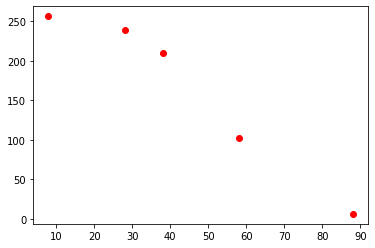

rewaRD::  -90.06809904998613
stepping:  115
Temperature:  [ 8. 28. 38. 58. 88. 93.]
ORDER PARAM RESULT (X2): 87.94703916011917
THE JT RESULT {X0}: 1.9998841023891618
THE NF RESULT {X1}: 255.30794503907913
THE BK RESULT {X3}: 5.5774107122144905
chisqds:  20.47601352953842


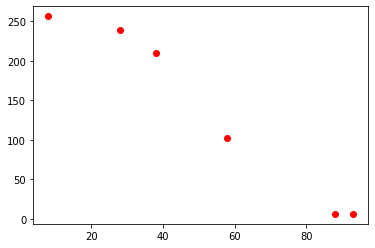

rewaRD::  -80.46494746533716
stepping:  115
Temperature:  [  8.  28.  38.  58.  88.  93. 118.]
ORDER PARAM RESULT (X2): 87.94635165155678
THE JT RESULT {X0}: 1.9998833233813664
THE NF RESULT {X1}: 255.30036645497128
THE BK RESULT {X3}: 5.767167750949058
chisqds:  13.732731157563386


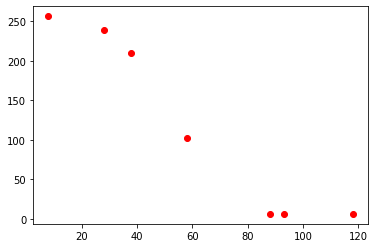

rewaRD::  -70.87250923282674
stepping:  115
Temperature:  [  8.  28.  38.  58.  88.  93. 118. 133.]
ORDER PARAM RESULT (X2): 87.94595057968932
THE JT RESULT {X0}: 1.9999798458727918
THE NF RESULT {X1}: 255.28884266034208
THE BK RESULT {X3}: 5.864586907078373
chisqds:  10.328682567890858


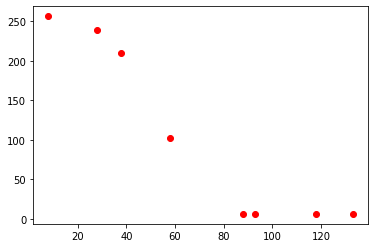

rewaRD::  -61.27289251356275
stepping:  115
Temperature:  [  8.  28.  38.  58.  88.  93. 118. 133. 153.]
ORDER PARAM RESULT (X2): 87.94578125785887
THE JT RESULT {X0}: 1.9998592443967578
THE NF RESULT {X1}: 255.29509367957343
THE BK RESULT {X3}: 5.924272628175962
chisqds:  8.280753948334349


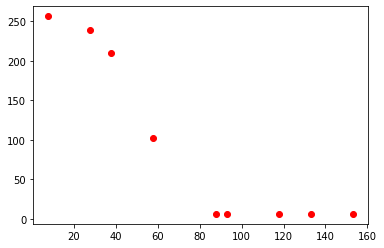

rewaRD::  -51.69521972326458
stepping:  115
Temperature:  [  8.  28.  38.  58.  88.  93. 118. 133. 153. 183.]
ORDER PARAM RESULT (X2): 87.94559742177108
THE JT RESULT {X0}: 1.9999353638766515
THE NF RESULT {X1}: 255.28721677911216
THE BK RESULT {X3}: 5.964197909495718
chisqds:  6.907925503321287


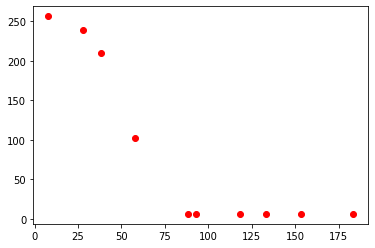

rewaRD::  -42.095495991136204
stepping:  115
Temperature:  [  8.  28.  38.  58.  88.  93. 118. 133. 153. 183. 184.]
ORDER PARAM RESULT (X2): 87.94549489549404
THE JT RESULT {X0}: 1.999891335355809
THE NF RESULT {X1}: 255.28680067922176
THE BK RESULT {X3}: 5.9930087604066005
chisqds:  5.926670369729071


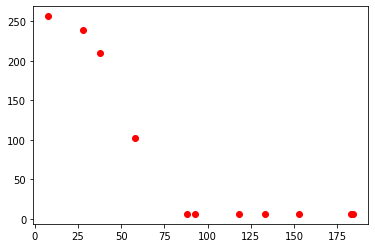

rewaRD::  -32.5084786150701
stepping:  115
Temperature:  [  8.  28.  38.  58.  88.  93. 118. 133. 153. 183. 184. 194.]
ORDER PARAM RESULT (X2): 87.94487654360574
THE JT RESULT {X0}: 1.9998475323750131
THE NF RESULT {X1}: 255.19173408762768
THE BK RESULT {X3}: 6.013523219736902
chisqds:  5.1766767573519


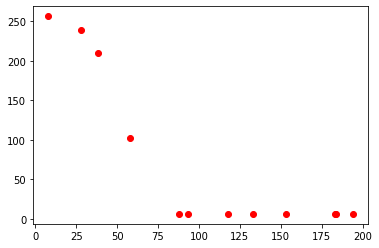

rewaRD::  -22.73035023252683
stepping:  115
Temperature:  [  8.  28.  38.  58.  88.  93. 118. 133. 153. 183. 184. 194. 224.]
ORDER PARAM RESULT (X2): 87.94529854445598
THE JT RESULT {X0}: 1.9999292786378937
THE NF RESULT {X1}: 255.27597489975855
THE BK RESULT {X3}: 6.031553889916461
chisqds:  4.61403495278845


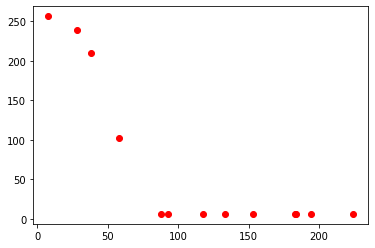

rewaRD::  -13.307982255690618
stepping:  115
Temperature:  [  8.  28.  38.  58.  88.  93. 118. 133. 153. 183. 184. 194. 224. 229.]
ORDER PARAM RESULT (X2): 87.94533330490117
THE JT RESULT {X0}: 1.9998445533629703
THE NF RESULT {X1}: 255.29041903579858
THE BK RESULT {X3}: 6.045307295962319
chisqds:  4.156200173235509


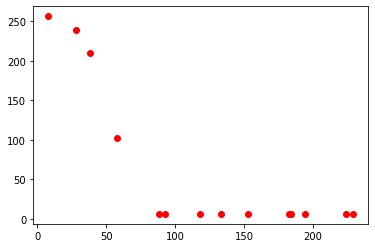

rewaRD::  -3.7582447121143048
stepping:  115
Temperature:  [  8.  28.  38.  58.  88.  93. 118. 133. 153. 183. 184. 194. 224. 229.
 234.]
ORDER PARAM RESULT (X2): 87.94525893821546
THE JT RESULT {X0}: 1.9998778031314646
THE NF RESULT {X1}: 255.28420666443688
THE BK RESULT {X3}: 6.056400051986041
chisqds:  3.7790653882014653


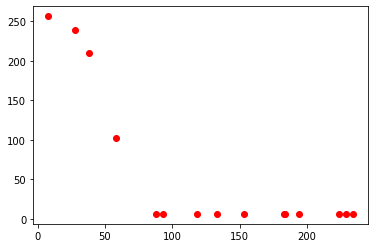

rewaRD::  5.846276502341283
stepping:  115
Temperature:  [  8.  28.  38.  58.  88.  93. 118. 133. 153. 183. 184. 194. 224. 229.
 234. 239.]
ORDER PARAM RESULT (X2): 87.94503511247412
THE JT RESULT {X0}: 1.9998118688825917
THE NF RESULT {X1}: 255.25063485927117
THE BK RESULT {X3}: 6.065440464243753
chisqds:  3.4622654512910347


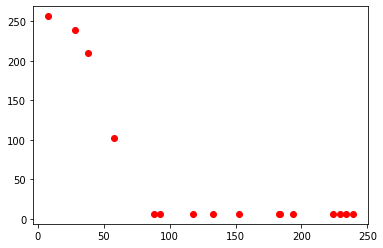

rewaRD::  15.531291758939261
stepping:  115
Temperature:  [  8.  28.  38.  58.  88.  93. 118. 133. 153. 183. 184. 194. 224. 229.
 234. 239. 240.]
ORDER PARAM RESULT (X2): 87.94499301021942
THE JT RESULT {X0}: 1.9999150778364452
THE NF RESULT {X1}: 255.24809030538157
THE BK RESULT {X3}: 6.073337105751937
chisqds:  3.1964011795156875


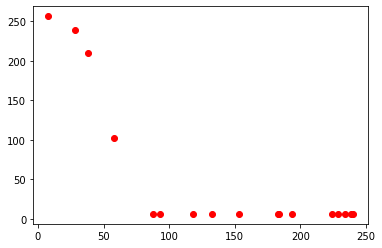

rewaRD::  25.140737202645894
stepping:  115
Temperature:  [  8.  28.  38.  58.  88.  93. 118. 133. 153. 183. 184. 194. 224. 229.
 234. 239. 240. 255.]
ORDER PARAM RESULT (X2): 87.94517112659669
THE JT RESULT {X0}: 1.9999474586826058
THE NF RESULT {X1}: 255.28352727809946
THE BK RESULT {X3}: 6.080374074904511
chisqds:  2.971446640223308


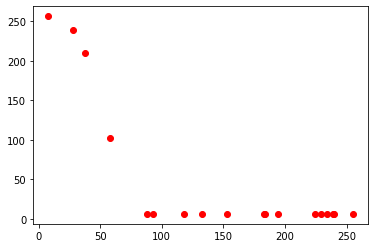

rewaRD::  34.61456604515686
stepping:  115
Temperature:  [  8.  28.  38.  58.  88.  93. 118. 133. 153. 183. 184. 194. 224. 229.
 234. 239. 240. 255. 265.]
ORDER PARAM RESULT (X2): 87.94517683020128
THE JT RESULT {X0}: 1.9998741080021467
THE NF RESULT {X1}: 255.2881513344109
THE BK RESULT {X3}: 6.086280990316941
chisqds:  2.774312652913775


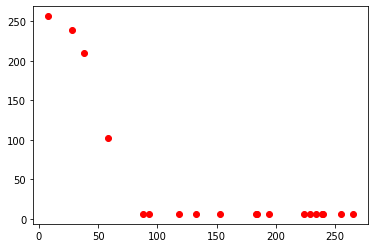

rewaRD::  44.17985643395036
stepping:  115
Temperature:  [  8.  28.  38.  58.  88.  93. 118. 133. 153. 183. 184. 194. 224. 229.
 234. 239. 240. 255. 265. 290.]
ORDER PARAM RESULT (X2): 87.9450781178773
THE JT RESULT {X0}: 1.9998663385471995
THE NF RESULT {X1}: 255.273978058463
THE BK RESULT {X3}: 6.091344627263494
chisqds:  2.6004082107322444


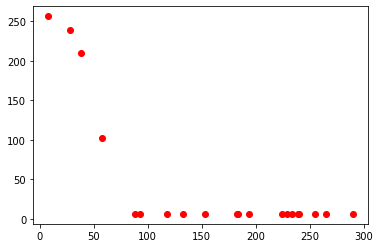

rewaRD::  53.82200315671389
stepping:  115
Temperature:  [  8.  28.  38.  58.  88.  93. 118. 133. 153. 183. 184. 194. 224. 229.
 234. 239. 240. 255. 265. 290. 295.]
ORDER PARAM RESULT (X2): 87.94505432625604
THE JT RESULT {X0}: 1.9999258610688773
THE NF RESULT {X1}: 255.2725997412916
THE BK RESULT {X3}: 6.095887689276187
chisqds:  2.447656300562107


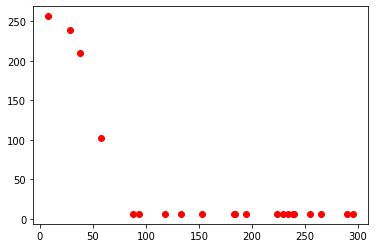

rewaRD::  63.42163722420486
stepping:  115
Temperature:  [  8.  28.  38.  58.  88.  93. 118. 133. 153. 183. 184. 194. 224. 229.
 234. 239. 240. 255. 265. 290. 295. 320.]
ORDER PARAM RESULT (X2): 87.94503313999193
THE JT RESULT {X0}: 1.999978836584367
THE NF RESULT {X1}: 255.27137058460139
THE BK RESULT {X3}: 6.0999300535226535
chisqds:  2.3118553543945413


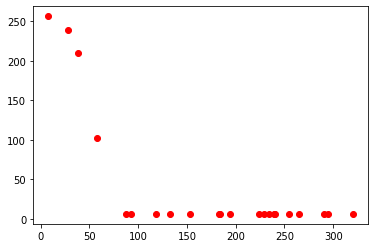

rewaRD::  73.02120534472505
stepping:  115
Temperature:  [  8.  28.  38.  58.  88.  93. 118. 133. 153. 183. 184. 194. 224. 229.
 234. 239. 240. 255. 265. 290. 295. 320. 321.]
ORDER PARAM RESULT (X2): 87.94508717991732
THE JT RESULT {X0}: 1.9999135532099592
THE NF RESULT {X1}: 255.2831018521581
THE BK RESULT {X3}: 6.103611393707794
chisqds:  2.191176198690098


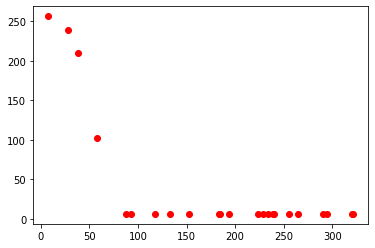

rewaRD::  82.55035822273126
stepping:  115
Temperature:  [  8.  28.  38.  58.  88.  93. 118. 133. 153. 183. 184. 194. 224. 229.
 234. 239. 240. 255. 265. 290. 295. 320. 321. 351.]
ORDER PARAM RESULT (X2): 87.94510678852846
THE JT RESULT {X0}: 1.999805940412446
THE NF RESULT {X1}: 255.288563146798
THE BK RESULT {X3}: 6.106897403255816
chisqds:  2.0822415753900914


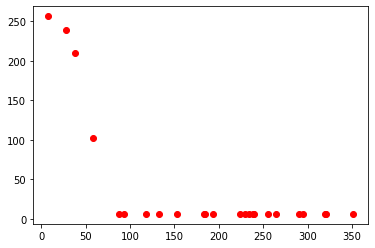

rewaRD::  92.10066916710332
terminated: over max temp
reset
fixed Tn:  180
fixed Jt:  1.4
fixed Nf:  170
fixed Bk:  4.8
start Tn:  190
start Jt:  1.66
start Nf:  152
start Bk:  4.74
stepping:  116
Temperature:  [28.]
rewaRD::  -100
stepping:  116
Temperature:  [28. 58.]
rewaRD::  -100
stepping:  116
Temperature:  [28. 58. 68.]
rewaRD::  -100
stepping:  116
Temperature:  [28. 58. 68. 83.]
rewaRD::  -100
stepping:  116
Temperature:  [28. 58. 68. 83. 84.]
ORDER PARAM RESULT (X2): 200.02890511572411
THE JT RESULT {X0}: 1.2737252908087637
THE NF RESULT {X1}: 155.49853866211006
THE BK RESULT {X3}: 7.999766131558698
chisqds:  1.5492795455592345


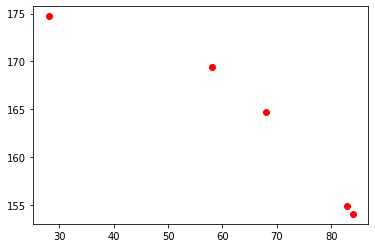

rewaRD::  158.1845227005913
stepping:  116
Temperature:  [ 28.  58.  68.  83.  84. 114.]
ORDER PARAM RESULT (X2): 194.2570686955935
THE JT RESULT {X0}: 1.3674880129325515
THE NF RESULT {X1}: 155.81219004366275
THE BK RESULT {X3}: 7.999598126373067
chisqds:  0.9474581791721906


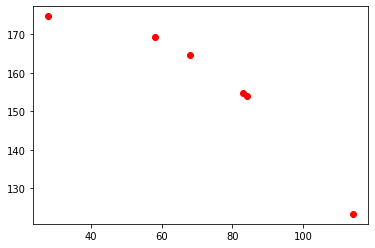

rewaRD::  300
stepping:  116
Temperature:  [ 28.  58.  68.  83.  84. 114. 119.]
ORDER PARAM RESULT (X2): 192.61969559703303
THE JT RESULT {X0}: 1.4114789053933556
THE NF RESULT {X1}: 156.1333876688244
THE BK RESULT {X3}: 7.999719542942088
chisqds:  0.6591146957469602


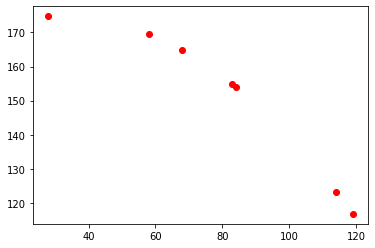

rewaRD::  300
stepping:  116
Temperature:  [ 28.  58.  68.  83.  84. 114. 119. 120.]
ORDER PARAM RESULT (X2): 192.0925968607986
THE JT RESULT {X0}: 1.432867602422783
THE NF RESULT {X1}: 156.37481520282452
THE BK RESULT {X3}: 7.999265641832259
chisqds:  0.49913805642915493


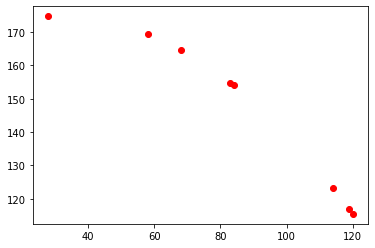

rewaRD::  300
stepping:  116
Temperature:  [ 28.  58.  68.  83.  84. 114. 119. 120. 145.]
ORDER PARAM RESULT (X2): 179.9999999998835
THE JT RESULT {X0}: 1.3999999999994535
THE NF RESULT {X1}: 169.99999999981347
THE BK RESULT {X3}: 4.800000000186423
chisqds:  1.2951091006987852e-23


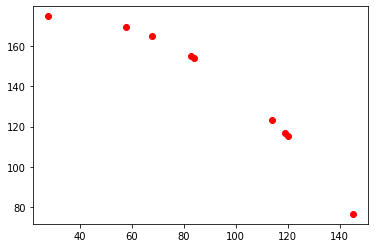

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  220
fixed Jt:  1.2
fixed Nf:  190
fixed Bk:  5.0
start Tn:  204
start Jt:  1.06
start Nf:  200
start Bk:  5.04
stepping:  117
Temperature:  [23.]
rewaRD::  -100
stepping:  117
Temperature:  [23. 43.]
rewaRD::  -100
stepping:  117
Temperature:  [23. 43. 58.]
rewaRD::  -100
stepping:  117
Temperature:  [23. 43. 58. 73.]
rewaRD::  -100
stepping:  117
Temperature:  [ 23.  43.  58.  73. 103.]
ORDER PARAM RESULT (X2): 220.0000000001726
THE JT RESULT {X0}: 1.2000000000010802
THE NF RESULT {X1}: 190.00000000032213
THE BK RESULT {X3}: 4.999999999677881
chisqds:  3.574437673453502e-25


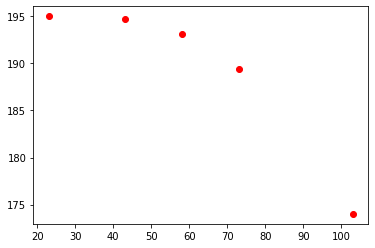

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  170
fixed Jt:  0.8
fixed Nf:  420
fixed Bk:  7.0
start Tn:  154
start Jt:  0.6
start Nf:  412
start Bk:  7.02
stepping:  118
Temperature:  [28.]
rewaRD::  -100
stepping:  118
Temperature:  [28. 53.]
rewaRD::  -100
stepping:  118
Temperature:  [28. 53. 78.]
rewaRD::  -100
stepping:  118
Temperature:  [28. 53. 78. 83.]
rewaRD::  -100
stepping:  118
Temperature:  [28. 53. 78. 83. 88.]
ORDER PARAM RESULT (X2): 154.9232616098695
THE JT RESULT {X0}: 0.5665146985031417
THE NF RESULT {X1}: 413.035787619426
THE BK RESULT {X3}: 7.999356028379425
chisqds:  1.6867582890555364


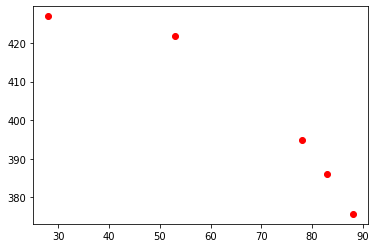

rewaRD::  137.1412683105718
stepping:  118
Temperature:  [28. 53. 78. 83. 88. 98.]
ORDER PARAM RESULT (X2): 154.75895347089286
THE JT RESULT {X0}: 0.5688388862524706
THE NF RESULT {X1}: 413.0484530839889
THE BK RESULT {X3}: 7.9993868261666545
chisqds:  1.623600823668652


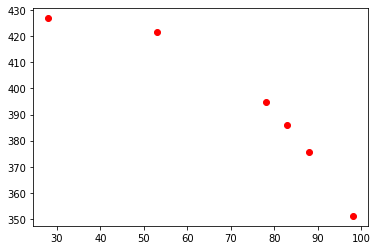

rewaRD::  146.36597504069314
stepping:  118
Temperature:  [ 28.  53.  78.  83.  88.  98. 128.]
ORDER PARAM RESULT (X2): 154.4890461176048
THE JT RESULT {X0}: 0.5695084200939486
THE NF RESULT {X1}: 412.9342829514322
THE BK RESULT {X3}: 7.9997728817029055
chisqds:  5.325316868420948


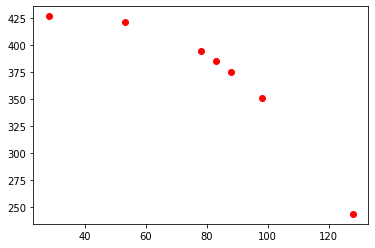

rewaRD::  -24.887098761766808
stepping:  118
Temperature:  [ 28.  53.  78.  83.  88.  98. 128. 129.]
ORDER PARAM RESULT (X2): 154.39028386709361
THE JT RESULT {X0}: 0.5702140881147226
THE NF RESULT {X1}: 412.9443460036115
THE BK RESULT {X3}: 7.999381371473623
chisqds:  7.4749081185565


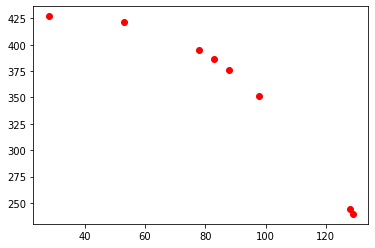

rewaRD::  -46.48763654940482
stepping:  118
Temperature:  [ 28.  53.  78.  83.  88.  98. 128. 129. 159.]
ORDER PARAM RESULT (X2): 154.26529936022223
THE JT RESULT {X0}: 0.5796392680442412
THE NF RESULT {X1}: 412.6498622040016
THE BK RESULT {X3}: 7.999421431286567
chisqds:  19.028156635742807


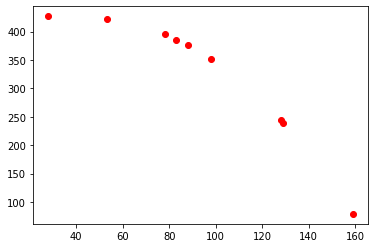

rewaRD::  -78.97852074390468
stepping:  118
Temperature:  [ 28.  53.  78.  83.  88.  98. 128. 129. 159. 184.]
ORDER PARAM RESULT (X2): 155.31374731634668
THE JT RESULT {X0}: 0.5023739777122326
THE NF RESULT {X1}: 414.99438094775303
THE BK RESULT {X3}: 7.9998920176929875
chisqds:  14.174427049347685


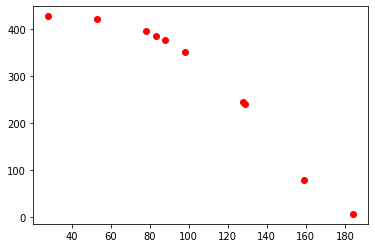

rewaRD::  -71.78016447455573
stepping:  118
Temperature:  [ 28.  53.  78.  83.  88.  98. 128. 129. 159. 184. 214.]
ORDER PARAM RESULT (X2): 156.3743406235154
THE JT RESULT {X0}: 0.4271730995443027
THE NF RESULT {X1}: 417.0956008877505
THE BK RESULT {X3}: 7.9994561110388265
chisqds:  11.054556038521197


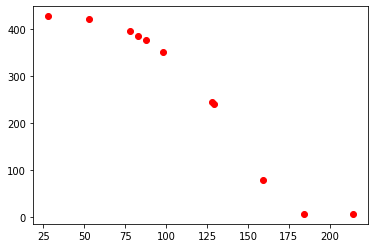

rewaRD::  -63.81582411757268
stepping:  118
Temperature:  [ 28.  53.  78.  83.  88.  98. 128. 129. 159. 184. 214. 234.]
ORDER PARAM RESULT (X2): 156.75871493108798
THE JT RESULT {X0}: 0.4000003530364108
THE NF RESULT {X1}: 417.81505532877543
THE BK RESULT {X3}: 7.809711036886477
chisqds:  9.447976269996005


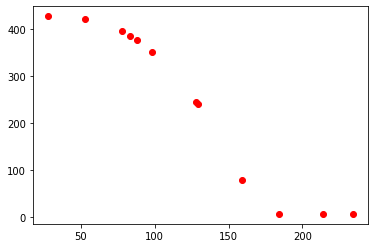

rewaRD::  -57.66289112407252
stepping:  118
Temperature:  [ 28.  53.  78.  83.  88.  98. 128. 129. 159. 184. 214. 234. 259.]
ORDER PARAM RESULT (X2): 156.7564550679476
THE JT RESULT {X0}: 0.4000003742084296
THE NF RESULT {X1}: 417.830336676431
THE BK RESULT {X3}: 7.620446854519618
chisqds:  8.443741770730655


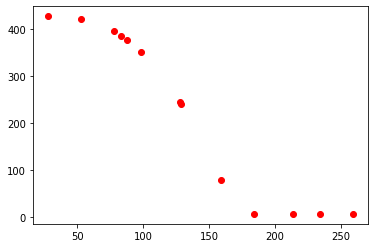

rewaRD::  -52.6276370285792
stepping:  118
Temperature:  [ 28.  53.  78.  83.  88.  98. 128. 129. 159. 184. 214. 234. 259. 260.]
ORDER PARAM RESULT (X2): 156.75508723987213
THE JT RESULT {X0}: 0.40000046699379393
THE NF RESULT {X1}: 417.8396739106218
THE BK RESULT {X3}: 7.503977372688866
chisqds:  7.624608914967958


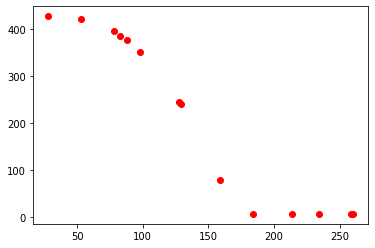

rewaRD::  -47.53829285397768
stepping:  118
Temperature:  [ 28.  53.  78.  83.  88.  98. 128. 129. 159. 184. 214. 234. 259. 260.
 270.]
ORDER PARAM RESULT (X2): 156.75419116760142
THE JT RESULT {X0}: 0.400000233132212
THE NF RESULT {X1}: 417.8459347526431
THE BK RESULT {X3}: 7.42508042775727
chisqds:  6.947009439813871


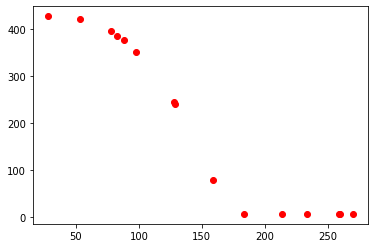

rewaRD::  -42.42126724233772
stepping:  118
Temperature:  [ 28.  53.  78.  83.  88.  98. 128. 129. 159. 184. 214. 234. 259. 260.
 270. 271.]
ORDER PARAM RESULT (X2): 169.9999999999961
THE JT RESULT {X0}: 0.799999999999993
THE NF RESULT {X1}: 419.99999999999966
THE BK RESULT {X3}: 7.0
chisqds:  5.974284161639038e-25


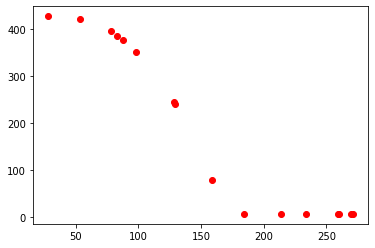

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  150
fixed Jt:  0.8
fixed Nf:  150
fixed Bk:  4.4
start Tn:  134
start Jt:  0.64
start Nf:  156
start Bk:  4.56
stepping:  119
Temperature:  [8.]
rewaRD::  -100
stepping:  119
Temperature:  [ 8. 38.]
rewaRD::  -100
stepping:  119
Temperature:  [ 8. 38. 39.]
rewaRD::  -100
stepping:  119
Temperature:  [ 8. 38. 39. 59.]
rewaRD::  -100
stepping:  119
Temperature:  [ 8. 38. 39. 59. 64.]
ORDER PARAM RESULT (X2): 150.00000000023994
THE JT RESULT {X0}: 0.8000000000023022
THE NF RESULT {X1}: 150.0000000006227
THE BK RESULT {X3}: 4.399999999377339
chisqds:  8.802950456877687e-26


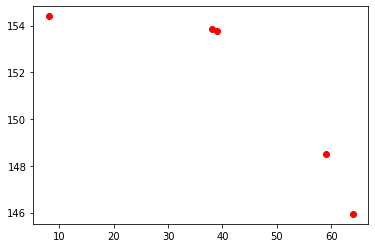

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  150
fixed Jt:  1.1
fixed Nf:  200
fixed Bk:  6.2
start Tn:  140
start Jt:  1.14
start Nf:  218
start Bk:  6.02
stepping:  120
Temperature:  [23.]
rewaRD::  -100
stepping:  120
Temperature:  [23. 33.]
rewaRD::  -100
stepping:  120
Temperature:  [23. 33. 58.]
rewaRD::  -100
stepping:  120
Temperature:  [23. 33. 58. 68.]
rewaRD::  -100
stepping:  120
Temperature:  [23. 33. 58. 68. 88.]
ORDER PARAM RESULT (X2): 143.7750163359589
THE JT RESULT {X0}: 1.072516522649385
THE NF RESULT {X1}: 210.1738481360657
THE BK RESULT {X3}: 0.10000096960870519
chisqds:  0.28038504793267427


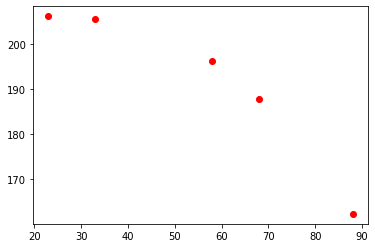

rewaRD::  300
stepping:  120
Temperature:  [ 23.  33.  58.  68.  88. 108.]
ORDER PARAM RESULT (X2): 149.99999999999744
THE JT RESULT {X0}: 1.0999999999999632
THE NF RESULT {X1}: 199.99999999999102
THE BK RESULT {X3}: 6.200000000009013
chisqds:  7.715141560416364e-28


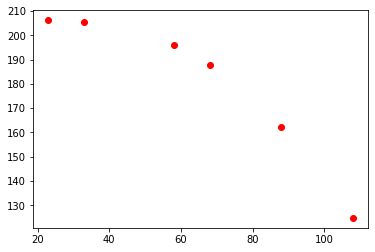

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  250
fixed Jt:  0.8
fixed Nf:  180
fixed Bk:  5.6
start Tn:  260
start Jt:  0.98
start Nf:  188
start Bk:  5.58
stepping:  121
Temperature:  [18.]
rewaRD::  -100
stepping:  121
Temperature:  [18. 33.]
rewaRD::  -100
stepping:  121
Temperature:  [18. 33. 58.]
rewaRD::  -100
stepping:  121
Temperature:  [18. 33. 58. 59.]
rewaRD::  -100
stepping:  121
Temperature:  [18. 33. 58. 59. 79.]
ORDER PARAM RESULT (X2): 250.00000000890947
THE JT RESULT {X0}: 0.8000000000640178
THE NF RESULT {X1}: 180.00000001524646
THE BK RESULT {X3}: 5.5999999847536355
chisqds:  1.3864065740131136e-25


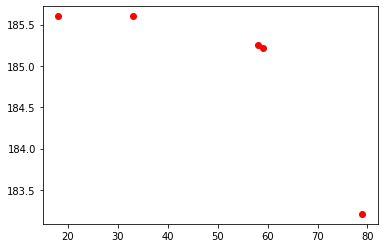

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  110
fixed Jt:  1.4
fixed Nf:  360
fixed Bk:  3.6
start Tn:  116
start Jt:  1.6
start Nf:  378
start Bk:  3.42
stepping:  122
Temperature:  [4.]
rewaRD::  -100
stepping:  122
Temperature:  [4. 5.]
rewaRD::  -100
stepping:  122
Temperature:  [ 4.  5. 25.]
rewaRD::  -100
stepping:  122
Temperature:  [ 4.  5. 25. 26.]
rewaRD::  -100
stepping:  122
Temperature:  [ 4.  5. 25. 26. 27.]
ORDER PARAM RESULT (X2): 104.89502305071774
THE JT RESULT {X0}: 1.9999809594338
THE NF RESULT {X1}: 375.8547930915171
THE BK RESULT {X3}: 1.2814738327970283
chisqds:  1.7101612203290886


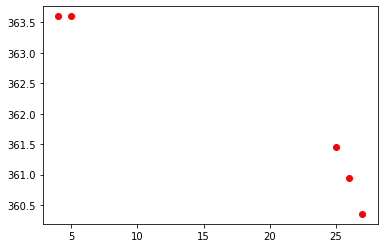

rewaRD::  133.89607672370647
stepping:  122
Temperature:  [ 4.  5. 25. 26. 27. 57.]
ORDER PARAM RESULT (X2): 113.78596928882236
THE JT RESULT {X0}: 1.7689906723999629
THE NF RESULT {X1}: 374.5608102689047
THE BK RESULT {X3}: 0.1000050369975521
chisqds:  0.8092245792657278


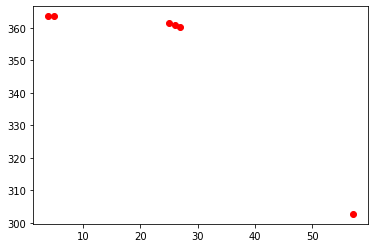

rewaRD::  300
stepping:  122
Temperature:  [ 4.  5. 25. 26. 27. 57. 62.]
ORDER PARAM RESULT (X2): 114.04201690960245
THE JT RESULT {X0}: 1.7518486249638197
THE NF RESULT {X1}: 374.48062372389376
THE BK RESULT {X3}: 0.10000281926790168
chisqds:  0.612506044258399


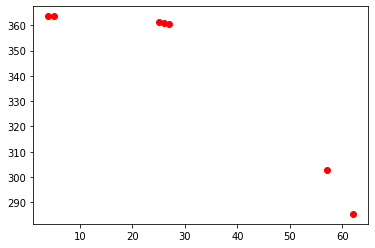

rewaRD::  300
stepping:  122
Temperature:  [ 4.  5. 25. 26. 27. 57. 62. 72.]
ORDER PARAM RESULT (X2): 114.37266246850423
THE JT RESULT {X0}: 1.7473395054117755
THE NF RESULT {X1}: 374.38608283689456
THE BK RESULT {X3}: 0.10001007890982043
chisqds:  0.5757332092435542


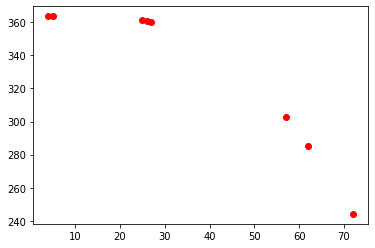

rewaRD::  300
stepping:  122
Temperature:  [ 4.  5. 25. 26. 27. 57. 62. 72. 82.]
ORDER PARAM RESULT (X2): 109.99999999999783
THE JT RESULT {X0}: 1.399999999999964
THE NF RESULT {X1}: 359.9999999999769
THE BK RESULT {X3}: 3.600000000023221
chisqds:  1.509366374127099e-26


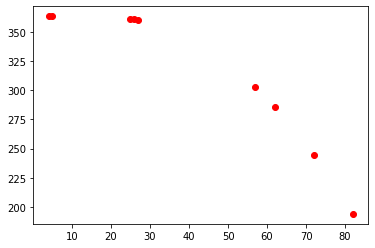

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  210
fixed Jt:  0.8
fixed Nf:  120
fixed Bk:  3.2
start Tn:  192
start Jt:  0.5
start Nf:  112
start Bk:  3.3
stepping:  123
Temperature:  [18.]
rewaRD::  -100
stepping:  123
Temperature:  [18. 28.]
rewaRD::  -100
stepping:  123
Temperature:  [18. 28. 29.]
rewaRD::  -100
stepping:  123
Temperature:  [18. 28. 29. 54.]
rewaRD::  -100
stepping:  123
Temperature:  [18. 28. 29. 54. 84.]
ORDER PARAM RESULT (X2): 210.0000000318645
THE JT RESULT {X0}: 0.8000000002709541
THE NF RESULT {X1}: 120.00000004178018
THE BK RESULT {X3}: 3.199999958219801
chisqds:  6.682547374178564e-23


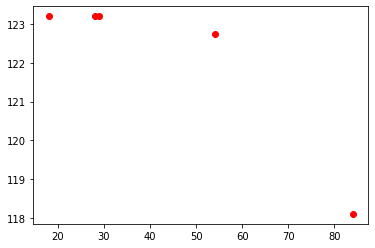

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  90
fixed Jt:  0.9
fixed Nf:  150
fixed Bk:  3.4
start Tn:  74
start Jt:  0.68
start Nf:  154
start Bk:  3.22
stepping:  124
Temperature:  [33.]
rewaRD::  -100
stepping:  124
Temperature:  [33. 34.]
rewaRD::  -100
stepping:  124
Temperature:  [33. 34. 44.]
rewaRD::  -100
stepping:  124
Temperature:  [33. 34. 44. 45.]
rewaRD::  -100
stepping:  124
Temperature:  [33. 34. 44. 45. 75.]
ORDER PARAM RESULT (X2): 74.53060597203005
THE JT RESULT {X0}: 0.6461016760487908
THE NF RESULT {X1}: 154.1950332322261
THE BK RESULT {X3}: 7.999895315260465
chisqds:  48.914510102400456


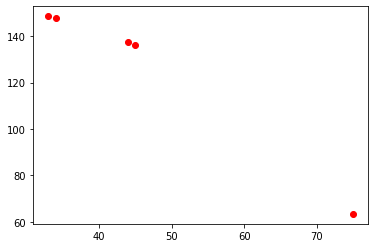

rewaRD::  -91.82246741994109
stepping:  124
Temperature:  [ 33.  34.  44.  45.  75. 105.]
ORDER PARAM RESULT (X2): 89.99999999995406
THE JT RESULT {X0}: 0.9000000000003195
THE NF RESULT {X1}: 149.99999999999716
THE BK RESULT {X3}: 3.4
chisqds:  1.6105198132697499e-22


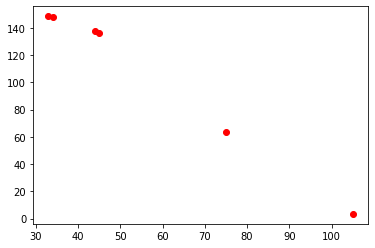

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  100
fixed Jt:  1.4
fixed Nf:  240
fixed Bk:  6.0
start Tn:  102
start Jt:  1.16
start Nf:  248
start Bk:  5.92
stepping:  125
Temperature:  [23.]
rewaRD::  -100
stepping:  125
Temperature:  [23. 48.]
rewaRD::  -100
stepping:  125
Temperature:  [23. 48. 53.]
rewaRD::  -100
stepping:  125
Temperature:  [23. 48. 53. 58.]
rewaRD::  -100
stepping:  125
Temperature:  [23. 48. 53. 58. 59.]
ORDER PARAM RESULT (X2): 100.00000000002235
THE JT RESULT {X0}: 1.400000000000019
THE NF RESULT {X1}: 240.00000000003078
THE BK RESULT {X3}: 5.999999999970234
chisqds:  1.4555671442232826e-23


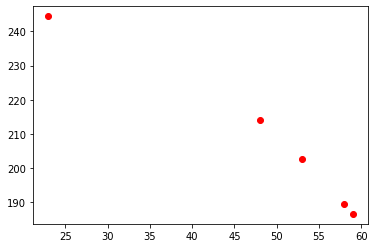

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  200
fixed Jt:  1.3
fixed Nf:  150
fixed Bk:  6.2
start Tn:  180
start Jt:  1.12
start Nf:  134
start Bk:  6.24
stepping:  126
Temperature:  [13.]
rewaRD::  -100
stepping:  126
Temperature:  [13. 38.]
rewaRD::  -100
stepping:  126
Temperature:  [13. 38. 43.]
rewaRD::  -100
stepping:  126
Temperature:  [13. 38. 43. 48.]
rewaRD::  -100
stepping:  126
Temperature:  [13. 38. 43. 48. 63.]
ORDER PARAM RESULT (X2): 195.49272916933228
THE JT RESULT {X0}: 0.7314923143047556
THE NF RESULT {X1}: 135.7747373937634
THE BK RESULT {X3}: 7.9997619675618035
chisqds:  4.457178119229396


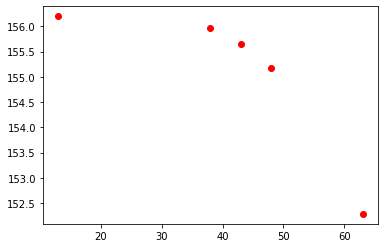

rewaRD::  -10.257120245139262
stepping:  126
Temperature:  [13. 38. 43. 48. 63. 64.]
ORDER PARAM RESULT (X2): 193.9259650800792
THE JT RESULT {X0}: 0.769556085318032
THE NF RESULT {X1}: 135.78935512915533
THE BK RESULT {X3}: 7.999750338232878
chisqds:  2.5989049720352186


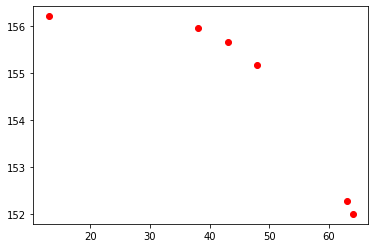

rewaRD::  53.91097570095357
stepping:  126
Temperature:  [13. 38. 43. 48. 63. 64. 89.]
ORDER PARAM RESULT (X2): 187.11813077095837
THE JT RESULT {X0}: 0.8673596228181378
THE NF RESULT {X1}: 135.81535219458792
THE BK RESULT {X3}: 7.9992100063324525
chisqds:  2.0711905884464974


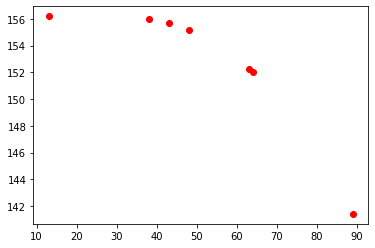

rewaRD::  93.12563615887285
stepping:  126
Temperature:  [13. 38. 43. 48. 63. 64. 89. 99.]
ORDER PARAM RESULT (X2): 185.33893409391962
THE JT RESULT {X0}: 0.9052048380007907
THE NF RESULT {X1}: 135.84003943136022
THE BK RESULT {X3}: 7.9992175205608405
chisqds:  1.8414503351748794


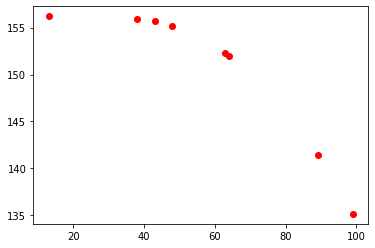

rewaRD::  117.22008590691243
stepping:  126
Temperature:  [ 13.  38.  43.  48.  63.  64.  89.  99. 104.]
ORDER PARAM RESULT (X2): 200.00000000000728
THE JT RESULT {X0}: 1.2999999999999703
THE NF RESULT {X1}: 150.0000000000048
THE BK RESULT {X3}: 6.199999999995213
chisqds:  2.0833129826178048e-26


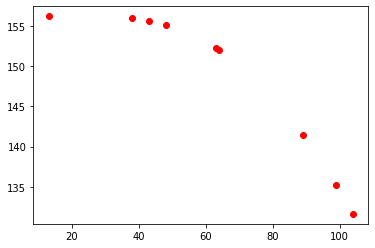

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  70
fixed Jt:  0.9
fixed Nf:  240
fixed Bk:  6.0
start Tn:  86
start Jt:  0.74
start Nf:  240
start Bk:  5.9
stepping:  127
Temperature:  [18.]
rewaRD::  -100
stepping:  127
Temperature:  [18. 38.]
rewaRD::  -100
stepping:  127
Temperature:  [18. 38. 68.]
rewaRD::  -100
stepping:  127
Temperature:  [18. 38. 68. 69.]
rewaRD::  -100
stepping:  127
Temperature:  [18. 38. 68. 69. 84.]
ORDER PARAM RESULT (X2): 85.33817456666348
THE JT RESULT {X0}: 1.2374584347341577
THE NF RESULT {X1}: 220.1224952604373
THE BK RESULT {X3}: 0.10001720146388265
chisqds:  639.7346728717737


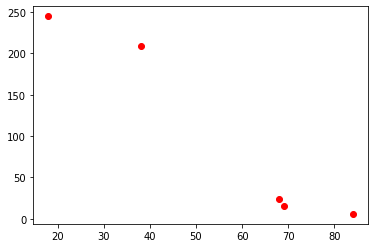

rewaRD::  -100
stepping:  127
Temperature:  [18. 38. 68. 69. 84. 85.]
ORDER PARAM RESULT (X2): 85.44688152335776
THE JT RESULT {X0}: 1.4804400724868512
THE NF RESULT {X1}: 208.9657994979072
THE BK RESULT {X3}: 0.10001613161869281
chisqds:  265.1821688962981


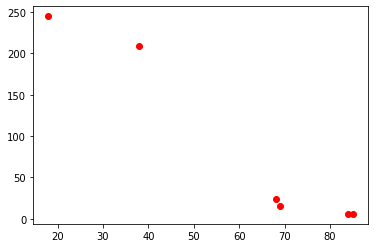

rewaRD::  -98.49160295481094
stepping:  127
Temperature:  [18. 38. 68. 69. 84. 85. 90.]
ORDER PARAM RESULT (X2): 85.18958792555324
THE JT RESULT {X0}: 1.9829685953196754
THE NF RESULT {X1}: 187.26258548575382
THE BK RESULT {X3}: 0.10000520433288175
chisqds:  121.58456636457323


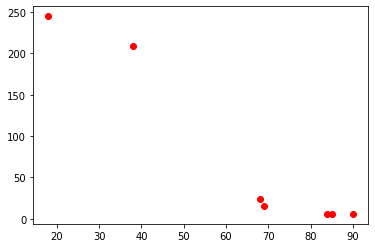

rewaRD::  -96.71010875837158
stepping:  127
Temperature:  [18. 38. 68. 69. 84. 85. 90. 95.]
ORDER PARAM RESULT (X2): 85.11142053225352
THE JT RESULT {X0}: 1.9999542341690633
THE NF RESULT {X1}: 185.47913508922397
THE BK RESULT {X3}: 1.3271144253048734
chisqds:  91.89272320011574


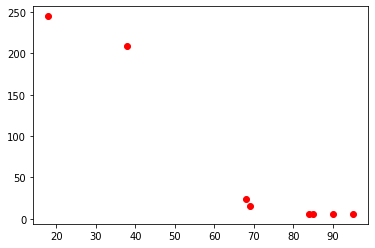

rewaRD::  -95.64709820244508
stepping:  127
Temperature:  [18. 38. 68. 69. 84. 85. 90. 95. 96.]
ORDER PARAM RESULT (X2): 85.07054693403008
THE JT RESULT {X0}: 1.9999432164063244
THE NF RESULT {X1}: 185.02318736191805
THE BK RESULT {X3}: 2.1691398950124703
chisqds:  74.62101067429111


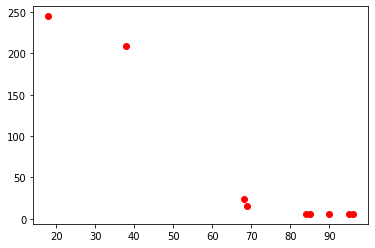

rewaRD::  -94.63957943767424
stepping:  127
Temperature:  [ 18.  38.  68.  69.  84.  85.  90.  95.  96. 111.]
ORDER PARAM RESULT (X2): 85.04553521469755
THE JT RESULT {X0}: 1.9999913314362658
THE NF RESULT {X1}: 184.9083417191224
THE BK RESULT {X3}: 2.759828810085666
chisqds:  62.95540351633341


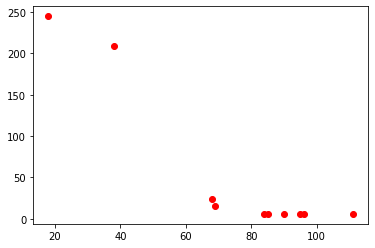

rewaRD::  -93.64629598639262
stepping:  127
Temperature:  [ 18.  38.  68.  69.  84.  85.  90.  95.  96. 111. 136.]
ORDER PARAM RESULT (X2): 85.02672875213878
THE JT RESULT {X0}: 1.9998834475631981
THE NF RESULT {X1}: 184.7724236730035
THE BK RESULT {X3}: 3.1874976853727586
chisqds:  54.4028566654546


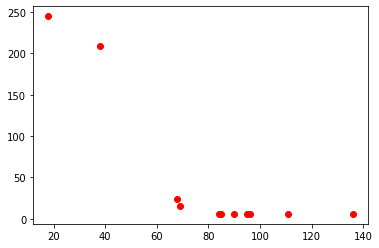

rewaRD::  -92.647444922612
stepping:  127
Temperature:  [ 18.  38.  68.  69.  84.  85.  90.  95.  96. 111. 136. 151.]
ORDER PARAM RESULT (X2): 85.01145955202033
THE JT RESULT {X0}: 1.99981856546807
THE NF RESULT {X1}: 184.60155176921455
THE BK RESULT {X3}: 3.5110366150717396
chisqds:  47.852716606104245


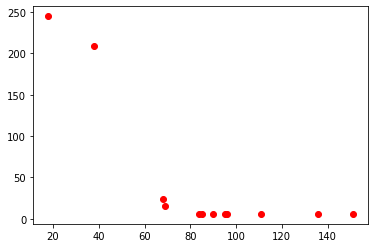

rewaRD::  -91.64101793232415
stepping:  127
Temperature:  [ 18.  38.  68.  69.  84.  85.  90.  95.  96. 111. 136. 151. 176.]
ORDER PARAM RESULT (X2): 84.97189880119603
THE JT RESULT {X0}: 1.999861801875388
THE NF RESULT {X1}: 182.6904056781822
THE BK RESULT {X3}: 3.70516777165746
chisqds:  41.76593027554119


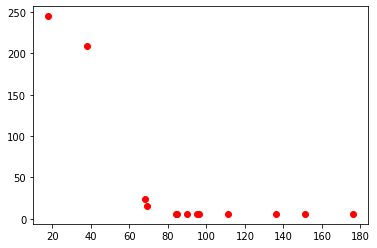

rewaRD::  -90.42281598036746
stepping:  127
Temperature:  [ 18.  38.  68.  69.  84.  85.  90.  95.  96. 111. 136. 151. 176. 181.]
ORDER PARAM RESULT (X2): 84.98863185144526
THE JT RESULT {X0}: 1.999819490638535
THE NF RESULT {X1}: 184.30948078294236
THE BK RESULT {X3}: 3.9721937229005353
chisqds:  38.533516221957804


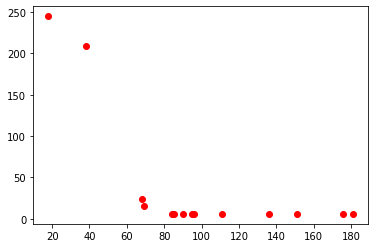

rewaRD::  -89.6194264313708
stepping:  127
Temperature:  [ 18.  38.  68.  69.  84.  85.  90.  95.  96. 111. 136. 151. 176. 181.
 186.]
ORDER PARAM RESULT (X2): 84.98266201685274
THE JT RESULT {X0}: 1.99984511186365
THE NF RESULT {X1}: 184.34745516497821
THE BK RESULT {X3}: 4.146670325543686
chisqds:  35.17691812436896


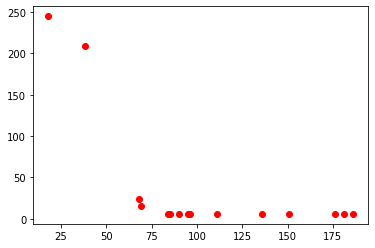

rewaRD::  -88.6289072116611
stepping:  127
Temperature:  [ 18.  38.  68.  69.  84.  85.  90.  95.  96. 111. 136. 151. 176. 181.
 186. 196.]
ORDER PARAM RESULT (X2): 84.97549147317376
THE JT RESULT {X0}: 1.9998248698659038
THE NF RESULT {X1}: 184.25063393847063
THE BK RESULT {X3}: 4.28946617832737
chisqds:  32.30576974515617


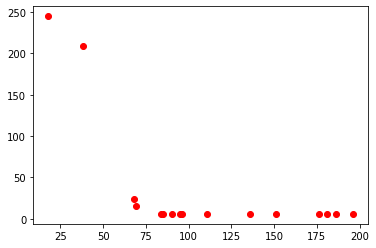

rewaRD::  -87.61831081087381
stepping:  127
Temperature:  [ 18.  38.  68.  69.  84.  85.  90.  95.  96. 111. 136. 151. 176. 181.
 186. 196. 211.]
ORDER PARAM RESULT (X2): 84.96977704693305
THE JT RESULT {X0}: 1.9999651582025615
THE NF RESULT {X1}: 184.19253795456743
THE BK RESULT {X3}: 4.411794275019387
chisqds:  29.876023269475898


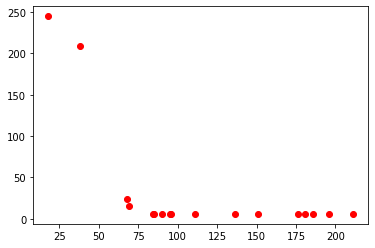

rewaRD::  -86.61133724552033
--------------------------------------
| approxkl           | 9.968733e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 8.48          |
| ep_reward_mean     | 25.5          |
| explained_variance | 0.000151      |
| fps                | 5             |
| n_updates          | 8             |
| policy_entropy     | 1.9419353     |
| policy_loss        | 0.00085898954 |
| serial_timesteps   | 1024          |
| time_elapsed       | 135           |
| total_timesteps    | 1024          |
| value_loss         | 101604.75     |
--------------------------------------
stepping:  127
Temperature:  [ 18.  38.  68.  69.  84.  85.  90.  95.  96. 111. 136. 151. 176. 181.
 186. 196. 211. 226.]
ORDER PARAM RESULT (X2): 84.96437628833593
THE JT RESULT {X0}: 1.9999965420865689
THE NF RESULT {X1}: 184.1391981666765
THE BK RESULT {X3}: 4.517153749252199
chisqds:  27.784191339595917


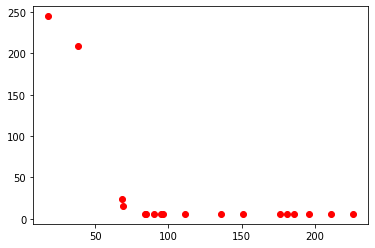

rewaRD::  -85.60332402296876
stepping:  127
Temperature:  [ 18.  38.  68.  69.  84.  85.  90.  95.  96. 111. 136. 151. 176. 181.
 186. 196. 211. 226. 256.]
ORDER PARAM RESULT (X2): 84.96020699112844
THE JT RESULT {X0}: 1.9999566185351465
THE NF RESULT {X1}: 184.11789131713357
THE BK RESULT {X3}: 4.609502036079809
chisqds:  25.974955807090844


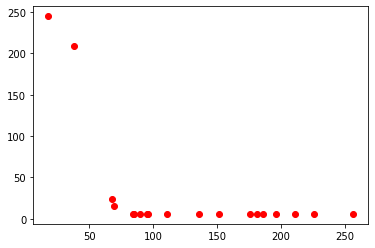

rewaRD::  -84.60055127828919
stepping:  127
Temperature:  [ 18.  38.  68.  69.  84.  85.  90.  95.  96. 111. 136. 151. 176. 181.
 186. 196. 211. 226. 256. 271.]
ORDER PARAM RESULT (X2): 84.95416074765421
THE JT RESULT {X0}: 1.9998713101617993
THE NF RESULT {X1}: 183.95912535420976
THE BK RESULT {X3}: 4.687953599699514
chisqds:  24.34438695764377


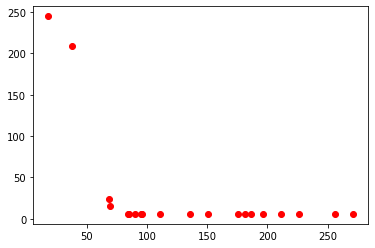

rewaRD::  -83.56910770864961
stepping:  127
Temperature:  [ 18.  38.  68.  69.  84.  85.  90.  95.  96. 111. 136. 151. 176. 181.
 186. 196. 211. 226. 256. 271. 301.]
ORDER PARAM RESULT (X2): 84.95353056872811
THE JT RESULT {X0}: 1.9998290705802992
THE NF RESULT {X1}: 184.07327715620215
THE BK RESULT {X3}: 4.762228831593277
chisqds:  22.98041088999029


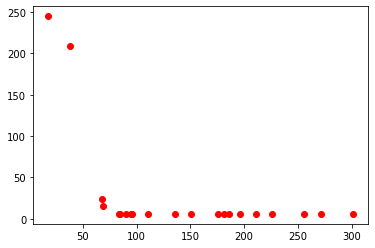

rewaRD::  -82.59387084439686
stepping:  127
Temperature:  [ 18.  38.  68.  69.  84.  85.  90.  95.  96. 111. 136. 151. 176. 181.
 186. 196. 211. 226. 256. 271. 301. 311.]
ORDER PARAM RESULT (X2): 84.95281341133614
THE JT RESULT {X0}: 1.9998549024347743
THE NF RESULT {X1}: 184.0644248178059
THE BK RESULT {X3}: 4.828418429793513
chisqds:  21.735597887792686


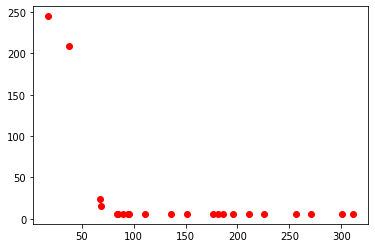

rewaRD::  -81.59700956629074
stepping:  127
Temperature:  [ 18.  38.  68.  69.  84.  85.  90.  95.  96. 111. 136. 151. 176. 181.
 186. 196. 211. 226. 256. 271. 301. 311. 321.]
ORDER PARAM RESULT (X2): 84.95021682961857
THE JT RESULT {X0}: 1.9998155187854008
THE NF RESULT {X1}: 184.03913679403541
THE BK RESULT {X3}: 4.885588529063683
chisqds:  20.61005387806288


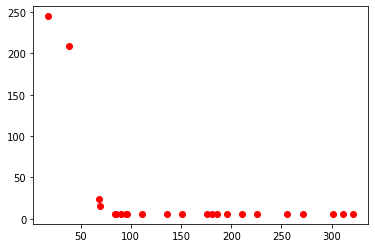

rewaRD::  -80.59199639328669
stepping:  127
Temperature:  [ 18.  38.  68.  69.  84.  85.  90.  95.  96. 111. 136. 151. 176. 181.
 186. 196. 211. 226. 256. 271. 301. 311. 321. 341.]
ORDER PARAM RESULT (X2): 84.9481461222747
THE JT RESULT {X0}: 1.9998678036730833
THE NF RESULT {X1}: 184.0330385495371
THE BK RESULT {X3}: 4.937430546764723
chisqds:  19.59904740242584


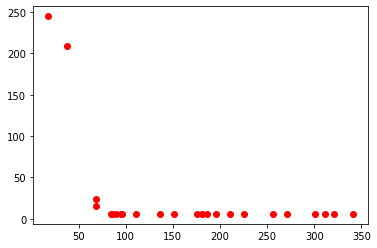

rewaRD::  -79.59084481062632
terminated: over max temp
reset
fixed Tn:  170
fixed Jt:  1.1
fixed Nf:  380
fixed Bk:  3.2
start Tn:  170
start Jt:  0.94
start Nf:  390
start Bk:  3.28
stepping:  128
Temperature:  [13.]
rewaRD::  -100
stepping:  128
Temperature:  [13. 18.]
rewaRD::  -100
stepping:  128
Temperature:  [13. 18. 28.]
rewaRD::  -100
stepping:  128
Temperature:  [13. 18. 28. 29.]
rewaRD::  -100
stepping:  128
Temperature:  [13. 18. 28. 29. 39.]
ORDER PARAM RESULT (X2): 131.60921864886654
THE JT RESULT {X0}: 1.518873800327969
THE NF RESULT {X1}: 386.80189995183747
THE BK RESULT {X3}: 0.1000052804072824
chisqds:  0.1425301737557563


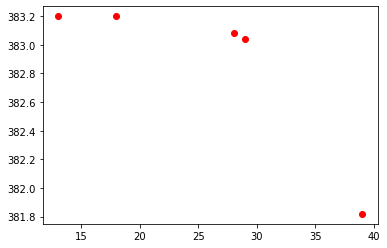

rewaRD::  300
stepping:  128
Temperature:  [13. 18. 28. 29. 39. 44.]
ORDER PARAM RESULT (X2): 169.99999999438717
THE JT RESULT {X0}: 1.0999999999344439
THE NF RESULT {X1}: 379.99999997416927
THE BK RESULT {X3}: 3.200000025830692
chisqds:  1.273696566007699e-25


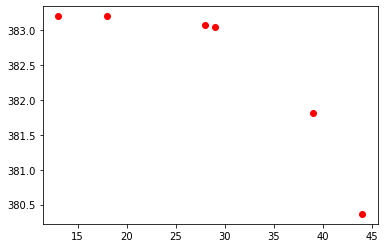

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  120
fixed Jt:  0.8
fixed Nf:  340
fixed Bk:  6.6
start Tn:  112
start Jt:  0.9
start Nf:  356
start Bk:  6.42
stepping:  129
Temperature:  [33.]
rewaRD::  -100
stepping:  129
Temperature:  [33. 43.]
rewaRD::  -100
stepping:  129
Temperature:  [33. 43. 73.]
rewaRD::  -100
stepping:  129
Temperature:  [33. 43. 73. 78.]
rewaRD::  -100
stepping:  129
Temperature:  [ 33.  43.  73.  78. 103.]
ORDER PARAM RESULT (X2): 112.55935085602434
THE JT RESULT {X0}: 0.8419055749238118
THE NF RESULT {X1}: 356.46467545422587
THE BK RESULT {X3}: 7.999269961699483
chisqds:  14.833081350072572


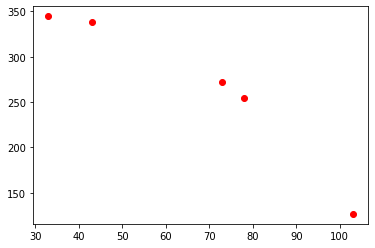

rewaRD::  -73.03324976384337
stepping:  129
Temperature:  [ 33.  43.  73.  78. 103. 118.]
ORDER PARAM RESULT (X2): 112.58090934599494
THE JT RESULT {X0}: 0.839420110655583
THE NF RESULT {X1}: 356.4966618539559
THE BK RESULT {X3}: 7.999939434267219
chisqds:  11.880576595505058


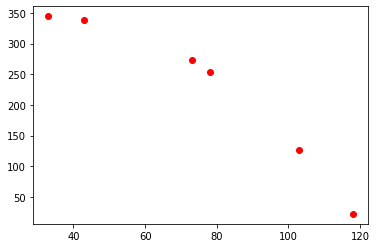

rewaRD::  -66.33160042490383
stepping:  129
Temperature:  [ 33.  43.  73.  78. 103. 118. 148.]
ORDER PARAM RESULT (X2): 113.99011544543961
THE JT RESULT {X0}: 0.7373924771227378
THE NF RESULT {X1}: 355.3077194552716
THE BK RESULT {X3}: 7.99970052239416
chisqds:  5.809487220727989


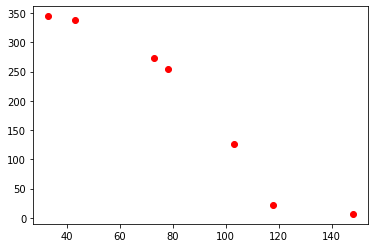

rewaRD::  -31.147107343171697
stepping:  129
Temperature:  [ 33.  43.  73.  78. 103. 118. 148. 168.]
ORDER PARAM RESULT (X2): 115.51872857565685
THE JT RESULT {X0}: 0.6490963498241488
THE NF RESULT {X1}: 351.96722589999183
THE BK RESULT {X3}: 7.999905107996247
chisqds:  3.3446890578301316


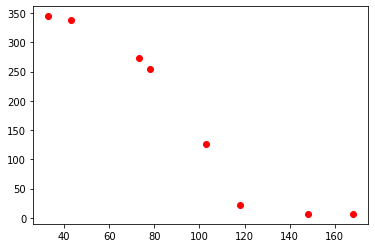

rewaRD::  19.59258187650488
stepping:  129
Temperature:  [ 33.  43.  73.  78. 103. 118. 148. 168. 193.]
ORDER PARAM RESULT (X2): 119.99999999999966
THE JT RESULT {X0}: 0.8000000000000852
THE NF RESULT {X1}: 340.00000000000057
THE BK RESULT {X3}: 6.6
chisqds:  1.0724331546618266e-25


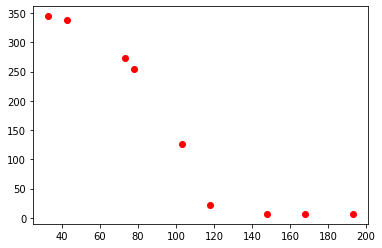

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  260
fixed Jt:  0.7
fixed Nf:  470
fixed Bk:  7.0
start Tn:  250
start Jt:  0.94
start Nf:  476
start Bk:  7.08
stepping:  130
Temperature:  [28.]
rewaRD::  -100
stepping:  130
Temperature:  [28. 33.]
rewaRD::  -100
stepping:  130
Temperature:  [28. 33. 38.]
rewaRD::  -100
stepping:  130
Temperature:  [28. 33. 38. 43.]
rewaRD::  -100
stepping:  130
Temperature:  [28. 33. 38. 43. 73.]
ORDER PARAM RESULT (X2): 260.00000030526115
THE JT RESULT {X0}: 0.7000000019831598
THE NF RESULT {X1}: 470.0000013728375
THE BK RESULT {X3}: 6.999998627162257
chisqds:  1.6686675459903525e-25


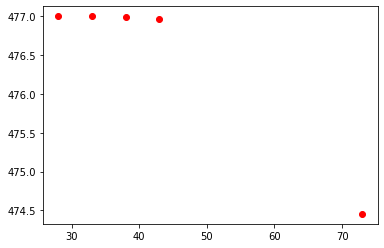

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  220
fixed Jt:  0.8
fixed Nf:  150
fixed Bk:  3.6
start Tn:  208
start Jt:  0.84
start Nf:  156
start Bk:  3.72
stepping:  131
Temperature:  [8.]
rewaRD::  -100
stepping:  131
Temperature:  [ 8. 33.]
rewaRD::  -100
stepping:  131
Temperature:  [ 8. 33. 38.]
rewaRD::  -100
stepping:  131
Temperature:  [ 8. 33. 38. 58.]
rewaRD::  -100
stepping:  131
Temperature:  [ 8. 33. 38. 58. 59.]
ORDER PARAM RESULT (X2): 220.00000001734082
THE JT RESULT {X0}: 0.8000000001403795
THE NF RESULT {X1}: 150.00000002739316
THE BK RESULT {X3}: 3.5999999726068914
chisqds:  2.2982174661166657e-27


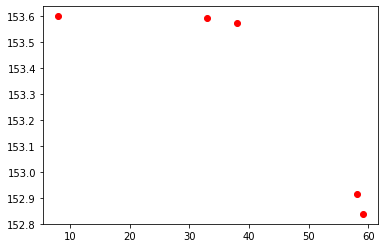

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  70
fixed Jt:  1.3
fixed Nf:  250
fixed Bk:  4.6
start Tn:  58
start Jt:  1.42
start Nf:  230
start Bk:  4.55
stepping:  132
Temperature:  [23.]
rewaRD::  -100
stepping:  132
Temperature:  [23. 28.]
rewaRD::  -100
stepping:  132
Temperature:  [23. 28. 48.]
rewaRD::  -100
stepping:  132
Temperature:  [23. 28. 48. 53.]
rewaRD::  -100
stepping:  132
Temperature:  [23. 28. 48. 53. 54.]
ORDER PARAM RESULT (X2): 58.56510202325993
THE JT RESULT {X0}: 1.1292201103902595
THE NF RESULT {X1}: 233.8063443978978
THE BK RESULT {X3}: 7.999468386858719
chisqds:  105.78214036468329


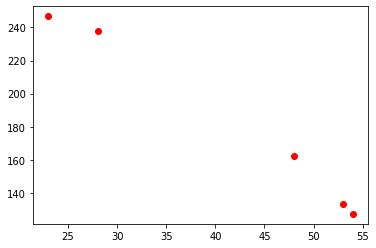

rewaRD::  -96.21864334923643
stepping:  132
Temperature:  [23. 28. 48. 53. 54. 55.]
ORDER PARAM RESULT (X2): 58.50673606653422
THE JT RESULT {X0}: 1.1243139237295563
THE NF RESULT {X1}: 234.1473449226666
THE BK RESULT {X3}: 7.999321741064288
chisqds:  78.35924324656791


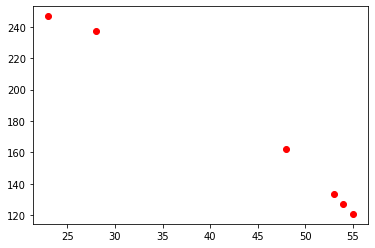

rewaRD::  -94.89530547479451
stepping:  132
Temperature:  [23. 28. 48. 53. 54. 55. 56.]
ORDER PARAM RESULT (X2): 58.47489571633428
THE JT RESULT {X0}: 1.1135368837133859
THE NF RESULT {X1}: 234.27987323720973
THE BK RESULT {X3}: 7.999789888627892
chisqds:  71.61512573058015


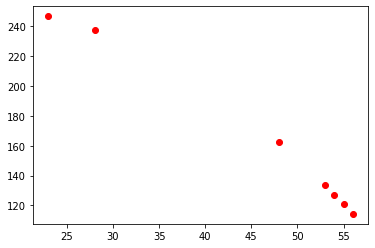

rewaRD::  -94.4145877575525
stepping:  132
Temperature:  [23. 28. 48. 53. 54. 55. 56. 61.]
ORDER PARAM RESULT (X2): 58.47020019757821
THE JT RESULT {X0}: 1.115711586586245
THE NF RESULT {X1}: 234.1907299907436
THE BK RESULT {X3}: 7.99944645080561
chisqds:  69.75316022763518


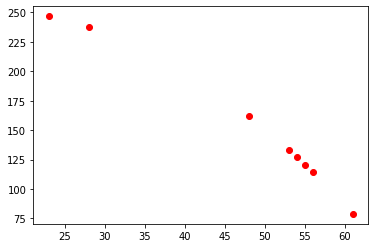

rewaRD::  -94.26549279352183
stepping:  132
Temperature:  [23. 28. 48. 53. 54. 55. 56. 61. 76.]
ORDER PARAM RESULT (X2): 59.85048072475544
THE JT RESULT {X0}: 0.40000001252698947
THE NF RESULT {X1}: 245.47472367849036
THE BK RESULT {X3}: 7.32181356423714
chisqds:  33.77281064708278


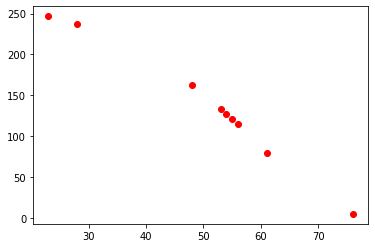

rewaRD::  -88.15615306111482
stepping:  132
Temperature:  [23. 28. 48. 53. 54. 55. 56. 61. 76. 81.]
ORDER PARAM RESULT (X2): 69.99999999999272
THE JT RESULT {X0}: 1.3000000000000163
THE NF RESULT {X1}: 249.99999999999886
THE BK RESULT {X3}: 4.6
chisqds:  1.326315036350034e-23


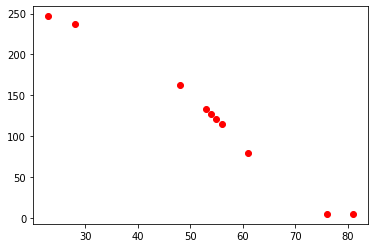

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  90
fixed Jt:  0.9
fixed Nf:  380
fixed Bk:  7.6
start Tn:  86
start Jt:  0.74
start Nf:  396
start Bk:  7.66
stepping:  133
Temperature:  [28.]
rewaRD::  -100
stepping:  133
Temperature:  [28. 53.]
rewaRD::  -100
stepping:  133
Temperature:  [28. 53. 83.]
rewaRD::  -100
stepping:  133
Temperature:  [28. 53. 83. 93.]
rewaRD::  -100
stepping:  133
Temperature:  [ 28.  53.  83.  93. 118.]
ORDER PARAM RESULT (X2): 89.99999999999999
THE JT RESULT {X0}: 0.9000000000000058
THE NF RESULT {X1}: 379.9999999999999
THE BK RESULT {X3}: 7.6
chisqds:  2.4602049088309595e-28


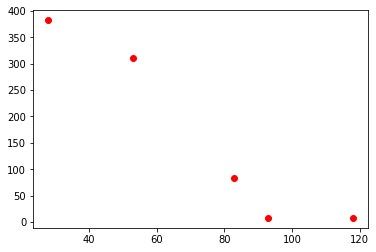

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  260
fixed Jt:  0.7
fixed Nf:  260
fixed Bk:  6.8
start Tn:  258
start Jt:  0.64
start Nf:  276
start Bk:  6.78
stepping:  134
Temperature:  [28.]
rewaRD::  -100
stepping:  134
Temperature:  [28. 53.]
rewaRD::  -100
stepping:  134
Temperature:  [28. 53. 83.]
rewaRD::  -100
stepping:  134
Temperature:  [28. 53. 83. 93.]
rewaRD::  -100
stepping:  134
Temperature:  [28. 53. 83. 93. 94.]
ORDER PARAM RESULT (X2): 260.00000000063665
THE JT RESULT {X0}: 0.7000000000044291
THE NF RESULT {X1}: 260.00000000165386
THE BK RESULT {X3}: 6.79999999834626
chisqds:  1.0838616329244485e-25


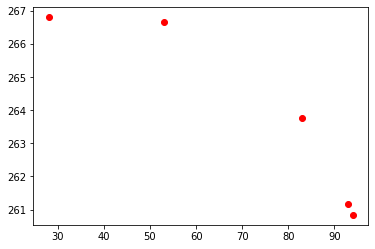

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  100
fixed Jt:  0.9
fixed Nf:  200
fixed Bk:  7.4
start Tn:  98
start Jt:  1.12
start Nf:  180
start Bk:  7.34
stepping:  135
Temperature:  [33.]
rewaRD::  -100
stepping:  135
Temperature:  [33. 34.]
rewaRD::  -100
stepping:  135
Temperature:  [33. 34. 59.]
rewaRD::  -100
stepping:  135
Temperature:  [33. 34. 59. 60.]
rewaRD::  -100
stepping:  135
Temperature:  [33. 34. 59. 60. 70.]
ORDER PARAM RESULT (X2): 98.39811254176644
THE JT RESULT {X0}: 1.0730399453405457
THE NF RESULT {X1}: 180.81211952654164
THE BK RESULT {X3}: 7.9993612222398625
chisqds:  10.731095576076154


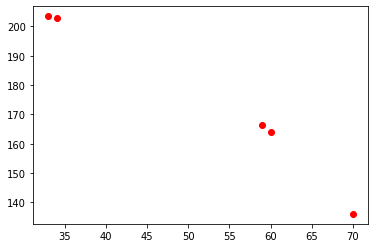

rewaRD::  -62.72514794372368
stepping:  135
Temperature:  [33. 34. 59. 60. 70. 85.]
ORDER PARAM RESULT (X2): 98.25437187046676
THE JT RESULT {X0}: 1.063750926990161
THE NF RESULT {X1}: 181.00935392976416
THE BK RESULT {X3}: 7.99962785555164
chisqds:  6.528307617340714


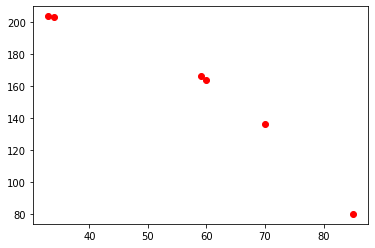

rewaRD::  -38.72837748369788
stepping:  135
Temperature:  [ 33.  34.  59.  60.  70.  85. 100.]
ORDER PARAM RESULT (X2): 100.00129043036152
THE JT RESULT {X0}: 0.90001688336084
THE NF RESULT {X1}: 200.007008726813
THE BK RESULT {X3}: 7.392973215594164
chisqds:  6.368780106548777e-15


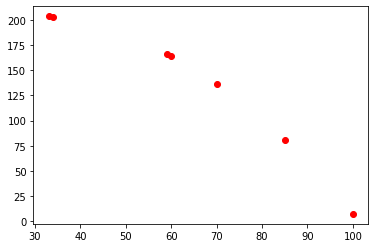

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  100
fixed Jt:  1.4
fixed Nf:  410
fixed Bk:  5.6
start Tn:  86
start Jt:  1.34
start Nf:  390
start Bk:  5.66
stepping:  136
Temperature:  [8.]
rewaRD::  -100
stepping:  136
Temperature:  [ 8. 33.]
rewaRD::  -100
stepping:  136
Temperature:  [ 8. 33. 34.]
rewaRD::  -100
stepping:  136
Temperature:  [ 8. 33. 34. 35.]
rewaRD::  -100
stepping:  136
Temperature:  [ 8. 33. 34. 35. 55.]
ORDER PARAM RESULT (X2): 87.12050478940318
THE JT RESULT {X0}: 1.2226221560071548
THE NF RESULT {X1}: 392.45709048865774
THE BK RESULT {X3}: 7.999546780822326
chisqds:  10.084786653106537


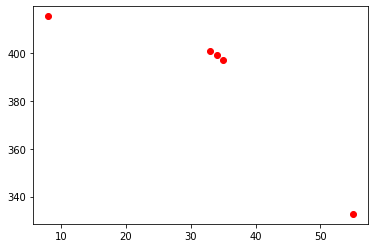

rewaRD::  -60.33629527732416
stepping:  136
Temperature:  [ 8. 33. 34. 35. 55. 75.]
ORDER PARAM RESULT (X2): 86.59424747827583
THE JT RESULT {X0}: 1.2255771409355412
THE NF RESULT {X1}: 392.1138307692024
THE BK RESULT {X3}: 7.999951657194274
chisqds:  23.58924912968336


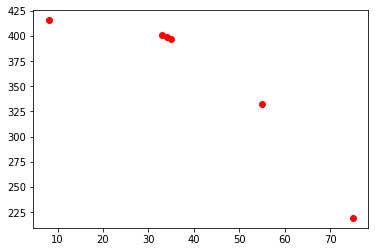

rewaRD::  -83.04312283104159
stepping:  136
Temperature:  [ 8. 33. 34. 35. 55. 75. 95.]
ORDER PARAM RESULT (X2): 86.58341607745672
THE JT RESULT {X0}: 1.2275231938525935
THE NF RESULT {X1}: 392.0828586562987
THE BK RESULT {X3}: 7.999928298062213
chisqds:  29.143547924872962


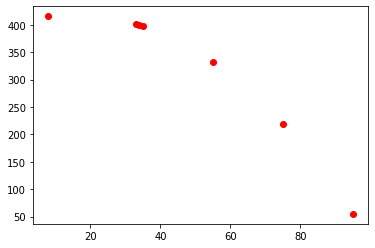

rewaRD::  -86.27483513568318
stepping:  136
Temperature:  [ 8. 33. 34. 35. 55. 75. 95. 96.]
ORDER PARAM RESULT (X2): 86.62451351135007
THE JT RESULT {X0}: 1.2201224483244926
THE NF RESULT {X1}: 392.20278693710804
THE BK RESULT {X3}: 7.999417636464881
chisqds:  29.37445952758335


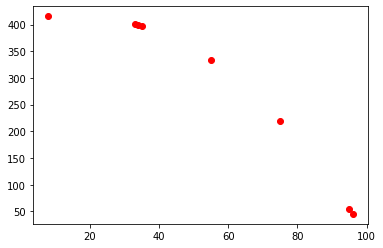

rewaRD::  -86.38272817838946
stepping:  136
Temperature:  [  8.  33.  34.  35.  55.  75.  95.  96. 111.]
ORDER PARAM RESULT (X2): 88.5096672250456
THE JT RESULT {X0}: 0.90657435916766
THE NF RESULT {X1}: 397.66456849429284
THE BK RESULT {X3}: 7.9992675399847615
chisqds:  18.663274744806245


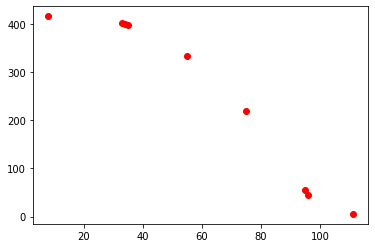

rewaRD::  -78.56753407590944
stepping:  136
Temperature:  [  8.  33.  34.  35.  55.  75.  95.  96. 111. 131.]
ORDER PARAM RESULT (X2): 90.28563454346042
THE JT RESULT {X0}: 0.6487862228459272
THE NF RESULT {X1}: 402.1625598090346
THE BK RESULT {X3}: 7.999393772051742
chisqds:  13.379523523451356


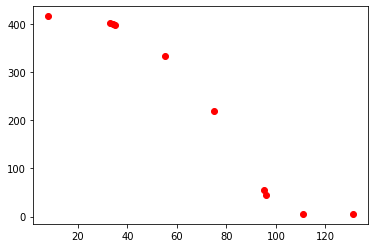

rewaRD::  -70.10356913690624
stepping:  136
Temperature:  [  8.  33.  34.  35.  55.  75.  95.  96. 111. 131. 136.]
ORDER PARAM RESULT (X2): 91.97169693904769
THE JT RESULT {X0}: 0.48127467276667096
THE NF RESULT {X1}: 403.28458438937446
THE BK RESULT {X3}: 7.999313236640785
chisqds:  10.880559715514197


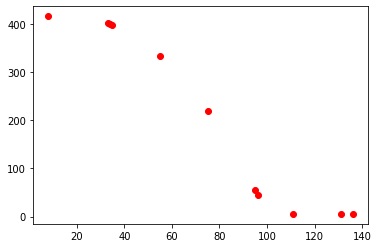

rewaRD::  -63.23718536008268
stepping:  136
Temperature:  [  8.  33.  34.  35.  55.  75.  95.  96. 111. 131. 136. 141.]
ORDER PARAM RESULT (X2): 99.99999999999501
THE JT RESULT {X0}: 1.3999999999999784
THE NF RESULT {X1}: 409.99999999999943
THE BK RESULT {X3}: 5.6
chisqds:  9.771867764467648e-24


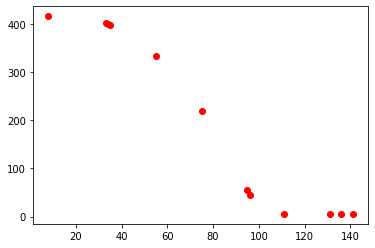

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  210
fixed Jt:  1.2
fixed Nf:  170
fixed Bk:  4.2
start Tn:  192
start Jt:  1.2
start Nf:  188
start Bk:  4.32
stepping:  137
Temperature:  [18.]
rewaRD::  -100
stepping:  137
Temperature:  [18. 43.]
rewaRD::  -100
stepping:  137
Temperature:  [18. 43. 48.]
rewaRD::  -100
stepping:  137
Temperature:  [18. 43. 48. 63.]
rewaRD::  -100
stepping:  137
Temperature:  [18. 43. 48. 63. 64.]
ORDER PARAM RESULT (X2): 170.87403884260368
THE JT RESULT {X0}: 1.748456081758137
THE NF RESULT {X1}: 183.72727015801607
THE BK RESULT {X3}: 0.1000010934686399
chisqds:  1.0152231605239694


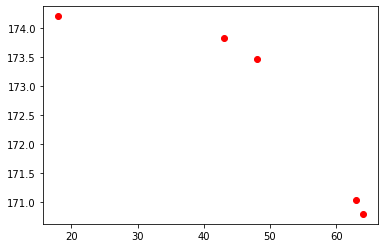

rewaRD::  294.00204364285287
stepping:  137
Temperature:  [18. 43. 48. 63. 64. 69.]
ORDER PARAM RESULT (X2): 173.76837034015793
THE JT RESULT {X0}: 1.676340761538007
THE NF RESULT {X1}: 183.69535736344898
THE BK RESULT {X3}: 0.1000111726662889
chisqds:  0.553002411150753


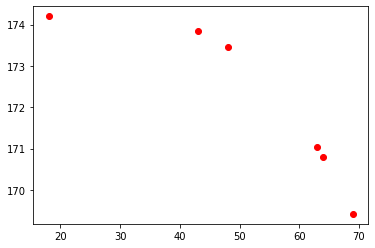

rewaRD::  300
stepping:  137
Temperature:  [18. 43. 48. 63. 64. 69. 84.]
ORDER PARAM RESULT (X2): 180.58440033730417
THE JT RESULT {X0}: 1.5697131497111687
THE NF RESULT {X1}: 183.61638701115788
THE BK RESULT {X3}: 0.10000563468828556
chisqds:  0.47754294700590566


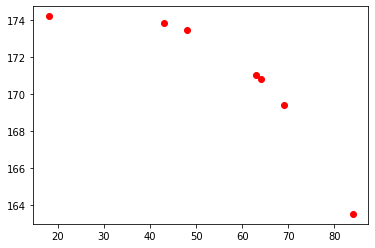

rewaRD::  300
stepping:  137
Temperature:  [18. 43. 48. 63. 64. 69. 84. 89.]
ORDER PARAM RESULT (X2): 210.00000000081934
THE JT RESULT {X0}: 1.2000000000056934
THE NF RESULT {X1}: 170.00000000144442
THE BK RESULT {X3}: 4.1999999985556515
chisqds:  1.6002409090056294e-24


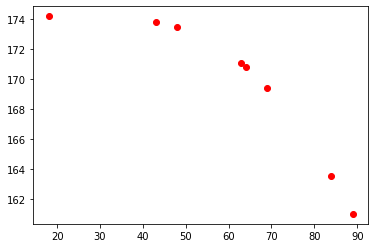

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  180
fixed Jt:  0.8
fixed Nf:  140
fixed Bk:  4.4
start Tn:  192
start Jt:  0.54
start Nf:  156
start Bk:  4.56
stepping:  138
Temperature:  [4.]
rewaRD::  -100
stepping:  138
Temperature:  [ 4. 29.]
rewaRD::  -100
stepping:  138
Temperature:  [ 4. 29. 44.]
rewaRD::  -100
stepping:  138
Temperature:  [ 4. 29. 44. 64.]
rewaRD::  -100
stepping:  138
Temperature:  [ 4. 29. 44. 64. 94.]
ORDER PARAM RESULT (X2): 177.82897846884933
THE JT RESULT {X0}: 0.9444465019644996
THE NF RESULT {X1}: 151.47442246332622
THE BK RESULT {X3}: 0.10000115637203316
chisqds:  1.3568083344576434


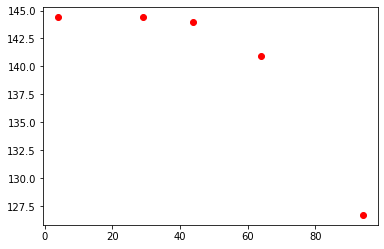

rewaRD::  194.80950981915356
stepping:  138
Temperature:  [  4.  29.  44.  64.  94. 119.]
ORDER PARAM RESULT (X2): 183.39769788227875
THE JT RESULT {X0}: 0.8764989658534599
THE NF RESULT {X1}: 151.3552022270924
THE BK RESULT {X3}: 0.10000471502109545
chisqds:  0.9452918536467529


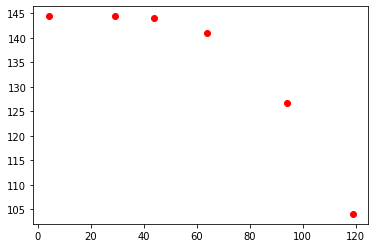

rewaRD::  300
stepping:  138
Temperature:  [  4.  29.  44.  64.  94. 119. 120.]
ORDER PARAM RESULT (X2): 184.0297599330778
THE JT RESULT {X0}: 0.8541332381693415
THE NF RESULT {X1}: 151.2704119868532
THE BK RESULT {X3}: 0.10000154762502045
chisqds:  0.7810248017403866


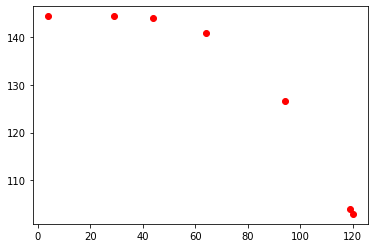

rewaRD::  300
stepping:  138
Temperature:  [  4.  29.  44.  64.  94. 119. 120. 135.]
ORDER PARAM RESULT (X2): 185.38645795273675
THE JT RESULT {X0}: 0.8369692696582127
THE NF RESULT {X1}: 151.1510496417179
THE BK RESULT {X3}: 0.10000331790118712
chisqds:  0.8240007287405877


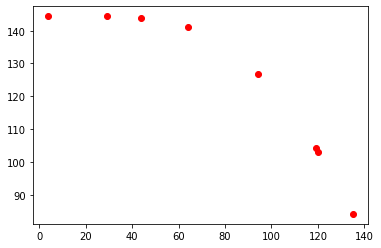

rewaRD::  300
stepping:  138
Temperature:  [  4.  29.  44.  64.  94. 119. 120. 135. 140.]
ORDER PARAM RESULT (X2): 186.12833378310484
THE JT RESULT {X0}: 0.826493868364889
THE NF RESULT {X1}: 151.02418277618048
THE BK RESULT {X3}: 0.10000073995192091
chisqds:  0.8941539495704992


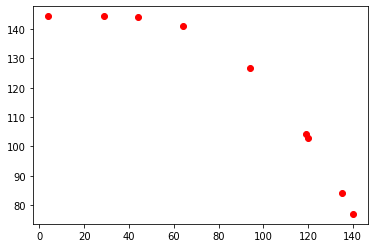

rewaRD::  300
stepping:  138
Temperature:  [  4.  29.  44.  64.  94. 119. 120. 135. 140. 155.]
ORDER PARAM RESULT (X2): 187.21444611405008
THE JT RESULT {X0}: 0.82542911891034
THE NF RESULT {X1}: 150.84924272146696
THE BK RESULT {X3}: 0.10001215449833822
chisqds:  1.1583546288848259


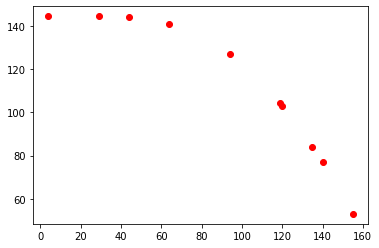

rewaRD::  245.31739246821934
stepping:  138
Temperature:  [  4.  29.  44.  64.  94. 119. 120. 135. 140. 155. 180.]
ORDER PARAM RESULT (X2): 189.5533274021631
THE JT RESULT {X0}: 0.8940322925265316
THE NF RESULT {X1}: 149.97875007135062
THE BK RESULT {X3}: 0.10000078754767992
chisqds:  8.963729561592434


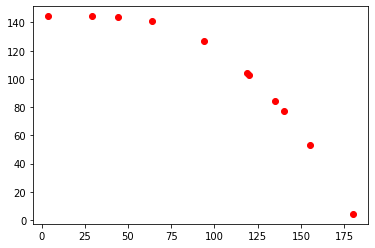

rewaRD::  -55.375717523439114
stepping:  138
Temperature:  [  4.  29.  44.  64.  94. 119. 120. 135. 140. 155. 180. 195.]
ORDER PARAM RESULT (X2): 179.99982568687034
THE JT RESULT {X0}: 0.7999850656451415
THE NF RESULT {X1}: 139.99996461315956
THE BK RESULT {X3}: 4.39999994867924
chisqds:  5.775938119883182e-11


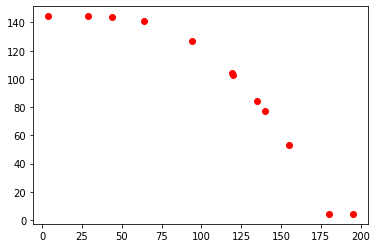

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  190
fixed Jt:  0.7
fixed Nf:  160
fixed Bk:  4.6
start Tn:  194
start Jt:  0.46
start Nf:  140
start Bk:  4.73
stepping:  139
Temperature:  [23.]
rewaRD::  -100
stepping:  139
Temperature:  [23. 33.]
rewaRD::  -100
stepping:  139
Temperature:  [23. 33. 34.]
rewaRD::  -100
stepping:  139
Temperature:  [23. 33. 34. 44.]
rewaRD::  -100
stepping:  139
Temperature:  [23. 33. 34. 44. 49.]
ORDER PARAM RESULT (X2): 198.78500241988053
THE JT RESULT {X0}: 0.4000037080749494
THE NF RESULT {X1}: 140.0328667956657
THE BK RESULT {X3}: 4.76285614871244
chisqds:  11.78270613426827


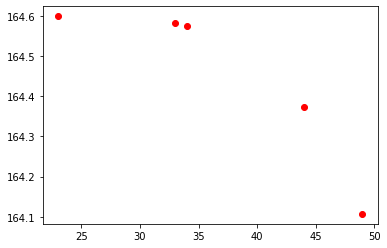

rewaRD::  -66.05194125680019
stepping:  139
Temperature:  [23. 33. 34. 44. 49. 79.]
ORDER PARAM RESULT (X2): 197.0702178744709
THE JT RESULT {X0}: 0.4000000431500993
THE NF RESULT {X1}: 140.38932315934687
THE BK RESULT {X3}: 5.11711577289099
chisqds:  6.2256623710813885


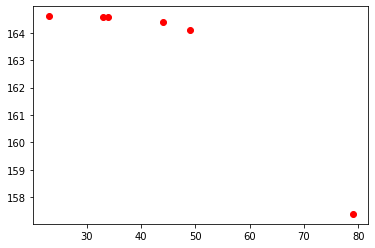

rewaRD::  -35.74980842873421
stepping:  139
Temperature:  [ 23.  33.  34.  44.  49.  79. 109.]
ORDER PARAM RESULT (X2): 190.0000000000139
THE JT RESULT {X0}: 0.700000000000159
THE NF RESULT {X1}: 160.0000000000392
THE BK RESULT {X3}: 4.5999999999609
chisqds:  8.584074259606828e-27


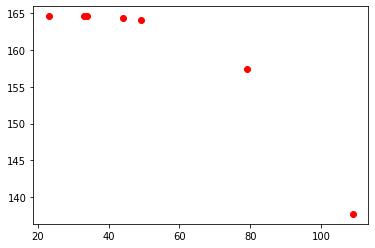

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  160
fixed Jt:  1.0
fixed Nf:  390
fixed Bk:  3.2
start Tn:  148
start Jt:  1.14
start Nf:  386
start Bk:  3.38
stepping:  140
Temperature:  [4.]
rewaRD::  -100
stepping:  140
Temperature:  [ 4. 19.]
rewaRD::  -100
stepping:  140
Temperature:  [ 4. 19. 39.]
rewaRD::  -100
stepping:  140
Temperature:  [ 4. 19. 39. 49.]
rewaRD::  -100
stepping:  140
Temperature:  [ 4. 19. 39. 49. 64.]
ORDER PARAM RESULT (X2): 160.00000000046543
THE JT RESULT {X0}: 1.0000000000047098
THE NF RESULT {X1}: 390.0000000026692
THE BK RESULT {X3}: 3.1999999973307975
chisqds:  4.159458942233369e-25


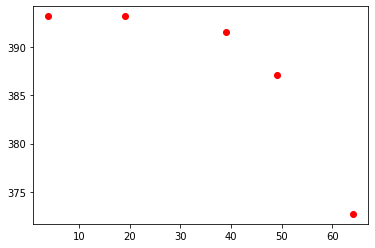

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  170
fixed Jt:  1.2
fixed Nf:  210
fixed Bk:  4.0
start Tn:  158
start Jt:  1.26
start Nf:  208
start Bk:  3.98
stepping:  141
Temperature:  [13.]
rewaRD::  -100
stepping:  141
Temperature:  [13. 14.]
rewaRD::  -100
stepping:  141
Temperature:  [13. 14. 19.]
rewaRD::  -100
stepping:  141
Temperature:  [13. 14. 19. 20.]
rewaRD::  -100
stepping:  141
Temperature:  [13. 14. 19. 20. 35.]
ORDER PARAM RESULT (X2): 170.00000273913585
THE JT RESULT {X0}: 1.2000000353635243
THE NF RESULT {X1}: 210.0000062860581
THE BK RESULT {X3}: 3.9999937139419095
chisqds:  3.4875693870380565e-26


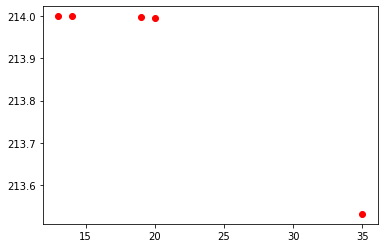

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  70
fixed Jt:  1.1
fixed Nf:  270
fixed Bk:  6.4
start Tn:  50
start Jt:  1.32
start Nf:  256
start Bk:  6.22
stepping:  142
Temperature:  [28.]
rewaRD::  -100
stepping:  142
Temperature:  [28. 48.]
rewaRD::  -100
stepping:  142
Temperature:  [28. 48. 53.]
rewaRD::  -100
stepping:  142
Temperature:  [28. 48. 53. 83.]
rewaRD::  -100
stepping:  142
Temperature:  [28. 48. 53. 83. 98.]
ORDER PARAM RESULT (X2): 52.91346989621597
THE JT RESULT {X0}: 0.40000142375705267
THE NF RESULT {X1}: 274.0472524249905
THE BK RESULT {X3}: 7.536335605780289
chisqds:  191.93904257842703


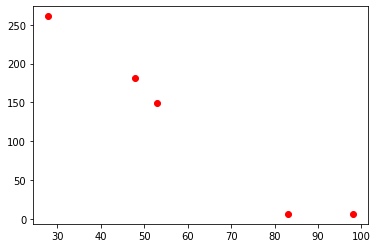

rewaRD::  -97.91600502624911
stepping:  142
Temperature:  [ 28.  48.  53.  83.  98. 108.]
ORDER PARAM RESULT (X2): 52.91119215975246
THE JT RESULT {X0}: 0.4000008151633154
THE NF RESULT {X1}: 274.0648213034462
THE BK RESULT {X3}: 7.1234282412786785
chisqds:  96.53687158536077


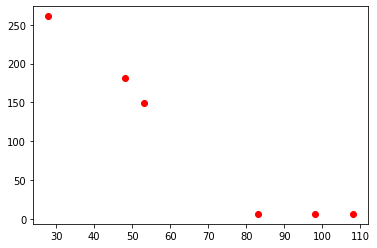

rewaRD::  -95.85650546334197
stepping:  142
Temperature:  [ 28.  48.  53.  83.  98. 108. 138.]
ORDER PARAM RESULT (X2): 69.999999999998
THE JT RESULT {X0}: 1.1000000000000187
THE NF RESULT {X1}: 269.9999999999998
THE BK RESULT {X3}: 6.4
chisqds:  4.116420468395136e-25


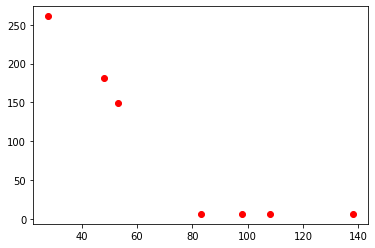

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  170
fixed Jt:  1.3
fixed Nf:  300
fixed Bk:  5.8
start Tn:  158
start Jt:  1.34
start Nf:  302
start Bk:  5.94
stepping:  143
Temperature:  [13.]
rewaRD::  -100
stepping:  143
Temperature:  [13. 23.]
rewaRD::  -100
stepping:  143
Temperature:  [13. 23. 28.]
rewaRD::  -100
stepping:  143
Temperature:  [13. 23. 28. 33.]
rewaRD::  -100
stepping:  143
Temperature:  [13. 23. 28. 33. 48.]
ORDER PARAM RESULT (X2): 169.99999999979363
THE JT RESULT {X0}: 1.2999999999992522
THE NF RESULT {X1}: 299.99999999897335
THE BK RESULT {X3}: 5.80000000102664
chisqds:  1.5968078459224502e-25


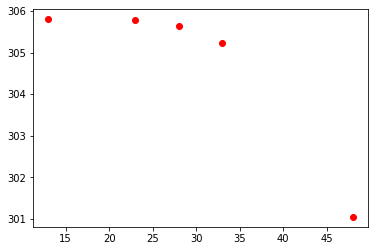

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  160
fixed Jt:  1.4
fixed Nf:  370
fixed Bk:  6.2
start Tn:  152
start Jt:  1.46
start Nf:  374
start Bk:  6.06
stepping:  144
Temperature:  [23.]
rewaRD::  -100
stepping:  144
Temperature:  [23. 48.]
rewaRD::  -100
stepping:  144
Temperature:  [23. 48. 53.]
rewaRD::  -100
stepping:  144
Temperature:  [23. 48. 53. 73.]
rewaRD::  -100
stepping:  144
Temperature:  [23. 48. 53. 73. 78.]
ORDER PARAM RESULT (X2): 159.99999999997667
THE JT RESULT {X0}: 1.399999999999697
THE NF RESULT {X1}: 369.99999999988125
THE BK RESULT {X3}: 6.200000000118837
chisqds:  1.1024746978143146e-27


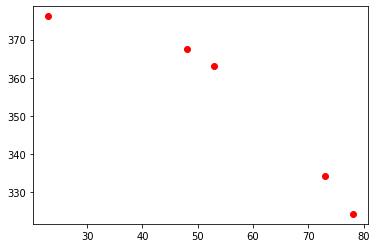

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  100
fixed Jt:  1.3
fixed Nf:  460
fixed Bk:  6.6
start Tn:  118
start Jt:  1.56
start Nf:  444
start Bk:  6.76
stepping:  145
Temperature:  [8.]
rewaRD::  -100
stepping:  145
Temperature:  [ 8. 23.]
rewaRD::  -100
stepping:  145
Temperature:  [ 8. 23. 38.]
rewaRD::  -100
---------------------------------------
| approxkl           | 3.9510072e-05  |
| clipfrac           | 0.0            |
| ep_len_mean        | 7.1            |
| ep_reward_mean     | 25.6           |
| explained_variance | 0.000437       |
| fps                | 4              |
| n_updates          | 9              |
| policy_entropy     | 1.9407855      |
| policy_loss        | -0.00042681006 |
| serial_timesteps   | 1152           |
| time_elapsed       | 159            |
| total_timesteps    | 1152           |
| value_loss         | 91488.78       |
---------------------------------------
stepping:  145
Temperature:  [ 8. 23. 38. 68.]
rewaRD::  -100
st

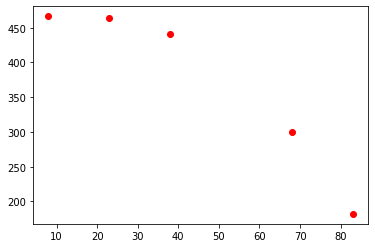

rewaRD::  -75.34763016205052
stepping:  145
Temperature:  [  8.  23.  38.  68.  83. 103.]
ORDER PARAM RESULT (X2): 116.93999368614759
THE JT RESULT {X0}: 1.9046402791954276
THE NF RESULT {X1}: 430.3828587352986
THE BK RESULT {X3}: 0.10000952635514485
chisqds:  836.2924076860245


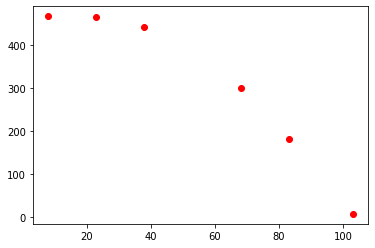

rewaRD::  -100
stepping:  145
Temperature:  [  8.  23.  38.  68.  83. 103. 104.]
ORDER PARAM RESULT (X2): 116.99502015471572
THE JT RESULT {X0}: 1.9213383614649489
THE NF RESULT {X1}: 427.0380489919316
THE BK RESULT {X3}: 0.10000624834893199
chisqds:  1018.1031426471254


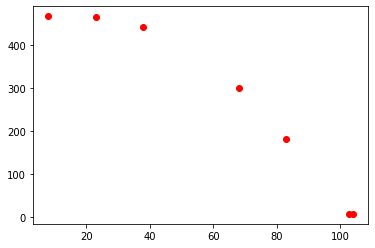

rewaRD::  -100
stepping:  145
Temperature:  [  8.  23.  38.  68.  83. 103. 104. 129.]
ORDER PARAM RESULT (X2): 116.85395469898143
THE JT RESULT {X0}: 1.9998345475543782
THE NF RESULT {X1}: 424.644167043604
THE BK RESULT {X3}: 1.786961732223041
chisqds:  754.7216262954684


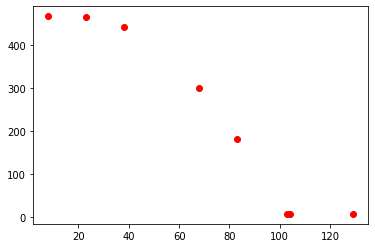

rewaRD::  -100
stepping:  145
Temperature:  [  8.  23.  38.  68.  83. 103. 104. 129. 130.]
ORDER PARAM RESULT (X2): 116.85484448243646
THE JT RESULT {X0}: 1.9999508794594933
THE NF RESULT {X1}: 424.62966788495555
THE BK RESULT {X3}: 3.0393829711108427
chisqds:  619.0574203715271


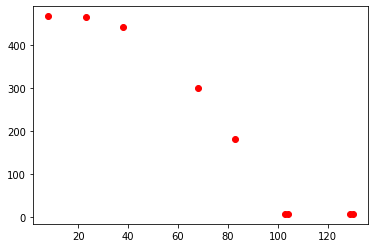

rewaRD::  -100
stepping:  145
Temperature:  [  8.  23.  38.  68.  83. 103. 104. 129. 130. 155.]
ORDER PARAM RESULT (X2): 116.86610613375849
THE JT RESULT {X0}: 1.9998003776232605
THE NF RESULT {X1}: 424.78950454545605
THE BK RESULT {X3}: 3.818513135702483
chisqds:  524.9474840094377


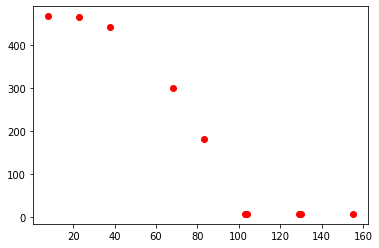

rewaRD::  -100
stepping:  145
Temperature:  [  8.  23.  38.  68.  83. 103. 104. 129. 130. 155. 185.]
ORDER PARAM RESULT (X2): 116.86956610909823
THE JT RESULT {X0}: 1.999839663316629
THE NF RESULT {X1}: 424.8322143961037
THE BK RESULT {X3}: 4.3180278011878475
chisqds:  454.59925985995056


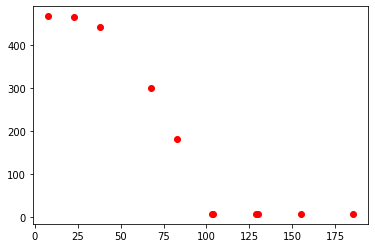

rewaRD::  -100
stepping:  145
Temperature:  [  8.  23.  38.  68.  83. 103. 104. 129. 130. 155. 185. 215.]
ORDER PARAM RESULT (X2): 116.87041728511511
THE JT RESULT {X0}: 1.9998633891683455
THE NF RESULT {X1}: 424.83604741788946
THE BK RESULT {X3}: 4.6693421459786375
chisqds:  400.5079982897308


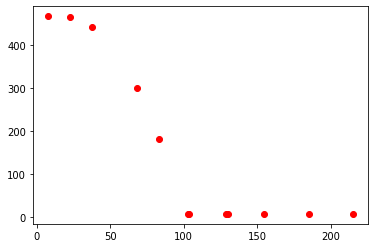

rewaRD::  -100
stepping:  145
Temperature:  [  8.  23.  38.  68.  83. 103. 104. 129. 130. 155. 185. 215. 245.]
ORDER PARAM RESULT (X2): 116.87384777747965
THE JT RESULT {X0}: 1.9998718307517847
THE NF RESULT {X1}: 424.8835859096912
THE BK RESULT {X3}: 4.936778321258193
chisqds:  358.05625392877926


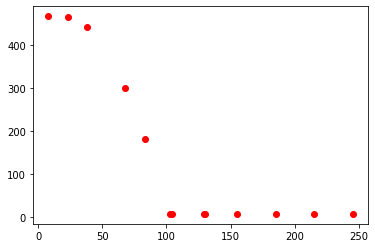

rewaRD::  -100
stepping:  145
Temperature:  [  8.  23.  38.  68.  83. 103. 104. 129. 130. 155. 185. 215. 245. 246.]
ORDER PARAM RESULT (X2): 116.87188936995464
THE JT RESULT {X0}: 1.999880150828792
THE NF RESULT {X1}: 424.84619733950933
THE BK RESULT {X3}: 5.1363568225526395
chisqds:  323.3374051892737


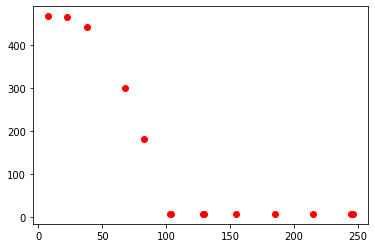

rewaRD::  -100
stepping:  145
Temperature:  [  8.  23.  38.  68.  83. 103. 104. 129. 130. 155. 185. 215. 245. 246.
 251.]
ORDER PARAM RESULT (X2): 116.87793736790454
THE JT RESULT {X0}: 1.999833683830607
THE NF RESULT {X1}: 424.93867551847904
THE BK RESULT {X3}: 5.306685135663666
chisqds:  295.2415437122482


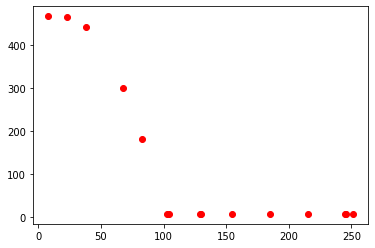

rewaRD::  -98.64517711508157
stepping:  145
Temperature:  [  8.  23.  38.  68.  83. 103. 104. 129. 130. 155. 185. 215. 245. 246.
 251. 252.]
ORDER PARAM RESULT (X2): 116.87808457306262
THE JT RESULT {X0}: 1.9999166463032418
THE NF RESULT {X1}: 424.9371308679931
THE BK RESULT {X3}: 5.438639287805377
chisqds:  271.31054071461773


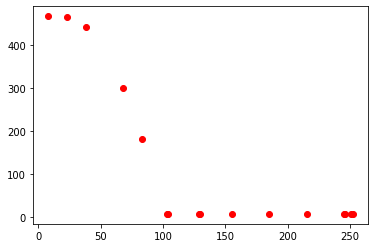

rewaRD::  -98.5256746791097
stepping:  145
Temperature:  [  8.  23.  38.  68.  83. 103. 104. 129. 130. 155. 185. 215. 245. 246.
 251. 252. 272.]
ORDER PARAM RESULT (X2): 116.8792141333286
THE JT RESULT {X0}: 1.9998803572268196
THE NF RESULT {X1}: 424.95202689081066
THE BK RESULT {X3}: 5.549620239507302
chisqds:  251.0180144524346


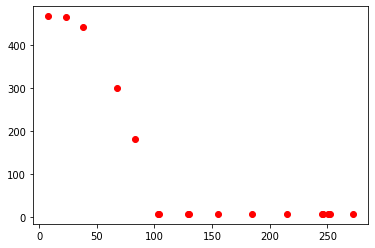

rewaRD::  -98.40648886944409
stepping:  145
Temperature:  [  8.  23.  38.  68.  83. 103. 104. 129. 130. 155. 185. 215. 245. 246.
 251. 252. 272. 302.]
ORDER PARAM RESULT (X2): 116.87777881987466
THE JT RESULT {X0}: 1.9999877687656828
THE NF RESULT {X1}: 424.9261420705774
THE BK RESULT {X3}: 5.640780731957968
chisqds:  233.41304075022381


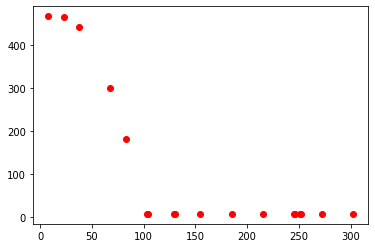

rewaRD::  -98.28629969124972
stepping:  145
Temperature:  [  8.  23.  38.  68.  83. 103. 104. 129. 130. 155. 185. 215. 245. 246.
 251. 252. 272. 302. 332.]
ORDER PARAM RESULT (X2): 116.88070484449447
THE JT RESULT {X0}: 1.9998983991006494
THE NF RESULT {X1}: 424.9708998053371
THE BK RESULT {X3}: 5.7230867031427435
chisqds:  218.31662398313367


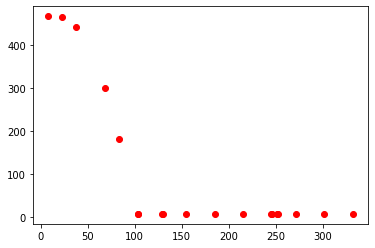

rewaRD::  -98.16779871041382
stepping:  145
Temperature:  [  8.  23.  38.  68.  83. 103. 104. 129. 130. 155. 185. 215. 245. 246.
 251. 252. 272. 302. 332. 337.]
ORDER PARAM RESULT (X2): 116.88158897444696
THE JT RESULT {X0}: 1.9998292770260508
THE NF RESULT {X1}: 424.983057303429
THE BK RESULT {X3}: 5.792545124713253
chisqds:  204.97489483879042


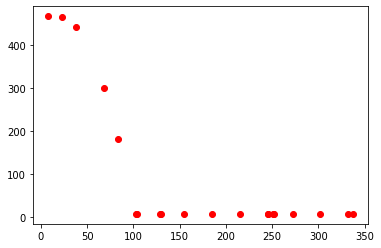

rewaRD::  -98.04854150399933
stepping:  145
Temperature:  [  8.  23.  38.  68.  83. 103. 104. 129. 130. 155. 185. 215. 245. 246.
 251. 252. 272. 302. 332. 337. 342.]
ORDER PARAM RESULT (X2): 116.88260223104145
THE JT RESULT {X0}: 1.9998836994852947
THE NF RESULT {X1}: 424.99755213304786
THE BK RESULT {X3}: 5.853403120876926
chisqds:  193.1722724818863


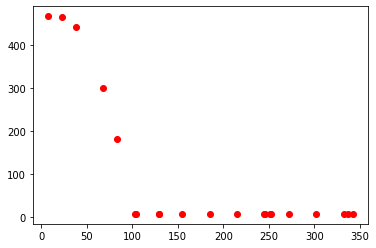

rewaRD::  -97.92930944560116
terminated: over max temp
reset
fixed Tn:  230
fixed Jt:  0.9
fixed Nf:  230
fixed Bk:  3.0
start Tn:  226
start Jt:  0.96
start Nf:  240
start Bk:  3.16
stepping:  146
Temperature:  [28.]
rewaRD::  -100
stepping:  146
Temperature:  [28. 33.]
rewaRD::  -100
stepping:  146
Temperature:  [28. 33. 53.]
rewaRD::  -100
stepping:  146
Temperature:  [28. 33. 53. 54.]
rewaRD::  -100
stepping:  146
Temperature:  [28. 33. 53. 54. 64.]
ORDER PARAM RESULT (X2): 230.0000000293104
THE JT RESULT {X0}: 0.9000000002347027
THE NF RESULT {X1}: 230.00000006586947
THE BK RESULT {X3}: 2.99999993413038
chisqds:  9.796860941328684e-26


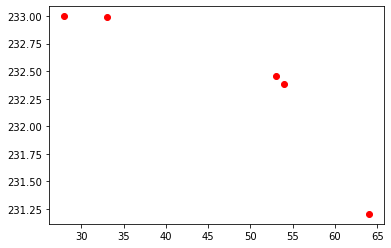

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  100
fixed Jt:  0.9
fixed Nf:  460
fixed Bk:  4.8
start Tn:  112
start Jt:  0.78
start Nf:  458
start Bk:  4.94
stepping:  147
Temperature:  [13.]
rewaRD::  -100
stepping:  147
Temperature:  [13. 18.]
rewaRD::  -100
stepping:  147
Temperature:  [13. 18. 48.]
rewaRD::  -100
stepping:  147
Temperature:  [13. 18. 48. 58.]
rewaRD::  -100
stepping:  147
Temperature:  [13. 18. 48. 58. 73.]
ORDER PARAM RESULT (X2): 99.99999999979202
THE JT RESULT {X0}: 0.8999999999979797
THE NF RESULT {X1}: 459.9999999978572
THE BK RESULT {X3}: 4.8000000021422435
chisqds:  2.3370239729070597e-22


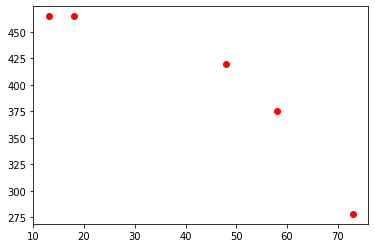

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  100
fixed Jt:  1.1
fixed Nf:  120
fixed Bk:  5.0
start Tn:  100
start Jt:  0.82
start Nf:  128
start Bk:  5.12
stepping:  148
Temperature:  [23.]
rewaRD::  -100
stepping:  148
Temperature:  [23. 24.]
rewaRD::  -100
stepping:  148
Temperature:  [23. 24. 49.]
rewaRD::  -100
stepping:  148
Temperature:  [23. 24. 49. 54.]
rewaRD::  -100
stepping:  148
Temperature:  [23. 24. 49. 54. 59.]
ORDER PARAM RESULT (X2): 100.00000000007414
THE JT RESULT {X0}: 1.1000000000010088
THE NF RESULT {X1}: 120.00000000022168
THE BK RESULT {X3}: 4.99999999977806
chisqds:  7.904285810131864e-26


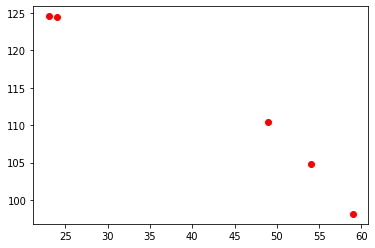

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  130
fixed Jt:  1.1
fixed Nf:  130
fixed Bk:  5.4
start Tn:  122
start Jt:  0.88
start Nf:  122
start Bk:  5.56
stepping:  149
Temperature:  [18.]
rewaRD::  -100
stepping:  149
Temperature:  [18. 43.]
rewaRD::  -100
stepping:  149
Temperature:  [18. 43. 44.]
rewaRD::  -100
stepping:  149
Temperature:  [18. 43. 44. 64.]
rewaRD::  -100
stepping:  149
Temperature:  [18. 43. 44. 64. 84.]
ORDER PARAM RESULT (X2): 124.6111870734276
THE JT RESULT {X0}: 0.6685787330949099
THE NF RESULT {X1}: 124.724457537472
THE BK RESULT {X3}: 7.999399717238048
chisqds:  0.08817440874162748


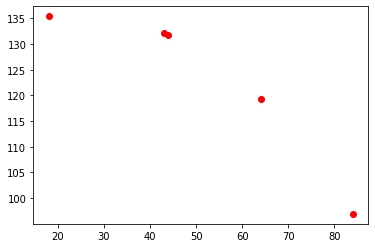

rewaRD::  300
stepping:  149
Temperature:  [ 18.  43.  44.  64.  84. 109.]
ORDER PARAM RESULT (X2): 124.06990636990967
THE JT RESULT {X0}: 0.6177030199271928
THE NF RESULT {X1}: 124.36461483531522
THE BK RESULT {X3}: 7.999358130026612
chisqds:  0.4374741893025887


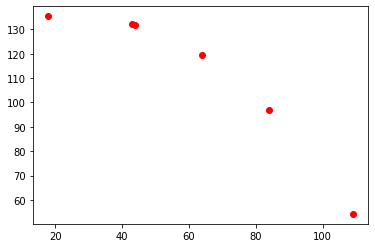

rewaRD::  300
stepping:  149
Temperature:  [ 18.  43.  44.  64.  84. 109. 114.]
ORDER PARAM RESULT (X2): 123.64786704594323
THE JT RESULT {X0}: 0.604000630307471
THE NF RESULT {X1}: 124.20840554123637
THE BK RESULT {X3}: 7.999655549014202
chisqds:  1.0039187242284457


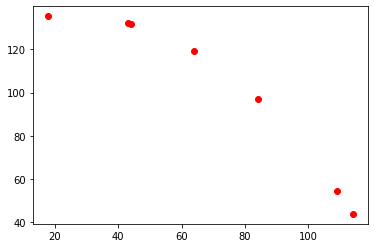

rewaRD::  298.4386288914145
stepping:  149
Temperature:  [ 18.  43.  44.  64.  84. 109. 114. 134.]
ORDER PARAM RESULT (X2): 129.99999999998158
THE JT RESULT {X0}: 1.1000000000013725
THE NF RESULT {X1}: 130.00000000000554
THE BK RESULT {X3}: 5.3999999999999995
chisqds:  2.0581405493173417e-23


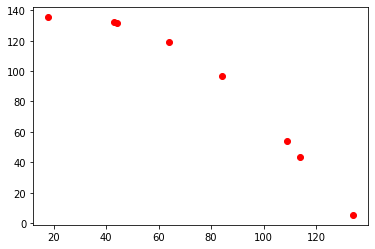

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  150
fixed Jt:  0.8
fixed Nf:  120
fixed Bk:  7.6
start Tn:  130
start Jt:  1.04
start Nf:  134
start Bk:  7.56
stepping:  150
Temperature:  [13.]
rewaRD::  -100
stepping:  150
Temperature:  [13. 14.]
rewaRD::  -100
stepping:  150
Temperature:  [13. 14. 39.]
rewaRD::  -100
stepping:  150
Temperature:  [13. 14. 39. 49.]
rewaRD::  -100
stepping:  150
Temperature:  [13. 14. 39. 49. 69.]
ORDER PARAM RESULT (X2): 149.99999999992667
THE JT RESULT {X0}: 0.7999999999992149
THE NF RESULT {X1}: 119.99999999984998
THE BK RESULT {X3}: 7.600000000150051
chisqds:  8.676487006046192e-28


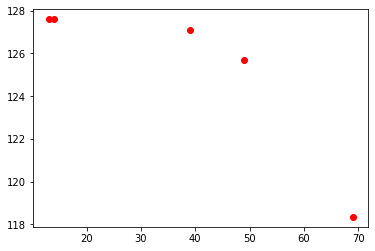

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  130
fixed Jt:  1.0
fixed Nf:  210
fixed Bk:  4.6
start Tn:  136
start Jt:  1.2
start Nf:  218
start Bk:  4.57
stepping:  151
Temperature:  [8.]
rewaRD::  -100
stepping:  151
Temperature:  [ 8. 13.]
rewaRD::  -100
stepping:  151
Temperature:  [ 8. 13. 14.]
rewaRD::  -100
stepping:  151
Temperature:  [ 8. 13. 14. 29.]
rewaRD::  -100
stepping:  151
Temperature:  [ 8. 13. 14. 29. 49.]
ORDER PARAM RESULT (X2): 130.00000001802587
THE JT RESULT {X0}: 1.0000000002635065
THE NF RESULT {X1}: 210.0000000654194
THE BK RESULT {X3}: 4.599999934580559
chisqds:  2.202418256459997e-26


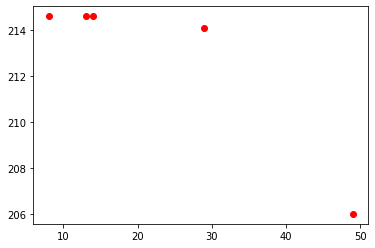

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  140
fixed Jt:  1.2
fixed Nf:  270
fixed Bk:  4.2
start Tn:  144
start Jt:  0.98
start Nf:  274
start Bk:  4.0
stepping:  152
Temperature:  [8.]
rewaRD::  -100
stepping:  152
Temperature:  [ 8. 33.]
rewaRD::  -100
stepping:  152
Temperature:  [ 8. 33. 48.]
rewaRD::  -100
stepping:  152
Temperature:  [ 8. 33. 48. 78.]
rewaRD::  -100
stepping:  152
Temperature:  [ 8. 33. 48. 78. 79.]
ORDER PARAM RESULT (X2): 140.0000000000872
THE JT RESULT {X0}: 1.2000000000007636
THE NF RESULT {X1}: 270.00000000036164
THE BK RESULT {X3}: 4.199999999638366
chisqds:  2.2665657728641032e-24


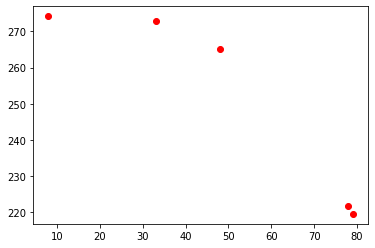

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  200
fixed Jt:  0.7
fixed Nf:  330
fixed Bk:  7.4
start Tn:  194
start Jt:  0.82
start Nf:  336
start Bk:  7.22
stepping:  153
Temperature:  [33.]
rewaRD::  -100
stepping:  153
Temperature:  [33. 63.]
rewaRD::  -100
stepping:  153
Temperature:  [33. 63. 73.]
rewaRD::  -100
stepping:  153
Temperature:  [33. 63. 73. 88.]
rewaRD::  -100
stepping:  153
Temperature:  [ 33.  63.  73.  88. 108.]
ORDER PARAM RESULT (X2): 199.9999999999556
THE JT RESULT {X0}: 0.6999999999996979
THE NF RESULT {X1}: 329.99999999979457
THE BK RESULT {X3}: 7.4000000002056705
chisqds:  3.431997073583049e-27


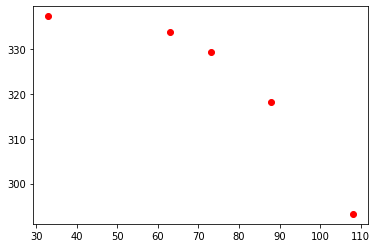

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  60
fixed Jt:  1.2
fixed Nf:  320
fixed Bk:  4.0
start Tn:  62
start Jt:  1.46
start Nf:  302
start Bk:  3.9
stepping:  154
Temperature:  [23.]
rewaRD::  -100
stepping:  154
Temperature:  [23. 33.]
rewaRD::  -100
stepping:  154
Temperature:  [23. 33. 63.]
rewaRD::  -100
stepping:  154
Temperature:  [23. 33. 63. 64.]
rewaRD::  -100
stepping:  154
Temperature:  [23. 33. 63. 64. 89.]
ORDER PARAM RESULT (X2): 62.99880654054985
THE JT RESULT {X0}: 1.7915985869541313
THE NF RESULT {X1}: 325.0441751897998
THE BK RESULT {X3}: 4.0
chisqds:  3.545860745878954e-27


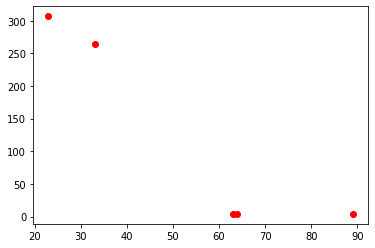

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  260
fixed Jt:  1.0
fixed Nf:  250
fixed Bk:  6.6
start Tn:  254
start Jt:  0.94
start Nf:  230
start Bk:  6.42
stepping:  155
Temperature:  [13.]
rewaRD::  -100
stepping:  155
Temperature:  [13. 43.]
rewaRD::  -100
stepping:  155
Temperature:  [13. 43. 63.]
rewaRD::  -100
stepping:  155
Temperature:  [13. 43. 63. 88.]
rewaRD::  -100
stepping:  155
Temperature:  [13. 43. 63. 88. 89.]
ORDER PARAM RESULT (X2): 260.00000000031866
THE JT RESULT {X0}: 1.0000000000024427
THE NF RESULT {X1}: 250.00000000065873
THE BK RESULT {X3}: 6.599999999341265
chisqds:  5.741577848237754e-28


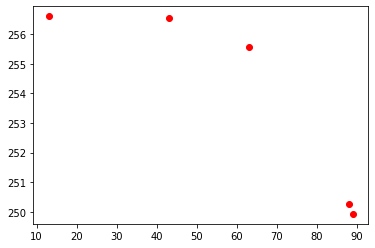

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  80
fixed Jt:  0.8
fixed Nf:  400
fixed Bk:  6.2
start Tn:  94
start Jt:  0.5
start Nf:  398
start Bk:  6.16
stepping:  156
Temperature:  [13.]
rewaRD::  -100
stepping:  156
Temperature:  [13. 14.]
rewaRD::  -100
stepping:  156
Temperature:  [13. 14. 29.]
rewaRD::  -100
stepping:  156
Temperature:  [13. 14. 29. 49.]
rewaRD::  -100
stepping:  156
Temperature:  [13. 14. 29. 49. 64.]
ORDER PARAM RESULT (X2): 90.11863962466634
THE JT RESULT {X0}: 0.8333625394539472
THE NF RESULT {X1}: 392.8781222875998
THE BK RESULT {X3}: 0.10000572481621853
chisqds:  16.079164349517235


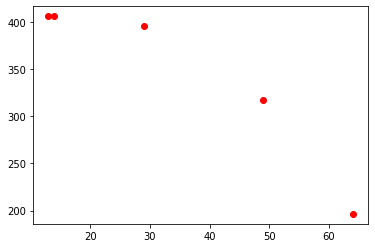

rewaRD::  -75.123085298148
stepping:  156
Temperature:  [13. 14. 29. 49. 64. 69.]
ORDER PARAM RESULT (X2): 91.85867549416746
THE JT RESULT {X0}: 0.7178333191567754
THE NF RESULT {X1}: 392.2101362593247
THE BK RESULT {X3}: 0.10000463056168064
chisqds:  35.71061556374708


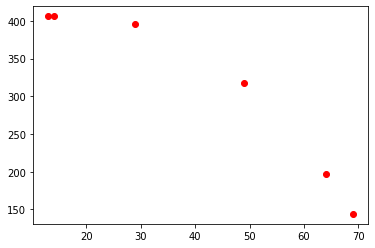

rewaRD::  -88.7988489225015
stepping:  156
Temperature:  [13. 14. 29. 49. 64. 69. 74.]
ORDER PARAM RESULT (X2): 92.53616306579667
THE JT RESULT {X0}: 0.6798553235072571
THE NF RESULT {X1}: 391.5515539336437
THE BK RESULT {X3}: 0.10001134113948211
chisqds:  70.73346122883036


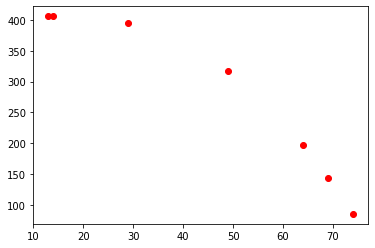

rewaRD::  -94.34496781225003
stepping:  156
Temperature:  [13. 14. 29. 49. 64. 69. 74. 94.]
ORDER PARAM RESULT (X2): 93.49175239317007
THE JT RESULT {X0}: 1.9999873697860093
THE NF RESULT {X1}: 355.2912468911325
THE BK RESULT {X3}: 1.8302201345804603
chisqds:  22.14066324757721


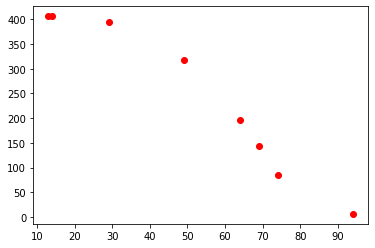

rewaRD::  -81.93369387686383
stepping:  156
Temperature:  [13. 14. 29. 49. 64. 69. 74. 94. 95.]
ORDER PARAM RESULT (X2): 93.42929533755158
THE JT RESULT {X0}: 1.9998367960898773
THE NF RESULT {X1}: 355.31595949252494
THE BK RESULT {X3}: 3.9205403375947725
chisqds:  17.85055658537381


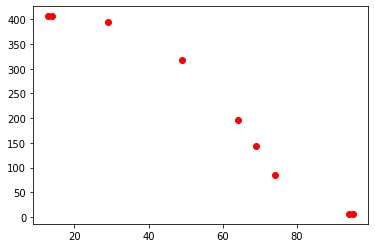

rewaRD::  -77.5917351323517
stepping:  156
Temperature:  [ 13.  14.  29.  49.  64.  69.  74.  94.  95. 110.]
ORDER PARAM RESULT (X2): 93.42867978870888
THE JT RESULT {X0}: 1.9998221615692195
THE NF RESULT {X1}: 354.6362462119583
THE BK RESULT {X3}: 4.644711714452438
chisqds:  14.938233262961974


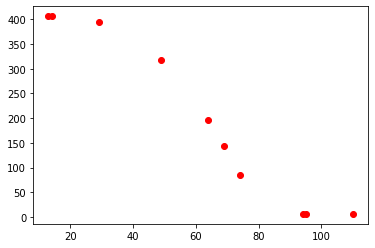

rewaRD::  -73.22307176767922
stepping:  156
Temperature:  [ 13.  14.  29.  49.  64.  69.  74.  94.  95. 110. 130.]
ORDER PARAM RESULT (X2): 93.42840997604597
THE JT RESULT {X0}: 1.9998167442281054
THE NF RESULT {X1}: 354.28701551590905
THE BK RESULT {X3}: 5.0187309275118
chisqds:  12.83124894132708


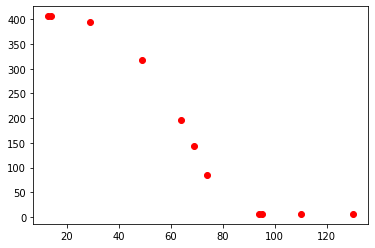

rewaRD::  -68.82610556236081
stepping:  156
Temperature:  [ 13.  14.  29.  49.  64.  69.  74.  94.  95. 110. 130. 150.]
ORDER PARAM RESULT (X2): 93.42820014449408
THE JT RESULT {X0}: 1.9998132303158314
THE NF RESULT {X1}: 354.0735687623231
THE BK RESULT {X3}: 5.24719340890213
chisqds:  11.24147989293497


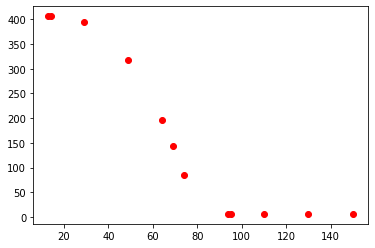

rewaRD::  -64.41749628966633
stepping:  156
Temperature:  [ 13.  14.  29.  49.  64.  69.  74.  94.  95. 110. 130. 150. 160.]
ORDER PARAM RESULT (X2): 93.42793536349075
THE JT RESULT {X0}: 1.9998658136707002
THE NF RESULT {X1}: 353.92618798565144
THE BK RESULT {X3}: 5.40123106007435
chisqds:  10.000412255846918


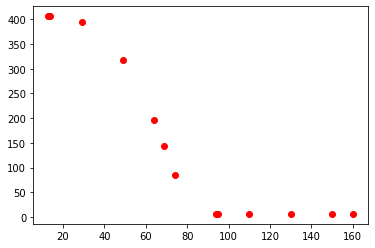

rewaRD::  -60.00164895540852
stepping:  156
Temperature:  [ 13.  14.  29.  49.  64.  69.  74.  94.  95. 110. 130. 150. 160. 185.]
ORDER PARAM RESULT (X2): 93.42794046342443
THE JT RESULT {X0}: 1.9998897886492533
THE NF RESULT {X1}: 353.852711969038
THE BK RESULT {X3}: 5.512699002495888
chisqds:  9.006366279834518


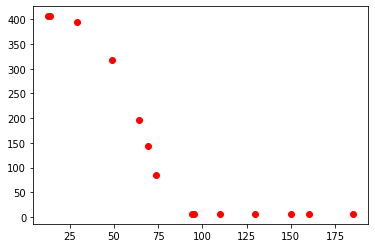

rewaRD::  -55.58697175179183
stepping:  156
Temperature:  [ 13.  14.  29.  49.  64.  69.  74.  94.  95. 110. 130. 150. 160. 185.
 190.]
ORDER PARAM RESULT (X2): 93.42759847759359
THE JT RESULT {X0}: 1.9998779328233998
THE NF RESULT {X1}: 353.7676685876338
THE BK RESULT {X3}: 5.596283327586547
chisqds:  8.190919259711839


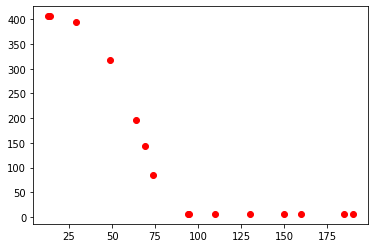

rewaRD::  -51.1654324359593
stepping:  156
Temperature:  [ 13.  14.  29.  49.  64.  69.  74.  94.  95. 110. 130. 150. 160. 185.
 190. 210.]
ORDER PARAM RESULT (X2): 93.42771600740173
THE JT RESULT {X0}: 1.9998970853706035
THE NF RESULT {X1}: 353.71098588337543
THE BK RESULT {X3}: 5.66149677709438
chisqds:  7.511146268576595


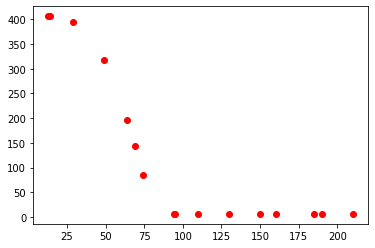

rewaRD::  -46.74581139853075
stepping:  156
Temperature:  [ 13.  14.  29.  49.  64.  69.  74.  94.  95. 110. 130. 150. 160. 185.
 190. 210. 220.]
ORDER PARAM RESULT (X2): 93.42764417852939
THE JT RESULT {X0}: 1.9999567747582956
THE NF RESULT {X1}: 353.6612743769611
THE BK RESULT {X3}: 5.7138800754643
chisqds:  6.93514011327109


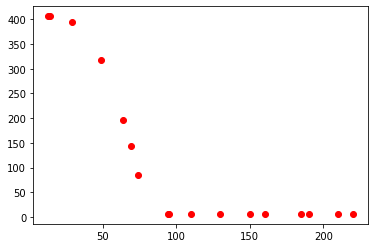

rewaRD::  -42.32272261744796
stepping:  156
Temperature:  [ 13.  14.  29.  49.  64.  69.  74.  94.  95. 110. 130. 150. 160. 185.
 190. 210. 220. 250.]
ORDER PARAM RESULT (X2): 93.42748464824598
THE JT RESULT {X0}: 1.9998742418745032
THE NF RESULT {X1}: 353.61791586595194
THE BK RESULT {X3}: 5.756871308597999
chisqds:  6.441263400032999


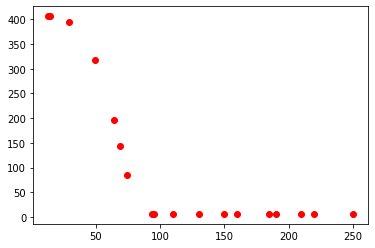

rewaRD::  -37.90038146895983
stepping:  156
Temperature:  [ 13.  14.  29.  49.  64.  69.  74.  94.  95. 110. 130. 150. 160. 185.
 190. 210. 220. 250. 280.]
ORDER PARAM RESULT (X2): 93.42754934124295
THE JT RESULT {X0}: 1.9999698744189238
THE NF RESULT {X1}: 353.586773456866
THE BK RESULT {X3}: 5.792751390528853
chisqds:  6.012914593207426


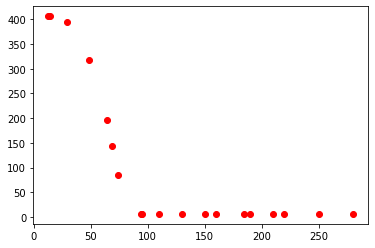

rewaRD::  -33.47652061250534
stepping:  156
Temperature:  [ 13.  14.  29.  49.  64.  69.  74.  94.  95. 110. 130. 150. 160. 185.
 190. 210. 220. 250. 280. 300.]
ORDER PARAM RESULT (X2): 93.42694057054246
THE JT RESULT {X0}: 1.999880021099017
THE NF RESULT {X1}: 353.5433503690943
THE BK RESULT {X3}: 5.823241899686927
chisqds:  5.637585163482971


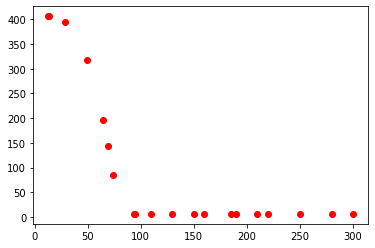

rewaRD::  -29.0476350422217
stepping:  156
Temperature:  [ 13.  14.  29.  49.  64.  69.  74.  94.  95. 110. 130. 150. 160. 185.
 190. 210. 220. 250. 280. 300. 330.]
ORDER PARAM RESULT (X2): 93.42744914808281
THE JT RESULT {X0}: 1.9999783059605356
THE NF RESULT {X1}: 353.5325683336704
THE BK RESULT {X3}: 5.849314993319706
chisqds:  5.30703448500595


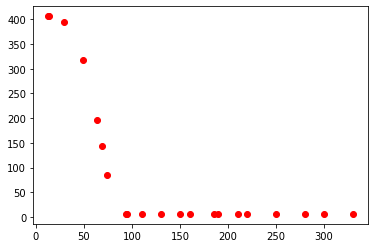

rewaRD::  -24.62833977617322
stepping:  156
Temperature:  [ 13.  14.  29.  49.  64.  69.  74.  94.  95. 110. 130. 150. 160. 185.
 190. 210. 220. 250. 280. 300. 330. 355.]
ORDER PARAM RESULT (X2): 93.42751132092741
THE JT RESULT {X0}: 1.9998579694091387
THE NF RESULT {X1}: 353.513451867186
THE BK RESULT {X3}: 5.871976578918887
chisqds:  5.01305387813438


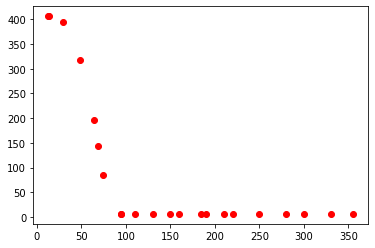

rewaRD::  -20.208318178127982
terminated: over max temp
reset
fixed Tn:  210
fixed Jt:  0.9
fixed Nf:  270
fixed Bk:  3.4
start Tn:  202
start Jt:  0.98
start Nf:  274
start Bk:  3.2
stepping:  157
Temperature:  [8.]
rewaRD::  -100
stepping:  157
Temperature:  [8. 9.]
rewaRD::  -100
stepping:  157
Temperature:  [ 8.  9. 39.]
rewaRD::  -100
stepping:  157
Temperature:  [ 8.  9. 39. 40.]
rewaRD::  -100
stepping:  157
Temperature:  [ 8.  9. 39. 40. 70.]
ORDER PARAM RESULT (X2): 209.9999999681225
THE JT RESULT {X0}: 0.8999999997190091
THE NF RESULT {X1}: 269.9999999071564
THE BK RESULT {X3}: 3.4000000928434715
chisqds:  4.862308954414654e-26


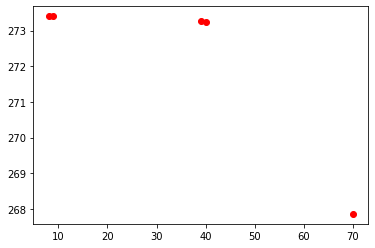

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  110
fixed Jt:  1.2
fixed Nf:  290
fixed Bk:  3.2
start Tn:  94
start Jt:  1.32
start Nf:  306
start Bk:  3.38
stepping:  158
Temperature:  [13.]
rewaRD::  -100
stepping:  158
Temperature:  [13. 18.]
rewaRD::  -100
stepping:  158
Temperature:  [13. 18. 28.]
rewaRD::  -100
stepping:  158
Temperature:  [13. 18. 28. 38.]
rewaRD::  -100
stepping:  158
Temperature:  [13. 18. 28. 38. 58.]
ORDER PARAM RESULT (X2): 110.00000000004349
THE JT RESULT {X0}: 1.2000000000007234
THE NF RESULT {X1}: 290.00000000026773
THE BK RESULT {X3}: 3.19999999973222
chisqds:  4.241009394217496e-28


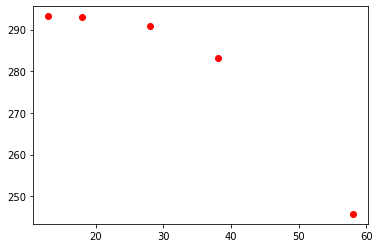

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  70
fixed Jt:  1.3
fixed Nf:  460
fixed Bk:  7.6
start Tn:  72
start Jt:  1.12
start Nf:  446
start Bk:  7.46
stepping:  159
Temperature:  [28.]
rewaRD::  -100
stepping:  159
Temperature:  [28. 33.]
rewaRD::  -100
stepping:  159
Temperature:  [28. 33. 58.]
rewaRD::  -100
stepping:  159
Temperature:  [28. 33. 58. 63.]
rewaRD::  -100
stepping:  159
Temperature:  [28. 33. 58. 63. 93.]
ORDER PARAM RESULT (X2): 69.99999999999642
THE JT RESULT {X0}: 1.2999999999999394
THE NF RESULT {X1}: 459.9999999999972
THE BK RESULT {X3}: 7.6
chisqds:  2.6303893380848783e-23


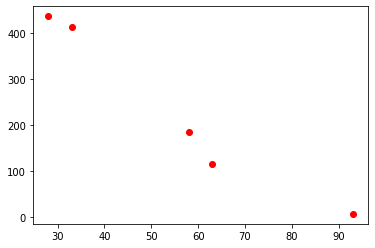

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  90
fixed Jt:  0.9
fixed Nf:  290
fixed Bk:  4.0
start Tn:  96
start Jt:  0.8
start Nf:  304
start Bk:  3.88
stepping:  160
Temperature:  [23.]
rewaRD::  -100
stepping:  160
Temperature:  [23. 28.]
rewaRD::  -100
stepping:  160
Temperature:  [23. 28. 48.]
rewaRD::  -100
stepping:  160
Temperature:  [23. 28. 48. 68.]
rewaRD::  -100
stepping:  160
Temperature:  [23. 28. 48. 68. 88.]
ORDER PARAM RESULT (X2): 95.36600869798643
THE JT RESULT {X0}: 0.9921564134098424
THE NF RESULT {X1}: 299.4209511207816
THE BK RESULT {X3}: 0.10001629433924787
chisqds:  68.4916100171033


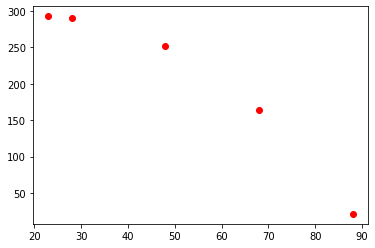

rewaRD::  -94.15986863354337
stepping:  160
Temperature:  [ 23.  28.  48.  68.  88. 118.]
ORDER PARAM RESULT (X2): 89.99999999998835
THE JT RESULT {X0}: 0.9000000000000828
THE NF RESULT {X1}: 289.9999999999991
THE BK RESULT {X3}: 4.0
chisqds:  2.26228711124917e-22


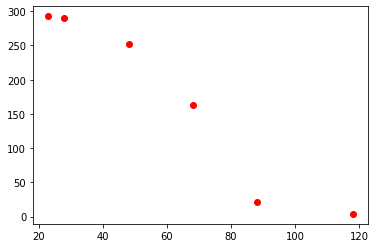

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  220
fixed Jt:  1.4
fixed Nf:  440
fixed Bk:  7.2
start Tn:  226
start Jt:  1.2
start Nf:  434
start Bk:  7.16
stepping:  161
Temperature:  [33.]
rewaRD::  -100
stepping:  161
Temperature:  [33. 34.]
rewaRD::  -100
stepping:  161
Temperature:  [33. 34. 44.]
rewaRD::  -100
stepping:  161
Temperature:  [33. 34. 44. 45.]
rewaRD::  -100
stepping:  161
Temperature:  [33. 34. 44. 45. 75.]
ORDER PARAM RESULT (X2): 226.1755424246865
THE JT RESULT {X0}: 1.19213039843224
THE NF RESULT {X1}: 434.8521140044991
THE BK RESULT {X3}: 7.999445368865372
chisqds:  0.14414642906129543


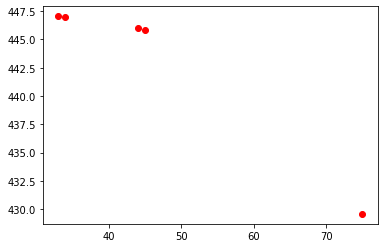

rewaRD::  300
stepping:  161
Temperature:  [33. 34. 44. 45. 75. 85.]
ORDER PARAM RESULT (X2): 225.41176228991702
THE JT RESULT {X0}: 1.2077152843716978
THE NF RESULT {X1}: 434.86920616362016
THE BK RESULT {X3}: 7.999767182781783
chisqds:  0.07702899092116994


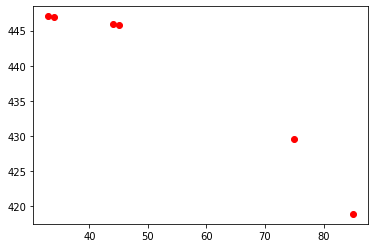

rewaRD::  300
stepping:  161
Temperature:  [ 33.  34.  44.  45.  75.  85. 100.]
ORDER PARAM RESULT (X2): 224.20390677285755
THE JT RESULT {X0}: 1.2339109689861865
THE NF RESULT {X1}: 434.9120167494298
THE BK RESULT {X3}: 7.9997870558476505
chisqds:  0.05943366628766714


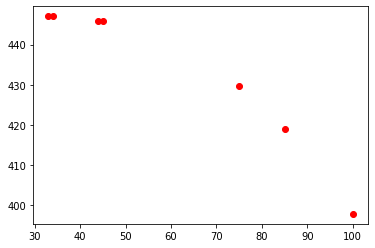

rewaRD::  300
stepping:  161
Temperature:  [ 33.  34.  44.  45.  75.  85. 100. 101.]
ORDER PARAM RESULT (X2): 223.43377991393018
THE JT RESULT {X0}: 1.2526207770090412
THE NF RESULT {X1}: 435.0133555547144
THE BK RESULT {X3}: 7.99976857240464
chisqds:  0.04429490051607929


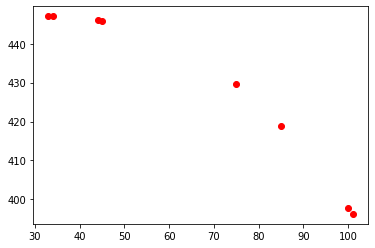

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  210
fixed Jt:  0.7
fixed Nf:  160
fixed Bk:  5.8
start Tn:  208
start Jt:  0.78
start Nf:  164
start Bk:  5.92
stepping:  162
Temperature:  [13.]
rewaRD::  -100
stepping:  162
Temperature:  [13. 23.]
rewaRD::  -100
stepping:  162
Temperature:  [13. 23. 53.]
rewaRD::  -100
stepping:  162
Temperature:  [13. 23. 53. 63.]
rewaRD::  -100
stepping:  162
Temperature:  [13. 23. 53. 63. 64.]
ORDER PARAM RESULT (X2): 209.99999528508627
THE JT RESULT {X0}: 0.6999999627283301
THE NF RESULT {X1}: 159.99999082177928
THE BK RESULT {X3}: 5.800009178221452
chisqds:  5.280315642615753e-24


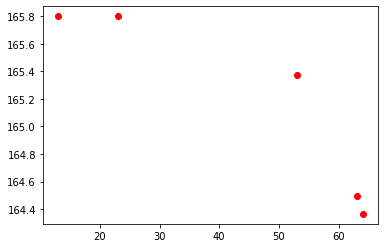

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  220
fixed Jt:  1.1
fixed Nf:  260
fixed Bk:  3.6
start Tn:  238
start Jt:  1.18
start Nf:  276
start Bk:  3.7
stepping:  163
Temperature:  [8.]
rewaRD::  -100
-------------------------------------
| approxkl           | 9.442855e-05 |
| clipfrac           | 0.0          |
| ep_len_mean        | 6.23         |
| ep_reward_mean     | -83.9        |
| explained_variance | 9.39e-05     |
| fps                | 5            |
| n_updates          | 10           |
| policy_entropy     | 1.9397814    |
| policy_loss        | 7.155724e-05 |
| serial_timesteps   | 1280         |
| time_elapsed       | 185          |
| total_timesteps    | 1280         |
| value_loss         | 104981.87    |
-------------------------------------
stepping:  163
Temperature:  [ 8. 23.]
rewaRD::  -100
stepping:  163
Temperature:  [ 8. 23. 53.]
rewaRD::  -100
stepping:  163
Temperature:  [ 8. 23. 53. 58.]
rewaRD::  -100
stepping:  163
Temperature:  [ 8.

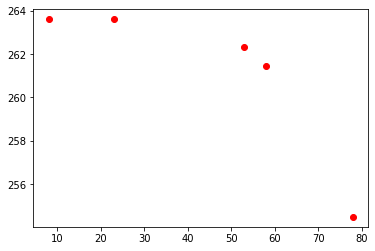

rewaRD::  300
stepping:  163
Temperature:  [ 8. 23. 53. 58. 78. 93.]
ORDER PARAM RESULT (X2): 220.0000000000181
THE JT RESULT {X0}: 1.1000000000001533
THE NF RESULT {X1}: 260.0000000000548
THE BK RESULT {X3}: 3.5999999999452537
chisqds:  2.1330938165016898e-28


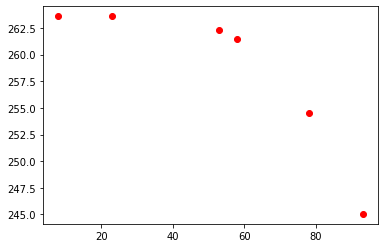

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  110
fixed Jt:  1.1
fixed Nf:  410
fixed Bk:  6.0
start Tn:  112
start Jt:  0.96
start Nf:  428
start Bk:  6.12
stepping:  164
Temperature:  [33.]
rewaRD::  -100
stepping:  164
Temperature:  [33. 63.]
rewaRD::  -100
stepping:  164
Temperature:  [33. 63. 78.]
rewaRD::  -100
stepping:  164
Temperature:  [33. 63. 78. 88.]
rewaRD::  -100
stepping:  164
Temperature:  [ 33.  63.  78.  88. 113.]
ORDER PARAM RESULT (X2): 109.99999999999835
THE JT RESULT {X0}: 1.100000000000005
THE NF RESULT {X1}: 409.9999999999998
THE BK RESULT {X3}: 6.0
chisqds:  7.666576594458221e-25


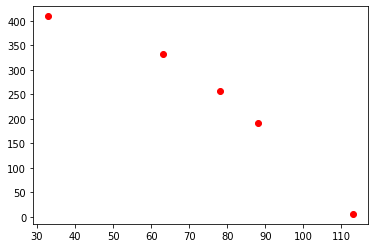

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  220
fixed Jt:  1.4
fixed Nf:  300
fixed Bk:  6.2
start Tn:  230
start Jt:  1.42
start Nf:  296
start Bk:  6.34
stepping:  165
Temperature:  [23.]
rewaRD::  -100
stepping:  165
Temperature:  [23. 38.]
rewaRD::  -100
stepping:  165
Temperature:  [23. 38. 68.]
rewaRD::  -100
stepping:  165
Temperature:  [23. 38. 68. 73.]
rewaRD::  -100
stepping:  165
Temperature:  [23. 38. 68. 73. 93.]
ORDER PARAM RESULT (X2): 220.0000000001477
THE JT RESULT {X0}: 1.4000000000012915
THE NF RESULT {X1}: 300.000000000427
THE BK RESULT {X3}: 6.199999999573003
chisqds:  1.6864827068690353e-26


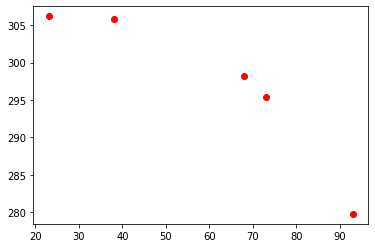

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  190
fixed Jt:  1.4
fixed Nf:  140
fixed Bk:  5.2
start Tn:  178
start Jt:  1.3
start Nf:  142
start Bk:  5.26
stepping:  166
Temperature:  [28.]
rewaRD::  -100
stepping:  166
Temperature:  [28. 29.]
rewaRD::  -100
stepping:  166
Temperature:  [28. 29. 54.]
rewaRD::  -100
stepping:  166
Temperature:  [28. 29. 54. 55.]
rewaRD::  -100
stepping:  166
Temperature:  [28. 29. 54. 55. 60.]
ORDER PARAM RESULT (X2): 189.99999999449602
THE JT RESULT {X0}: 1.3999999999366224
THE NF RESULT {X1}: 139.99999999192835
THE BK RESULT {X3}: 5.200000008071951
chisqds:  1.5820858029712583e-25


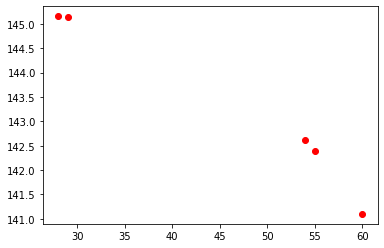

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  120
fixed Jt:  1.2
fixed Nf:  120
fixed Bk:  6.0
start Tn:  118
start Jt:  1.38
start Nf:  102
start Bk:  5.98
stepping:  167
Temperature:  [4.]
rewaRD::  -100
stepping:  167
Temperature:  [ 4. 34.]
rewaRD::  -100
stepping:  167
Temperature:  [ 4. 34. 54.]
rewaRD::  -100
stepping:  167
Temperature:  [ 4. 34. 54. 79.]
rewaRD::  -100
stepping:  167
Temperature:  [ 4. 34. 54. 79. 84.]
ORDER PARAM RESULT (X2): 120.05316817808368
THE JT RESULT {X0}: 1.127855710021775
THE NF RESULT {X1}: 104.52860326189375
THE BK RESULT {X3}: 7.999435423939397
chisqds:  5.2642591558771


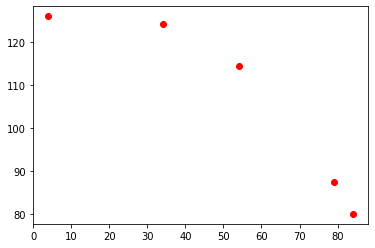

rewaRD::  -24.015898884188886
stepping:  167
Temperature:  [  4.  34.  54.  79.  84. 104.]
ORDER PARAM RESULT (X2): 119.15928596367735
THE JT RESULT {X0}: 1.0873770035428092
THE NF RESULT {X1}: 105.09572446182632
THE BK RESULT {X3}: 7.999581145876451
chisqds:  2.6058266822338276


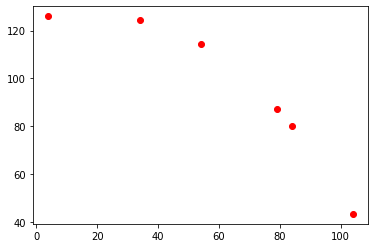

rewaRD::  53.50215067147241
stepping:  167
Temperature:  [  4.  34.  54.  79.  84. 104. 114.]
ORDER PARAM RESULT (X2): 118.78987241889195
THE JT RESULT {X0}: 0.9917646892281166
THE NF RESULT {X1}: 106.21785633543998
THE BK RESULT {X3}: 7.999713376939168
chisqds:  1.3864586875124303


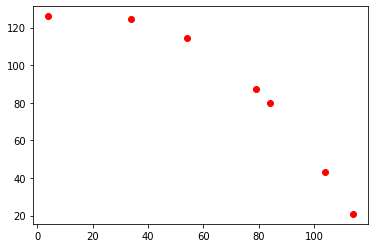

rewaRD::  188.50480984592178
stepping:  167
Temperature:  [  4.  34.  54.  79.  84. 104. 114. 134.]
ORDER PARAM RESULT (X2): 120.00000000002053
THE JT RESULT {X0}: 1.2000000000003155
THE NF RESULT {X1}: 120.00000000000138
THE BK RESULT {X3}: 5.999999999999999
chisqds:  3.459881488587903e-23


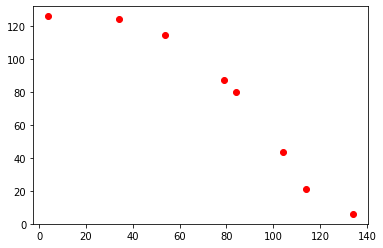

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  130
fixed Jt:  1.1
fixed Nf:  370
fixed Bk:  7.0
start Tn:  110
start Jt:  1.06
start Nf:  366
start Bk:  6.82
stepping:  168
Temperature:  [4.]
rewaRD::  -100
stepping:  168
Temperature:  [ 4. 34.]
rewaRD::  -100
stepping:  168
Temperature:  [ 4. 34. 49.]
rewaRD::  -100
stepping:  168
Temperature:  [ 4. 34. 49. 64.]
rewaRD::  -100
stepping:  168
Temperature:  [ 4. 34. 49. 64. 74.]
ORDER PARAM RESULT (X2): 110.76487755114313
THE JT RESULT {X0}: 1.0005802376062574
THE NF RESULT {X1}: 367.18845645245904
THE BK RESULT {X3}: 7.999552957681499
chisqds:  9.831531340469759


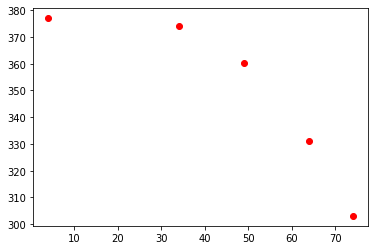

rewaRD::  -59.31457815188253
stepping:  168
Temperature:  [ 4. 34. 49. 64. 74. 79.]
ORDER PARAM RESULT (X2): 110.59178447270453
THE JT RESULT {X0}: 1.0064158509474939
THE NF RESULT {X1}: 367.2203273028009
THE BK RESULT {X3}: 7.999685275116149
chisqds:  10.179158052107631


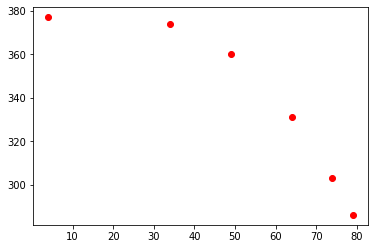

rewaRD::  -60.70401913867733
stepping:  168
Temperature:  [  4.  34.  49.  64.  74.  79. 104.]
ORDER PARAM RESULT (X2): 110.35065110886534
THE JT RESULT {X0}: 1.0180494702877734
THE NF RESULT {X1}: 366.88748121168703
THE BK RESULT {X3}: 7.999723197829354
chisqds:  31.367661314154574


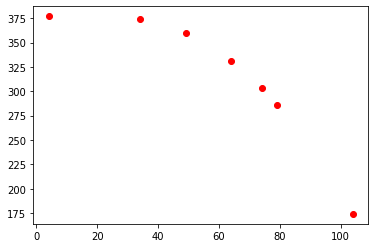

rewaRD::  -87.24801329643594
stepping:  168
Temperature:  [  4.  34.  49.  64.  74.  79. 104. 124.]
ORDER PARAM RESULT (X2): 110.37532770736595
THE JT RESULT {X0}: 1.01522852855552
THE NF RESULT {X1}: 366.94394412427437
THE BK RESULT {X3}: 7.999604596746536
chisqds:  32.28404084967059


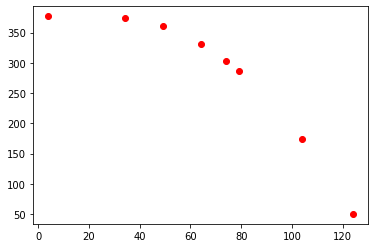

rewaRD::  -87.60997726825508
stepping:  168
Temperature:  [  4.  34.  49.  64.  74.  79. 104. 124. 134.]
ORDER PARAM RESULT (X2): 111.65541813521277
THE JT RESULT {X0}: 0.8752139999060704
THE NF RESULT {X1}: 369.76185039436245
THE BK RESULT {X3}: 7.999738601630198
chisqds:  21.14933377428902


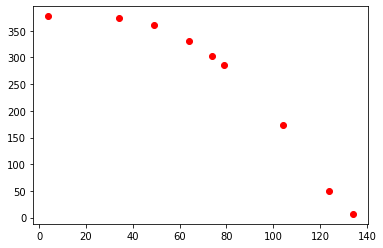

rewaRD::  -81.08687468508937
stepping:  168
Temperature:  [  4.  34.  49.  64.  74.  79. 104. 124. 134. 139.]
ORDER PARAM RESULT (X2): 113.00370407242073
THE JT RESULT {X0}: 0.7417819687813214
THE NF RESULT {X1}: 372.3450817417601
THE BK RESULT {X3}: 7.999704177112307
chisqds:  14.287083491841399


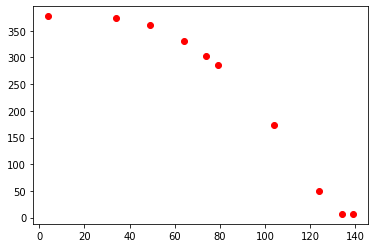

rewaRD::  -72.00268338682146
stepping:  168
Temperature:  [  4.  34.  49.  64.  74.  79. 104. 124. 134. 139. 154.]
ORDER PARAM RESULT (X2): 114.51771041510895
THE JT RESULT {X0}: 0.6268960120121719
THE NF RESULT {X1}: 373.82287200367995
THE BK RESULT {X3}: 7.999445822912626
chisqds:  9.918079454665333


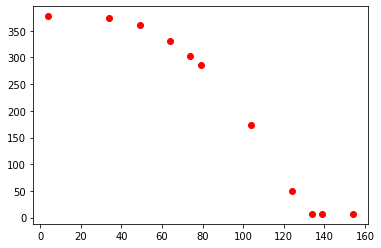

rewaRD::  -59.669611256053685
stepping:  168
Temperature:  [  4.  34.  49.  64.  74.  79. 104. 124. 134. 139. 154. 174.]
ORDER PARAM RESULT (X2): 116.07700066313365
THE JT RESULT {X0}: 0.504262433976389
THE NF RESULT {X1}: 375.2016863104634
THE BK RESULT {X3}: 7.9996926566916
chisqds:  7.1120260093959615


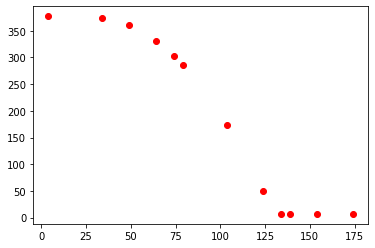

rewaRD::  -43.75723605741245
stepping:  168
Temperature:  [  4.  34.  49.  64.  74.  79. 104. 124. 134. 139. 154. 174. 189.]
ORDER PARAM RESULT (X2): 118.2376902208354
THE JT RESULT {X0}: 0.4030037052792276
THE NF RESULT {X1}: 373.9005955264646
THE BK RESULT {X3}: 7.999239433514357
chisqds:  5.213972390332021


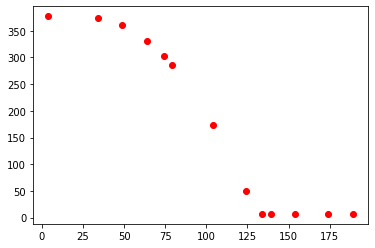

rewaRD::  -23.283061348445628
stepping:  168
Temperature:  [  4.  34.  49.  64.  74.  79. 104. 124. 134. 139. 154. 174. 189. 199.]
ORDER PARAM RESULT (X2): 129.9999999999768
THE JT RESULT {X0}: 1.1000000000001375
THE NF RESULT {X1}: 369.9999999999993
THE BK RESULT {X3}: 7.0
chisqds:  5.558769307019068e-23


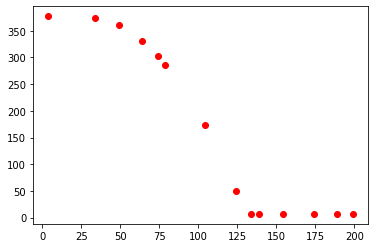

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  120
fixed Jt:  1.4
fixed Nf:  160
fixed Bk:  6.6
start Tn:  126
start Jt:  1.22
start Nf:  168
start Bk:  6.44
stepping:  169
Temperature:  [13.]
rewaRD::  -100
stepping:  169
Temperature:  [13. 38.]
rewaRD::  -100
stepping:  169
Temperature:  [13. 38. 39.]
rewaRD::  -100
stepping:  169
Temperature:  [13. 38. 39. 69.]
rewaRD::  -100
stepping:  169
Temperature:  [13. 38. 39. 69. 79.]
ORDER PARAM RESULT (X2): 120.00000000000793
THE JT RESULT {X0}: 1.4000000000000563
THE NF RESULT {X1}: 160.00000000001862
THE BK RESULT {X3}: 6.599999999981426
chisqds:  1.1310190078421583e-25


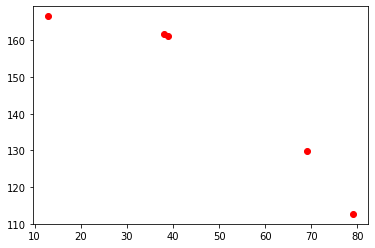

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  160
fixed Jt:  1.3
fixed Nf:  310
fixed Bk:  4.4
start Tn:  156
start Jt:  1.48
start Nf:  306
start Bk:  4.32
stepping:  170
Temperature:  [13.]
rewaRD::  -100
stepping:  170
Temperature:  [13. 23.]
rewaRD::  -100
stepping:  170
Temperature:  [13. 23. 24.]
rewaRD::  -100
stepping:  170
Temperature:  [13. 23. 24. 34.]
rewaRD::  -100
stepping:  170
Temperature:  [13. 23. 24. 34. 54.]
ORDER PARAM RESULT (X2): 159.99999999711432
THE JT RESULT {X0}: 1.2999999999618195
THE NF RESULT {X1}: 309.99999998879383
THE BK RESULT {X3}: 4.400000011206175
chisqds:  4.213395442389555e-25


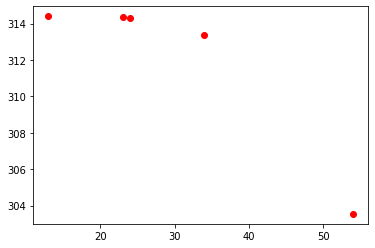

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  180
fixed Jt:  0.9
fixed Nf:  200
fixed Bk:  4.6
start Tn:  190
start Jt:  0.62
start Nf:  180
start Bk:  4.65
stepping:  171
Temperature:  [33.]
rewaRD::  -100
stepping:  171
Temperature:  [33. 48.]
rewaRD::  -100
stepping:  171
Temperature:  [33. 48. 63.]
rewaRD::  -100
stepping:  171
Temperature:  [33. 48. 63. 68.]
rewaRD::  -100
stepping:  171
Temperature:  [33. 48. 63. 68. 88.]
ORDER PARAM RESULT (X2): 197.96091036494624
THE JT RESULT {X0}: 0.4095447152952385
THE NF RESULT {X1}: 183.45344800771684
THE BK RESULT {X3}: 7.999252069971375
chisqds:  2.258578251404052


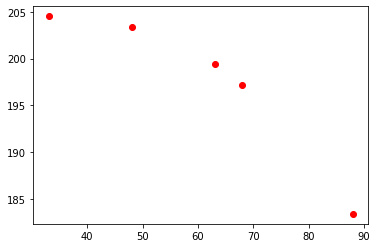

rewaRD::  77.1025643018296
stepping:  171
Temperature:  [33. 48. 63. 68. 88. 98.]
ORDER PARAM RESULT (X2): 193.90125620238075
THE JT RESULT {X0}: 0.48942771680158403
THE NF RESULT {X1}: 183.5408995059383
THE BK RESULT {X3}: 7.999239500736083
chisqds:  1.182973698370327


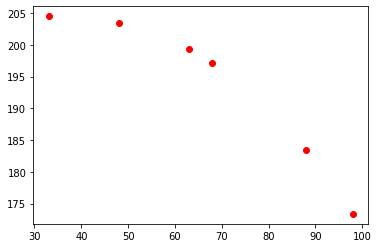

rewaRD::  238.13093270885298
stepping:  171
Temperature:  [33. 48. 63. 68. 88. 98. 99.]
ORDER PARAM RESULT (X2): 193.03073571308732
THE JT RESULT {X0}: 0.5137903078813975
THE NF RESULT {X1}: 183.62397629162186
THE BK RESULT {X3}: 7.999978404330786
chisqds:  0.7940363260797326


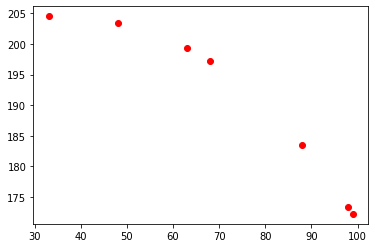

rewaRD::  300
stepping:  171
Temperature:  [ 33.  48.  63.  68.  88.  98.  99. 124.]
ORDER PARAM RESULT (X2): 189.05858511685744
THE JT RESULT {X0}: 0.5860711232242939
THE NF RESULT {X1}: 184.0224026638565
THE BK RESULT {X3}: 7.999343922899304
chisqds:  0.7022139429324321


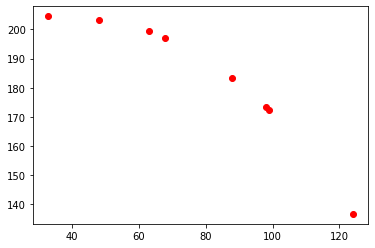

rewaRD::  300
stepping:  171
Temperature:  [ 33.  48.  63.  68.  88.  98.  99. 124. 129.]
ORDER PARAM RESULT (X2): 187.4667087053589
THE JT RESULT {X0}: 0.640454504514354
THE NF RESULT {X1}: 184.54092445341598
THE BK RESULT {X3}: 7.999564395639554
chisqds:  0.5860318170594103


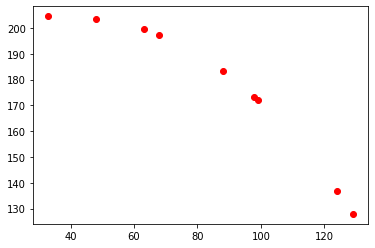

rewaRD::  300
stepping:  171
Temperature:  [ 33.  48.  63.  68.  88.  98.  99. 124. 129. 144.]
ORDER PARAM RESULT (X2): 185.0923285097848
THE JT RESULT {X0}: 0.7187024460275058
THE NF RESULT {X1}: 186.00970063775233
THE BK RESULT {X3}: 7.999508429732241
chisqds:  0.45739003596413447


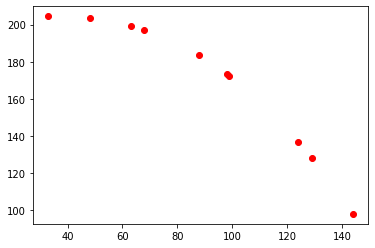

rewaRD::  300
stepping:  171
Temperature:  [ 33.  48.  63.  68.  88.  98.  99. 124. 129. 144. 159.]
ORDER PARAM RESULT (X2): 180.8872537939881
THE JT RESULT {X0}: 0.8540651113515041
THE NF RESULT {X1}: 190.89644307811983
THE BK RESULT {X3}: 7.999215528505556
chisqds:  0.13013931313723895


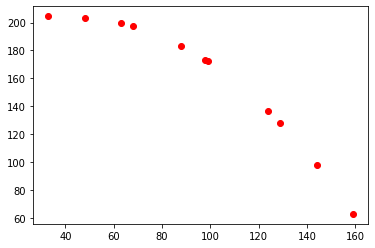

rewaRD::  300
stepping:  171
Temperature:  [ 33.  48.  63.  68.  88.  98.  99. 124. 129. 144. 159. 189.]
ORDER PARAM RESULT (X2): 180.00000000000094
THE JT RESULT {X0}: 0.8999999999999618
THE NF RESULT {X1}: 199.9999999999998
THE BK RESULT {X3}: 4.6
chisqds:  2.9240298035972523e-26


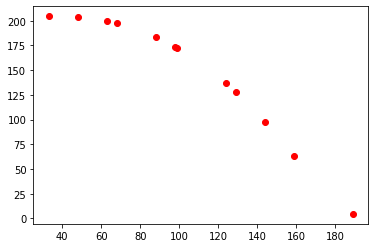

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  140
fixed Jt:  0.7
fixed Nf:  190
fixed Bk:  4.4
start Tn:  128
start Jt:  0.68
start Nf:  194
start Bk:  4.34
stepping:  172
Temperature:  [33.]
rewaRD::  -100
stepping:  172
Temperature:  [33. 34.]
rewaRD::  -100
stepping:  172
Temperature:  [33. 34. 59.]
rewaRD::  -100
stepping:  172
Temperature:  [33. 34. 59. 89.]
rewaRD::  -100
stepping:  172
Temperature:  [33. 34. 59. 89. 94.]
ORDER PARAM RESULT (X2): 132.46316744743493
THE JT RESULT {X0}: 0.40000011491387044
THE NF RESULT {X1}: 192.2166634421046
THE BK RESULT {X3}: 4.492783704311989
chisqds:  0.19953143137158658


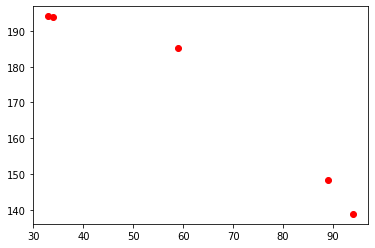

rewaRD::  300
stepping:  172
Temperature:  [ 33.  34.  59.  89.  94. 124.]
ORDER PARAM RESULT (X2): 130.564586217932
THE JT RESULT {X0}: 0.5324559800460386
THE NF RESULT {X1}: 193.45026159939232
THE BK RESULT {X3}: 7.99922969884632
chisqds:  5.668830047123586


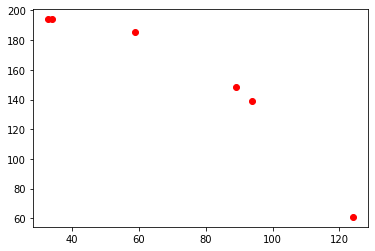

rewaRD::  -29.438703105420572
stepping:  172
Temperature:  [ 33.  34.  59.  89.  94. 124. 134.]
ORDER PARAM RESULT (X2): 129.74167395825987
THE JT RESULT {X0}: 0.5428484864892298
THE NF RESULT {X1}: 194.38321998510983
THE BK RESULT {X3}: 7.999662772868488
chisqds:  9.215113011296333


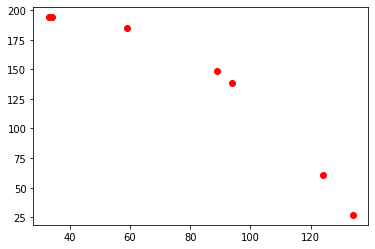

rewaRD::  -56.593044544363096
stepping:  172
Temperature:  [ 33.  34.  59.  89.  94. 124. 134. 144.]
ORDER PARAM RESULT (X2): 139.99999999999937
THE JT RESULT {X0}: 0.6999999999999615
THE NF RESULT {X1}: 189.99999999999974
THE BK RESULT {X3}: 4.4
chisqds:  5.68958252093501e-26


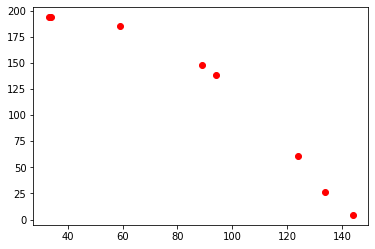

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  190
fixed Jt:  1.0
fixed Nf:  450
fixed Bk:  3.4
start Tn:  208
start Jt:  1.06
start Nf:  450
start Bk:  3.46
stepping:  173
Temperature:  [28.]
rewaRD::  -100
stepping:  173
Temperature:  [28. 53.]
rewaRD::  -100
stepping:  173
Temperature:  [28. 53. 73.]
rewaRD::  -100
stepping:  173
Temperature:  [28. 53. 73. 83.]
rewaRD::  -100
stepping:  173
Temperature:  [28. 53. 73. 83. 93.]
ORDER PARAM RESULT (X2): 190.00000000071532
THE JT RESULT {X0}: 1.0000000000047875
THE NF RESULT {X1}: 450.00000000394647
THE BK RESULT {X3}: 3.3999999960535265
chisqds:  3.0662345284165054e-23


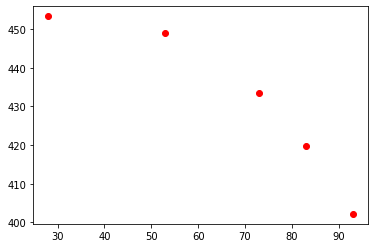

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  120
fixed Jt:  0.8
fixed Nf:  210
fixed Bk:  6.4
start Tn:  134
start Jt:  1.02
start Nf:  214
start Bk:  6.56
stepping:  174
Temperature:  [23.]
rewaRD::  -100
stepping:  174
Temperature:  [23. 38.]
rewaRD::  -100
stepping:  174
Temperature:  [23. 38. 48.]
rewaRD::  -100
stepping:  174
Temperature:  [23. 38. 48. 78.]
rewaRD::  -100
stepping:  174
Temperature:  [23. 38. 48. 78. 79.]
ORDER PARAM RESULT (X2): 119.99999991637331
THE JT RESULT {X0}: 0.7999999989053787
THE NF RESULT {X1}: 209.99999960287093
THE BK RESULT {X3}: 6.400000397148559
chisqds:  7.3257198116380845e-22


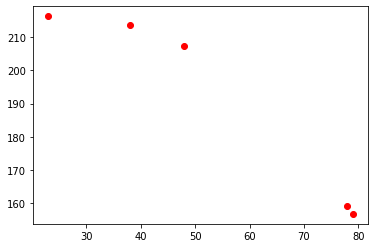

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  230
fixed Jt:  0.7
fixed Nf:  330
fixed Bk:  5.2
start Tn:  246
start Jt:  0.74
start Nf:  312
start Bk:  5.38
stepping:  175
Temperature:  [28.]
rewaRD::  -100
stepping:  175
Temperature:  [28. 43.]
rewaRD::  -100
stepping:  175
Temperature:  [28. 43. 73.]
rewaRD::  -100
stepping:  175
Temperature:  [ 28.  43.  73. 103.]
rewaRD::  -100
stepping:  175
Temperature:  [ 28.  43.  73. 103. 133.]
ORDER PARAM RESULT (X2): 247.09828155689647
THE JT RESULT {X0}: 0.7008597926459601
THE NF RESULT {X1}: 314.8248365047701
THE BK RESULT {X3}: 7.999328249640048
chisqds:  1.424404152707304


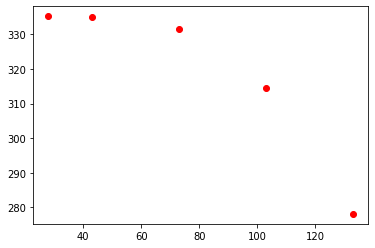

rewaRD::  180.81917568109947
stepping:  175
Temperature:  [ 28.  43.  73. 103. 133. 134.]
ORDER PARAM RESULT (X2): 246.5747008012297
THE JT RESULT {X0}: 0.715192038767025
THE NF RESULT {X1}: 314.9397549821414
THE BK RESULT {X3}: 7.999447213387472
chisqds:  0.7162264299244999


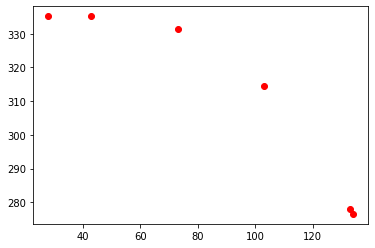

rewaRD::  300
stepping:  175
Temperature:  [ 28.  43.  73. 103. 133. 134. 159.]
ORDER PARAM RESULT (X2): 244.03100917164684
THE JT RESULT {X0}: 0.763986180507846
THE NF RESULT {X1}: 315.42360121036285
THE BK RESULT {X3}: 7.99982266739553
chisqds:  0.576576615943424


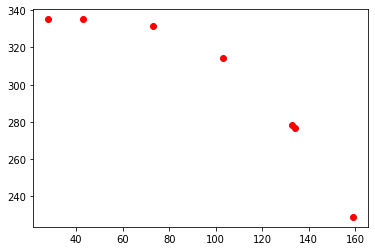

rewaRD::  300
stepping:  175
Temperature:  [ 28.  43.  73. 103. 133. 134. 159. 179.]
ORDER PARAM RESULT (X2): 240.71382921333273
THE JT RESULT {X0}: 0.8406706270810791
THE NF RESULT {X1}: 317.08149289768227
THE BK RESULT {X3}: 7.999343386937746
chisqds:  0.5098032517754258


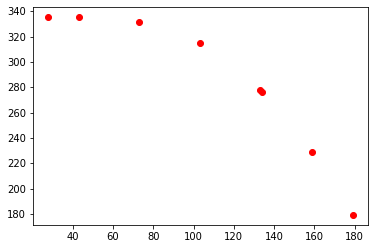

rewaRD::  300
stepping:  175
Temperature:  [ 28.  43.  73. 103. 133. 134. 159. 179. 199.]
ORDER PARAM RESULT (X2): 230.00000000004576
THE JT RESULT {X0}: 0.7000000000002768
THE NF RESULT {X1}: 330.0000000001889
THE BK RESULT {X3}: 5.199999999810986
chisqds:  2.162506623282465e-27


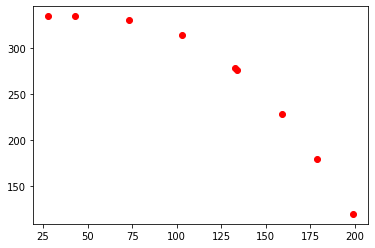

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  130
fixed Jt:  0.9
fixed Nf:  200
fixed Bk:  7.4
start Tn:  116
start Jt:  0.76
start Nf:  208
start Bk:  7.58
stepping:  176
Temperature:  [8.]
rewaRD::  -100
stepping:  176
Temperature:  [ 8. 38.]
rewaRD::  -100
stepping:  176
Temperature:  [ 8. 38. 48.]
rewaRD::  -100
stepping:  176
Temperature:  [ 8. 38. 48. 49.]
rewaRD::  -100
stepping:  176
Temperature:  [ 8. 38. 48. 49. 74.]
ORDER PARAM RESULT (X2): 130.00000000031326
THE JT RESULT {X0}: 0.9000000000029384
THE NF RESULT {X1}: 200.00000000116785
THE BK RESULT {X3}: 7.399999998831983
chisqds:  7.604976107281179e-24


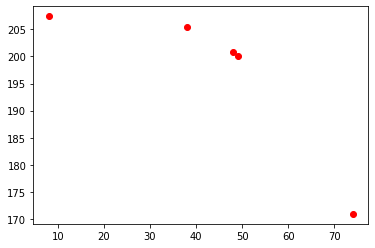

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  210
fixed Jt:  0.8
fixed Nf:  280
fixed Bk:  6.2
start Tn:  204
start Jt:  0.86
start Nf:  272
start Bk:  6.32
stepping:  177
Temperature:  [18.]
rewaRD::  -100
stepping:  177
Temperature:  [18. 28.]
rewaRD::  -100
stepping:  177
Temperature:  [18. 28. 53.]
rewaRD::  -100
stepping:  177
Temperature:  [18. 28. 53. 54.]
rewaRD::  -100
stepping:  177
Temperature:  [18. 28. 53. 54. 79.]
ORDER PARAM RESULT (X2): 211.4711388842431
THE JT RESULT {X0}: 0.7063975053713953
THE NF RESULT {X1}: 273.6960888241042
THE BK RESULT {X3}: 7.999726560478369
chisqds:  0.2997608361642543


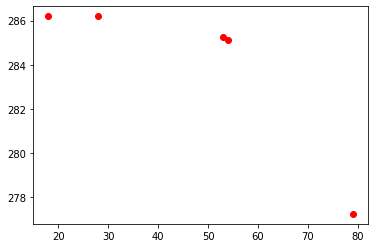

rewaRD::  300
stepping:  177
Temperature:  [ 18.  28.  53.  54.  79. 104.]
ORDER PARAM RESULT (X2): 207.74193257835745
THE JT RESULT {X0}: 0.7553762643196498
THE NF RESULT {X1}: 273.7205250926562
THE BK RESULT {X3}: 7.999251381127226
chisqds:  0.20260284518674293


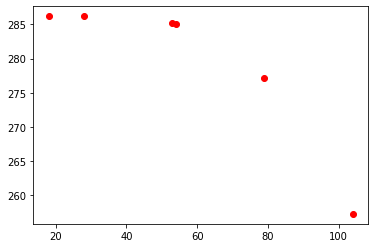

rewaRD::  300
stepping:  177
Temperature:  [ 18.  28.  53.  54.  79. 104. 119.]
ORDER PARAM RESULT (X2): 206.76489160081624
THE JT RESULT {X0}: 0.7688047320303452
THE NF RESULT {X1}: 273.755734439222
THE BK RESULT {X3}: 7.999431009800638
chisqds:  0.18512184319843714


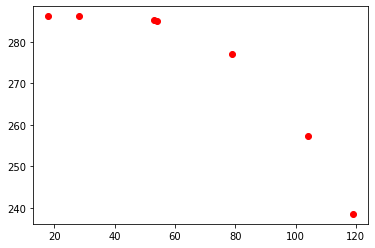

rewaRD::  300
stepping:  177
Temperature:  [ 18.  28.  53.  54.  79. 104. 119. 144.]
ORDER PARAM RESULT (X2): 205.8975306781849
THE JT RESULT {X0}: 0.7735374136633283
THE NF RESULT {X1}: 273.7772967995357
THE BK RESULT {X3}: 7.999229690103228
chisqds:  0.22729873828572011


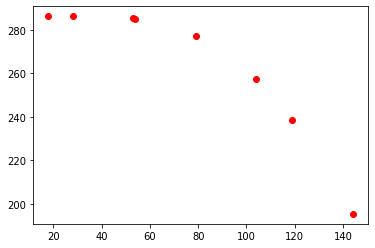

rewaRD::  300
stepping:  177
Temperature:  [ 18.  28.  53.  54.  79. 104. 119. 144. 145.]
ORDER PARAM RESULT (X2): 209.99999999948116
THE JT RESULT {X0}: 0.7999999999972204
THE NF RESULT {X1}: 279.99999999829
THE BK RESULT {X3}: 6.200000001709899
chisqds:  2.0230131457952843e-23


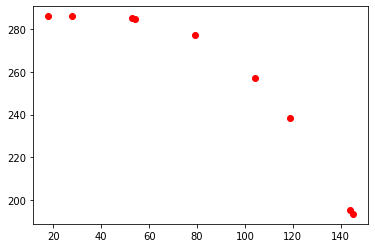

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  80
fixed Jt:  1.1
fixed Nf:  120
fixed Bk:  4.6
start Tn:  60
start Jt:  1.32
start Nf:  104
start Bk:  4.61
stepping:  178
Temperature:  [13.]
rewaRD::  -100
stepping:  178
Temperature:  [13. 14.]
rewaRD::  -100
stepping:  178
Temperature:  [13. 14. 29.]
rewaRD::  -100
stepping:  178
Temperature:  [13. 14. 29. 39.]
rewaRD::  -100
stepping:  178
Temperature:  [13. 14. 29. 39. 49.]
ORDER PARAM RESULT (X2): 62.267111543752534
THE JT RESULT {X0}: 0.77946198013323
THE NF RESULT {X1}: 107.4825277000129
THE BK RESULT {X3}: 7.999208599219843
chisqds:  17.639447850878717


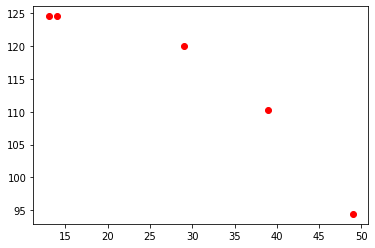

rewaRD::  -77.32355324375565
stepping:  178
Temperature:  [13. 14. 29. 39. 49. 64.]
ORDER PARAM RESULT (X2): 61.688887982013334
THE JT RESULT {X0}: 0.9049404356906486
THE NF RESULT {X1}: 106.58309401856846
THE BK RESULT {X3}: 7.999392208720488
chisqds:  32.86689795591316


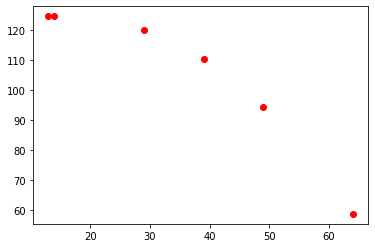

rewaRD::  -87.8297002492736
stepping:  178
Temperature:  [13. 14. 29. 39. 49. 64. 69.]
ORDER PARAM RESULT (X2): 61.619682019001004
THE JT RESULT {X0}: 0.922167760541896
THE NF RESULT {X1}: 106.48857841027466
THE BK RESULT {X3}: 7.999284224553656
chisqds:  31.81293902710252


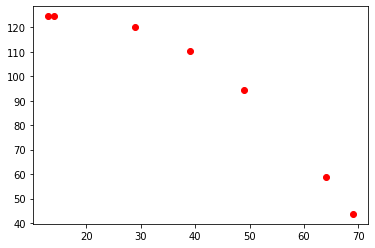

rewaRD::  -87.42649964974231
stepping:  178
Temperature:  [13. 14. 29. 39. 49. 64. 69. 89.]
ORDER PARAM RESULT (X2): 64.04749115936599
THE JT RESULT {X0}: 0.40000003398312817
THE NF RESULT {X1}: 110.2754745082975
THE BK RESULT {X3}: 7.136487593765733
chisqds:  21.295917296787756


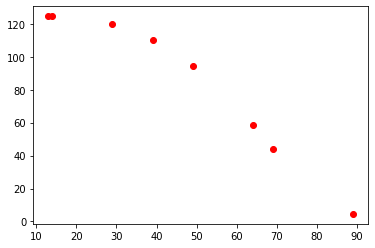

rewaRD::  -81.21705703372845
stepping:  178
Temperature:  [13. 14. 29. 39. 49. 64. 69. 89. 94.]
ORDER PARAM RESULT (X2): 64.0124670712881
THE JT RESULT {X0}: 0.400000751998926
THE NF RESULT {X1}: 110.34929831460147
THE BK RESULT {X3}: 6.02517031691026
chisqds:  18.016483984455768


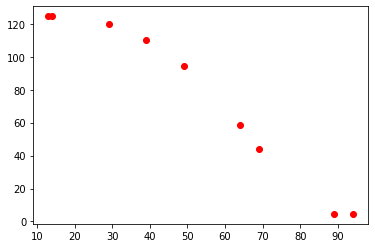

rewaRD::  -77.79810975631476
stepping:  178
Temperature:  [ 13.  14.  29.  39.  49.  64.  69.  89.  94. 124.]
ORDER PARAM RESULT (X2): 79.99999999996886
THE JT RESULT {X0}: 1.1000000000003658
THE NF RESULT {X1}: 119.99999999999976
THE BK RESULT {X3}: 4.6
chisqds:  4.90619652663272e-23


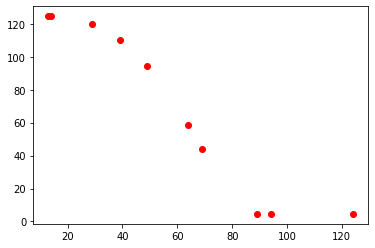

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  80
fixed Jt:  1.0
fixed Nf:  120
fixed Bk:  4.6
start Tn:  80
start Jt:  1.1
start Nf:  116
start Bk:  4.55
stepping:  179
Temperature:  [4.]
rewaRD::  -100
stepping:  179
Temperature:  [ 4. 14.]
rewaRD::  -100
stepping:  179
Temperature:  [ 4. 14. 19.]
rewaRD::  -100
stepping:  179
Temperature:  [ 4. 14. 19. 29.]
rewaRD::  -100
stepping:  179
Temperature:  [ 4. 14. 19. 29. 30.]
ORDER PARAM RESULT (X2): 80.00000000016146
THE JT RESULT {X0}: 1.00000000000353
THE NF RESULT {X1}: 120.00000000055951
THE BK RESULT {X3}: 4.599999999440443
chisqds:  1.279559997484942e-26


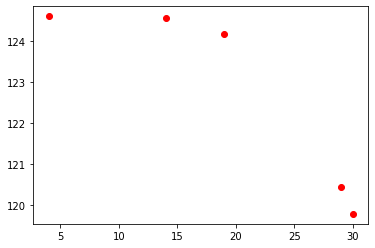

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  250
fixed Jt:  1.2
fixed Nf:  350
fixed Bk:  6.8
start Tn:  250
start Jt:  1.42
start Nf:  356
start Bk:  6.62
stepping:  180
Temperature:  [4.]
rewaRD::  -100
stepping:  180
Temperature:  [ 4. 24.]
rewaRD::  -100
stepping:  180
Temperature:  [ 4. 24. 25.]
rewaRD::  -100
stepping:  180
Temperature:  [ 4. 24. 25. 55.]
rewaRD::  -100
stepping:  180
Temperature:  [ 4. 24. 25. 55. 70.]
ORDER PARAM RESULT (X2): 250.00000023156258
THE JT RESULT {X0}: 1.2000000019777488
THE NF RESULT {X1}: 350.00000064176413
THE BK RESULT {X3}: 6.799999358235922
chisqds:  6.514594603405314e-26


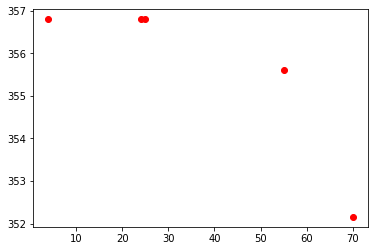

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  70
fixed Jt:  0.8
fixed Nf:  350
fixed Bk:  6.2
start Tn:  68
start Jt:  0.8
start Nf:  340
start Bk:  6.26
stepping:  181
Temperature:  [28.]
rewaRD::  -100
stepping:  181
Temperature:  [28. 29.]
rewaRD::  -100
stepping:  181
Temperature:  [28. 29. 34.]
rewaRD::  -100
-------------------------------------
| approxkl           | 2.473238e-05 |
| clipfrac           | 0.0          |
| ep_len_mean        | 7.4          |
| ep_reward_mean     | 209          |
| explained_variance | 0.000599     |
| fps                | 5            |
| n_updates          | 11           |
| policy_entropy     | 1.9400477    |
| policy_loss        | 8.938648e-05 |
| serial_timesteps   | 1408         |
| time_elapsed       | 210          |
| total_timesteps    | 1408         |
| value_loss         | 149256.14    |
-------------------------------------
stepping:  181
Temperature:  [28. 29. 34. 39.]
rewaRD::  -100
stepping:  181
Temperature:  [28. 

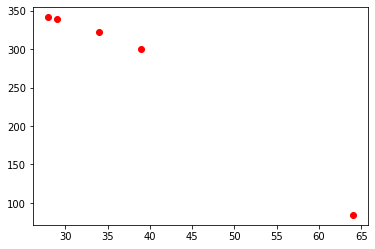

rewaRD::  -22.094054734648168
stepping:  181
Temperature:  [28. 29. 34. 39. 64. 65.]
ORDER PARAM RESULT (X2): 69.99999958194405
THE JT RESULT {X0}: 0.7999999920646574
THE NF RESULT {X1}: 349.999994193417
THE BK RESULT {X3}: 6.200005821763435
chisqds:  4.876272556734114e-21


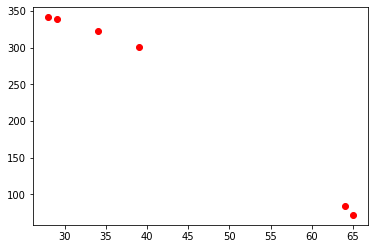

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  180
fixed Jt:  0.7
fixed Nf:  400
fixed Bk:  6.0
start Tn:  198
start Jt:  0.74
start Nf:  402
start Bk:  5.98
stepping:  182
Temperature:  [4.]
rewaRD::  -100
stepping:  182
Temperature:  [ 4. 24.]
rewaRD::  -100
stepping:  182
Temperature:  [ 4. 24. 25.]
rewaRD::  -100
stepping:  182
Temperature:  [ 4. 24. 25. 40.]
rewaRD::  -100
stepping:  182
Temperature:  [ 4. 24. 25. 40. 45.]
ORDER PARAM RESULT (X2): 180.00000006385798
THE JT RESULT {X0}: 0.7000000005985726
THE NF RESULT {X1}: 400.00000035307454
THE BK RESULT {X3}: 5.9999996469256
chisqds:  2.679726465118792e-26


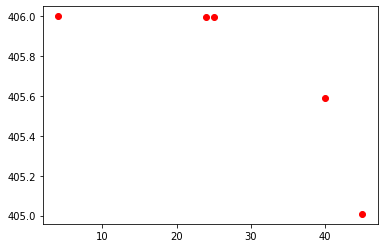

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  200
fixed Jt:  1.1
fixed Nf:  180
fixed Bk:  5.6
start Tn:  184
start Jt:  1.16
start Nf:  192
start Bk:  5.72
stepping:  183
Temperature:  [33.]
rewaRD::  -100
stepping:  183
Temperature:  [33. 43.]
rewaRD::  -100
stepping:  183
Temperature:  [33. 43. 58.]
rewaRD::  -100
stepping:  183
Temperature:  [33. 43. 58. 83.]
rewaRD::  -100
stepping:  183
Temperature:  [33. 43. 58. 83. 93.]
ORDER PARAM RESULT (X2): 200.00000000009857
THE JT RESULT {X0}: 1.1000000000006116
THE NF RESULT {X1}: 180.0000000001985
THE BK RESULT {X3}: 5.5999999998015815
chisqds:  2.1335381390225525e-25


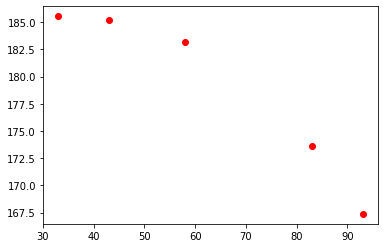

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  210
fixed Jt:  0.9
fixed Nf:  130
fixed Bk:  3.8
start Tn:  224
start Jt:  1.06
start Nf:  112
start Bk:  3.6
stepping:  184
Temperature:  [23.]
rewaRD::  -100
stepping:  184
Temperature:  [23. 28.]
rewaRD::  -100
stepping:  184
Temperature:  [23. 28. 29.]
rewaRD::  -100
stepping:  184
Temperature:  [23. 28. 29. 34.]
rewaRD::  -100
stepping:  184
Temperature:  [23. 28. 29. 34. 64.]
ORDER PARAM RESULT (X2): 266.4070787075046
THE JT RESULT {X0}: 0.40000012411504415
THE NF RESULT {X1}: 114.27960610373813
THE BK RESULT {X3}: 5.8754495594989145
chisqds:  6.658557482590805


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


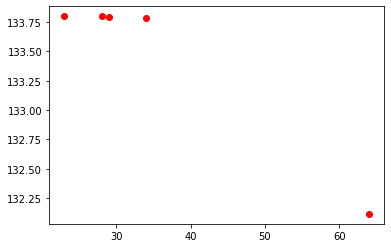

rewaRD::  -39.926928460732846
stepping:  184
Temperature:  [23. 28. 29. 34. 64. 94.]
ORDER PARAM RESULT (X2): 209.99999999979707
THE JT RESULT {X0}: 0.8999999999981891
THE NF RESULT {X1}: 129.9999999996814
THE BK RESULT {X3}: 3.800000000318596
chisqds:  1.4038261729411042e-26


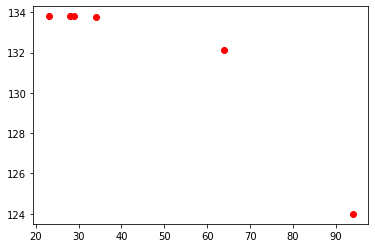

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  260
fixed Jt:  0.7
fixed Nf:  330
fixed Bk:  6.6
start Tn:  248
start Jt:  0.9
start Nf:  326
start Bk:  6.56
stepping:  185
Temperature:  [28.]
rewaRD::  -100
stepping:  185
Temperature:  [28. 53.]
rewaRD::  -100
stepping:  185
Temperature:  [28. 53. 63.]
rewaRD::  -100
stepping:  185
Temperature:  [28. 53. 63. 83.]
rewaRD::  -100
stepping:  185
Temperature:  [28. 53. 63. 83. 88.]
ORDER PARAM RESULT (X2): 258.605108634774
THE JT RESULT {X0}: 0.738550229911712
THE NF RESULT {X1}: 327.4506890026019
THE BK RESULT {X3}: 7.999490687650359
chisqds:  0.027706833636021132


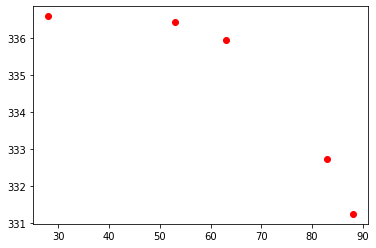

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  220
fixed Jt:  0.9
fixed Nf:  250
fixed Bk:  4.8
start Tn:  212
start Jt:  0.94
start Nf:  254
start Bk:  4.68
stepping:  186
Temperature:  [33.]
rewaRD::  -100
stepping:  186
Temperature:  [33. 43.]
rewaRD::  -100
stepping:  186
Temperature:  [33. 43. 48.]
rewaRD::  -100
stepping:  186
Temperature:  [33. 43. 48. 53.]
rewaRD::  -100
stepping:  186
Temperature:  [33. 43. 48. 53. 63.]
ORDER PARAM RESULT (X2): 219.9999999987073
THE JT RESULT {X0}: 0.8999999999902867
THE NF RESULT {X1}: 249.99999999650933
THE BK RESULT {X3}: 4.800000003490472
chisqds:  5.834985283200585e-26


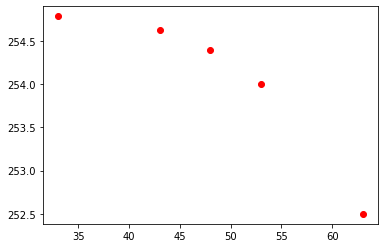

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  220
fixed Jt:  1.2
fixed Nf:  390
fixed Bk:  4.6
start Tn:  236
start Jt:  1.22
start Nf:  408
start Bk:  4.73
stepping:  187
Temperature:  [4.]
rewaRD::  -100
stepping:  187
Temperature:  [ 4. 19.]
rewaRD::  -100
stepping:  187
Temperature:  [ 4. 19. 29.]
rewaRD::  -100
stepping:  187
Temperature:  [ 4. 19. 29. 59.]
rewaRD::  -100
stepping:  187
Temperature:  [ 4. 19. 29. 59. 64.]
ORDER PARAM RESULT (X2): 219.9999999986862
THE JT RESULT {X0}: 1.1999999999877557
THE NF RESULT {X1}: 389.99999999518525
THE BK RESULT {X3}: 4.600000004814866
chisqds:  5.643173218204089e-27


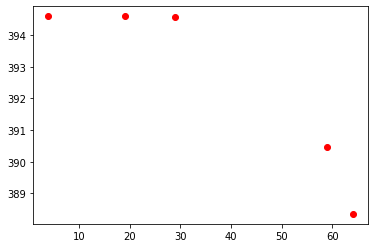

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  260
fixed Jt:  0.7
fixed Nf:  400
fixed Bk:  3.8
start Tn:  268
start Jt:  0.72
start Nf:  380
start Bk:  3.82
stepping:  188
Temperature:  [33.]
rewaRD::  -100
stepping:  188
Temperature:  [33. 53.]
rewaRD::  -100
stepping:  188
Temperature:  [33. 53. 68.]
rewaRD::  -100
stepping:  188
Temperature:  [33. 53. 68. 98.]
rewaRD::  -100
stepping:  188
Temperature:  [ 33.  53.  68.  98. 118.]
ORDER PARAM RESULT (X2): 276.4431702669919
THE JT RESULT {X0}: 0.5777207700282737
THE NF RESULT {X1}: 384.2761738445174
THE BK RESULT {X3}: 7.999901128282424
chisqds:  1.0616376763814648


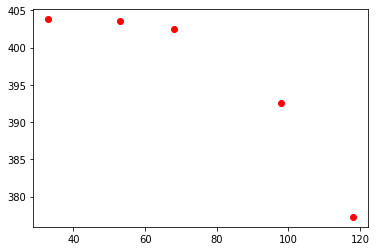

rewaRD::  276.77637945497435
stepping:  188
Temperature:  [ 33.  53.  68.  98. 118. 148.]
ORDER PARAM RESULT (X2): 270.88514306294104
THE JT RESULT {X0}: 0.6413162606874008
THE NF RESULT {X1}: 384.4615450116358
THE BK RESULT {X3}: 7.999544189304534
chisqds:  0.5825656956029719


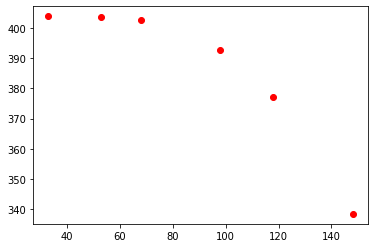

rewaRD::  300
stepping:  188
Temperature:  [ 33.  53.  68.  98. 118. 148. 149.]
ORDER PARAM RESULT (X2): 270.4129412403714
THE JT RESULT {X0}: 0.6533736924359125
THE NF RESULT {X1}: 384.59273805522116
THE BK RESULT {X3}: 7.99970738845369
chisqds:  0.3869207961587858


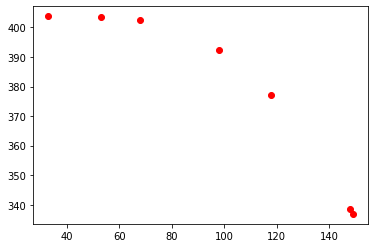

rewaRD::  300
stepping:  188
Temperature:  [ 33.  53.  68.  98. 118. 148. 149. 164.]
ORDER PARAM RESULT (X2): 269.3140322744949
THE JT RESULT {X0}: 0.6710897768202738
THE NF RESULT {X1}: 384.8289757952612
THE BK RESULT {X3}: 7.999320708904535
chisqds:  0.29910227907055553


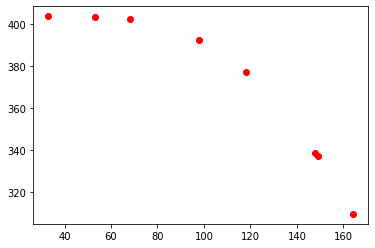

rewaRD::  300
stepping:  188
Temperature:  [ 33.  53.  68.  98. 118. 148. 149. 164. 165.]
ORDER PARAM RESULT (X2): 268.837241517655
THE JT RESULT {X0}: 0.6812585859050816
THE NF RESULT {X1}: 385.0389798203609
THE BK RESULT {X3}: 7.999728275274756
chisqds:  0.24015221753589494


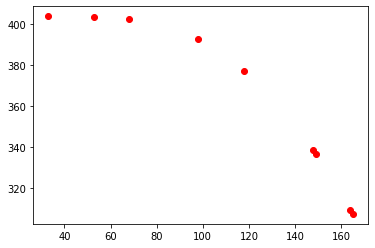

rewaRD::  300
stepping:  188
Temperature:  [ 33.  53.  68.  98. 118. 148. 149. 164. 165. 170.]
ORDER PARAM RESULT (X2): 268.3660419022359
THE JT RESULT {X0}: 0.690932383968118
THE NF RESULT {X1}: 385.2634047244152
THE BK RESULT {X3}: 7.999543404430613
chisqds:  0.20177258798695516


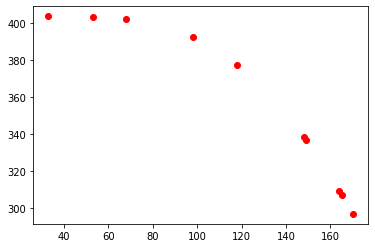

rewaRD::  300
stepping:  188
Temperature:  [ 33.  53.  68.  98. 118. 148. 149. 164. 165. 170. 175.]
ORDER PARAM RESULT (X2): 267.86634838494405
THE JT RESULT {X0}: 0.7010109334163644
THE NF RESULT {X1}: 385.54983600520274
THE BK RESULT {X3}: 7.999922388319155
chisqds:  0.17363883888990353


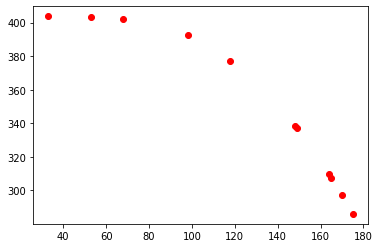

rewaRD::  300
stepping:  188
Temperature:  [ 33.  53.  68.  98. 118. 148. 149. 164. 165. 170. 175. 180.]
ORDER PARAM RESULT (X2): 267.3426727341638
THE JT RESULT {X0}: 0.7114548264574808
THE NF RESULT {X1}: 385.8966373732516
THE BK RESULT {X3}: 7.99973080635942
chisqds:  0.15187914704702535


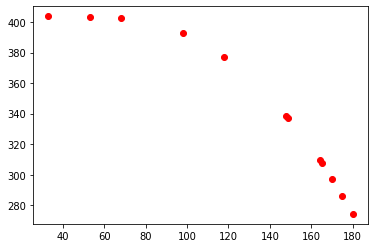

rewaRD::  300
stepping:  188
Temperature:  [ 33.  53.  68.  98. 118. 148. 149. 164. 165. 170. 175. 180. 210.]
ORDER PARAM RESULT (X2): 260.0000000001334
THE JT RESULT {X0}: 0.7000000000005753
THE NF RESULT {X1}: 400.0000000005195
THE BK RESULT {X3}: 3.7999999994807583
chisqds:  2.2957153003634476e-24


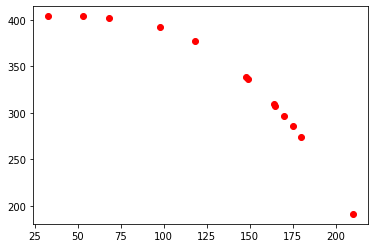

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  270
fixed Jt:  1.2
fixed Nf:  410
fixed Bk:  3.2
start Tn:  286
start Jt:  1.36
start Nf:  414
start Bk:  3.18
stepping:  189
Temperature:  [4.]
rewaRD::  -100
stepping:  189
Temperature:  [4. 5.]
rewaRD::  -100
stepping:  189
Temperature:  [ 4.  5. 30.]
rewaRD::  -100
stepping:  189
Temperature:  [ 4.  5. 30. 50.]
rewaRD::  -100
stepping:  189
Temperature:  [ 4.  5. 30. 50. 75.]
ORDER PARAM RESULT (X2): 270.00000016451867
THE JT RESULT {X0}: 1.2000000013124346
THE NF RESULT {X1}: 410.0000004873409
THE BK RESULT {X3}: 3.1999995126590557
chisqds:  1.3430244761318076e-25


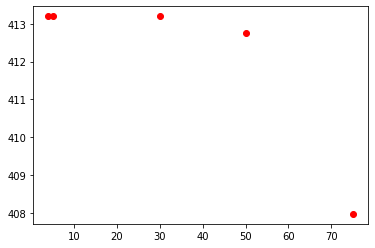

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  110
fixed Jt:  1.3
fixed Nf:  370
fixed Bk:  6.8
start Tn:  110
start Jt:  1.0
start Nf:  378
start Bk:  6.9
stepping:  190
Temperature:  [13.]
rewaRD::  -100
stepping:  190
Temperature:  [13. 23.]
rewaRD::  -100
stepping:  190
Temperature:  [13. 23. 24.]
rewaRD::  -100
stepping:  190
Temperature:  [13. 23. 24. 54.]
rewaRD::  -100
stepping:  190
Temperature:  [13. 23. 24. 54. 69.]
ORDER PARAM RESULT (X2): 110.00000000003297
THE JT RESULT {X0}: 1.3000000000003655
THE NF RESULT {X1}: 370.00000000023994
THE BK RESULT {X3}: 6.799999999760035
chisqds:  6.442684790990266e-25


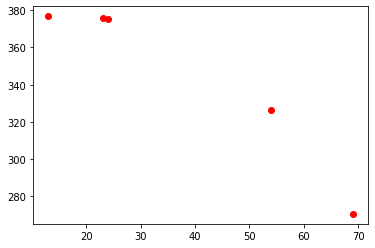

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  190
fixed Jt:  0.9
fixed Nf:  410
fixed Bk:  6.6
start Tn:  190
start Jt:  1.08
start Nf:  414
start Bk:  6.48
stepping:  191
Temperature:  [13.]
rewaRD::  -100
stepping:  191
Temperature:  [13. 18.]
rewaRD::  -100
stepping:  191
Temperature:  [13. 18. 28.]
rewaRD::  -100
stepping:  191
Temperature:  [13. 18. 28. 53.]
rewaRD::  -100
stepping:  191
Temperature:  [13. 18. 28. 53. 78.]
ORDER PARAM RESULT (X2): 189.99999999870394
THE JT RESULT {X0}: 0.8999999999874005
THE NF RESULT {X1}: 409.99999999327923
THE BK RESULT {X3}: 6.600000006720561
chisqds:  2.964992107042838e-25


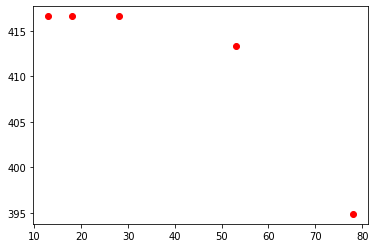

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  140
fixed Jt:  0.9
fixed Nf:  450
fixed Bk:  5.0
start Tn:  150
start Jt:  1.16
start Nf:  448
start Bk:  5.02
stepping:  192
Temperature:  [33.]
rewaRD::  -100
stepping:  192
Temperature:  [33. 38.]
rewaRD::  -100
stepping:  192
Temperature:  [33. 38. 53.]
rewaRD::  -100
stepping:  192
Temperature:  [33. 38. 53. 73.]
rewaRD::  -100
stepping:  192
Temperature:  [ 33.  38.  53.  73. 103.]
ORDER PARAM RESULT (X2): 139.99999999999693
THE JT RESULT {X0}: 0.8999999999999805
THE NF RESULT {X1}: 449.9999999999775
THE BK RESULT {X3}: 5.0000000000223
chisqds:  2.853921492047614e-26


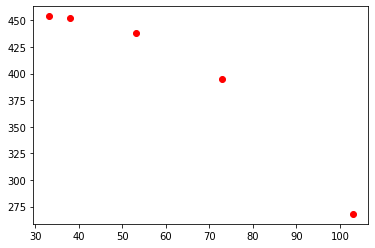

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  200
fixed Jt:  1.1
fixed Nf:  200
fixed Bk:  3.6
start Tn:  206
start Jt:  1.26
start Nf:  190
start Bk:  3.44
stepping:  193
Temperature:  [8.]
rewaRD::  -100
stepping:  193
Temperature:  [8. 9.]
rewaRD::  -100
stepping:  193
Temperature:  [ 8.  9. 29.]
rewaRD::  -100
stepping:  193
Temperature:  [ 8.  9. 29. 34.]
rewaRD::  -100
stepping:  193
Temperature:  [ 8.  9. 29. 34. 44.]
ORDER PARAM RESULT (X2): 245.62330736607476
THE JT RESULT {X0}: 0.47376226764436746
THE NF RESULT {X1}: 194.55996587861839
THE BK RESULT {X3}: 7.999208162872788
chisqds:  0.021498062393353883


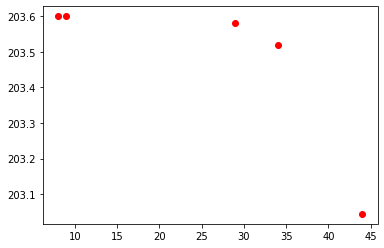

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  80
fixed Jt:  1.4
fixed Nf:  270
fixed Bk:  3.8
start Tn:  92
start Jt:  1.28
start Nf:  268
start Bk:  3.98
stepping:  194
Temperature:  [28.]
rewaRD::  -100
stepping:  194
Temperature:  [28. 53.]
rewaRD::  -100
stepping:  194
Temperature:  [28. 53. 78.]
rewaRD::  -100
stepping:  194
Temperature:  [28. 53. 78. 93.]
rewaRD::  -100
stepping:  194
Temperature:  [ 28.  53.  78.  93. 123.]
ORDER PARAM RESULT (X2): 80.00000000000004
THE JT RESULT {X0}: 1.3999999999999921
THE NF RESULT {X1}: 269.99999999999994
THE BK RESULT {X3}: 3.8
chisqds:  9.453340503827564e-28


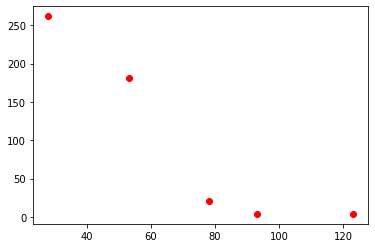

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  90
fixed Jt:  0.7
fixed Nf:  260
fixed Bk:  5.4
start Tn:  74
start Jt:  0.56
start Nf:  264
start Bk:  5.52
stepping:  195
Temperature:  [4.]
rewaRD::  -100
stepping:  195
Temperature:  [4. 9.]
rewaRD::  -100
stepping:  195
Temperature:  [ 4.  9. 10.]
rewaRD::  -100
stepping:  195
Temperature:  [ 4.  9. 10. 25.]
rewaRD::  -100
stepping:  195
Temperature:  [ 4.  9. 10. 25. 30.]
ORDER PARAM RESULT (X2): 90.00000030648539
THE JT RESULT {X0}: 0.7000000055865897
THE NF RESULT {X1}: 260.00000230010676
THE BK RESULT {X3}: 5.399997699893331
chisqds:  6.451966778187488e-27


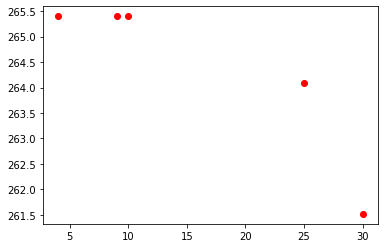

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  60
fixed Jt:  0.7
fixed Nf:  400
fixed Bk:  4.6
start Tn:  72
start Jt:  0.58
start Nf:  394
start Bk:  4.51
stepping:  196
Temperature:  [28.]
rewaRD::  -100
stepping:  196
Temperature:  [28. 53.]
rewaRD::  -100
stepping:  196
Temperature:  [28. 53. 83.]
rewaRD::  -100
stepping:  196
Temperature:  [28. 53. 83. 93.]
rewaRD::  -100
stepping:  196
Temperature:  [ 28.  53.  83.  93. 118.]
ORDER PARAM RESULT (X2): 60.643819901495526
THE JT RESULT {X0}: 1.324294580576644
THE NF RESULT {X1}: 417.3954466329113
THE BK RESULT {X3}: 4.6
chisqds:  1.265394569175282e-27


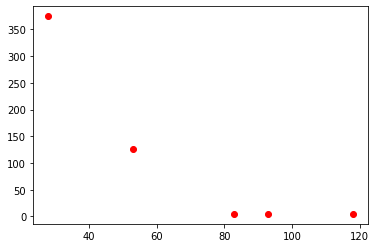

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  130
fixed Jt:  1.4
fixed Nf:  450
fixed Bk:  4.6
start Tn:  124
start Jt:  1.64
start Nf:  444
start Bk:  4.65
stepping:  197
Temperature:  [23.]
rewaRD::  -100
stepping:  197
Temperature:  [23. 53.]
rewaRD::  -100
stepping:  197
Temperature:  [23. 53. 73.]
rewaRD::  -100
stepping:  197
Temperature:  [23. 53. 73. 88.]
rewaRD::  -100
stepping:  197
Temperature:  [ 23.  53.  73.  88. 103.]
ORDER PARAM RESULT (X2): 125.01711405252766
THE JT RESULT {X0}: 1.4863971854886846
THE NF RESULT {X1}: 447.62546957517793
THE BK RESULT {X3}: 7.999284697462494
chisqds:  5.071663000878311


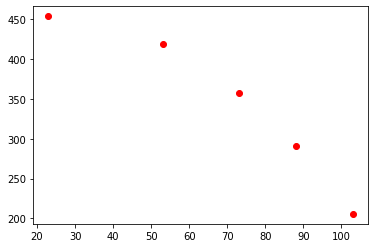

rewaRD::  -21.130406351776926
stepping:  197
Temperature:  [ 23.  53.  73.  88. 103. 108.]
ORDER PARAM RESULT (X2): 124.81702286573783
THE JT RESULT {X0}: 1.4846525916458027
THE NF RESULT {X1}: 447.82553719616084
THE BK RESULT {X3}: 7.999658574996792
chisqds:  5.284748992679063


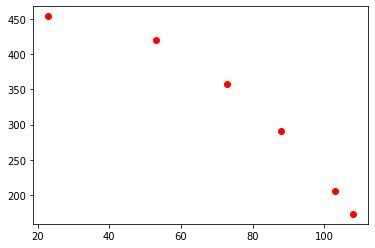

rewaRD::  -24.31050168056835
stepping:  197
Temperature:  [ 23.  53.  73.  88. 103. 108. 113.]
ORDER PARAM RESULT (X2): 124.69493002906457
THE JT RESULT {X0}: 1.4803485358936892
THE NF RESULT {X1}: 448.00053944875623
THE BK RESULT {X3}: 7.999664842743277
chisqds:  6.351547878246156


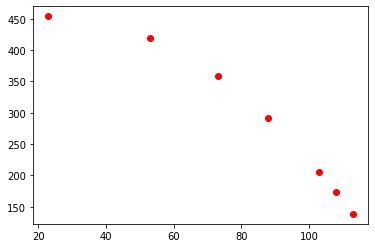

rewaRD::  -37.02322525663595
stepping:  197
Temperature:  [ 23.  53.  73.  88. 103. 108. 113. 133.]
ORDER PARAM RESULT (X2): 129.99999999999312
THE JT RESULT {X0}: 1.400000000000003
THE NF RESULT {X1}: 449.99999999999955
THE BK RESULT {X3}: 4.6
chisqds:  7.706582783744809e-24


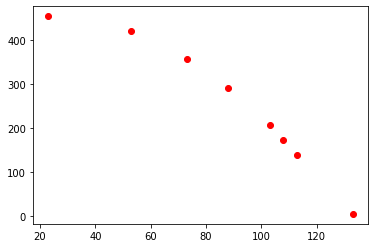

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  180
fixed Jt:  0.8
fixed Nf:  420
fixed Bk:  4.4
start Tn:  198
start Jt:  0.9
start Nf:  420
start Bk:  4.46
stepping:  198
Temperature:  [23.]
rewaRD::  -100
stepping:  198
Temperature:  [23. 24.]
rewaRD::  -100
stepping:  198
Temperature:  [23. 24. 44.]
rewaRD::  -100
stepping:  198
Temperature:  [23. 24. 44. 54.]
rewaRD::  -100
stepping:  198
Temperature:  [23. 24. 44. 54. 79.]
ORDER PARAM RESULT (X2): 180.00000000034498
THE JT RESULT {X0}: 0.8000000000031923
THE NF RESULT {X1}: 420.00000000207484
THE BK RESULT {X3}: 4.39999999792534
chisqds:  1.793180471942328e-27


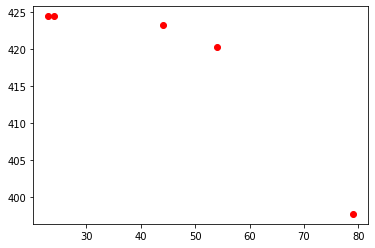

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  210
fixed Jt:  0.7
fixed Nf:  320
fixed Bk:  3.4
start Tn:  228
start Jt:  0.9
start Nf:  324
start Bk:  3.26
stepping:  199
Temperature:  [18.]
rewaRD::  -100
stepping:  199
Temperature:  [18. 43.]
rewaRD::  -100
stepping:  199
Temperature:  [18. 43. 58.]
rewaRD::  -100
stepping:  199
Temperature:  [18. 43. 58. 88.]
rewaRD::  -100
stepping:  199
Temperature:  [18. 43. 58. 88. 93.]
ORDER PARAM RESULT (X2): 209.9999999997516
THE JT RESULT {X0}: 0.6999999999983484
THE NF RESULT {X1}: 319.9999999989908
THE BK RESULT {X3}: 3.400000001009237
chisqds:  1.6192638224693493e-25


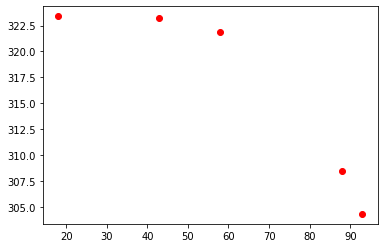

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  100
fixed Jt:  1.1
fixed Nf:  400
fixed Bk:  6.0
start Tn:  110
start Jt:  0.84
start Nf:  388
start Bk:  5.96
stepping:  200
Temperature:  [33.]
rewaRD::  -100
stepping:  200
Temperature:  [33. 48.]
rewaRD::  -100
stepping:  200
Temperature:  [33. 48. 58.]
rewaRD::  -100
stepping:  200
Temperature:  [33. 48. 58. 73.]
rewaRD::  -100
stepping:  200
Temperature:  [33. 48. 58. 73. 83.]
ORDER PARAM RESULT (X2): 107.28157968868025
THE JT RESULT {X0}: 1.0582903172067335
THE NF RESULT {X1}: 382.93165016793233
THE BK RESULT {X3}: 0.10000246569987785
chisqds:  7.761097803399153


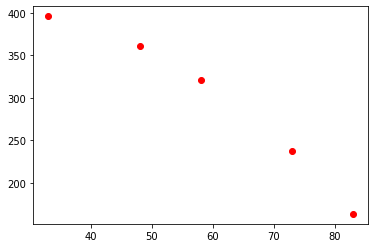

rewaRD::  -48.460899458732406
stepping:  200
Temperature:  [33. 48. 58. 73. 83. 84.]
ORDER PARAM RESULT (X2): 107.96245096663651
THE JT RESULT {X0}: 1.0341059076017955
THE NF RESULT {X1}: 382.04286931237954
THE BK RESULT {X3}: 0.1000131993341257
chisqds:  8.789339165216976


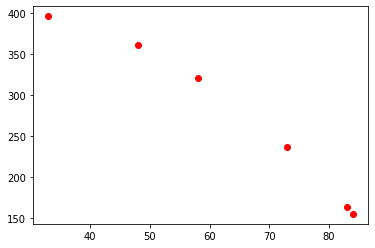

rewaRD::  -54.49032145864114
stepping:  200
Temperature:  [33. 48. 58. 73. 83. 84. 85.]
ORDER PARAM RESULT (X2): 108.2545946923106
THE JT RESULT {X0}: 1.022987827984822
THE NF RESULT {X1}: 381.4056069905618
THE BK RESULT {X3}: 0.10000275700042793
chisqds:  9.714383809882982


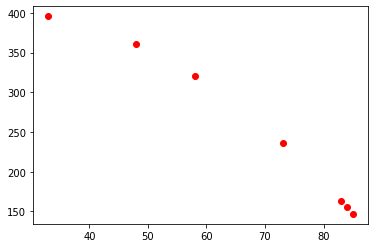

rewaRD::  -58.823945210703144
stepping:  200
Temperature:  [33. 48. 58. 73. 83. 84. 85. 86.]
ORDER PARAM RESULT (X2): 108.41223995424684
THE JT RESULT {X0}: 1.0179599359694989
THE NF RESULT {X1}: 380.91853106622307
THE BK RESULT {X3}: 0.10000450620920386
chisqds:  10.593429123963213


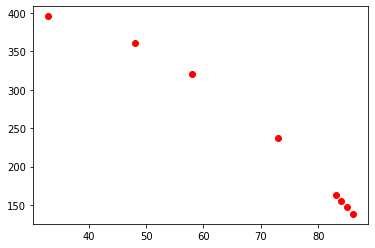

rewaRD::  -62.240744208580495
stepping:  200
Temperature:  [ 33.  48.  58.  73.  83.  84.  85.  86. 111.]
ORDER PARAM RESULT (X2): 99.9999999998816
THE JT RESULT {X0}: 1.1000000000011703
THE NF RESULT {X1}: 399.9999999999966
THE BK RESULT {X3}: 6.0
chisqds:  4.343115223773873e-21


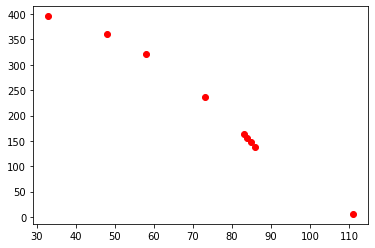

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  150
fixed Jt:  0.7
fixed Nf:  390
fixed Bk:  6.2
start Tn:  150
start Jt:  0.8
start Nf:  396
start Bk:  6.16
stepping:  201
Temperature:  [23.]
rewaRD::  -100
stepping:  201
Temperature:  [23. 43.]
rewaRD::  -100
stepping:  201
Temperature:  [23. 43. 48.]
rewaRD::  -100
stepping:  201
Temperature:  [23. 43. 48. 78.]
rewaRD::  -100
stepping:  201
Temperature:  [23. 43. 48. 78. 93.]
ORDER PARAM RESULT (X2): 150.00000000012565
THE JT RESULT {X0}: 0.7000000000010588
THE NF RESULT {X1}: 390.0000000008775
THE BK RESULT {X3}: 6.199999999122597
chisqds:  1.3133836414984636e-24


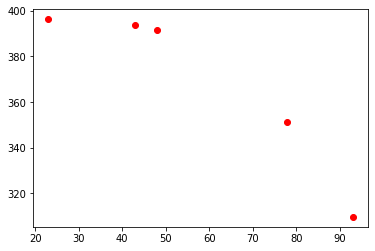

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  60
fixed Jt:  1.3
fixed Nf:  250
fixed Bk:  7.0
start Tn:  70
start Jt:  1.22
start Nf:  252
start Bk:  7.0
stepping:  202
Temperature:  [4.]
rewaRD::  -100
stepping:  202
Temperature:  [ 4. 24.]
rewaRD::  -100
stepping:  202
Temperature:  [ 4. 24. 34.]
rewaRD::  -100
stepping:  202
Temperature:  [ 4. 24. 34. 64.]
rewaRD::  -100
stepping:  202
Temperature:  [ 4. 24. 34. 64. 84.]
ORDER PARAM RESULT (X2): 60.00000000000004
THE JT RESULT {X0}: 1.3000000000000507
THE NF RESULT {X1}: 250.00000000000003
THE BK RESULT {X3}: 7.0
chisqds:  3.9134931270023775e-27


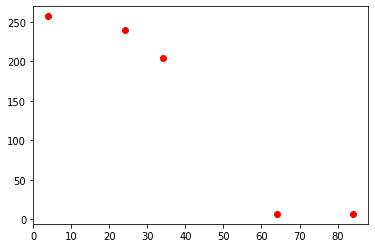

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  120
fixed Jt:  1.3
fixed Nf:  380
fixed Bk:  5.0
start Tn:  106
start Jt:  1.08
start Nf:  386
start Bk:  4.82
stepping:  203
Temperature:  [23.]
rewaRD::  -100
stepping:  203
Temperature:  [23. 24.]
rewaRD::  -100
stepping:  203
Temperature:  [23. 24. 49.]
rewaRD::  -100
stepping:  203
Temperature:  [23. 24. 49. 69.]
rewaRD::  -100
--------------------------------------
| approxkl           | 8.695619e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 5.75          |
| ep_reward_mean     | 3.51          |
| explained_variance | 0.000763      |
| fps                | 4             |
| n_updates          | 12            |
| policy_entropy     | 1.9414877     |
| policy_loss        | -0.0003893748 |
| serial_timesteps   | 1536          |
| time_elapsed       | 235           |
| total_timesteps    | 1536          |
| value_loss         | 124773.59     |
--------------------------------------
stepping:  203
T

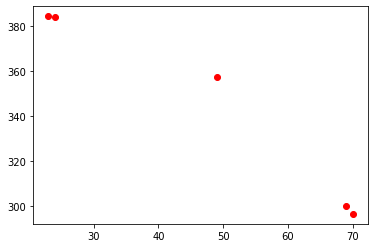

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  160
fixed Jt:  0.9
fixed Nf:  460
fixed Bk:  5.0
start Tn:  144
start Jt:  0.74
start Nf:  450
start Bk:  4.84
stepping:  204
Temperature:  [33.]
rewaRD::  -100
stepping:  204
Temperature:  [33. 38.]
rewaRD::  -100
stepping:  204
Temperature:  [33. 38. 53.]
rewaRD::  -100
stepping:  204
Temperature:  [33. 38. 53. 58.]
rewaRD::  -100
stepping:  204
Temperature:  [33. 38. 53. 58. 83.]
ORDER PARAM RESULT (X2): 147.1719502491024
THE JT RESULT {X0}: 0.603569092421232
THE NF RESULT {X1}: 453.20140126770474
THE BK RESULT {X3}: 7.999228530571432
chisqds:  0.382707773831128


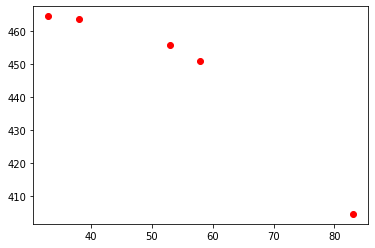

rewaRD::  300
stepping:  204
Temperature:  [ 33.  38.  53.  58.  83. 108.]
ORDER PARAM RESULT (X2): 146.00810868075
THE JT RESULT {X0}: 0.6091499126580451
THE NF RESULT {X1}: 452.8924100558833
THE BK RESULT {X3}: 7.999217031348308
chisqds:  2.2481952021396436


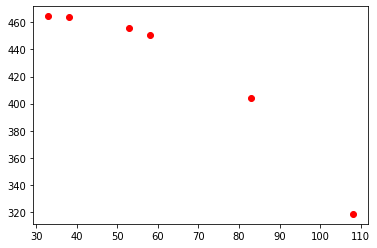

rewaRD::  77.92049356715714
stepping:  204
Temperature:  [ 33.  38.  53.  58.  83. 108. 118.]
ORDER PARAM RESULT (X2): 145.50212037269011
THE JT RESULT {X0}: 0.6114517651933904
THE NF RESULT {X1}: 453.20664954293323
THE BK RESULT {X3}: 7.999280952940093
chisqds:  4.868177536129613


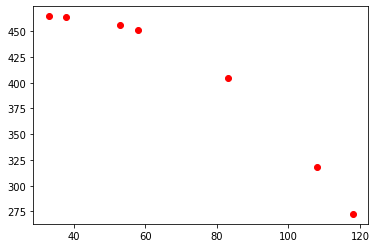

rewaRD::  -17.833727913297253
stepping:  204
Temperature:  [ 33.  38.  53.  58.  83. 108. 118. 128.]
ORDER PARAM RESULT (X2): 144.98387991281848
THE JT RESULT {X0}: 0.6338876141766276
THE NF RESULT {X1}: 452.7361857414998
THE BK RESULT {X3}: 7.999285143091991
chisqds:  10.200939358242278


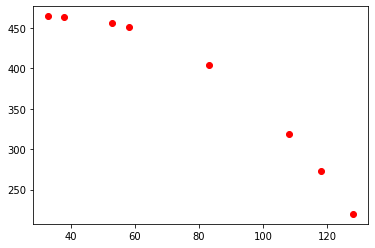

rewaRD::  -60.78792492018854
stepping:  204
Temperature:  [ 33.  38.  53.  58.  83. 108. 118. 128. 158.]
ORDER PARAM RESULT (X2): 145.68420262889853
THE JT RESULT {X0}: 0.5627180807065326
THE NF RESULT {X1}: 454.44773343445985
THE BK RESULT {X3}: 7.999347538012783
chisqds:  7.7326781287951745


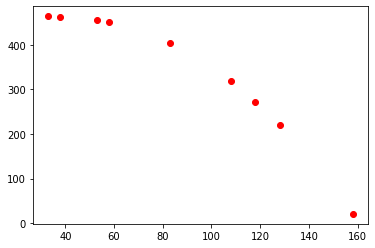

rewaRD::  -48.27147938429401
stepping:  204
Temperature:  [ 33.  38.  53.  58.  83. 108. 118. 128. 158. 183.]
ORDER PARAM RESULT (X2): 147.46299708390663
THE JT RESULT {X0}: 0.4000000448058784
THE NF RESULT {X1}: 457.82724030357485
THE BK RESULT {X3}: 6.475125236607423
chisqds:  4.1112462129368845


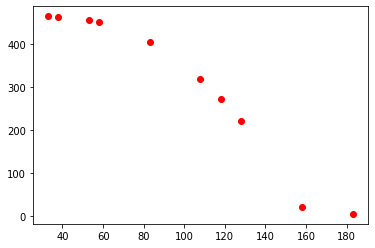

rewaRD::  -2.7059000404019855
stepping:  204
Temperature:  [ 33.  38.  53.  58.  83. 108. 118. 128. 158. 183. 193.]
ORDER PARAM RESULT (X2): 160.0000000000013
THE JT RESULT {X0}: 0.9000000000001412
THE NF RESULT {X1}: 460.00000000000114
THE BK RESULT {X3}: 5.0
chisqds:  1.489515917503644e-25


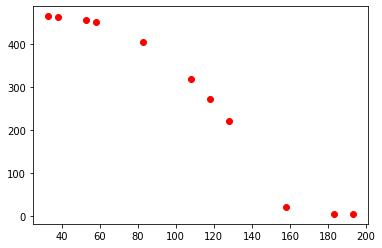

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  210
fixed Jt:  0.8
fixed Nf:  320
fixed Bk:  4.6
start Tn:  190
start Jt:  0.52
start Nf:  308
start Bk:  4.65
stepping:  205
Temperature:  [18.]
rewaRD::  -100
stepping:  205
Temperature:  [18. 19.]
rewaRD::  -100
stepping:  205
Temperature:  [18. 19. 24.]
rewaRD::  -100
stepping:  205
Temperature:  [18. 19. 24. 39.]
rewaRD::  -100
stepping:  205
Temperature:  [18. 19. 24. 39. 40.]
ORDER PARAM RESULT (X2): 199.92486133276648
THE JT RESULT {X0}: 0.4000117183307879
THE NF RESULT {X1}: 308.0690969471425
THE BK RESULT {X3}: 4.7190918059543625
chisqds:  2.1371847544714484


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


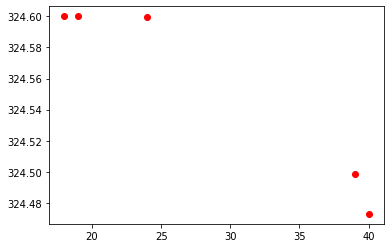

rewaRD::  87.16210620682853
stepping:  205
Temperature:  [18. 19. 24. 39. 40. 60.]
ORDER PARAM RESULT (X2): 197.70532117580697
THE JT RESULT {X0}: 0.4000006634046688
THE NF RESULT {X1}: 308.6765758754067
THE BK RESULT {X3}: 5.325753879005118
chisqds:  1.001033996259354


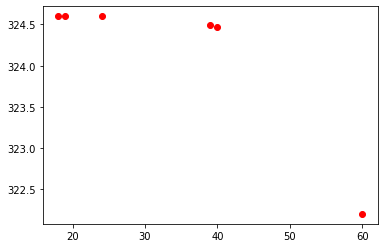

rewaRD::  299.5868287138228
stepping:  205
Temperature:  [18. 19. 24. 39. 40. 60. 65.]
ORDER PARAM RESULT (X2): 197.3697118050891
THE JT RESULT {X0}: 0.40000010511285156
THE NF RESULT {X1}: 308.89696433199725
THE BK RESULT {X3}: 5.544580931310004
chisqds:  0.6912970425424404


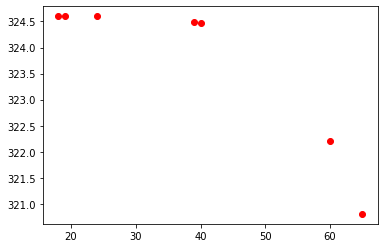

rewaRD::  300
stepping:  205
Temperature:  [18. 19. 24. 39. 40. 60. 65. 85.]
ORDER PARAM RESULT (X2): 195.3544202414911
THE JT RESULT {X0}: 0.40000011046392014
THE NF RESULT {X1}: 309.925609690141
THE BK RESULT {X3}: 6.558846017049711
chisqds:  0.354124654384776


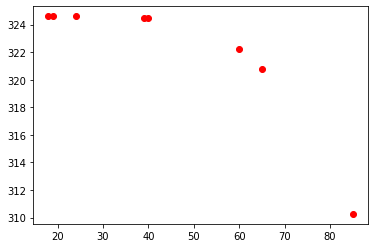

rewaRD::  300
stepping:  205
Temperature:  [ 18.  19.  24.  39.  40.  60.  65.  85. 100.]
ORDER PARAM RESULT (X2): 194.4129817550065
THE JT RESULT {X0}: 0.4000002325552216
THE NF RESULT {X1}: 310.7005323416018
THE BK RESULT {X3}: 7.296131543015046
chisqds:  0.20165307209495334


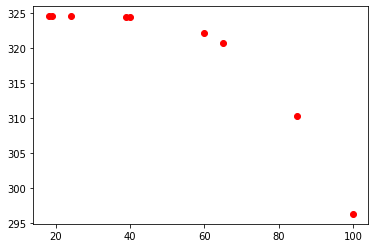

rewaRD::  300
stepping:  205
Temperature:  [ 18.  19.  24.  39.  40.  60.  65.  85. 100. 130.]
ORDER PARAM RESULT (X2): 192.89846416330198
THE JT RESULT {X0}: 0.40000020360131905
THE NF RESULT {X1}: 310.4585993976114
THE BK RESULT {X3}: 7.079974614407579
chisqds:  0.34316512532677684


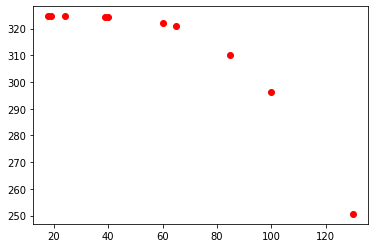

rewaRD::  300
stepping:  205
Temperature:  [ 18.  19.  24.  39.  40.  60.  65.  85. 100. 130. 131.]
ORDER PARAM RESULT (X2): 192.68894472835584
THE JT RESULT {X0}: 0.4000004287380331
THE NF RESULT {X1}: 310.58284924773864
THE BK RESULT {X3}: 7.194415215338207
chisqds:  0.41425389443072874


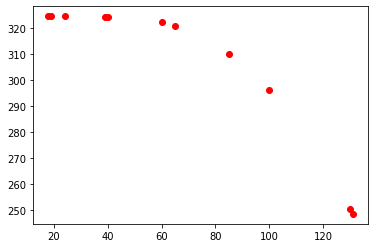

rewaRD::  300
stepping:  205
Temperature:  [ 18.  19.  24.  39.  40.  60.  65.  85. 100. 130. 131. 161.]
ORDER PARAM RESULT (X2): 192.08048116550455
THE JT RESULT {X0}: 0.40000039581882496
THE NF RESULT {X1}: 310.1635678220803
THE BK RESULT {X3}: 7.04348893023674
chisqds:  1.3564637548356118


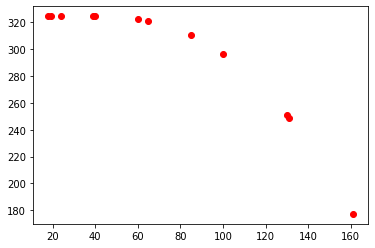

rewaRD::  194.88439965613054
stepping:  205
Temperature:  [ 18.  19.  24.  39.  40.  60.  65.  85. 100. 130. 131. 161. 162.]
ORDER PARAM RESULT (X2): 191.69171287157286
THE JT RESULT {X0}: 0.40000102408362426
THE NF RESULT {X1}: 310.17609469836844
THE BK RESULT {X3}: 7.07149134277568
chisqds:  2.20371166097138


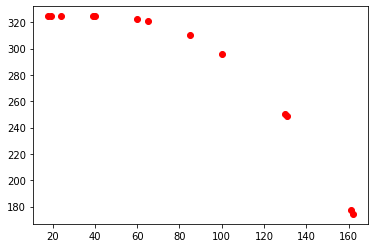

rewaRD::  81.51194962760368
stepping:  205
Temperature:  [ 18.  19.  24.  39.  40.  60.  65.  85. 100. 130. 131. 161. 162. 172.]
ORDER PARAM RESULT (X2): 191.4544621468179
THE JT RESULT {X0}: 0.40000048922729886
THE NF RESULT {X1}: 310.0872813433027
THE BK RESULT {X3}: 7.1194176652867975
chisqds:  3.6859116663936673


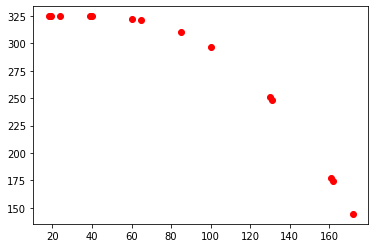

rewaRD::  8.521320151810357
stepping:  205
Temperature:  [ 18.  19.  24.  39.  40.  60.  65.  85. 100. 130. 131. 161. 162. 172.
 187.]
ORDER PARAM RESULT (X2): 191.38674041804592
THE JT RESULT {X0}: 0.40000058783473946
THE NF RESULT {X1}: 309.9727122383688
THE BK RESULT {X3}: 7.610852832399218
chisqds:  7.40380338766733


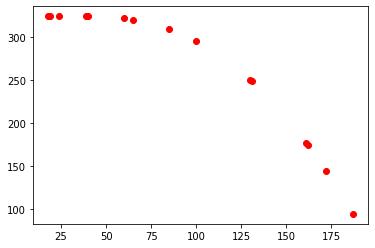

rewaRD::  -45.973713906788994
stepping:  205
Temperature:  [ 18.  19.  24.  39.  40.  60.  65.  85. 100. 130. 131. 161. 162. 172.
 187. 188.]
ORDER PARAM RESULT (X2): 191.32100582056904
THE JT RESULT {X0}: 0.4000002761951565
THE NF RESULT {X1}: 309.90445749217827
THE BK RESULT {X3}: 7.94495448973416
chisqds:  10.820408109968241


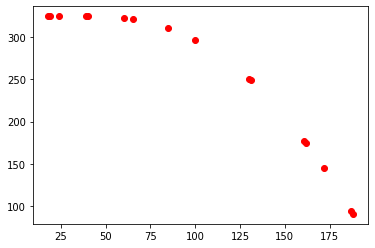

rewaRD::  -63.03281762251627
stepping:  205
Temperature:  [ 18.  19.  24.  39.  40.  60.  65.  85. 100. 130. 131. 161. 162. 172.
 187. 188. 203.]
ORDER PARAM RESULT (X2): 191.34948047306344
THE JT RESULT {X0}: 0.40000013697159614
THE NF RESULT {X1}: 309.888925957254
THE BK RESULT {X3}: 7.7697448862609875
chisqds:  11.54036249395426


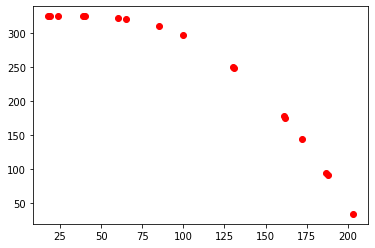

rewaRD::  -65.33904370772139
stepping:  205
Temperature:  [ 18.  19.  24.  39.  40.  60.  65.  85. 100. 130. 131. 161. 162. 172.
 187. 188. 203. 223.]
ORDER PARAM RESULT (X2): 191.34676978036777
THE JT RESULT {X0}: 0.4000001638706183
THE NF RESULT {X1}: 309.9712588387597
THE BK RESULT {X3}: 5.628809209575151
chisqds:  11.767118568532519


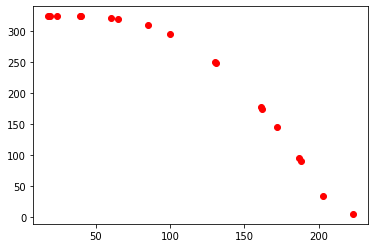

rewaRD::  -66.0069712334101
stepping:  205
Temperature:  [ 18.  19.  24.  39.  40.  60.  65.  85. 100. 130. 131. 161. 162. 172.
 187. 188. 203. 223. 253.]
ORDER PARAM RESULT (X2): 209.99999999999338
THE JT RESULT {X0}: 0.8000000000000437
THE NF RESULT {X1}: 319.99999999999994
THE BK RESULT {X3}: 4.6
chisqds:  2.4716700077878893e-24


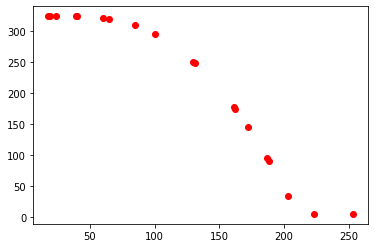

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  150
fixed Jt:  1.1
fixed Nf:  270
fixed Bk:  3.8
start Tn:  136
start Jt:  1.0
start Nf:  282
start Bk:  3.98
stepping:  206
Temperature:  [18.]
rewaRD::  -100
stepping:  206
Temperature:  [18. 23.]
rewaRD::  -100
stepping:  206
Temperature:  [18. 23. 38.]
rewaRD::  -100
stepping:  206
Temperature:  [18. 23. 38. 58.]
rewaRD::  -100
stepping:  206
Temperature:  [18. 23. 38. 58. 78.]
ORDER PARAM RESULT (X2): 139.01925065869807
THE JT RESULT {X0}: 0.9032600384864955
THE NF RESULT {X1}: 277.40890559250806
THE BK RESULT {X3}: 0.10000521107724104
chisqds:  0.23369676211390228


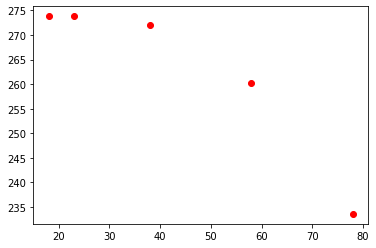

rewaRD::  300
stepping:  206
Temperature:  [18. 23. 38. 58. 78. 93.]
ORDER PARAM RESULT (X2): 141.3560114165996
THE JT RESULT {X0}: 0.7625566710883629
THE NF RESULT {X1}: 275.8022287545562
THE BK RESULT {X3}: 0.10000216004279683
chisqds:  0.09796891568159016


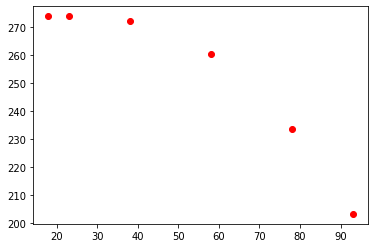

rewaRD::  300
stepping:  206
Temperature:  [ 18.  23.  38.  58.  78.  93. 103.]
ORDER PARAM RESULT (X2): 149.99999999975077
THE JT RESULT {X0}: 1.099999999998353
THE NF RESULT {X1}: 269.9999999990632
THE BK RESULT {X3}: 3.800000000936608
chisqds:  3.0525853168696134e-23


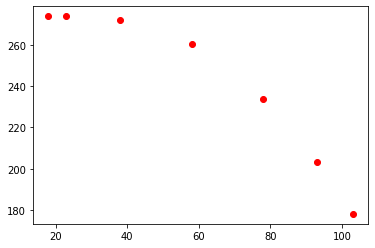

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  230
fixed Jt:  1.1
fixed Nf:  390
fixed Bk:  4.0
start Tn:  244
start Jt:  1.32
start Nf:  380
start Bk:  4.14
stepping:  207
Temperature:  [28.]
rewaRD::  -100
stepping:  207
Temperature:  [28. 48.]
rewaRD::  -100
stepping:  207
Temperature:  [28. 48. 63.]
rewaRD::  -100
stepping:  207
Temperature:  [28. 48. 63. 93.]
rewaRD::  -100
stepping:  207
Temperature:  [28. 48. 63. 93. 94.]
ORDER PARAM RESULT (X2): 245.64965202656123
THE JT RESULT {X0}: 1.2710054937923274
THE NF RESULT {X1}: 384.0606835645294
THE BK RESULT {X3}: 7.999909682130432
chisqds:  0.029131848225863698


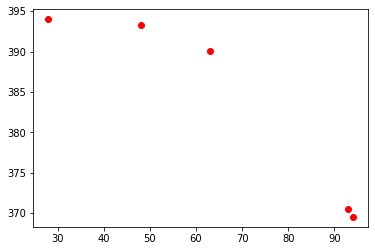

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  150
fixed Jt:  1.0
fixed Nf:  320
fixed Bk:  5.0
start Tn:  144
start Jt:  1.1
start Nf:  310
start Bk:  5.12
stepping:  208
Temperature:  [13.]
rewaRD::  -100
stepping:  208
Temperature:  [13. 28.]
rewaRD::  -100
stepping:  208
Temperature:  [13. 28. 58.]
rewaRD::  -100
stepping:  208
Temperature:  [13. 28. 58. 78.]
rewaRD::  -100
stepping:  208
Temperature:  [ 13.  28.  58.  78. 103.]
ORDER PARAM RESULT (X2): 145.95800185458194
THE JT RESULT {X0}: 0.9525960364466928
THE NF RESULT {X1}: 313.0521943060622
THE BK RESULT {X3}: 7.999878800763805
chisqds:  0.7100144203775878


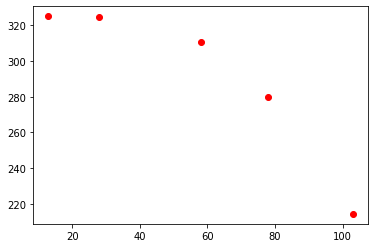

rewaRD::  300
stepping:  208
Temperature:  [ 13.  28.  58.  78. 103. 123.]
ORDER PARAM RESULT (X2): 145.2883118603329
THE JT RESULT {X0}: 0.9492456215587358
THE NF RESULT {X1}: 312.9458568899502
THE BK RESULT {X3}: 7.999318910624372
chisqds:  1.3731689315185833


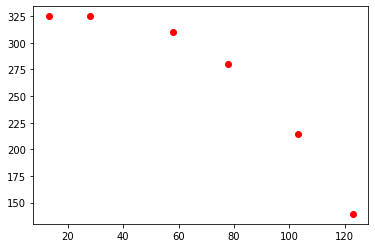

rewaRD::  191.2970071043198
stepping:  208
Temperature:  [ 13.  28.  58.  78. 103. 123. 138.]
ORDER PARAM RESULT (X2): 144.8684042028323
THE JT RESULT {X0}: 0.9563289400082745
THE NF RESULT {X1}: 312.52827728751174
THE BK RESULT {X3}: 7.999312357766611
chisqds:  3.681434548380667


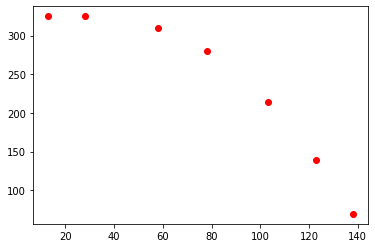

rewaRD::  8.6532966275187
stepping:  208
Temperature:  [ 13.  28.  58.  78. 103. 123. 138. 143.]
ORDER PARAM RESULT (X2): 144.6971615217353
THE JT RESULT {X0}: 0.9718525960238859
THE NF RESULT {X1}: 312.16622914344424
THE BK RESULT {X3}: 7.999739611176421
chisqds:  6.888810649761092


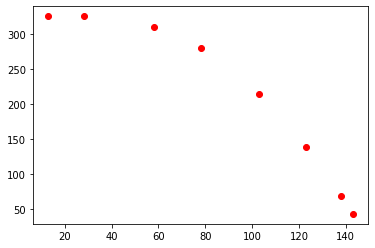

rewaRD::  -41.934824407770265
stepping:  208
Temperature:  [ 13.  28.  58.  78. 103. 123. 138. 143. 148.]
ORDER PARAM RESULT (X2): 144.94719886036123
THE JT RESULT {X0}: 0.9209147011539041
THE NF RESULT {X1}: 313.20460406422643
THE BK RESULT {X3}: 7.9993294177505625
chisqds:  5.516095897618646


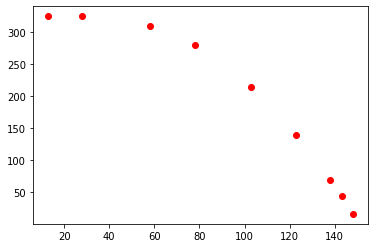

rewaRD::  -27.484944528849837
stepping:  208
Temperature:  [ 13.  28.  58.  78. 103. 123. 138. 143. 148. 149.]
ORDER PARAM RESULT (X2): 145.39432319967125
THE JT RESULT {X0}: 0.8562422918996018
THE NF RESULT {X1}: 314.23102574710794
THE BK RESULT {X3}: 7.999775155909783
chisqds:  3.7158623060799525


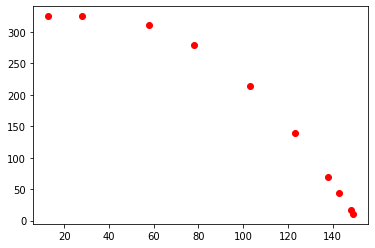

rewaRD::  7.646615254153446
stepping:  208
Temperature:  [ 13.  28.  58.  78. 103. 123. 138. 143. 148. 149. 164.]
ORDER PARAM RESULT (X2): 147.06041376487585
THE JT RESULT {X0}: 0.6840170186112222
THE NF RESULT {X1}: 316.5225896385978
THE BK RESULT {X3}: 7.999597948581875
chisqds:  1.5263567831837932


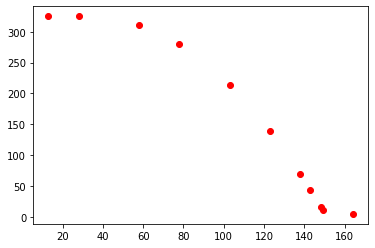

rewaRD::  162.0619270716307
stepping:  208
Temperature:  [ 13.  28.  58.  78. 103. 123. 138. 143. 148. 149. 164. 179.]
ORDER PARAM RESULT (X2): 150.00000000002186
THE JT RESULT {X0}: 1.0000000000000058
THE NF RESULT {X1}: 320.00000000000153
THE BK RESULT {X3}: 5.0
chisqds:  3.6437845728630865e-22


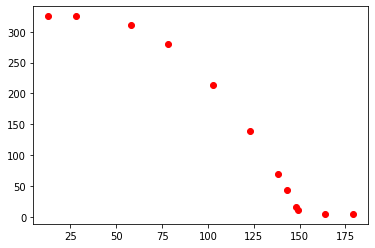

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  190
fixed Jt:  1.2
fixed Nf:  150
fixed Bk:  4.6
start Tn:  192
start Jt:  0.92
start Nf:  164
start Bk:  4.51
stepping:  209
Temperature:  [18.]
rewaRD::  -100
stepping:  209
Temperature:  [18. 38.]
rewaRD::  -100
stepping:  209
Temperature:  [18. 38. 53.]
rewaRD::  -100
stepping:  209
Temperature:  [18. 38. 53. 58.]
rewaRD::  -100
stepping:  209
Temperature:  [18. 38. 53. 58. 83.]
ORDER PARAM RESULT (X2): 176.96742511602005
THE JT RESULT {X0}: 1.3570925610262734
THE NF RESULT {X1}: 159.4916483447411
THE BK RESULT {X3}: 0.10000618139442737
chisqds:  0.43972907175987613


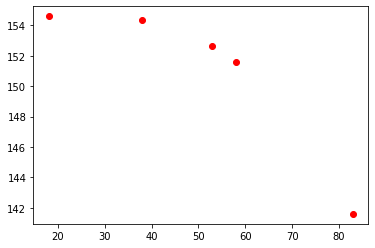

rewaRD::  300
stepping:  209
Temperature:  [ 18.  38.  53.  58.  83. 108.]
ORDER PARAM RESULT (X2): 190.00000000000134
THE JT RESULT {X0}: 1.199999999999963
THE NF RESULT {X1}: 149.99999999999838
THE BK RESULT {X3}: 4.600000000001678
chisqds:  1.2090116077959265e-26


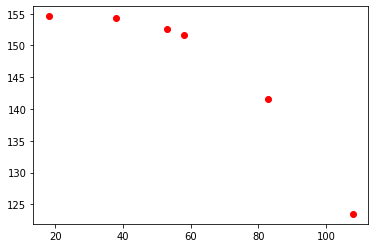

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  140
fixed Jt:  1.0
fixed Nf:  140
fixed Bk:  6.8
start Tn:  154
start Jt:  1.0
start Nf:  144
start Bk:  6.76
stepping:  210
Temperature:  [33.]
rewaRD::  -100
stepping:  210
Temperature:  [33. 63.]
rewaRD::  -100
stepping:  210
Temperature:  [33. 63. 68.]
rewaRD::  -100
stepping:  210
Temperature:  [33. 63. 68. 69.]
rewaRD::  -100
stepping:  210
Temperature:  [33. 63. 68. 69. 70.]
ORDER PARAM RESULT (X2): 140.0000000010409
THE JT RESULT {X0}: 1.000000000010894
THE NF RESULT {X1}: 140.00000000258672
THE BK RESULT {X3}: 6.799999997412242
chisqds:  7.238756414244568e-24


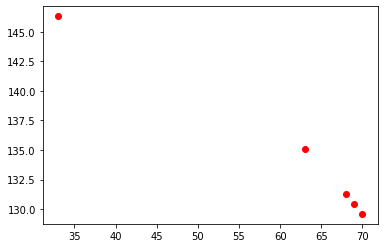

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  120
fixed Jt:  0.8
fixed Nf:  290
fixed Bk:  6.6
start Tn:  138
start Jt:  0.7
start Nf:  272
start Bk:  6.5
stepping:  211
Temperature:  [8.]
rewaRD::  -100
stepping:  211
Temperature:  [ 8. 38.]
rewaRD::  -100
stepping:  211
Temperature:  [ 8. 38. 53.]
rewaRD::  -100
stepping:  211
Temperature:  [ 8. 38. 53. 78.]
rewaRD::  -100
stepping:  211
Temperature:  [ 8. 38. 53. 78. 83.]
ORDER PARAM RESULT (X2): 131.3608743875714
THE JT RESULT {X0}: 0.9772698827004224
THE NF RESULT {X1}: 274.971127805731
THE BK RESULT {X3}: 7.99937444430598
chisqds:  2.1563875723045647


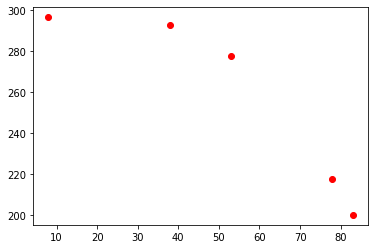

rewaRD::  85.49541146377217
stepping:  211
Temperature:  [ 8. 38. 53. 78. 83. 84.]
ORDER PARAM RESULT (X2): 120.0000000000238
THE JT RESULT {X0}: 0.8000000000002686
THE NF RESULT {X1}: 290.00000000015706
THE BK RESULT {X3}: 6.599999999842871
chisqds:  5.965460996123398e-27


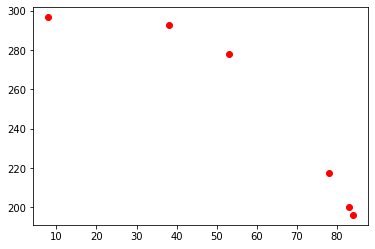

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  150
fixed Jt:  0.9
fixed Nf:  370
fixed Bk:  3.2
start Tn:  146
start Jt:  0.66
start Nf:  372
start Bk:  3.22
stepping:  212
Temperature:  [28.]
rewaRD::  -100
stepping:  212
Temperature:  [28. 58.]
rewaRD::  -100
stepping:  212
Temperature:  [28. 58. 73.]
rewaRD::  -100
stepping:  212
Temperature:  [28. 58. 73. 98.]
rewaRD::  -100
stepping:  212
Temperature:  [ 28.  58.  73.  98. 103.]
ORDER PARAM RESULT (X2): 149.99999999998818
THE JT RESULT {X0}: 0.899999999999885
THE NF RESULT {X1}: 369.9999999999256
THE BK RESULT {X3}: 3.2000000000743722
chisqds:  9.660392484049432e-27


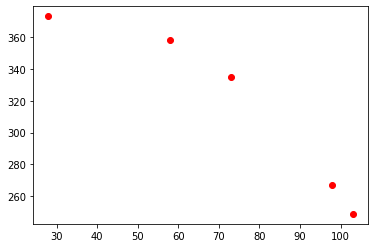

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  220
fixed Jt:  1.3
fixed Nf:  160
fixed Bk:  5.0
start Tn:  214
start Jt:  1.06
start Nf:  168
start Bk:  4.88
stepping:  213
Temperature:  [33.]
rewaRD::  -100
stepping:  213
Temperature:  [33. 34.]
rewaRD::  -100
stepping:  213
Temperature:  [33. 34. 54.]
rewaRD::  -100
stepping:  213
Temperature:  [33. 34. 54. 84.]
rewaRD::  -100
stepping:  213
Temperature:  [33. 34. 54. 84. 85.]
ORDER PARAM RESULT (X2): 220.000000000114
THE JT RESULT {X0}: 1.3000000000001504
THE NF RESULT {X1}: 160.0000000001973
THE BK RESULT {X3}: 4.99999999980275
chisqds:  4.252609076559153e-25


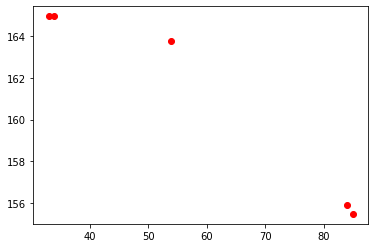

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  120
fixed Jt:  1.3
fixed Nf:  460
fixed Bk:  5.8
start Tn:  122
start Jt:  1.04
start Nf:  462
start Bk:  5.94
stepping:  214
Temperature:  [23.]
rewaRD::  -100
stepping:  214
Temperature:  [23. 43.]
rewaRD::  -100
stepping:  214
Temperature:  [23. 43. 53.]
rewaRD::  -100
stepping:  214
Temperature:  [23. 43. 53. 63.]
rewaRD::  -100
stepping:  214
Temperature:  [23. 43. 53. 63. 88.]
ORDER PARAM RESULT (X2): 119.99999999996909
THE JT RESULT {X0}: 1.2999999999997456
THE NF RESULT {X1}: 459.99999999976797
THE BK RESULT {X3}: 5.8000000002319245
chisqds:  4.778892185165948e-24


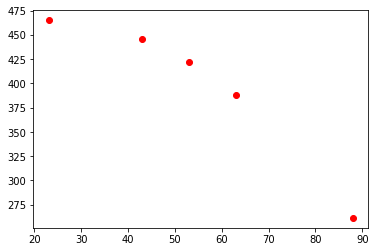

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  170
fixed Jt:  0.7
fixed Nf:  390
fixed Bk:  3.0
start Tn:  178
start Jt:  0.94
start Nf:  390
start Bk:  2.94
stepping:  215
Temperature:  [18.]
rewaRD::  -100
stepping:  215
Temperature:  [18. 28.]
rewaRD::  -100
stepping:  215
Temperature:  [18. 28. 43.]
rewaRD::  -100
stepping:  215
Temperature:  [18. 28. 43. 63.]
rewaRD::  -100
stepping:  215
Temperature:  [18. 28. 43. 63. 93.]
ORDER PARAM RESULT (X2): 169.99999999983928
THE JT RESULT {X0}: 0.6999999999988781
THE NF RESULT {X1}: 389.9999999990429
THE BK RESULT {X3}: 3.0000000009571446
chisqds:  1.4503163488647297e-24


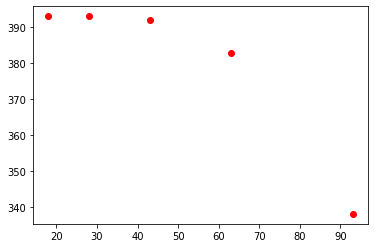

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  270
fixed Jt:  0.9
fixed Nf:  350
fixed Bk:  3.0
start Tn:  262
start Jt:  1.08
start Nf:  348
start Bk:  2.9
stepping:  216
Temperature:  [33.]
rewaRD::  -100
stepping:  216
Temperature:  [33. 34.]
rewaRD::  -100
stepping:  216
Temperature:  [33. 34. 49.]
rewaRD::  -100
stepping:  216
Temperature:  [33. 34. 49. 50.]
rewaRD::  -100
stepping:  216
Temperature:  [33. 34. 49. 50. 65.]
ORDER PARAM RESULT (X2): 270.00000002062654
THE JT RESULT {X0}: 0.9000000001447171
THE NF RESULT {X1}: 350.00000005796295
THE BK RESULT {X3}: 2.9999999420368124
chisqds:  1.6468400410906122e-26


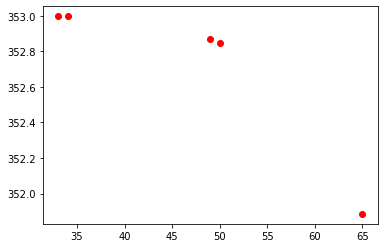

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  230
fixed Jt:  0.8
fixed Nf:  380
fixed Bk:  6.8
start Tn:  214
start Jt:  0.98
start Nf:  384
start Bk:  6.92
stepping:  217
Temperature:  [18.]
rewaRD::  -100
stepping:  217
Temperature:  [18. 23.]
rewaRD::  -100
stepping:  217
Temperature:  [18. 23. 53.]
rewaRD::  -100
stepping:  217
Temperature:  [18. 23. 53. 58.]
rewaRD::  -100
stepping:  217
Temperature:  [18. 23. 53. 58. 73.]
ORDER PARAM RESULT (X2): 230.00000000322441
THE JT RESULT {X0}: 0.8000000000244595
THE NF RESULT {X1}: 380.0000000128756
THE BK RESULT {X3}: 6.799999987124655
chisqds:  5.152760358656972e-28


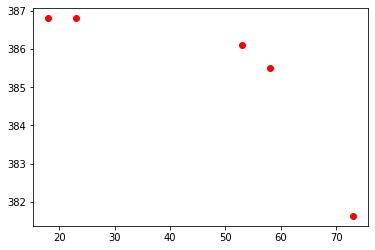

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  260
fixed Jt:  1.4
fixed Nf:  420
fixed Bk:  7.2
start Tn:  266
start Jt:  1.48
start Nf:  408
start Bk:  7.12
stepping:  218
Temperature:  [4.]
rewaRD::  -100
stepping:  218
Temperature:  [ 4. 29.]
rewaRD::  -100
stepping:  218
Temperature:  [ 4. 29. 59.]
rewaRD::  -100
stepping:  218
Temperature:  [ 4. 29. 59. 74.]
rewaRD::  -100
stepping:  218
Temperature:  [  4.  29.  59.  74. 104.]
ORDER PARAM RESULT (X2): 268.52782021278006
THE JT RESULT {X0}: 1.4270047714278968
THE NF RESULT {X1}: 408.9122388971834
THE BK RESULT {X3}: 7.99975613190034
chisqds:  1.0456092245762876


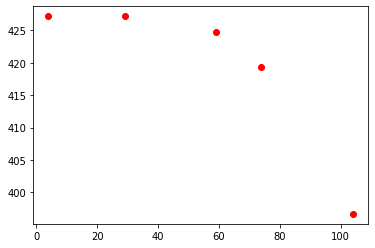

rewaRD::  282.5520955614102
stepping:  218
Temperature:  [  4.  29.  59.  74. 104. 124.]
ORDER PARAM RESULT (X2): 267.47793774368165
THE JT RESULT {X0}: 1.4425014555975886
THE NF RESULT {X1}: 408.9237528839447
THE BK RESULT {X3}: 7.999790005852594
chisqds:  0.578748889807328


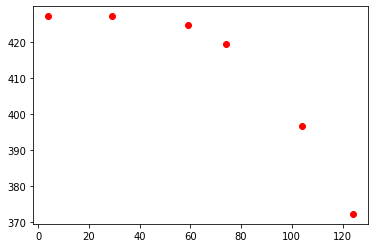

rewaRD::  300
stepping:  218
Temperature:  [  4.  29.  59.  74. 104. 124. 144.]
ORDER PARAM RESULT (X2): 266.9156348531195
THE JT RESULT {X0}: 1.450439781200145
THE NF RESULT {X1}: 408.96074800288955
THE BK RESULT {X3}: 7.999297041797666
chisqds:  0.40494225532676026


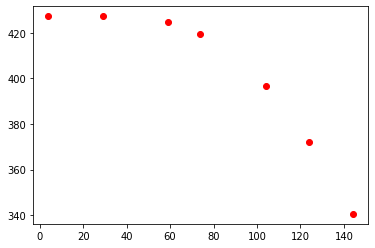

rewaRD::  300
stepping:  218
Temperature:  [  4.  29.  59.  74. 104. 124. 144. 154.]
ORDER PARAM RESULT (X2): 266.6748122823173
THE JT RESULT {X0}: 1.4545144168768156
THE NF RESULT {X1}: 408.9992842156113
THE BK RESULT {X3}: 7.999342013511969
chisqds:  0.30998083623634665


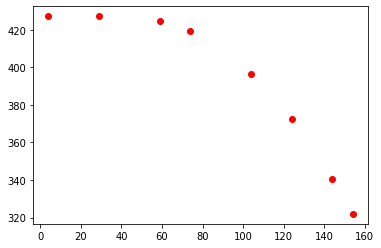

rewaRD::  300
stepping:  218
Temperature:  [  4.  29.  59.  74. 104. 124. 144. 154. 155.]
ORDER PARAM RESULT (X2): 266.5964282685606
THE JT RESULT {X0}: 1.4562673525181038
THE NF RESULT {X1}: 409.03413345803665
THE BK RESULT {X3}: 7.999468156948265
chisqds:  0.2502605841936207


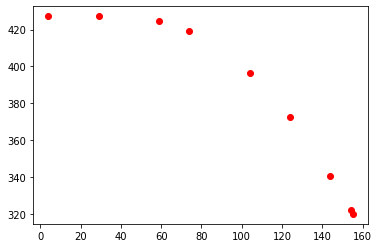

rewaRD::  300
stepping:  218
Temperature:  [  4.  29.  59.  74. 104. 124. 144. 154. 155. 160.]
ORDER PARAM RESULT (X2): 260.0000000000011
THE JT RESULT {X0}: 1.3999999999999997
THE NF RESULT {X1}: 420.00000000000244
THE BK RESULT {X3}: 7.199999999997573
chisqds:  1.0493921610358113e-27


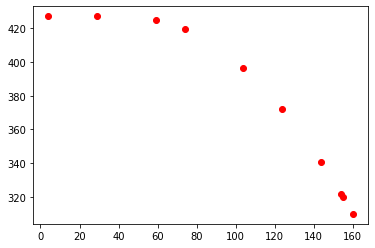

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  190
fixed Jt:  1.2
fixed Nf:  190
fixed Bk:  5.0
start Tn:  172
start Jt:  1.38
start Nf:  174
start Bk:  5.14
stepping:  219
Temperature:  [8.]
rewaRD::  -100
stepping:  219
Temperature:  [ 8. 18.]
rewaRD::  -100
stepping:  219
Temperature:  [ 8. 18. 48.]
rewaRD::  -100
stepping:  219
Temperature:  [ 8. 18. 48. 63.]
rewaRD::  -100
stepping:  219
Temperature:  [ 8. 18. 48. 63. 73.]
ORDER PARAM RESULT (X2): 182.62566882217453
THE JT RESULT {X0}: 1.0162375478690204
THE NF RESULT {X1}: 176.94378295628763
THE BK RESULT {X3}: 7.9994629036262035
chisqds:  2.4761751322492893


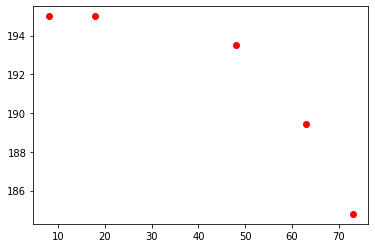

rewaRD::  61.539462532543496
stepping:  219
Temperature:  [ 8. 18. 48. 63. 73. 78.]
ORDER PARAM RESULT (X2): 181.2032271803749
THE JT RESULT {X0}: 1.0446112479454956
THE NF RESULT {X1}: 176.96706482489995
THE BK RESULT {X3}: 7.9996014468893275
chisqds:  1.5519845569289004


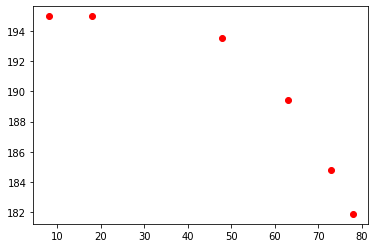

rewaRD::  157.73452333284064
stepping:  219
Temperature:  [ 8. 18. 48. 63. 73. 78. 79.]
ORDER PARAM RESULT (X2): 180.5519207984416
THE JT RESULT {X0}: 1.0581265711201326
THE NF RESULT {X1}: 176.9920783605296
THE BK RESULT {X3}: 7.9997094395463995
chisqds:  1.248789348151657


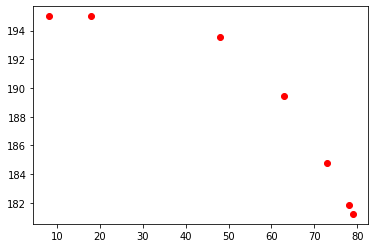

rewaRD::  220.31022733501305
stepping:  219
Temperature:  [ 8. 18. 48. 63. 73. 78. 79. 99.]
ORDER PARAM RESULT (X2): 178.5251494629262
THE JT RESULT {X0}: 1.085852654795224
THE NF RESULT {X1}: 177.03945500438724
THE BK RESULT {X3}: 7.999975197084969
chisqds:  1.2487204008720993


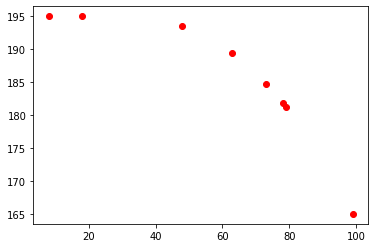

rewaRD::  220.32791305454947
stepping:  219
Temperature:  [  8.  18.  48.  63.  73.  78.  79.  99. 100.]
ORDER PARAM RESULT (X2): 177.81587679556284
THE JT RESULT {X0}: 1.1023856418402638
THE NF RESULT {X1}: 177.0810633485593
THE BK RESULT {X3}: 7.9995502572472486
chisqds:  1.2548714103573233


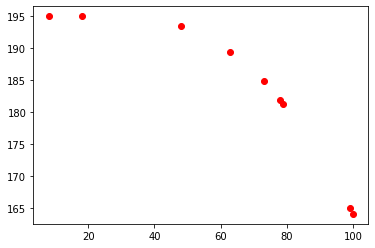

rewaRD::  218.75776011671218
stepping:  219
Temperature:  [  8.  18.  48.  63.  73.  78.  79.  99. 100. 101.]
ORDER PARAM RESULT (X2): 177.47831291846012
THE JT RESULT {X0}: 1.11116049566477
THE NF RESULT {X1}: 177.13656975594586
THE BK RESULT {X3}: 7.99977793004829
chisqds:  1.2548555409984605


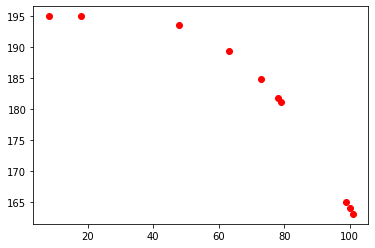

rewaRD::  218.76179124310113
stepping:  219
Temperature:  [  8.  18.  48.  63.  73.  78.  79.  99. 100. 101. 126.]
ORDER PARAM RESULT (X2): 176.24704438378248
THE JT RESULT {X0}: 1.1158174771217069
THE NF RESULT {X1}: 177.16239034313818
THE BK RESULT {X3}: 7.999842701381932
chisqds:  1.5200425862901075


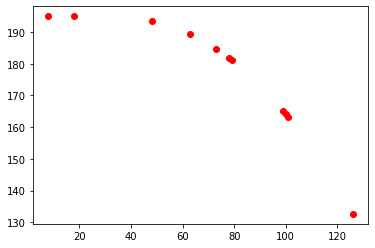

rewaRD::  163.150521970743
stepping:  219
Temperature:  [  8.  18.  48.  63.  73.  78.  79.  99. 100. 101. 126. 146.]
ORDER PARAM RESULT (X2): 175.28694281936612
THE JT RESULT {X0}: 1.0990227140869928
THE NF RESULT {X1}: 177.1123826734114
THE BK RESULT {X3}: 7.999727067445942
chisqds:  2.1126066492950235


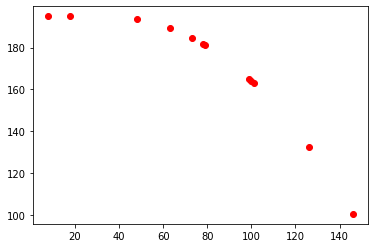

rewaRD::  89.3395536426433
stepping:  219
Temperature:  [  8.  18.  48.  63.  73.  78.  79.  99. 100. 101. 126. 146. 166.]
ORDER PARAM RESULT (X2): 174.33594960563357
THE JT RESULT {X0}: 1.119995021121624
THE NF RESULT {X1}: 176.8901142795252
THE BK RESULT {X3}: 7.999327635309885
chisqds:  4.01882135446016


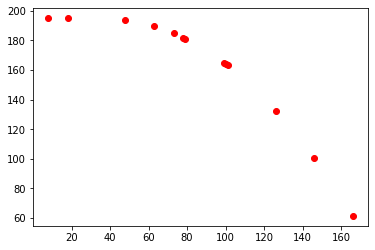

rewaRD::  -0.4683302092856536
stepping:  219
Temperature:  [  8.  18.  48.  63.  73.  78.  79.  99. 100. 101. 126. 146. 166. 167.]
ORDER PARAM RESULT (X2): 173.9607470870735
THE JT RESULT {X0}: 1.130234259318922
THE NF RESULT {X1}: 176.67775086714622
THE BK RESULT {X3}: 7.999585249216704
chisqds:  5.728154897365987


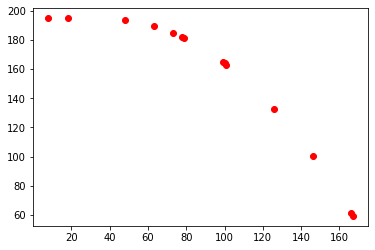

rewaRD::  -30.16948613174995
stepping:  219
Temperature:  [  8.  18.  48.  63.  73.  78.  79.  99. 100. 101. 126. 146. 166. 167.
 168.]
ORDER PARAM RESULT (X2): 173.77964326351
THE JT RESULT {X0}: 1.1318651918505664
THE NF RESULT {X1}: 176.59524527331698
THE BK RESULT {X3}: 7.999399697692466
chisqds:  7.205757265497173


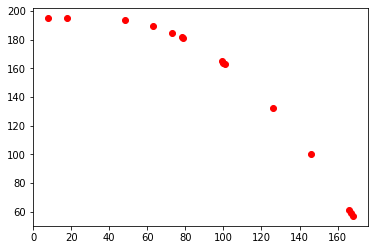

rewaRD::  -44.488832295907024
stepping:  219
Temperature:  [  8.  18.  48.  63.  73.  78.  79.  99. 100. 101. 126. 146. 166. 167.
 168. 188.]
ORDER PARAM RESULT (X2): 174.94274236657725
THE JT RESULT {X0}: 0.9890849924827045
THE NF RESULT {X1}: 178.1292871331563
THE BK RESULT {X3}: 7.999798158694192
chisqds:  5.054456536890831


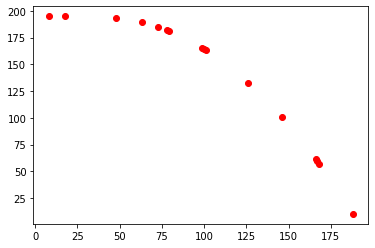

rewaRD::  -20.86191718525417
--------------------------------------
| approxkl           | 0.00024997018 |
| clipfrac           | 0.0           |
| ep_len_mean        | 7.57          |
| ep_reward_mean     | 377           |
| explained_variance | 0.000435      |
| fps                | 4             |
| n_updates          | 13            |
| policy_entropy     | 1.9397666     |
| policy_loss        | -0.0002704598 |
| serial_timesteps   | 1664          |
| time_elapsed       | 262           |
| total_timesteps    | 1664          |
| value_loss         | 172008.53     |
--------------------------------------
stepping:  219
Temperature:  [  8.  18.  48.  63.  73.  78.  79.  99. 100. 101. 126. 146. 166. 167.
 168. 188. 208.]
ORDER PARAM RESULT (X2): 189.9999999999563
THE JT RESULT {X0}: 1.2000000000017126
THE NF RESULT {X1}: 190.00000000000782
THE BK RESULT {X3}: 4.999999999999995
chisqds:  1.3982441804750342e-22


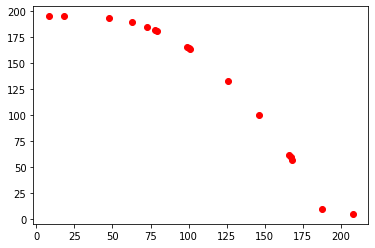

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  70
fixed Jt:  1.3
fixed Nf:  170
fixed Bk:  3.6
start Tn:  84
start Jt:  1.06
start Nf:  174
start Bk:  3.66
stepping:  220
Temperature:  [18.]
rewaRD::  -100
stepping:  220
Temperature:  [18. 23.]
rewaRD::  -100
stepping:  220
Temperature:  [18. 23. 53.]
rewaRD::  -100
stepping:  220
Temperature:  [18. 23. 53. 83.]
rewaRD::  -100
stepping:  220
Temperature:  [ 18.  23.  53.  83. 103.]
ORDER PARAM RESULT (X2): 83.5933820591864
THE JT RESULT {X0}: 1.9998825424481717
THE NF RESULT {X1}: 165.67229657401487
THE BK RESULT {X3}: 2.5774399902625347
chisqds:  5.964028596392527


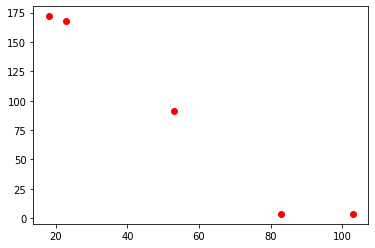

rewaRD::  -32.931240430009225
stepping:  220
Temperature:  [ 18.  23.  53.  83. 103. 113.]
ORDER PARAM RESULT (X2): 83.57426621718541
THE JT RESULT {X0}: 1.9998981929320254
THE NF RESULT {X1}: 165.60005461474816
THE BK RESULT {X3}: 2.9370432205290418
chisqds:  3.1431816814722344


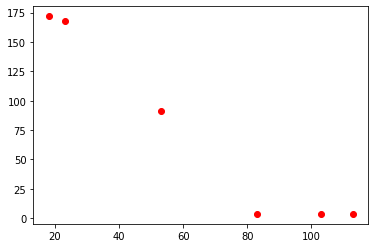

rewaRD::  27.25958615686639
stepping:  220
Temperature:  [ 18.  23.  53.  83. 103. 113. 143.]
ORDER PARAM RESULT (X2): 83.56490798737066
THE JT RESULT {X0}: 1.9998239533627167
THE NF RESULT {X1}: 165.5628779888651
THE BK RESULT {X3}: 3.1132194842386864
chisqds:  2.1455363727160734


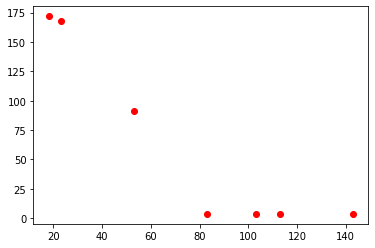

rewaRD::  86.4335674224123
stepping:  220
Temperature:  [ 18.  23.  53.  83. 103. 113. 143. 168.]
ORDER PARAM RESULT (X2): 83.55951793443768
THE JT RESULT {X0}: 1.999823620090034
THE NF RESULT {X1}: 165.54346135967472
THE BK RESULT {X3}: 3.218119693482046
chisqds:  1.6312761202773902


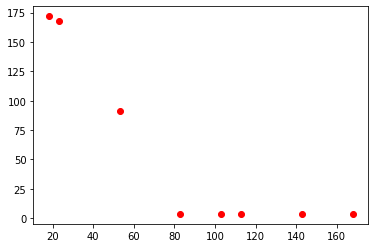

rewaRD::  145.20680161245912
stepping:  220
Temperature:  [ 18.  23.  53.  83. 103. 113. 143. 168. 169.]
ORDER PARAM RESULT (X2): 83.55581465812537
THE JT RESULT {X0}: 1.9998368774133304
THE NF RESULT {X1}: 165.52836985666536
THE BK RESULT {X3}: 3.287555030247454
chisqds:  1.316286056997058


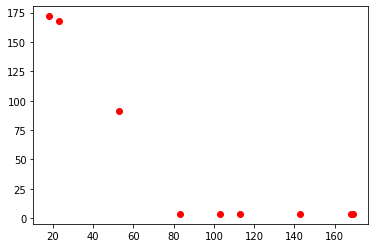

rewaRD::  203.88531267477674
stepping:  220
Temperature:  [ 18.  23.  53.  83. 103. 113. 143. 168. 169. 170.]
ORDER PARAM RESULT (X2): 83.5531021228274
THE JT RESULT {X0}: 1.9998584141960962
THE NF RESULT {X1}: 165.5162673516128
THE BK RESULT {X3}: 3.33691968854232
chisqds:  1.1033659744584696


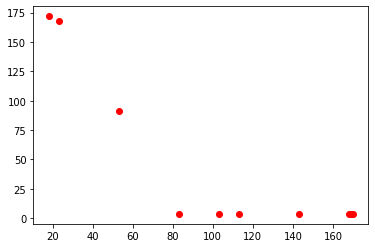

rewaRD::  262.52703931378653
stepping:  220
Temperature:  [ 18.  23.  53.  83. 103. 113. 143. 168. 169. 170. 200.]
ORDER PARAM RESULT (X2): 83.55094474839204
THE JT RESULT {X0}: 1.9998775440471728
THE NF RESULT {X1}: 165.50530803723103
THE BK RESULT {X3}: 3.3738100549668752
chisqds:  0.949667486761619


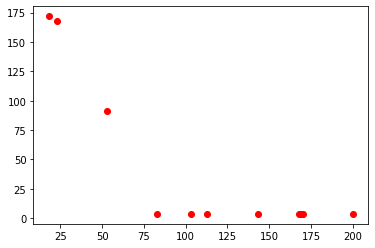

rewaRD::  300
stepping:  220
Temperature:  [ 18.  23.  53.  83. 103. 113. 143. 168. 169. 170. 200. 230.]
ORDER PARAM RESULT (X2): 83.54962998583143
THE JT RESULT {X0}: 1.9998742574223312
THE NF RESULT {X1}: 165.5022739547421
THE BK RESULT {X3}: 3.402590739513517
chisqds:  0.8340772025281535


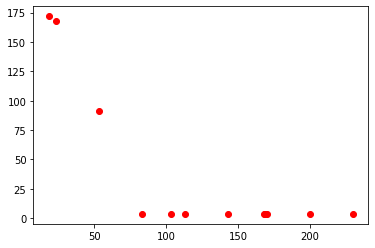

rewaRD::  300
stepping:  220
Temperature:  [ 18.  23.  53.  83. 103. 113. 143. 168. 169. 170. 200. 230. 255.]
ORDER PARAM RESULT (X2): 83.54807786423187
THE JT RESULT {X0}: 1.9998856976821722
THE NF RESULT {X1}: 165.49221161689448
THE BK RESULT {X3}: 3.42539930694942
chisqds:  0.7430348128465435


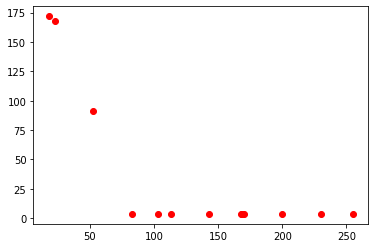

rewaRD::  300
stepping:  220
Temperature:  [ 18.  23.  53.  83. 103. 113. 143. 168. 169. 170. 200. 230. 255. 270.]
ORDER PARAM RESULT (X2): 83.54739001237444
THE JT RESULT {X0}: 1.999980959945137
THE NF RESULT {X1}: 165.49277813987257
THE BK RESULT {X3}: 3.444232576507674
chisqds:  0.6704876735228591


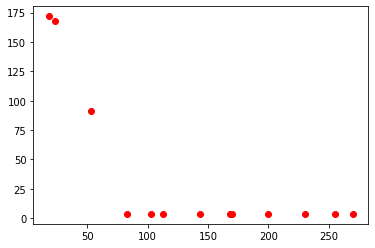

rewaRD::  300
stepping:  220
Temperature:  [ 18.  23.  53.  83. 103. 113. 143. 168. 169. 170. 200. 230. 255. 270.
 275.]
ORDER PARAM RESULT (X2): 83.5439861213007
THE JT RESULT {X0}: 1.999849905097183
THE NF RESULT {X1}: 165.45048308797624
THE BK RESULT {X3}: 3.4590724605456655
chisqds:  0.6083074362167792


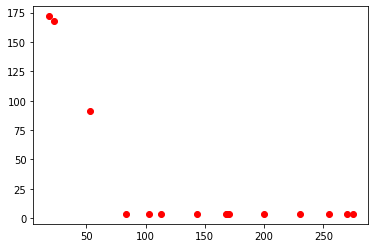

rewaRD::  300
stepping:  220
Temperature:  [ 18.  23.  53.  83. 103. 113. 143. 168. 169. 170. 200. 230. 255. 270.
 275. 305.]
ORDER PARAM RESULT (X2): 83.54572212437375
THE JT RESULT {X0}: 1.9998749851785143
THE NF RESULT {X1}: 165.48436855587434
THE BK RESULT {X3}: 3.472969115983864
chisqds:  0.560552283060565


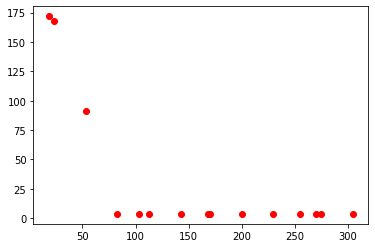

rewaRD::  300
stepping:  220
Temperature:  [ 18.  23.  53.  83. 103. 113. 143. 168. 169. 170. 200. 230. 255. 270.
 275. 305. 310.]
ORDER PARAM RESULT (X2): 83.54539887292658
THE JT RESULT {X0}: 1.9999026781426543
THE NF RESULT {X1}: 165.48605160989607
THE BK RESULT {X3}: 3.484332965200074
chisqds:  0.5183307575905358


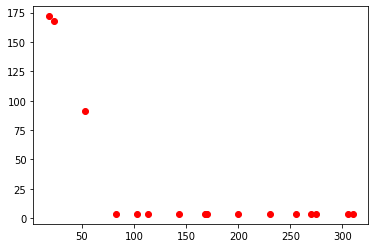

rewaRD::  300
stepping:  220
Temperature:  [ 18.  23.  53.  83. 103. 113. 143. 168. 169. 170. 200. 230. 255. 270.
 275. 305. 310. 340.]
ORDER PARAM RESULT (X2): 83.54509699127365
THE JT RESULT {X0}: 1.9998003609607171
THE NF RESULT {X1}: 165.48716740759883
THE BK RESULT {X3}: 3.494163382724398
chisqds:  0.482051644152763


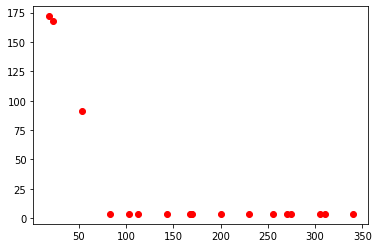

rewaRD::  300
terminated: over max temp
reset
fixed Tn:  130
fixed Jt:  1.2
fixed Nf:  330
fixed Bk:  4.4
start Tn:  126
start Jt:  1.16
start Nf:  348
start Bk:  4.56
stepping:  221
Temperature:  [18.]
rewaRD::  -100
stepping:  221
Temperature:  [18. 48.]
rewaRD::  -100
stepping:  221
Temperature:  [18. 48. 78.]
rewaRD::  -100
stepping:  221
Temperature:  [ 18.  48.  78. 108.]
rewaRD::  -100
stepping:  221
Temperature:  [ 18.  48.  78. 108. 118.]
ORDER PARAM RESULT (X2): 129.99999999998496
THE JT RESULT {X0}: 1.1999999999998359
THE NF RESULT {X1}: 329.99999999990183
THE BK RESULT {X3}: 4.400000000098304
chisqds:  1.4947382804037317e-26


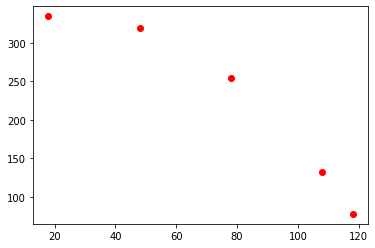

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  150
fixed Jt:  0.9
fixed Nf:  440
fixed Bk:  3.2
start Tn:  164
start Jt:  0.84
start Nf:  426
start Bk:  3.14
stepping:  222
Temperature:  [13.]
rewaRD::  -100
stepping:  222
Temperature:  [13. 33.]
rewaRD::  -100
stepping:  222
Temperature:  [13. 33. 63.]
rewaRD::  -100
stepping:  222
Temperature:  [13. 33. 63. 83.]
rewaRD::  -100
stepping:  222
Temperature:  [ 13.  33.  63.  83. 103.]
ORDER PARAM RESULT (X2): 152.13334270395836
THE JT RESULT {X0}: 1.08230266488112
THE NF RESULT {X1}: 435.2216709151689
THE BK RESULT {X3}: 7.999947629712518
chisqds:  0.03439188397845648


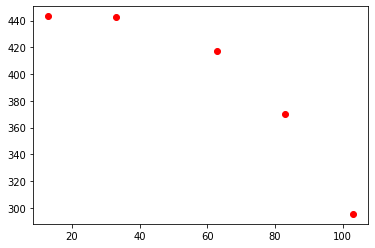

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  240
fixed Jt:  1.4
fixed Nf:  130
fixed Bk:  4.8
start Tn:  258
start Jt:  1.4
start Nf:  110
start Bk:  4.78
stepping:  223
Temperature:  [18.]
rewaRD::  -100
stepping:  223
Temperature:  [18. 23.]
rewaRD::  -100
stepping:  223
Temperature:  [18. 23. 28.]
rewaRD::  -100
stepping:  223
Temperature:  [18. 23. 28. 48.]
rewaRD::  -100
stepping:  223
Temperature:  [18. 23. 28. 48. 68.]
ORDER PARAM RESULT (X2): 299.9978980859303
THE JT RESULT {X0}: 0.6253150015477374
THE NF RESULT {X1}: 112.83622111136732
THE BK RESULT {X3}: 7.613110682618038
chisqds:  7.142467432879545


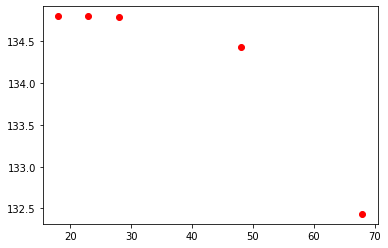

rewaRD::  -43.99694450706978
stepping:  223
Temperature:  [18. 23. 28. 48. 68. 88.]
ORDER PARAM RESULT (X2): 287.87334368301293
THE JT RESULT {X0}: 0.7650226699520326
THE NF RESULT {X1}: 113.26435548815661
THE BK RESULT {X3}: 7.9995653109631455
chisqds:  3.414360723229343


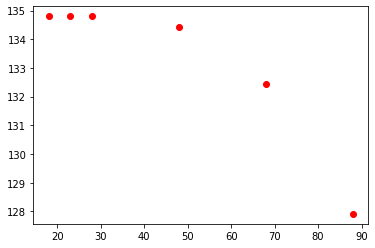

rewaRD::  17.152237980782317
stepping:  223
Temperature:  [18. 23. 28. 48. 68. 88. 98.]
ORDER PARAM RESULT (X2): 283.92427714412526
THE JT RESULT {X0}: 0.8551160988848405
THE NF RESULT {X1}: 113.27803562495721
THE BK RESULT {X3}: 7.999323552165663
chisqds:  2.384831110506226


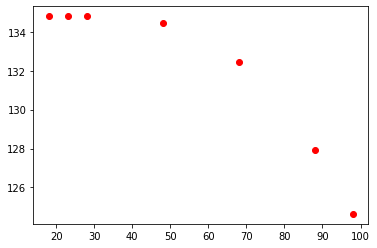

rewaRD::  67.72676196558521
stepping:  223
Temperature:  [ 18.  23.  28.  48.  68.  88.  98. 113.]
ORDER PARAM RESULT (X2): 276.16830743256867
THE JT RESULT {X0}: 0.9478531169653764
THE NF RESULT {X1}: 113.31943471524586
THE BK RESULT {X3}: 7.999766338791052
chisqds:  1.8430133628571


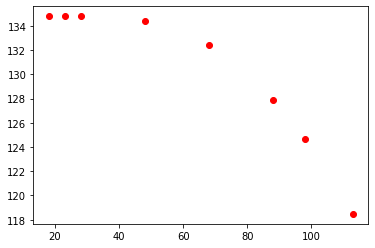

rewaRD::  117.03586531782216
stepping:  223
Temperature:  [ 18.  23.  28.  48.  68.  88.  98. 113. 114.]
ORDER PARAM RESULT (X2): 274.56144738670133
THE JT RESULT {X0}: 0.9749523913336586
THE NF RESULT {X1}: 113.3493520542033
THE BK RESULT {X3}: 7.999742081270874
chisqds:  1.5007476323620486


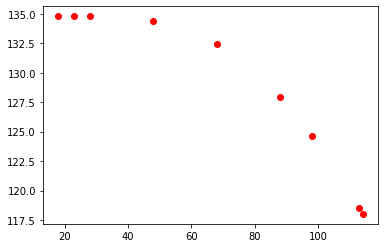

rewaRD::  166.53382046016236
stepping:  223
Temperature:  [ 18.  23.  28.  48.  68.  88.  98. 113. 114. 119.]
ORDER PARAM RESULT (X2): 273.1063203092106
THE JT RESULT {X0}: 0.9976125262110438
THE NF RESULT {X1}: 113.40404747624555
THE BK RESULT {X3}: 7.999934044362115
chisqds:  1.2615210628393965


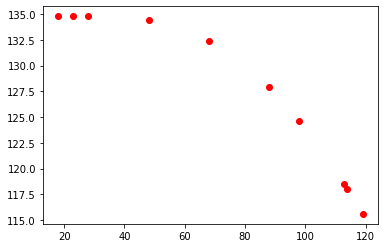

rewaRD::  217.077543754752
stepping:  223
Temperature:  [ 18.  23.  28.  48.  68.  88.  98. 113. 114. 119. 129.]
ORDER PARAM RESULT (X2): 270.5127204004193
THE JT RESULT {X0}: 1.0524267763038304
THE NF RESULT {X1}: 113.45522416873015
THE BK RESULT {X3}: 7.999317871365301
chisqds:  1.1049540132513764


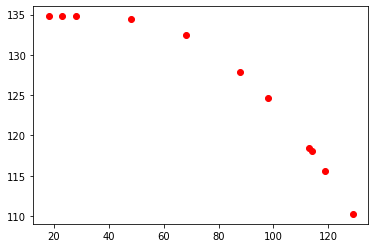

rewaRD::  262.0060158186875
stepping:  223
Temperature:  [ 18.  23.  28.  48.  68.  88.  98. 113. 114. 119. 129. 154.]
ORDER PARAM RESULT (X2): 265.3901105503231
THE JT RESULT {X0}: 1.1112386579929538
THE NF RESULT {X1}: 113.60344647060474
THE BK RESULT {X3}: 7.999934667017733
chisqds:  1.0098941734633713


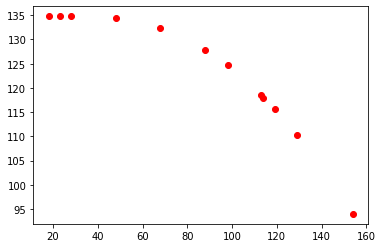

rewaRD::  296.08110484311845
stepping:  223
Temperature:  [ 18.  23.  28.  48.  68.  88.  98. 113. 114. 119. 129. 154. 169.]
ORDER PARAM RESULT (X2): 261.542853330618
THE JT RESULT {X0}: 1.163829844997244
THE NF RESULT {X1}: 113.8406689434403
THE BK RESULT {X3}: 7.999816386389084
chisqds:  0.9372532864594169


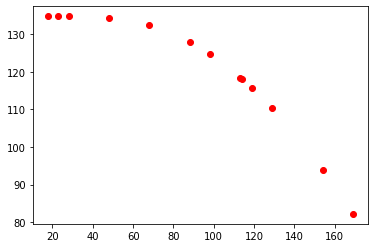

rewaRD::  300
stepping:  223
Temperature:  [ 18.  23.  28.  48.  68.  88.  98. 113. 114. 119. 129. 154. 169. 170.]
ORDER PARAM RESULT (X2): 259.83728274637934
THE JT RESULT {X0}: 1.2027257144323193
THE NF RESULT {X1}: 114.07105932976638
THE BK RESULT {X3}: 7.999654776209808
chisqds:  0.851615397417666


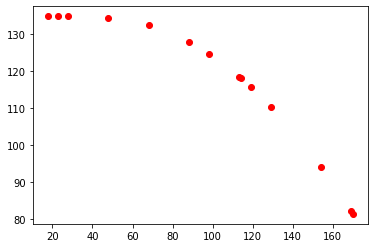

rewaRD::  300
stepping:  223
Temperature:  [ 18.  23.  28.  48.  68.  88.  98. 113. 114. 119. 129. 154. 169. 170.
 195.]
ORDER PARAM RESULT (X2): 256.04873249433723
THE JT RESULT {X0}: 1.254776343854468
THE NF RESULT {X1}: 114.75569533686951
THE BK RESULT {X3}: 7.999293058532805
chisqds:  0.818783757146292


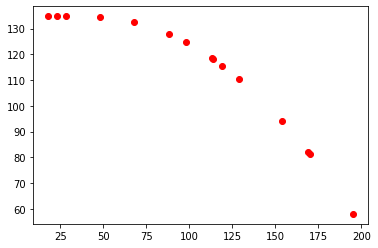

rewaRD::  300
stepping:  223
Temperature:  [ 18.  23.  28.  48.  68.  88.  98. 113. 114. 119. 129. 154. 169. 170.
 195. 225.]
ORDER PARAM RESULT (X2): 239.99999998676103
THE JT RESULT {X0}: 1.3999999999159822
THE NF RESULT {X1}: 129.9999999825203
THE BK RESULT {X3}: 4.8000000174931845
chisqds:  1.933744062658674e-22


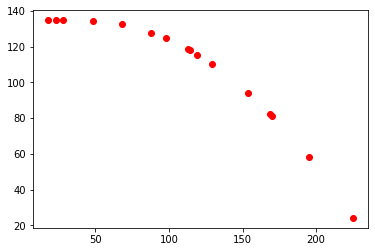

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  80
fixed Jt:  0.7
fixed Nf:  180
fixed Bk:  3.8
start Tn:  74
start Jt:  0.94
start Nf:  184
start Bk:  3.76
stepping:  224
Temperature:  [23.]
rewaRD::  -100
stepping:  224
Temperature:  [23. 53.]
rewaRD::  -100
stepping:  224
Temperature:  [23. 53. 68.]
rewaRD::  -100
stepping:  224
Temperature:  [23. 53. 68. 73.]
rewaRD::  -100
stepping:  224
Temperature:  [23. 53. 68. 73. 93.]
ORDER PARAM RESULT (X2): 79.99999999990165
THE JT RESULT {X0}: 0.7000000000010669
THE NF RESULT {X1}: 179.99999999999605
THE BK RESULT {X3}: 3.8
chisqds:  8.711455451011184e-21


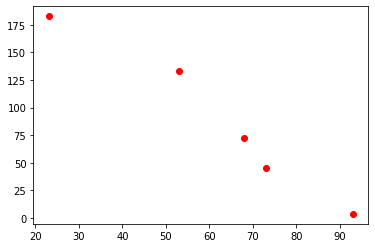

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  70
fixed Jt:  1.2
fixed Nf:  170
fixed Bk:  5.4
start Tn:  60
start Jt:  1.42
start Nf:  178
start Bk:  5.2
stepping:  225
Temperature:  [8.]
rewaRD::  -100
stepping:  225
Temperature:  [ 8. 13.]
rewaRD::  -100
stepping:  225
Temperature:  [ 8. 13. 14.]
rewaRD::  -100
stepping:  225
Temperature:  [ 8. 13. 14. 24.]
rewaRD::  -100
stepping:  225
Temperature:  [ 8. 13. 14. 24. 49.]
ORDER PARAM RESULT (X2): 70.00000000026576
THE JT RESULT {X0}: 1.2000000000051965
THE NF RESULT {X1}: 170.00000000146787
THE BK RESULT {X3}: 5.399999998532179
chisqds:  4.18880079797492e-23


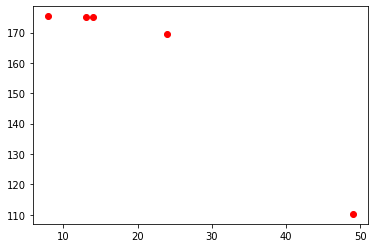

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  80
fixed Jt:  1.1
fixed Nf:  460
fixed Bk:  4.2
start Tn:  80
start Jt:  0.84
start Nf:  458
start Bk:  4.38
stepping:  226
Temperature:  [33.]
rewaRD::  -100
stepping:  226
Temperature:  [33. 63.]
rewaRD::  -100
stepping:  226
Temperature:  [33. 63. 73.]
rewaRD::  -100
stepping:  226
Temperature:  [33. 63. 73. 88.]
rewaRD::  -100
stepping:  226
Temperature:  [33. 63. 73. 88. 89.]
ORDER PARAM RESULT (X2): 79.9999999999993
THE JT RESULT {X0}: 1.1000000000045524
THE NF RESULT {X1}: 460.0000000001143
THE BK RESULT {X3}: 4.2
chisqds:  8.91411932302308e-23


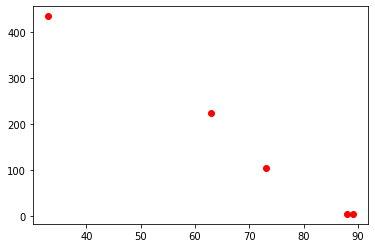

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  270
fixed Jt:  1.2
fixed Nf:  300
fixed Bk:  6.0
start Tn:  262
start Jt:  1.48
start Nf:  286
start Bk:  6.06
stepping:  227
Temperature:  [4.]
rewaRD::  -100
stepping:  227
Temperature:  [ 4. 29.]
rewaRD::  -100
stepping:  227
Temperature:  [ 4. 29. 30.]
rewaRD::  -100
stepping:  227
Temperature:  [ 4. 29. 30. 50.]
rewaRD::  -100
stepping:  227
Temperature:  [ 4. 29. 30. 50. 80.]
ORDER PARAM RESULT (X2): 276.9494864327874
THE JT RESULT {X0}: 1.217112873039681
THE NF RESULT {X1}: 287.9501897808419
THE BK RESULT {X3}: 7.999433809716699
chisqds:  1.6084533022259295


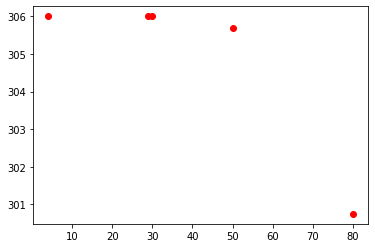

rewaRD::  148.6861132035616
stepping:  227
Temperature:  [ 4. 29. 30. 50. 80. 90.]
ORDER PARAM RESULT (X2): 274.09530187866983
THE JT RESULT {X0}: 1.2631513086838395
THE NF RESULT {X1}: 287.9654495259953
THE BK RESULT {X3}: 7.999671576292146
chisqds:  0.9788621335913088


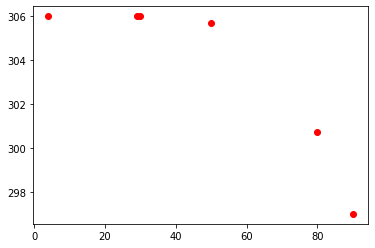

rewaRD::  300
stepping:  227
Temperature:  [  4.  29.  30.  50.  80.  90. 110.]
ORDER PARAM RESULT (X2): 270.1166081751068
THE JT RESULT {X0}: 1.302250328925361
THE NF RESULT {X1}: 287.97870223584573
THE BK RESULT {X3}: 7.9993706985900515
chisqds:  0.8216880533145443


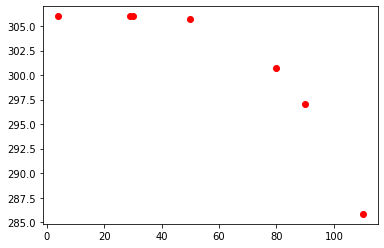

rewaRD::  300
stepping:  227
Temperature:  [  4.  29.  30.  50.  80.  90. 110. 130.]
ORDER PARAM RESULT (X2): 267.796294248646
THE JT RESULT {X0}: 1.3282351764727416
THE NF RESULT {X1}: 288.0144221309913
THE BK RESULT {X3}: 7.999608477860332
chisqds:  0.7858570143386769


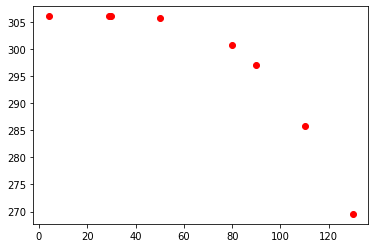

rewaRD::  300
stepping:  227
Temperature:  [  4.  29.  30.  50.  80.  90. 110. 130. 135.]
ORDER PARAM RESULT (X2): 266.98342358780195
THE JT RESULT {X0}: 1.3409715979757533
THE NF RESULT {X1}: 288.0288850927404
THE BK RESULT {X3}: 7.999454923682219
chisqds:  0.7742327465645433


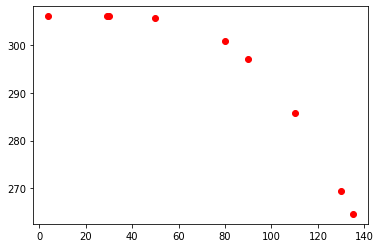

rewaRD::  300
stepping:  227
Temperature:  [  4.  29.  30.  50.  80.  90. 110. 130. 135. 160.]
ORDER PARAM RESULT (X2): 265.7901887326922
THE JT RESULT {X0}: 1.3504244328304815
THE NF RESULT {X1}: 288.06073890411864
THE BK RESULT {X3}: 7.999532455363873
chisqds:  0.8167884238282838


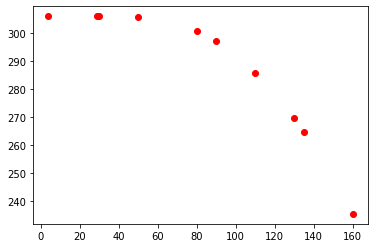

rewaRD::  300
stepping:  227
Temperature:  [  4.  29.  30.  50.  80.  90. 110. 130. 135. 160. 175.]
ORDER PARAM RESULT (X2): 265.04595976306086
THE JT RESULT {X0}: 1.3555905679555875
THE NF RESULT {X1}: 288.10644653136706
THE BK RESULT {X3}: 7.999777509736572
chisqds:  0.8727069202494812


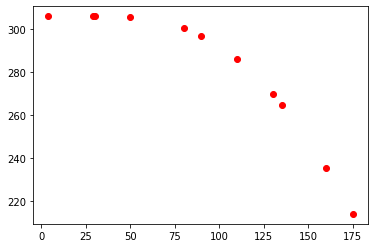

rewaRD::  300
stepping:  227
Temperature:  [  4.  29.  30.  50.  80.  90. 110. 130. 135. 160. 175. 200.]
ORDER PARAM RESULT (X2): 264.2843383866751
THE JT RESULT {X0}: 1.356806960855756
THE NF RESULT {X1}: 288.149012278219
THE BK RESULT {X3}: 7.999821055077656
chisqds:  0.9770640403084193


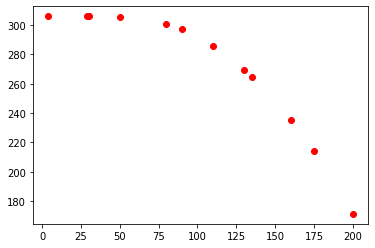

rewaRD::  300
stepping:  227
Temperature:  [  4.  29.  30.  50.  80.  90. 110. 130. 135. 160. 175. 200. 230.]
ORDER PARAM RESULT (X2): 263.57906394864125
THE JT RESULT {X0}: 1.351817210379249
THE NF RESULT {X1}: 288.19346069263963
THE BK RESULT {X3}: 7.999842667138712
chisqds:  1.187521909941196


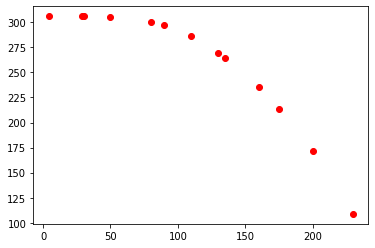

rewaRD::  236.8358904803763
stepping:  227
Temperature:  [  4.  29.  30.  50.  80.  90. 110. 130. 135. 160. 175. 200. 230. 255.]
ORDER PARAM RESULT (X2): 263.0625538086972
THE JT RESULT {X0}: 1.3481461883521828
THE NF RESULT {X1}: 288.1566468378902
THE BK RESULT {X3}: 7.9993541464574545
chisqds:  1.7846718866900417


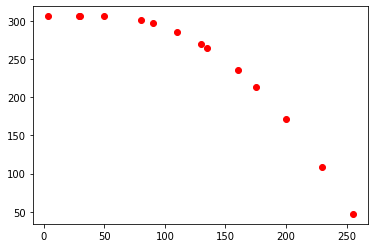

rewaRD::  124.13083490762199
stepping:  227
Temperature:  [  4.  29.  30.  50.  80.  90. 110. 130. 135. 160. 175. 200. 230. 255.
 270.]
ORDER PARAM RESULT (X2): 270.00006536633003
THE JT RESULT {X0}: 1.2000003066244835
THE NF RESULT {X1}: 300.0001862469416
THE BK RESULT {X3}: 5.99981339183527
chisqds:  6.272175403529951e-16


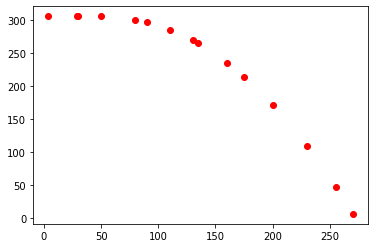

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  70
fixed Jt:  1.3
fixed Nf:  290
fixed Bk:  4.8
start Tn:  52
start Jt:  1.34
start Nf:  298
start Bk:  4.92
stepping:  228
Temperature:  [8.]
rewaRD::  -100
stepping:  228
Temperature:  [8. 9.]
rewaRD::  -100
stepping:  228
Temperature:  [ 8.  9. 19.]
rewaRD::  -100
stepping:  228
Temperature:  [ 8.  9. 19. 24.]
rewaRD::  -100
stepping:  228
Temperature:  [ 8.  9. 19. 24. 49.]
ORDER PARAM RESULT (X2): 52.909592782342294
THE JT RESULT {X0}: 1.096466230150132
THE NF RESULT {X1}: 298.3529680176303
THE BK RESULT {X3}: 7.999232787996173
chisqds:  78.61726064997139


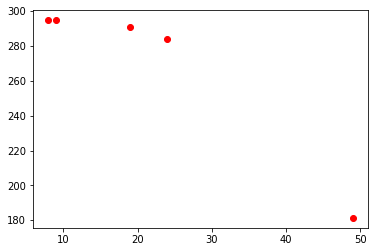

rewaRD::  -94.91205879353994
stepping:  228
Temperature:  [ 8.  9. 19. 24. 49. 50.]
ORDER PARAM RESULT (X2): 52.545901987586376
THE JT RESULT {X0}: 1.1090146737073463
THE NF RESULT {X1}: 298.58821337638506
THE BK RESULT {X3}: 7.999231302395477
chisqds:  90.99565054407898


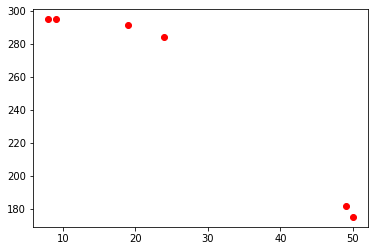

rewaRD::  -95.60418550108352
stepping:  228
Temperature:  [ 8.  9. 19. 24. 49. 50. 55.]
ORDER PARAM RESULT (X2): 52.425305117733245
THE JT RESULT {X0}: 1.1611367310297112
THE NF RESULT {X1}: 298.46598376671653
THE BK RESULT {X3}: 7.999541795263565
chisqds:  103.90323658950653


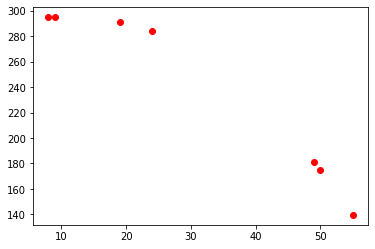

rewaRD::  -96.15026429272564
stepping:  228
Temperature:  [ 8.  9. 19. 24. 49. 50. 55. 65.]
ORDER PARAM RESULT (X2): 52.485412360415395
THE JT RESULT {X0}: 1.135308275353228
THE NF RESULT {X1}: 298.52745912263725
THE BK RESULT {X3}: 7.99958905787341
chisqds:  87.18142056630253


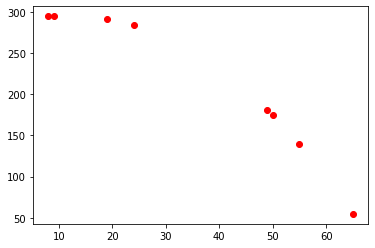

rewaRD::  -95.4118664573056
stepping:  228
Temperature:  [ 8.  9. 19. 24. 49. 50. 55. 65. 95.]
ORDER PARAM RESULT (X2): 54.12880265021026
THE JT RESULT {X0}: 0.40000000647819584
THE NF RESULT {X1}: 299.71333493007074
THE BK RESULT {X3}: 7.406500879233605
chisqds:  55.26611365621574


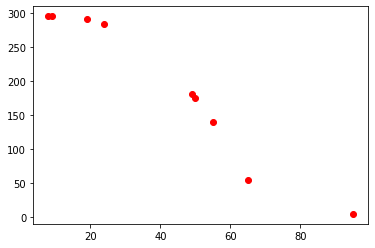

rewaRD::  -92.76229187222734
stepping:  228
Temperature:  [ 8.  9. 19. 24. 49. 50. 55. 65. 95. 96.]
ORDER PARAM RESULT (X2): 54.128798768448476
THE JT RESULT {X0}: 0.400000282876241
THE NF RESULT {X1}: 299.84425668049334
THE BK RESULT {X3}: 6.275898164590128
chisqds:  47.00926869554331


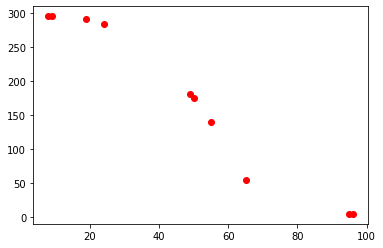

rewaRD::  -91.49103972260002
stepping:  228
Temperature:  [ 8.  9. 19. 24. 49. 50. 55. 65. 95. 96. 97.]
ORDER PARAM RESULT (X2): 69.99999999999994
THE JT RESULT {X0}: 1.3000000000000183
THE NF RESULT {X1}: 289.99999999999994
THE BK RESULT {X3}: 4.8
chisqds:  2.6937211859550564e-27


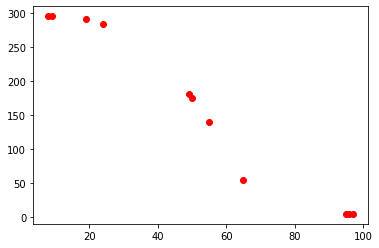

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  130
fixed Jt:  1.1
fixed Nf:  290
fixed Bk:  5.4
start Tn:  116
start Jt:  0.84
start Nf:  300
start Bk:  5.52
stepping:  229
Temperature:  [28.]
rewaRD::  -100
stepping:  229
Temperature:  [28. 33.]
rewaRD::  -100
stepping:  229
Temperature:  [28. 33. 34.]
rewaRD::  -100
stepping:  229
Temperature:  [28. 33. 34. 64.]
rewaRD::  -100
stepping:  229
Temperature:  [28. 33. 34. 64. 74.]
ORDER PARAM RESULT (X2): 130.00000000001634
THE JT RESULT {X0}: 1.1000000000001824
THE NF RESULT {X1}: 290.0000000000883
THE BK RESULT {X3}: 5.399999999911727
chisqds:  5.2881759844472126e-27


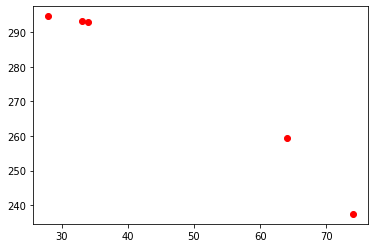

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  80
fixed Jt:  1.2
fixed Nf:  440
fixed Bk:  5.4
start Tn:  80
start Jt:  0.96
start Nf:  456
start Bk:  5.22
stepping:  230
Temperature:  [13.]
rewaRD::  -100
stepping:  230
Temperature:  [13. 23.]
rewaRD::  -100
stepping:  230
Temperature:  [13. 23. 48.]
rewaRD::  -100
stepping:  230
Temperature:  [13. 23. 48. 68.]
rewaRD::  -100
stepping:  230
Temperature:  [13. 23. 48. 68. 88.]
ORDER PARAM RESULT (X2): 80.00000000000769
THE JT RESULT {X0}: 1.1999999999999038
THE NF RESULT {X1}: 440.0
THE BK RESULT {X3}: 5.4
chisqds:  4.0256455479528045e-23


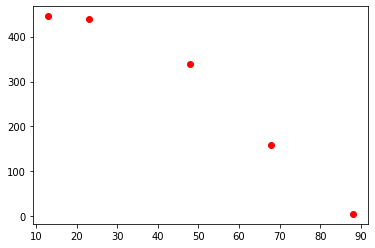

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  100
fixed Jt:  1.1
fixed Nf:  410
fixed Bk:  7.4
start Tn:  94
start Jt:  1.16
start Nf:  418
start Bk:  7.38
stepping:  231
Temperature:  [28.]
rewaRD::  -100
stepping:  231
Temperature:  [28. 48.]
rewaRD::  -100
stepping:  231
Temperature:  [28. 48. 68.]
rewaRD::  -100
stepping:  231
Temperature:  [28. 48. 68. 83.]
rewaRD::  -100
stepping:  231
Temperature:  [ 28.  48.  68.  83. 103.]
ORDER PARAM RESULT (X2): 99.9999999999058
THE JT RESULT {X0}: 1.100000000000428
THE NF RESULT {X1}: 409.9999999999886
THE BK RESULT {X3}: 7.4
chisqds:  3.300485723376271e-21


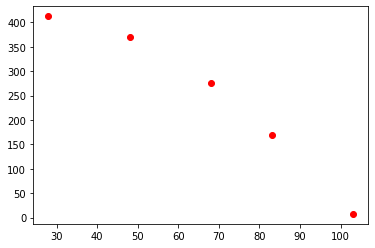

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  270
fixed Jt:  1.2
fixed Nf:  150
fixed Bk:  5.8
start Tn:  280
start Jt:  1.06
start Nf:  132
start Bk:  5.92
stepping:  232
Temperature:  [13.]
rewaRD::  -100
stepping:  232
Temperature:  [13. 28.]
rewaRD::  -100
stepping:  232
Temperature:  [13. 28. 58.]
rewaRD::  -100
stepping:  232
Temperature:  [13. 28. 58. 88.]
rewaRD::  -100
stepping:  232
Temperature:  [ 13.  28.  58.  88. 103.]
ORDER PARAM RESULT (X2): 299.97671386360577
THE JT RESULT {X0}: 0.7494386815127392
THE NF RESULT {X1}: 133.91449205223554
THE BK RESULT {X3}: 7.812773492842749
chisqds:  5.074004037656756


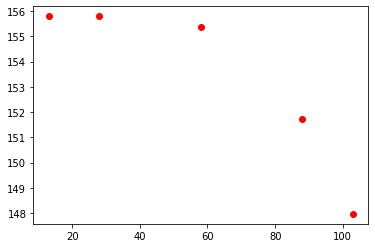

rewaRD::  -21.166795092909425
stepping:  232
Temperature:  [ 13.  28.  58.  88. 103. 113.]
ORDER PARAM RESULT (X2): 297.0428621265245
THE JT RESULT {X0}: 0.7769314142568522
THE NF RESULT {X1}: 134.12527272877702
THE BK RESULT {X3}: 7.999887681152234
chisqds:  2.5709742622987184


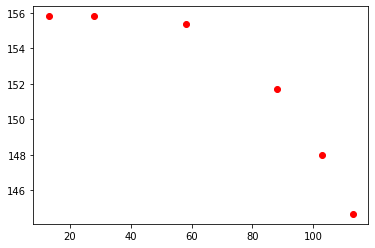

rewaRD::  55.58304330995455
stepping:  232
Temperature:  [ 13.  28.  58.  88. 103. 113. 118.]
ORDER PARAM RESULT (X2): 294.80265822739756
THE JT RESULT {X0}: 0.8011312350358148
THE NF RESULT {X1}: 134.14109692538773
THE BK RESULT {X3}: 7.99951133225223
chisqds:  1.8281319814270713


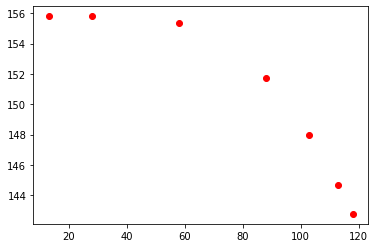

rewaRD::  118.80258321817286
stepping:  232
Temperature:  [ 13.  28.  58.  88. 103. 113. 118. 143.]
ORDER PARAM RESULT (X2): 289.3974662746211
THE JT RESULT {X0}: 0.8502698711939328
THE NF RESULT {X1}: 134.18136013642462
THE BK RESULT {X3}: 7.999314688759064
chisqds:  1.4442018831439878


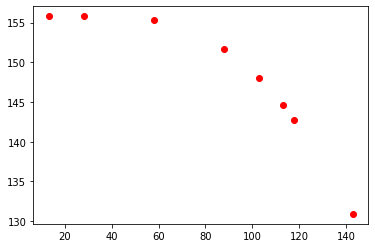

rewaRD::  176.96958761001684
stepping:  232
Temperature:  [ 13.  28.  58.  88. 103. 113. 118. 143. 153.]
ORDER PARAM RESULT (X2): 286.9597113697539
THE JT RESULT {X0}: 0.8830451579125478
THE NF RESULT {X1}: 134.24518685242273
THE BK RESULT {X3}: 7.999496089303999
chisqds:  1.1898113829577732


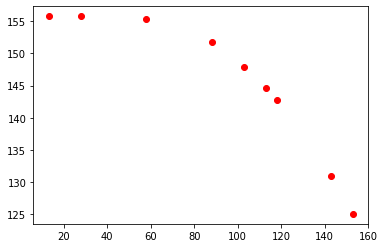

rewaRD::  236.18774011527182
stepping:  232
Temperature:  [ 13.  28.  58.  88. 103. 113. 118. 143. 153. 183.]
ORDER PARAM RESULT (X2): 283.66483516760314
THE JT RESULT {X0}: 0.9162550983142402
THE NF RESULT {X1}: 134.37526360822207
THE BK RESULT {X3}: 7.999451412603513
chisqds:  1.0272519767239465


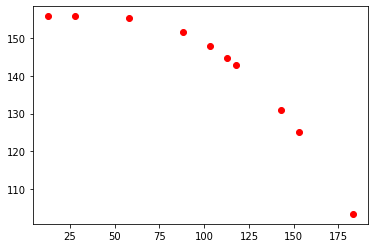

rewaRD::  289.3883964824845
stepping:  232
Temperature:  [ 13.  28.  58.  88. 103. 113. 118. 143. 153. 183. 184.]
ORDER PARAM RESULT (X2): 282.80227562620246
THE JT RESULT {X0}: 0.9336673911638599
THE NF RESULT {X1}: 134.48439915257214
THE BK RESULT {X3}: 7.999310441467317
chisqds:  0.8828455618483747


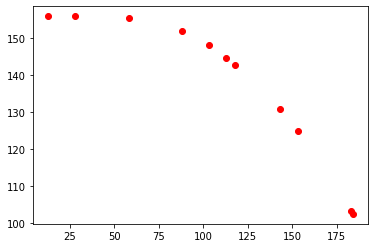

rewaRD::  300
stepping:  232
Temperature:  [ 13.  28.  58.  88. 103. 113. 118. 143. 153. 183. 184. 199.]
ORDER PARAM RESULT (X2): 281.0636996811097
THE JT RESULT {X0}: 0.9627805223295407
THE NF RESULT {X1}: 134.7494853269813
THE BK RESULT {X3}: 7.999309812331297
chisqds:  0.7752116451831249


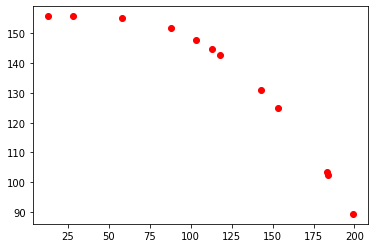

rewaRD::  300
stepping:  232
Temperature:  [ 13.  28.  58.  88. 103. 113. 118. 143. 153. 183. 184. 199. 200.]
ORDER PARAM RESULT (X2): 280.529583464637
THE JT RESULT {X0}: 0.9755561213535334
THE NF RESULT {X1}: 134.9441251294437
THE BK RESULT {X3}: 7.99938162160802
chisqds:  0.6825839146429317


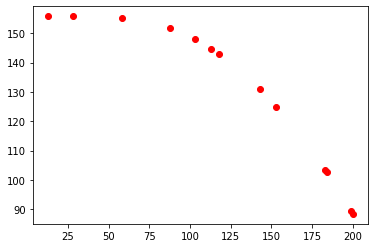

rewaRD::  300
stepping:  232
Temperature:  [ 13.  28.  58.  88. 103. 113. 118. 143. 153. 183. 184. 199. 200. 210.]
ORDER PARAM RESULT (X2): 279.8825848189643
THE JT RESULT {X0}: 0.9880683663386942
THE NF RESULT {X1}: 135.2286336970616
THE BK RESULT {X3}: 7.999788374015562
chisqds:  0.6093966558591373


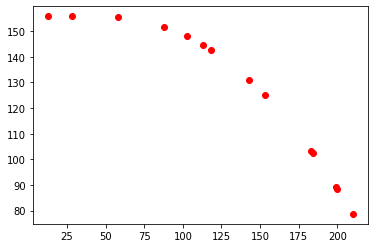

rewaRD::  300
stepping:  232
Temperature:  [ 13.  28.  58.  88. 103. 113. 118. 143. 153. 183. 184. 199. 200. 210.
 220.]
ORDER PARAM RESULT (X2): 279.0622225631662
THE JT RESULT {X0}: 1.0019879366986222
THE NF RESULT {X1}: 135.6699137632151
THE BK RESULT {X3}: 7.999318456238149
chisqds:  0.5491429881091079


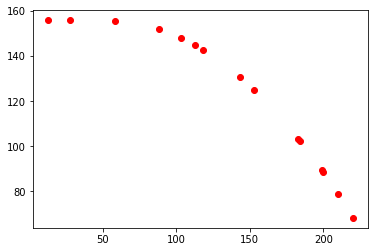

rewaRD::  300
stepping:  232
Temperature:  [ 13.  28.  58.  88. 103. 113. 118. 143. 153. 183. 184. 199. 200. 210.
 220. 225.]
ORDER PARAM RESULT (X2): 278.13779080393783
THE JT RESULT {X0}: 1.0201181374806352
THE NF RESULT {X1}: 136.29216095880358
THE BK RESULT {X3}: 7.999539358097908
chisqds:  0.48622735511175846


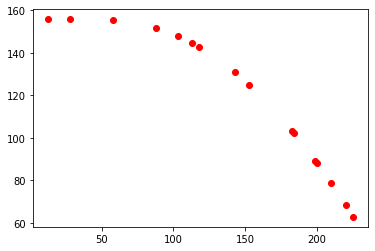

rewaRD::  300
stepping:  232
Temperature:  [ 13.  28.  58.  88. 103. 113. 118. 143. 153. 183. 184. 199. 200. 210.
 220. 225. 226.]
ORDER PARAM RESULT (X2): 277.32709590764216
THE JT RESULT {X0}: 1.0385194137710558
THE NF RESULT {X1}: 137.00177490837578
THE BK RESULT {X3}: 7.999971828938757
chisqds:  0.42150138031498724


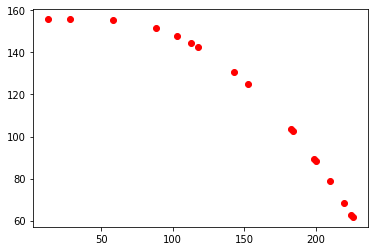

rewaRD::  300
stepping:  232
Temperature:  [ 13.  28.  58.  88. 103. 113. 118. 143. 153. 183. 184. 199. 200. 210.
 220. 225. 226. 241.]
ORDER PARAM RESULT (X2): 274.6736999547863
THE JT RESULT {X0}: 1.0769664724987253
THE NF RESULT {X1}: 139.36327705372494
THE BK RESULT {X3}: 7.999245804444036
chisqds:  0.2684519998905285


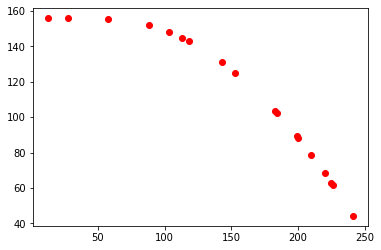

rewaRD::  300
stepping:  232
Temperature:  [ 13.  28.  58.  88. 103. 113. 118. 143. 153. 183. 184. 199. 200. 210.
 220. 225. 226. 241. 266.]
ORDER PARAM RESULT (X2): 270.0000000001163
THE JT RESULT {X0}: 1.2000000000006412
THE NF RESULT {X1}: 150.00000000016416
THE BK RESULT {X3}: 5.799999999835777
chisqds:  3.540341939999948e-27


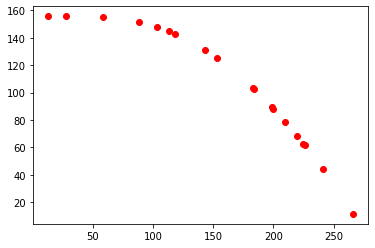

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  90
fixed Jt:  0.7
fixed Nf:  190
fixed Bk:  5.0
start Tn:  72
start Jt:  0.94
start Nf:  172
start Bk:  4.9
stepping:  233
Temperature:  [28.]
rewaRD::  -100
stepping:  233
Temperature:  [28. 53.]
rewaRD::  -100
stepping:  233
Temperature:  [28. 53. 73.]
rewaRD::  -100
stepping:  233
Temperature:  [28. 53. 73. 74.]
rewaRD::  -100
stepping:  233
Temperature:  [28. 53. 73. 74. 84.]
ORDER PARAM RESULT (X2): 72.97790703718744
THE JT RESULT {X0}: 0.7709925459190058
THE NF RESULT {X1}: 174.3344785202085
THE BK RESULT {X3}: 7.999560754564014
chisqds:  189.7099348289027


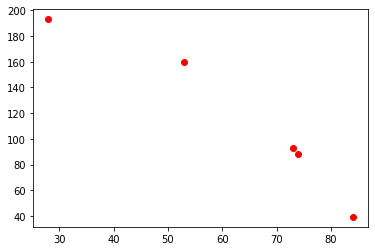

rewaRD::  -97.89151790937699
stepping:  233
Temperature:  [ 28.  53.  73.  74.  84. 104.]
ORDER PARAM RESULT (X2): 75.00673923171708
THE JT RESULT {X0}: 0.40000026294665636
THE NF RESULT {X1}: 179.28737959668257
THE BK RESULT {X3}: 7.270314328302876
chisqds:  74.56941574727902


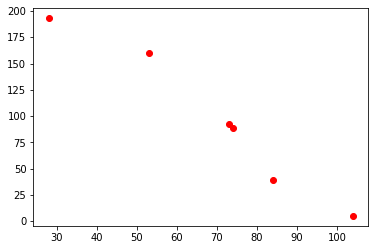

rewaRD::  -94.63587053765275
stepping:  233
Temperature:  [ 28.  53.  73.  74.  84. 104. 134.]
ORDER PARAM RESULT (X2): 74.89597213254653
THE JT RESULT {X0}: 0.40000196756830714
THE NF RESULT {X1}: 179.39698794567443
THE BK RESULT {X3}: 6.178590784627246
chisqds:  52.370013625202546


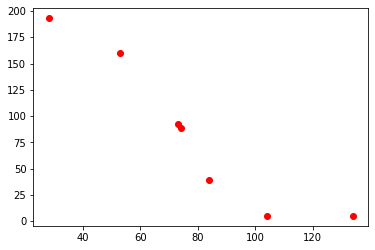

rewaRD::  -92.36204132267966
stepping:  233
Temperature:  [ 28.  53.  73.  74.  84. 104. 134. 154.]
ORDER PARAM RESULT (X2): 74.90107189729397
THE JT RESULT {X0}: 0.4000008449508011
THE NF RESULT {X1}: 179.41023581585281
THE BK RESULT {X3}: 5.793925251902107
chisqds:  39.727762373144216


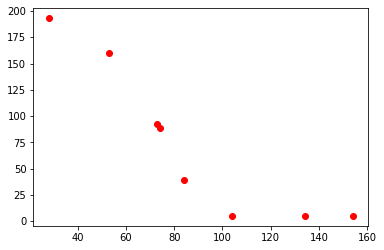

rewaRD::  -89.9314742108305
--------------------------------------
| approxkl           | 2.3333225e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 8.21          |
| ep_reward_mean     | 552           |
| explained_variance | 0.000408      |
| fps                | 4             |
| n_updates          | 14            |
| policy_entropy     | 1.9382807     |
| policy_loss        | 0.0004573135  |
| serial_timesteps   | 1792          |
| time_elapsed       | 289           |
| total_timesteps    | 1792          |
| value_loss         | 681796.7      |
--------------------------------------
stepping:  233
Temperature:  [ 28.  53.  73.  74.  84. 104. 134. 154. 155.]
ORDER PARAM RESULT (X2): 74.91307816629266
THE JT RESULT {X0}: 0.40000035430363345
THE NF RESULT {X1}: 179.42146261436068
THE BK RESULT {X3}: 5.591184458315337
chisqds:  31.926504547624347


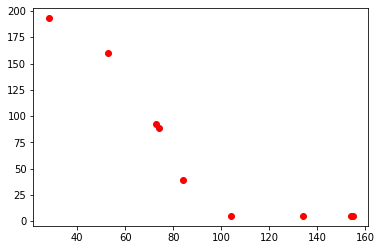

rewaRD::  -87.47122474985242
stepping:  233
Temperature:  [ 28.  53.  73.  74.  84. 104. 134. 154. 155. 160.]
ORDER PARAM RESULT (X2): 74.92489566457303
THE JT RESULT {X0}: 0.4000017637698551
THE NF RESULT {X1}: 179.43044466095176
THE BK RESULT {X3}: 5.465486461851179
chisqds:  26.662065975710487


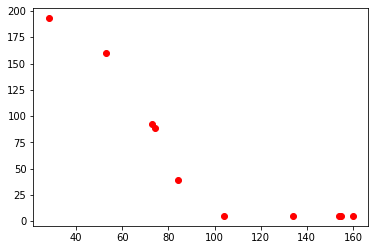

rewaRD::  -84.99741166478226
stepping:  233
Temperature:  [ 28.  53.  73.  74.  84. 104. 134. 154. 155. 160. 161.]
ORDER PARAM RESULT (X2): 74.93497566460805
THE JT RESULT {X0}: 0.4000007835510053
THE NF RESULT {X1}: 179.43767549470343
THE BK RESULT {X3}: 5.379729257441478
chisqds:  22.879224269140167


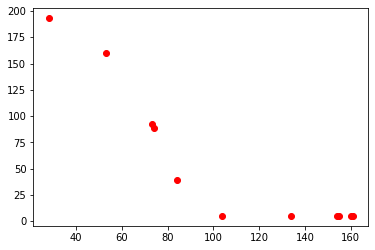

rewaRD::  -82.51688976450457
stepping:  233
Temperature:  [ 28.  53.  73.  74.  84. 104. 134. 154. 155. 160. 161. 186.]
ORDER PARAM RESULT (X2): 74.94300461186432
THE JT RESULT {X0}: 0.400000444003902
THE NF RESULT {X1}: 179.44319578411555
THE BK RESULT {X3}: 5.317370704356217
chisqds:  20.03374807017704


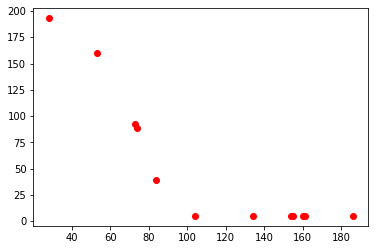

rewaRD::  -80.03369121949504
stepping:  233
Temperature:  [ 28.  53.  73.  74.  84. 104. 134. 154. 155. 160. 161. 186. 191.]
ORDER PARAM RESULT (X2): 74.95079859021516
THE JT RESULT {X0}: 0.4000008134176151
THE NF RESULT {X1}: 179.44825639726275
THE BK RESULT {X3}: 5.270105003568273
chisqds:  17.812852288000656


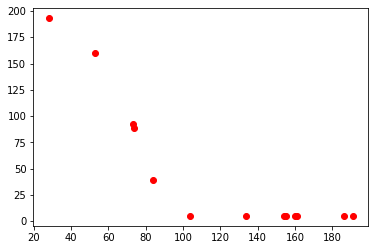

rewaRD::  -77.54430376827109
stepping:  233
Temperature:  [ 28.  53.  73.  74.  84. 104. 134. 154. 155. 160. 161. 186. 191. 216.]
ORDER PARAM RESULT (X2): 74.95802986908852
THE JT RESULT {X0}: 0.40000009456638147
THE NF RESULT {X1}: 179.45272336748087
THE BK RESULT {X3}: 5.232996413535218
chisqds:  16.0324427304585


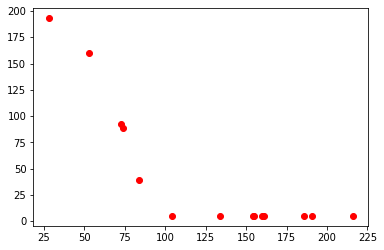

rewaRD::  -75.05058918812924
stepping:  233
Temperature:  [ 28.  53.  73.  74.  84. 104. 134. 154. 155. 160. 161. 186. 191. 216.
 217.]
ORDER PARAM RESULT (X2): 74.9646278596738
THE JT RESULT {X0}: 0.40000001285556297
THE NF RESULT {X1}: 179.4567096946173
THE BK RESULT {X3}: 5.2030770758185225
chisqds:  14.573895006873487


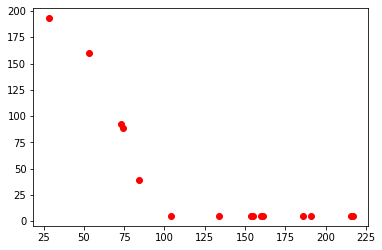

rewaRD::  -72.55366531655758
stepping:  233
Temperature:  [ 28.  53.  73.  74.  84. 104. 134. 154. 155. 160. 161. 186. 191. 216.
 217. 247.]
ORDER PARAM RESULT (X2): 74.97121561573019
THE JT RESULT {X0}: 0.4000001171519416
THE NF RESULT {X1}: 179.46055913784485
THE BK RESULT {X3}: 5.178478927800247
chisqds:  13.35624939520082


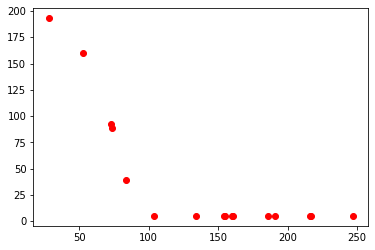

rewaRD::  -70.05147267288012
stepping:  233
Temperature:  [ 28.  53.  73.  74.  84. 104. 134. 154. 155. 160. 161. 186. 191. 216.
 217. 247. 272.]
ORDER PARAM RESULT (X2): 74.97255602445787
THE JT RESULT {X0}: 0.4000001103825724
THE NF RESULT {X1}: 179.4612447973968
THE BK RESULT {X3}: 5.157537162720404
chisqds:  12.334451506258594


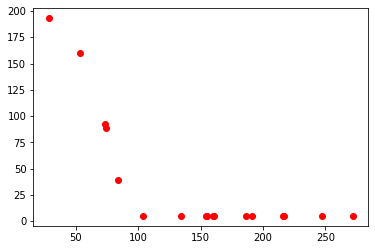

rewaRD::  -67.57050771191268
stepping:  233
Temperature:  [ 28.  53.  73.  74.  84. 104. 134. 154. 155. 160. 161. 186. 191. 216.
 217. 247. 272. 287.]
ORDER PARAM RESULT (X2): 74.97850588243918
THE JT RESULT {X0}: 0.4000001518110361
THE NF RESULT {X1}: 179.4644968614865
THE BK RESULT {X3}: 5.140050378438497
chisqds:  11.449307704272831


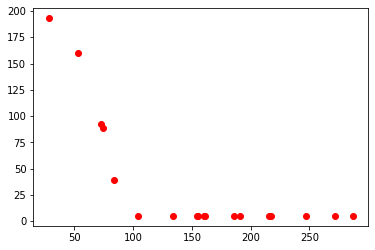

rewaRD::  -65.06338982830187
stepping:  233
Temperature:  [ 28.  53.  73.  74.  84. 104. 134. 154. 155. 160. 161. 186. 191. 216.
 217. 247. 272. 287. 297.]
ORDER PARAM RESULT (X2): 74.98431400792309
THE JT RESULT {X0}: 0.40000003197469575
THE NF RESULT {X1}: 179.46764653592197
THE BK RESULT {X3}: 5.125015073337738
chisqds:  10.68159765673751


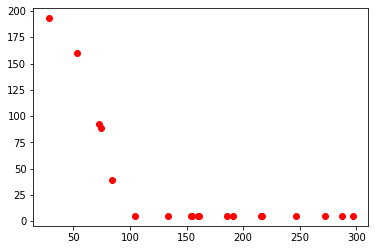

rewaRD::  -62.55241838774029
stepping:  233
Temperature:  [ 28.  53.  73.  74.  84. 104. 134. 154. 155. 160. 161. 186. 191. 216.
 217. 247. 272. 287. 297. 298.]
ORDER PARAM RESULT (X2): 74.98946073734113
THE JT RESULT {X0}: 0.40000078383291626
THE NF RESULT {X1}: 179.47035558436198
THE BK RESULT {X3}: 5.1119203022393815
chisqds:  10.010269986418141


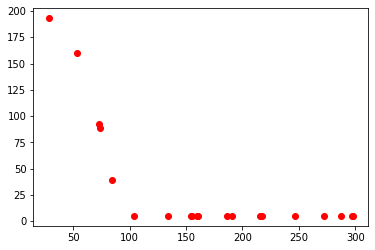

rewaRD::  -60.0410377999078
stepping:  233
Temperature:  [ 28.  53.  73.  74.  84. 104. 134. 154. 155. 160. 161. 186. 191. 216.
 217. 247. 272. 287. 297. 298. 313.]
ORDER PARAM RESULT (X2): 74.99553395605737
THE JT RESULT {X0}: 0.4000009472975104
THE NF RESULT {X1}: 179.4735115206202
THE BK RESULT {X3}: 5.10049511938473
chisqds:  9.41609956056593


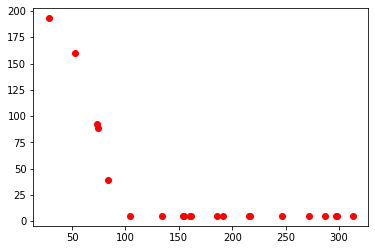

rewaRD::  -57.51956556670488
stepping:  233
Temperature:  [ 28.  53.  73.  74.  84. 104. 134. 154. 155. 160. 161. 186. 191. 216.
 217. 247. 272. 287. 297. 298. 313. 328.]
ORDER PARAM RESULT (X2): 75.00112309778508
THE JT RESULT {X0}: 0.40000040722457475
THE NF RESULT {X1}: 179.47645349329807
THE BK RESULT {X3}: 5.090368999132709
chisqds:  8.888247934405307


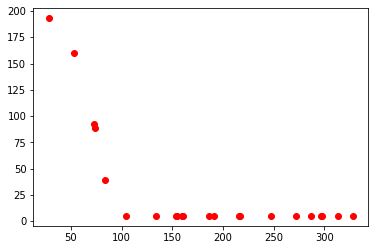

rewaRD::  -54.99675493393366
stepping:  233
Temperature:  [ 28.  53.  73.  74.  84. 104. 134. 154. 155. 160. 161. 186. 191. 216.
 217. 247. 272. 287. 297. 298. 313. 328. 353.]
ORDER PARAM RESULT (X2): 75.00656003625471
THE JT RESULT {X0}: 0.40000087400948536
THE NF RESULT {X1}: 179.47928977495903
THE BK RESULT {X3}: 5.081348166972186
chisqds:  8.415869452065118


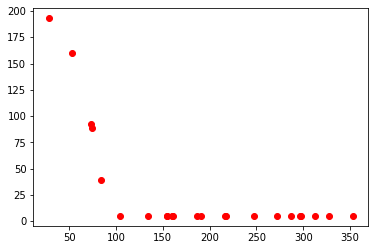

rewaRD::  -52.47074562190999
terminated: over max temp
reset
fixed Tn:  130
fixed Jt:  0.7
fixed Nf:  310
fixed Bk:  3.4
start Tn:  110
start Jt:  0.48
start Nf:  308
start Bk:  3.48
stepping:  234
Temperature:  [33.]
rewaRD::  -100
stepping:  234
Temperature:  [33. 48.]
rewaRD::  -100
stepping:  234
Temperature:  [33. 48. 78.]
rewaRD::  -100
stepping:  234
Temperature:  [ 33.  48.  78. 108.]
rewaRD::  -100
stepping:  234
Temperature:  [ 33.  48.  78. 108. 123.]
ORDER PARAM RESULT (X2): 110.6962056782982
THE JT RESULT {X0}: 0.4000003610445789
THE NF RESULT {X1}: 309.04584353295854
THE BK RESULT {X3}: 6.031092737583591
chisqds:  124.61925942461625


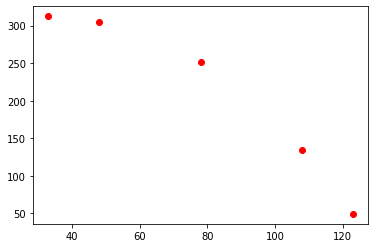

rewaRD::  -96.79022326206356
stepping:  234
Temperature:  [ 33.  48.  78. 108. 123. 153.]
ORDER PARAM RESULT (X2): 129.99999999992173
THE JT RESULT {X0}: 0.7000000000005205
THE NF RESULT {X1}: 309.9999999999963
THE BK RESULT {X3}: 3.4
chisqds:  2.7240943809682146e-21


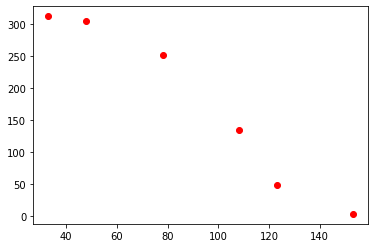

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  70
fixed Jt:  0.7
fixed Nf:  160
fixed Bk:  5.6
start Tn:  58
start Jt:  0.72
start Nf:  140
start Bk:  5.76
stepping:  235
Temperature:  [23.]
rewaRD::  -100
stepping:  235
Temperature:  [23. 24.]
rewaRD::  -100
stepping:  235
Temperature:  [23. 24. 39.]
rewaRD::  -100
stepping:  235
Temperature:  [23. 24. 39. 64.]
rewaRD::  -100
stepping:  235
Temperature:  [23. 24. 39. 64. 84.]
ORDER PARAM RESULT (X2): 60.014309167283976
THE JT RESULT {X0}: 0.400000191509705
THE NF RESULT {X1}: 143.77465147539405
THE BK RESULT {X3}: 6.583400583962192
chisqds:  37.351852142234115


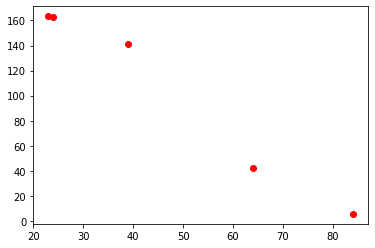

rewaRD::  -89.29102635990262
stepping:  235
Temperature:  [ 23.  24.  39.  64.  84. 109.]
ORDER PARAM RESULT (X2): 70.00000000000021
THE JT RESULT {X0}: 0.6999999999999991
THE NF RESULT {X1}: 160.00000000000006
THE BK RESULT {X3}: 5.6
chisqds:  1.584974148062518e-26


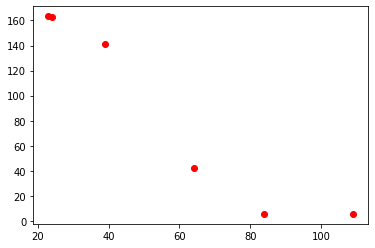

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  260
fixed Jt:  1.2
fixed Nf:  380
fixed Bk:  4.8
start Tn:  252
start Jt:  1.26
start Nf:  384
start Bk:  4.78
stepping:  236
Temperature:  [23.]
rewaRD::  -100
stepping:  236
Temperature:  [23. 43.]
rewaRD::  -100
stepping:  236
Temperature:  [23. 43. 44.]
rewaRD::  -100
stepping:  236
Temperature:  [23. 43. 44. 59.]
rewaRD::  -100
stepping:  236
Temperature:  [23. 43. 44. 59. 74.]
ORDER PARAM RESULT (X2): 260.00000000119087
THE JT RESULT {X0}: 1.2000000000104958
THE NF RESULT {X1}: 380.0000000032886
THE BK RESULT {X3}: 4.799999996711486
chisqds:  2.947438633940162e-26


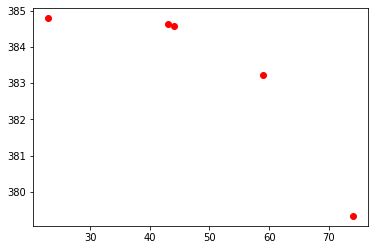

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  110
fixed Jt:  1.3
fixed Nf:  270
fixed Bk:  5.2
start Tn:  98
start Jt:  1.58
start Nf:  254
start Bk:  5.2
stepping:  237
Temperature:  [23.]
rewaRD::  -100
stepping:  237
Temperature:  [23. 28.]
rewaRD::  -100
stepping:  237
Temperature:  [23. 28. 38.]
rewaRD::  -100
stepping:  237
Temperature:  [23. 28. 38. 58.]
rewaRD::  -100
stepping:  237
Temperature:  [23. 28. 38. 58. 73.]
ORDER PARAM RESULT (X2): 99.56696683678535
THE JT RESULT {X0}: 1.3452343690409103
THE NF RESULT {X1}: 257.0475053794692
THE BK RESULT {X3}: 7.999493718848527
chisqds:  10.684543873894555


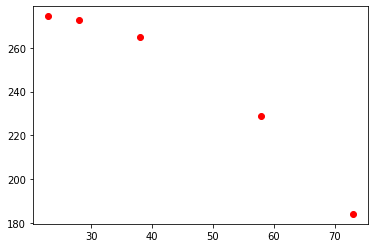

rewaRD::  -62.56274439779163
stepping:  237
Temperature:  [23. 28. 38. 58. 73. 98.]
ORDER PARAM RESULT (X2): 98.73063935723887
THE JT RESULT {X0}: 1.4262580611929376
THE NF RESULT {X1}: 255.9258849859991
THE BK RESULT {X3}: 7.999491042442314
chisqds:  32.5257944531486


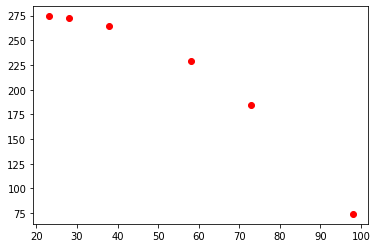

rewaRD::  -87.70206825920346
stepping:  237
Temperature:  [ 23.  28.  38.  58.  73.  98. 103.]
ORDER PARAM RESULT (X2): 98.73967704654935
THE JT RESULT {X0}: 1.424612880909679
THE NF RESULT {X1}: 255.94506409363444
THE BK RESULT {X3}: 7.999627936395464
chisqds:  32.34672884263131


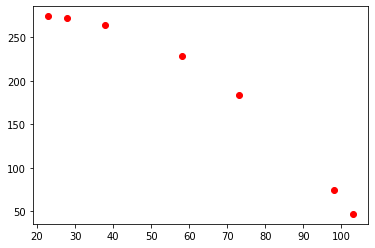

rewaRD::  -87.63398914474404
stepping:  237
Temperature:  [ 23.  28.  38.  58.  73.  98. 103. 123.]
ORDER PARAM RESULT (X2): 101.83493540926634
THE JT RESULT {X0}: 0.9311859434529958
THE NF RESULT {X1}: 262.15325602312464
THE BK RESULT {X3}: 7.999918032165289
chisqds:  14.304555169801091


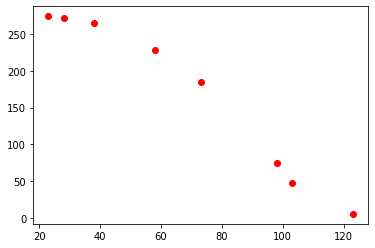

rewaRD::  -72.03687949385132
stepping:  237
Temperature:  [ 23.  28.  38.  58.  73.  98. 103. 123. 138.]
ORDER PARAM RESULT (X2): 109.9999999999999
THE JT RESULT {X0}: 1.2999999999999747
THE NF RESULT {X1}: 269.99999999999983
THE BK RESULT {X3}: 5.2
chisqds:  2.8583341658487037e-27


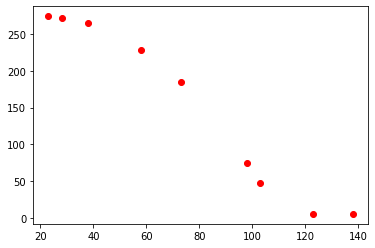

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  80
fixed Jt:  1.2
fixed Nf:  350
fixed Bk:  3.6
start Tn:  78
start Jt:  1.3
start Nf:  344
start Bk:  3.78
stepping:  238
Temperature:  [33.]
rewaRD::  -100
stepping:  238
Temperature:  [33. 53.]
rewaRD::  -100
stepping:  238
Temperature:  [33. 53. 78.]
rewaRD::  -100
stepping:  238
Temperature:  [ 33.  53.  78. 108.]
rewaRD::  -100
stepping:  238
Temperature:  [ 33.  53.  78. 108. 113.]
ORDER PARAM RESULT (X2): 79.99999999999993
THE JT RESULT {X0}: 1.1999999999999982
THE NF RESULT {X1}: 349.9999999999998
THE BK RESULT {X3}: 3.6
chisqds:  8.602742059854997e-25


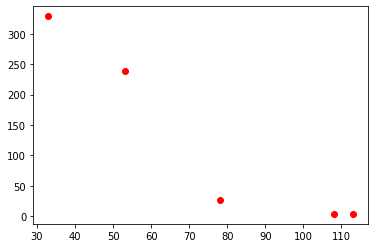

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  80
fixed Jt:  0.9
fixed Nf:  370
fixed Bk:  7.2
start Tn:  96
start Jt:  0.76
start Nf:  366
start Bk:  7.24
stepping:  239
Temperature:  [18.]
rewaRD::  -100
stepping:  239
Temperature:  [18. 48.]
rewaRD::  -100
stepping:  239
Temperature:  [18. 48. 73.]
rewaRD::  -100
stepping:  239
Temperature:  [18. 48. 73. 98.]
rewaRD::  -100
stepping:  239
Temperature:  [ 18.  48.  73.  98. 123.]
ORDER PARAM RESULT (X2): 79.99999999996983
THE JT RESULT {X0}: 0.9000000000003476
THE NF RESULT {X1}: 369.999999999999
THE BK RESULT {X3}: 7.2
chisqds:  1.1066164710402226e-21


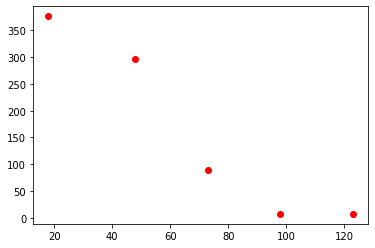

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  200
fixed Jt:  1.1
fixed Nf:  160
fixed Bk:  5.2
start Tn:  196
start Jt:  0.86
start Nf:  168
start Bk:  5.02
stepping:  240
Temperature:  [18.]
rewaRD::  -100
stepping:  240
Temperature:  [18. 43.]
rewaRD::  -100
stepping:  240
Temperature:  [18. 43. 58.]
rewaRD::  -100
stepping:  240
Temperature:  [18. 43. 58. 88.]
rewaRD::  -100
stepping:  240
Temperature:  [18. 43. 58. 88. 89.]
ORDER PARAM RESULT (X2): 200.00000000051804
THE JT RESULT {X0}: 1.1000000000042827
THE NF RESULT {X1}: 160.00000000094548
THE BK RESULT {X3}: 5.199999999054536
chisqds:  5.7589590909476795e-25


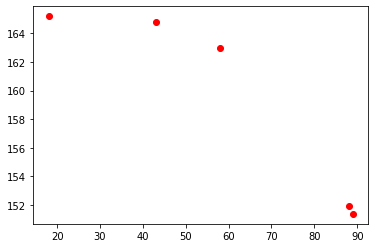

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  180
fixed Jt:  1.2
fixed Nf:  390
fixed Bk:  3.4
start Tn:  174
start Jt:  0.98
start Nf:  378
start Bk:  3.32
stepping:  241
Temperature:  [28.]
rewaRD::  -100
stepping:  241
Temperature:  [28. 43.]
rewaRD::  -100
stepping:  241
Temperature:  [28. 43. 58.]
rewaRD::  -100
stepping:  241
Temperature:  [28. 43. 58. 63.]
rewaRD::  -100
stepping:  241
Temperature:  [28. 43. 58. 63. 78.]
ORDER PARAM RESULT (X2): 174.96796508511687
THE JT RESULT {X0}: 0.9294200820891393
THE NF RESULT {X1}: 382.92945165502607
THE BK RESULT {X3}: 7.9994194033090835
chisqds:  0.027504747506222962


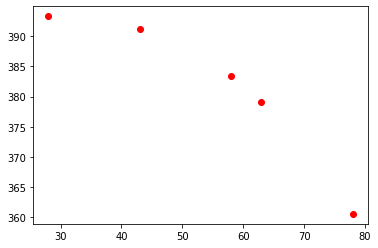

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  90
fixed Jt:  0.8
fixed Nf:  180
fixed Bk:  5.0
start Tn:  90
start Jt:  0.9
start Nf:  188
start Bk:  5.0
stepping:  242
Temperature:  [18.]
rewaRD::  -100
stepping:  242
Temperature:  [18. 38.]
rewaRD::  -100
stepping:  242
Temperature:  [18. 38. 68.]
rewaRD::  -100
stepping:  242
Temperature:  [18. 38. 68. 88.]
rewaRD::  -100
stepping:  242
Temperature:  [ 18.  38.  68.  88. 118.]
ORDER PARAM RESULT (X2): 90.00000000000026
THE JT RESULT {X0}: 0.8000000000000366
THE NF RESULT {X1}: 180.0000000000001
THE BK RESULT {X3}: 5.0
chisqds:  1.0830570112922063e-26


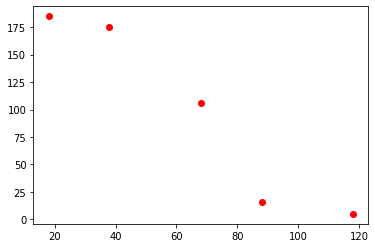

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  140
fixed Jt:  0.8
fixed Nf:  400
fixed Bk:  6.2
start Tn:  152
start Jt:  0.64
start Nf:  402
start Bk:  6.08
stepping:  243
Temperature:  [18.]
rewaRD::  -100
stepping:  243
Temperature:  [18. 33.]
rewaRD::  -100
stepping:  243
Temperature:  [18. 33. 58.]
rewaRD::  -100
stepping:  243
Temperature:  [18. 33. 58. 88.]
rewaRD::  -100
stepping:  243
Temperature:  [18. 33. 58. 88. 89.]
ORDER PARAM RESULT (X2): 139.99999999995396
THE JT RESULT {X0}: 0.7999999999995148
THE NF RESULT {X1}: 399.9999999996416
THE BK RESULT {X3}: 6.200000000358472
chisqds:  1.1468896301391552e-27


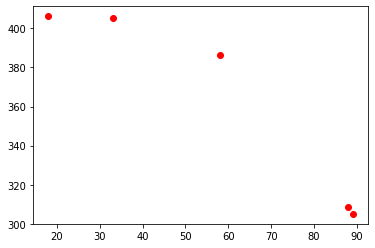

rewaRD::  300
terminated: excellent conditions
reset
fixed Tn:  170
fixed Jt:  1.0
fixed Nf:  310
fixed Bk:  6.6
start Tn:  182
start Jt:  0.84
start Nf:  290
start Bk:  6.62
stepping:  244
Temperature:  [18.]
rewaRD::  -100
stepping:  244
Temperature:  [18. 19.]
rewaRD::  -100
stepping:  244
Temperature:  [18. 19. 44.]
rewaRD::  -100
stepping:  244
Temperature:  [18. 19. 44. 45.]
rewaRD::  -100
stepping:  244
Temperature:  [18. 19. 44. 45. 46.]
ORDER PARAM RESULT (X2): 202.43453779530134
THE JT RESULT {X0}: 0.49375605529789535
THE NF RESULT {X1}: 291.3885637370875
THE BK RESULT {X3}: 7.999510035623457
chisqds:  4.063002424777901


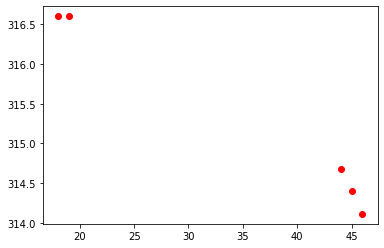

rewaRD::  -1.550637144435001
stepping:  244
Temperature:  [18. 19. 44. 45. 46. 76.]
ORDER PARAM RESULT (X2): 184.59980907879708
THE JT RESULT {X0}: 0.7710169616149255
THE NF RESULT {X1}: 291.4012735832849
THE BK RESULT {X3}: 7.999249081210111
chisqds:  2.168791625767298


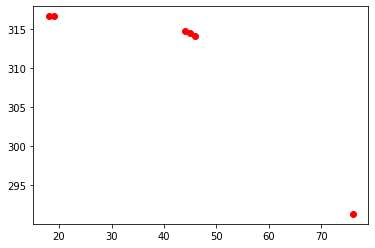

rewaRD::  84.43450041378858
stepping:  244
Temperature:  [ 18.  19.  44.  45.  46.  76. 101.]
ORDER PARAM RESULT (X2): 182.073186718838
THE JT RESULT {X0}: 0.8272001094641799
THE NF RESULT {X1}: 291.4916506333535
THE BK RESULT {X3}: 7.999321756921738
chisqds:  1.5003009064769894


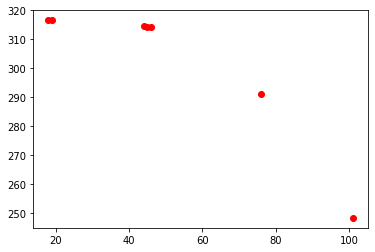

rewaRD::  166.61318291094085
stepping:  244
Temperature:  [ 18.  19.  44.  45.  46.  76. 101. 126.]
ORDER PARAM RESULT (X2): 180.68300964240706
THE JT RESULT {X0}: 0.8816676817881305
THE NF RESULT {X1}: 291.89156296138
THE BK RESULT {X3}: 7.999436420347095
chisqds:  1.4105343764643812


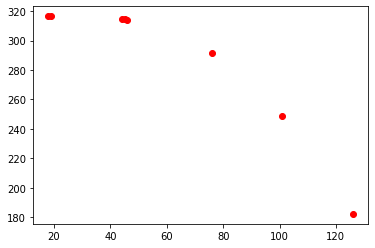

rewaRD::  183.58046898696114
stepping:  244
Temperature:  [ 18.  19.  44.  45.  46.  76. 101. 126. 156.]
ORDER PARAM RESULT (X2): 170.0000000000523
THE JT RESULT {X0}: 1.000000000000319
THE NF RESULT {X1}: 310.0000000002148
THE BK RESULT {X3}: 6.59999999978534
chisqds:  3.808629616896181e-24


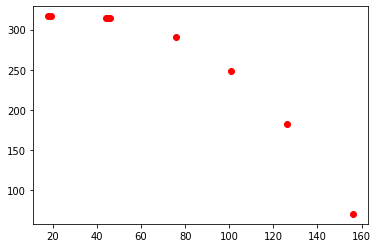

rewaRD::  300
terminated: excellent conditions


In [ ]:
model = PPO2('MlpPolicy', env, verbose=1).learn(8000)

In [ ]:
model.save("models/like5_randtn_newfix")

NameError: ignored

Restart the training from a saved model.

In [ ]:
model = PPO2.load("models/unk_rand_params", env)  #if needed, instatiate env above
model = model.learn(500)

Test the trained agent.

In [ ]:
from stable_baselines import PPO2, A2C
from stable_baselines.common.cmd_util import make_vec_env

data = [[] for i in range(5)]

model = PPO2.load("models/1108_multi_params") #if you're 'playing' a saved model
for tns in np.arange(120,200, 10): #these need to be reduced.
  for jts in np.arange(.7, 1.5, .1):
    for nfs in np.arange(230, 380, 20):
      for bks in np.arange(.1, 8, .7):
        env = OrderEnv() 
        env.setTn(tns)
        env.setJt(jts)
        env.setNf(nfs)
        # wrap it
        vec_env = make_vec_env(lambda: env, n_envs=1) 
        finalTn = 0
        finalJt = 0
        finalNf = 0
        finalBk = 0

        obs = vec_env.reset()
        n_steps = 20
        for step in range(n_steps):
          action, _ = model.predict(obs, deterministic=True)
          print("Step {}".format(step + 1))
          print("Action: ", action)
          obs, reward, done, info = vec_env.step(action)
          print('obs=', obs, 'reward=', reward, 'done=', done)
          if done:
            finalTn, finalJt, finalNf, finalBk = env.getVars()
            print("Goal reached!", "reward=", reward)
            break

        if abs(finalTn - tns) < 0.1 and abs(finalJt - jts) < 0.1 and abs(finalNf - nfs) < 0.1 and abs(finalBk - bks):
          #print("Success for tn: ", tns)
          success = 1
        else:
          #print("Fail for tn:", tns)
          success = 0
        data[0].append(tns)
        data[1].append(jts)
        data[2].append(nfs)
        data[3].append(bks)
        data[4].append(success)

print(data)
#np.savetxt('logs/successdata.npy', data)

In [ ]:
np.savetxt('logs/successdata_1108multi.npy', data)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
print(np.array(data[0]))

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(data[0], data[1], data[2], c = data[3])
plt.show()

Graph the results of the training time.

In [ ]:
numTrials = 399

endParams = [[] for i in range(numTrials)]
data = [[] for i in range(numTrials)]
chis = [[] for i in range(numTrials)]
nfs = [[] for i in range(numTrials)]
jts = [[] for i in range(numTrials)]
bks = [[] for i in range(numTrials)]
endtns = []
endnfs = []
endjts = []
endbks = []
tn = 160
nf = 216
jt = .2
convergs_tn = []
convergs_nf = []
convergs_jt = []
convergs_bk = []
imagestore = "logs/"
logstore = "logs/"

for i in range(1,numTrials+1):
  data[i-1] = np.loadtxt(logstore +  "temps/tnLog-" + str(i) + ".npy")
  chis[i-1] = np.loadtxt(logstore + "chis/chiLog-" + str(i) + ".npy")
  nfs[i-1] = np.loadtxt(logstore + "nf/nfLog-" + str(i) + ".npy")
  jts[i-1] = np.loadtxt(logstore + "jt/jtLog-" + str(i) + ".npy")
  bks[i-1] = np.loadtxt(logstore + "bk/bkLog-" + str(i) + ".npy")

#plot each episode tn track, process ending values for plotting below
for i in range (0, len(data)): 
  try:
    value = data[i][-1]
  except:
    value = data[i]
  try:
    nf = nfs[i][-1]
  except:
    nf = nfs[i]
  try:
    jt = jts[i][-1]
  except:
    jt = jts[i]
  try:
    bk = bks[i][-1]
  except:
    bk = bks[i]

  #print(value)
  endtns.append(value)
  endnfs.append(nf)
  endjts.append(jt)
  endbks.append(bk)
  #print(endtns)

plt.xlabel("measurement steps")
plt.ylabel("tn value")
plt.show()
#plt.savefig(imagestore + "tns.png")
plt.close()

convergs_tn = np.loadtxt("logs/convergsTn.npy")
convergs_nf = np.loadtxt("logs/convergsNf.npy")
convergs_jt = np.loadtxt("logs/convergsJt.npy")
convergs_bk = np.loadtxt("logs/convergsBk.npy")

print("convergence for tn")
plt.plot(convergs_tn, 'ro')
plt.xlabel("episodes")
plt.ylabel("step at which convergence is reached")
plt.show()
#plt.savefig(imagestore + 'convergs_tn.png')

print("convergence for nf")
plt.plot(convergs_nf, 'ro')
plt.xlabel("episodes")
plt.ylabel("step at which convergence is reached")
plt.show()
#plt.savefig(imagestore + 'convergs_nf.png')

print("convergence for jt")
plt.plot(convergs_jt, 'ro')
plt.xlabel("episodes")
plt.ylabel("step at which convergence is reached")
plt.show()
#plt.savefig(imagestore + 'convergs_jt.png')

print("convergence for bk")
plt.plot(convergs_bk, 'ro')
plt.xlabel("episodes")
plt.ylabel("step at which convergence is reached")
plt.show()

#actually plot final tn values for each episode
plt.plot(endtns, 'bo')
plt.xlabel("episodes")
plt.ylabel("tn value")
plt.show()
#plt.savefig(imagestore + "endtns.png")
plt.close()

print("final nfs")
plt.plot(endnfs, 'go')
plt.xlabel("episodes")
plt.ylabel("nf value")
plt.show()
#plt.savefig(imagestore + "endnfs.png")
plt.close()

print("final jts")
plt.plot(endjts, 'mo')
plt.xlabel("episodes")
plt.ylabel("jt value")
plt.show()
#plt.savefig(imagestore + "endjts.png")
plt.close()

#track chisq values through the episode
for i in range (0, len(chis)):
  plt.plot(chis[i], label = str(i))

plt.xlabel("steps")
plt.ylabel("chis")
plt.show()
plt.close()

print("rewards at the end of the episode")
rewards = np.loadtxt('logs/runrewards.npy')
plt.plot(rewards, 'ro')
plt.xlabel("episode")
plt.ylabel("reward")
plt.show()
plt.close()


KeyboardInterrupt: ignored

Test how a classical fitter works.

In [ ]:
p=[1.0,330,.3]
T=np.arange(3, 300, 8)
#T = np.array([28, 33, 58, 88, 108, 118, 138, 168, 183, 198, 218, 243, 273, 303])
print("temperature: ", T)
#T=N.arange(10,300,2)
I=[]
error = []

I=OrderMethods.orderparameter(T, 220,p[0],p[1],p[2])
print("Intensity: ", I)
error= np.sqrt(I)
#print(error)

M = Curve(OrderMethods.orderparameter, T, I, error, Tn = 190, Jt = 1.0, Nf = 320, Bk = p[2])
M.Tn.range(200, 240)
M.Nf.range(100,500)

x, dx, chisq, params = OrderMethods.fit(M)
print(x[0])
print(x[1])
#print(x[2])

#fitI = OrderMethods.orderparameter(T, x, p[0],p[1],p[2])

# plt.errorbar(T, I, error)
# plt.plot(T, fitI,'ro', markersize = 2)
# plt.xlabel("Temperature")
# plt.ylabel("Intensity") 
# plt.show()
# plt.close()

temperature:  [  3  11  19  27  35  43  51  59  67  75  83  91  99 107 115 123 131 139
 147 155 163 171 179 187 195 203 211 219 227 235 243 251 259 267 275 283
 291 299]
Intensity:  [3.30300000e+02 3.30300000e+02 3.30299981e+02 3.30296753e+02
 3.30246898e+02 3.29992219e+02 3.29266902e+02 3.27785109e+02
 3.25307905e+02 3.21661797e+02 3.16729931e+02 3.10435997e+02
 3.02729862e+02 2.93577268e+02 2.82953179e+02 2.70837854e+02
 2.57214579e+02 2.42068501e+02 2.25385994e+02 2.07154503e+02
 1.87362201e+02 1.65998134e+02 1.43052105e+02 1.18514688e+02
 9.23771928e+01 6.46315671e+01 3.52705036e+01 4.28727300e+00
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
330.0000000000002
219.9999999999865
